 94% 109M/116M [00:00<00:00, 96.3MB/s]
100% 116M/116M [00:00<00:00, 125MB/s] 


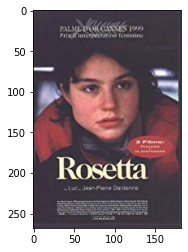

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
import shutil

! mkdir -p ~/.kaggle
! cp "/content/drive/MyDrive/Sphere/2sem.NeuralNetworks/DeepFake/kaggle.json" ~/.kaggle/
! kaggle datasets download -d 'phiitm/movie-posters'
! mkdir /content/datasets
! cp "/content/drive/MyDrive/Sphere/2sem.NeuralNetworks/DeepFake/kuzma.jpg" /content/datasets/
! cp "/content/drive/MyDrive/Sphere/2sem.NeuralNetworks/DeepFake/danila.jpg" /content/datasets/
shutil.unpack_archive('movie-posters.zip', '/content/datasets')
plt.imshow(Image.open('/content/datasets/poster_downloads/7.6_200071.jpg'))
plt.show()

<a href="https://colab.research.google.com/github/YuvalNirkin/fsgan/blob/master/inference/face_swapping.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## FSGAN Face Swapping Demo
Fill out [this form](https://docs.google.com/forms/d/e/1FAIpQLScyyNWoFvyaxxfyaPLnCIAxXgdxLEMwR9Sayjh3JpWseuYlOA/viewform?usp=sf_link),
and after receiving the email, add the FSGAN shared directory to your drive:

![Add to drive](https://raw.githubusercontent.com/wiki/YuvalNirkin/fsgan/media/add_to_drive.jpg)




Acknowledgements: We thank Dr. Eyal Gruss, [wangchao0899](https://github.com/wangchao0899), [jjandnn](https://github.com/jjandnn), and [zhuhaozh](https://github.com/zhuhaozh) for helping with this demo.

A Tesla P100 GPU is recommended for this demo. Let's see what we got:

In [ ]:
!nvidia-smi

Wed Dec 23 12:17:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Installation

In [ ]:
import sys
from IPython.display import HTML, clear_output
from base64 import b64encode

# Install the required dependencies
# !wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
# !bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local
# !rm Miniconda3-latest-Linux-x86_64.sh

!pip install opencv-python ffmpeg-python youtube-dl yacs
!pip install pytorch torchvision cudatoolkit=10.1 -c pytorch -y

!mkdir -p /content/projects/
%cd /content/projects/
!git clone https://github.com/YuvalNirkin/face_detection_dsfd
!git clone https://github.com/YuvalNirkin/fsgan.git

sys.path += ['/usr/local/lib/python3.7/site-packages', '/content/projects']

# Initialize source and target videos from the repository examples
!mkdir -p /content/data
!cp /content/projects/fsgan/docs/examples/shinzo_abe.mp4 /content/data/source.mp4
!cp /content/projects/fsgan/docs/examples/conan_obrien.mp4 /content/data/target.mp4

     |████████████████████████████████| 1.9MB 15.5MB/s 

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y
/content/projects
Cloning into 'face_detection_dsfd'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 311 (delta 0), reused 1 (delta 0), pack-reused 308
Receiving objects: 100% (311/311), 17.65 MiB | 45.30 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Cloning into 'fsgan'...
remote: Enumerating objects: 382, done.
remote: Total 382 (delta 0), reused 0 (delta 0), pack-reused 382
Receiving objects: 100% (382/382), 10.85 MiB | 40.09 MiB/s, done.
Resolving deltas: 100% (202/202), done.


### Initialize face swapping

In [ ]:
import os
from fsgan.inference.swap import FaceSwapping
from fsgan.criterions.vgg_loss import VGGLoss

#@markdown This step should only be done once unless one of the
#@markdown following parameters is changed:

#@markdown ---
#@markdown Path to the weights directory (make sure it is correct):
weights_dir = '/content/drive/MyDrive/Sphere/2sem.NeuralNetworks/DeepFake/fsgan/weights' #@param {type:"string"}
#@markdown Number of finetune iterations on the source subject:
finetune_iterations = 100 #@param {type:"slider", min:100, max:2000, step:1}
#@markdown If True, the inner part of the mouth will be removed from the segmentation:
seg_remove_mouth = True #@param {type:"boolean"}
#@markdown Segmentation batch size
seg_batch_size = 24 #@param {type:"slider", min:1, max:64, step:1}
#@markdown Inference batch size
batch_size = 8 #@param {type:"slider", min:1, max:64, step:1}
#@markdown ---


detection_model = os.path.join(weights_dir, 'v2/WIDERFace_DSFD_RES152.pth')
pose_model = os.path.join(weights_dir, 'shared/hopenet_robust_alpha1.pth')
lms_model = os.path.join(weights_dir, 'v2/hr18_wflw_landmarks.pth')
seg_model = os.path.join(weights_dir, 'v2/celeba_unet_256_1_2_segmentation_v2.pth')
reenactment_model = os.path.join(weights_dir, 'v2/nfv_msrunet_256_1_2_reenactment_v2.1.pth')
completion_model = os.path.join(weights_dir, 'v2/ijbc_msrunet_256_1_2_inpainting_v2.pth')
blending_model = os.path.join(weights_dir, 'v2/ijbc_msrunet_256_1_2_blending_v2.pth')
criterion_id_path = os.path.join(weights_dir, 'v2/vggface2_vgg19_256_1_2_id.pth')
criterion_id = VGGLoss(criterion_id_path)


face_swapping = FaceSwapping(
    detection_model=detection_model, pose_model=pose_model, lms_model=lms_model,
    seg_model=seg_model, reenactment_model=reenactment_model,
    completion_model=completion_model, blending_model=blending_model,
    criterion_id=criterion_id,
    finetune=True, finetune_save=True, finetune_iterations=finetune_iterations,
    seg_remove_mouth=finetune_iterations, batch_size=batch_size,
    seg_batch_size=seg_batch_size, encoder_codec='mp4v')

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth



=> using GPU devices: 0
=> Loading face pose model: "hopenet_robust_alpha1.pth"...
=> Loading face landmarks model: "hr18_wflw_landmarks.pth"...
=> Loading face segmentation model: "celeba_unet_256_1_2_segmentation_v2.pth"...
=> Loading face reenactment model: "nfv_msrunet_256_1_2_reenactment_v2.1.pth"...
=> Loading face completion model: "ijbc_msrunet_256_1_2_inpainting_v2.pth"...
=> Loading face blending model: "ijbc_msrunet_256_1_2_blending_v2.pth"...


### Do face swapping

In [ ]:
# Do face swapping
#@markdown ---
#@markdown Toggle whether to finetune the reenactment generator:
finetune = False #@param {type:"boolean"}
#@markdown Source path
source_path = '/content/datasets/kuzma.jpg' #@param {type:"string"}
#@markdown Source selection method ["longest" | sequence number]:
select_source = 'longest' #@param {type:"string"}
#@markdown Target path
target_path = '/content/datasets/poster_downloads/4.4_278487.jpg' #@param {type:"string"}
#@markdown Target selection method ["longest" | sequence number]:
select_target = 'longest' #@param {type:"string"}
#@markdown ---
output_path = '/content/output.mp4'
face_swapping(source_path, target_path, output_path,
              select_source, select_target, finetune)

# 7.6_117359 7.6_188030
# Encode with audio and display result
# os.remove(output_tmp_path)
# display_video(output_path)


=> Detecting faces in video: "kuzma.jpg..."


100%|██████████| 2/2 [00:00<00:00, 5084.00it/s]


=> Extracting sequences from detections in video: "kuzma.jpg"...
=> Cropping image sequences from image: "kuzma.jpg"...
=> Computing face poses for video: "kuzma_seq00.jpg"...
100%|██████████| 1/1 [00:00<00:00,  3.73batches/s]
=> Computing face landmarks for video: "kuzma_seq00.jpg"...
100%|██████████| 1/1 [00:00<00:00,  5.93batches/s]
=> Computing face segmentation for video: "kuzma_seq00.jpg"...
100%|██████████| 1/1 [00:00<00:00,  6.45batches/s]

100%|██████████| 2/2 [00:00<00:00, 2387.20it/s]


=> Detecting faces in video: "4.4_278487.jpg..."
=> Extracting sequences from detections in video: "4.4_278487.jpg"...
=> Cropping image sequences from image: "4.4_278487.jpg"...
=> Computing face poses for video: "4.4_278487_seq00.jpg"...


100%|██████████| 1/1 [00:00<00:00,  9.01batches/s]
=> Computing face landmarks for video: "4.4_278487_seq00.jpg"...
100%|██████████| 1/1 [00:00<00:00,  5.95batches/s]
=> Computing face segmentation for video: "4.4_278487_seq00.jpg"...
100%|██████████| 1/1 [00:00<00:00,  7.79batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "4.4_278487_seq00.jpg"...
100%|██████████| 1/1 [00:00<00:00,  1.51batches/s]


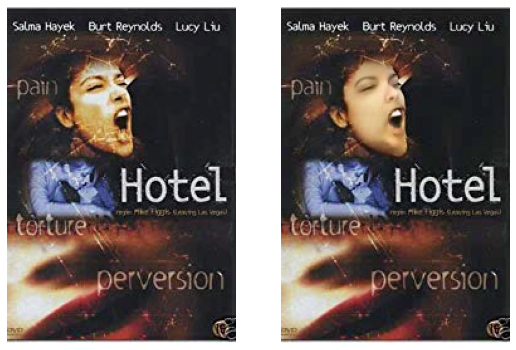

In [ ]:
import cv2
vidcap = cv2.VideoCapture('/content/output.mp4')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("/content/image"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames
sec = 0
frameRate = 0.5 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

plt.rcParams["figure.figsize"] = (9,8)
plt.subplot(121)
plt.imshow(Image.open('/content/datasets/poster_downloads/4.4_278487.jpg'))
plt.axis('off')
plt.subplot(122)
plt.imshow(Image.open('/content/image1.jpg'))
plt.axis('off')
plt.show()

In [ ]:
from tqdm import tqdm

!mkdir /content/output

for filename in tqdm(sorted(os.listdir('/content/datasets/poster_downloads'), reverse=True)):
    fullname = os.path.join('/content/datasets/poster_downloads', filename)
    source_path = '/content/datasets/kuzma.jpg'
    if os.path.isfile(fullname) and fullname.endswith('.jpg'):
        try:
            target_path = fullname
            face_swapping(source_path, target_path, output_path, select_source, select_target, finetune)

            vidcap = cv2.VideoCapture('/content/output.mp4')
            count = 1
            getFrame(sec=0)

            plt.rcParams["figure.figsize"] = (9,7)
            plt.subplot(121)
            plt.imshow(Image.open(target_path))
            plt.axis('off')
            plt.subplot(122)
            plt.imshow(Image.open('/content/image1.jpg'))
            plt.axis('off')
            plt.savefig(os.path.join('/content/drive/MyDrive/Sphere/2sem.NeuralNetworks/DeepFake/output', filename), bbox_inches='tight')
            # plt.show()
        except RuntimeError:
            pass

100%|██████████| 1/1 [00:00<00:00, 20.09frames/s]

100%|██████████| 2/2 [00:00<00:00, 16070.13it/s]

100%|██████████| 1/1 [00:00<00:00, 15.73frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "9.5_185906.jpg..."
=> Extracting sequences from detections in video: "9.5_185906.jpg"...
=> Detecting faces in video: "9.0_114176.jpg..."
=> Extracting sequences from detections in video: "9.0_114176.jpg"...
=> Detecting faces in video: "9.0_112130.jpg..."


100%|██████████| 1/1 [00:00<00:00, 18.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 5953.59it/s]


=> Extracting sequences from detections in video: "9.0_112130.jpg"...
=> Cropping image sequences from image: "9.0_112130.jpg"...
=> Computing face poses for video: "9.0_112130_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.70batches/s]
=> Computing face landmarks for video: "9.0_112130_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.07batches/s]
=> Computing face segmentation for video: "9.0_112130_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.48batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "9.0_112130_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.71batches/s]


  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.9_60196.jpg..."



100%|██████████| 1/1 [00:01<00:00,  1.06s/frames]

100%|██████████| 1/1 [00:00<00:00, 11.63frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.9_60196.jpg"...
=> Detecting faces in video: "8.9_50083.jpg..."
=> Extracting sequences from detections in video: "8.9_50083.jpg"...
=> Detecting faces in video: "8.9_110912.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.90frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.41frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.65frames/s]

100%|██████████| 2/2 [00:00<00:00, 17331.83it/s]

=> Extracting sequences from detections in video: "8.9_110912.jpg"...
=> Detecting faces in video: "8.9_108052.jpg..."
=> Extracting sequences from detections in video: "8.9_108052.jpg"...
=> Detecting faces in video: "8.8_55233.jpg..."
=> Extracting sequences from detections in video: "8.8_55233.jpg"...




100%|██████████| 1/1 [00:00<00:00, 14.14frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.36frames/s]

100%|██████████| 2/2 [00:00<00:00, 8516.35it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.8_113147.jpg..."
=> Extracting sequences from detections in video: "8.8_113147.jpg"...
=> Detecting faces in video: "8.7_83480.jpg..."
=> Extracting sequences from detections in video: "8.7_83480.jpg"...
=> Detecting faces in video: "8.7_76759.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.79frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.87frames/s]

100%|██████████| 2/2 [00:00<00:00, 7262.86it/s]

100%|██████████| 1/1 [00:00<00:00,  9.74frames/s]

  0%|          | 13/8253 [00:08<38:08,  3.60it/s]

=> Extracting sequences from detections in video: "8.7_76759.jpg"...
=> Detecting faces in video: "8.7_73486.jpg..."
=> Extracting sequences from detections in video: "8.7_73486.jpg"...
=> Detecting faces in video: "8.7_380275.jpg..."
=> Extracting sequences from detections in video: "8.7_380275.jpg"...



  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.7_317248.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.29frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.57frames/s]

100%|██████████| 2/2 [00:00<00:00, 6437.92it/s]


=> Extracting sequences from detections in video: "8.7_317248.jpg"...
=> Detecting faces in video: "8.7_167261.jpg..."
=> Extracting sequences from detections in video: "8.7_167261.jpg"...
=> Cropping image sequences from image: "8.7_167261.jpg"...
=> Computing face poses for video: "8.7_167261_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.61batches/s]
=> Computing face landmarks for video: "8.7_167261_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.34batches/s]
=> Computing face segmentation for video: "8.7_167261_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.53batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.7_167261_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.7_133093.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.06frames/s]

100%|██████████| 2/2 [00:00<00:00, 7646.86it/s]

100%|██████████| 1/1 [00:00<00:00, 17.22frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.7_133093.jpg"...
=> Detecting faces in video: "8.6_80297.jpg..."
=> Extracting sequences from detections in video: "8.6_80297.jpg"...
=> Detecting faces in video: "8.6_75520.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.78frames/s]

100%|██████████| 2/2 [00:00<00:00, 8248.39it/s]


=> Extracting sequences from detections in video: "8.6_75520.jpg"...
=> Cropping image sequences from image: "8.6_75520.jpg"...
=> Computing face poses for video: "8.6_75520_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.76batches/s]
=> Computing face landmarks for video: "8.6_75520_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.73batches/s]
=> Computing face segmentation for video: "8.6_75520_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.37batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.6_75520_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.6_64116.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.25frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.6_64116.jpg"...
=> Detecting faces in video: "8.6_62759.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.82frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 12965.39it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.6_62759.jpg"...
=> Detecting faces in video: "8.6_53115.jpg..."
=> Extracting sequences from detections in video: "8.6_53115.jpg"...
=> Detecting faces in video: "8.6_53114.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.68frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.6_53114.jpg"...
=> Detecting faces in video: "8.6_48434.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 16320.25it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.6_48434.jpg"...
=> Detecting faces in video: "8.6_38650.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.84frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.6_38650.jpg"...
=> Detecting faces in video: "8.6_245429.jpg..."


100%|██████████| 1/1 [00:00<00:00, 17.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 8305.55it/s]

100%|██████████| 1/1 [00:00<00:00, 17.03frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.6_245429.jpg"...
=> Detecting faces in video: "8.6_21749.jpg..."
=> Extracting sequences from detections in video: "8.6_21749.jpg"...
=> Detecting faces in video: "8.6_120815.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 8355.19it/s]


=> Extracting sequences from detections in video: "8.6_120815.jpg"...
=> Cropping image sequences from image: "8.6_120815.jpg"...
=> Computing face poses for video: "8.6_120815_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.98batches/s]
=> Computing face poses for video: "8.6_120815_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.99batches/s]
=> Computing face landmarks for video: "8.6_120815_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.96batches/s]
=> Computing face landmarks for video: "8.6_120815_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.93batches/s]
=> Computing face segmentation for video: "8.6_120815_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.49batches/s]
=> Computing face segmentation for video: "8.6_120815_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.32batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.6_120815_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.54batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.6_118799.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.69frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.88frames/s]

100%|██████████| 2/2 [00:00<00:00, 19065.02it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.6_118799.jpg"...
=> Detecting faces in video: "8.6_118114.jpg..."
=> Extracting sequences from detections in video: "8.6_118114.jpg"...
=> Detecting faces in video: "8.6_114814.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.32frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 5507.95it/s]


=> Extracting sequences from detections in video: "8.6_114814.jpg"...
=> Detecting faces in video: "8.6_114369.jpg..."
=> Extracting sequences from detections in video: "8.6_114369.jpg"...
=> Cropping image sequences from image: "8.6_114369.jpg"...
=> Computing face poses for video: "8.6_114369_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.40batches/s]
=> Computing face landmarks for video: "8.6_114369_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.89batches/s]
=> Computing face segmentation for video: "8.6_114369_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.80batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.6_114369_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 17.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 7731.44it/s]

100%|██████████| 1/1 [00:00<00:00, 17.34frames/s]

100%|██████████| 2/2 [00:00<00:00, 9892.23it/s]


=> Detecting faces in video: "8.6_113610.jpg..."
=> Extracting sequences from detections in video: "8.6_113610.jpg"...
=> Detecting faces in video: "8.6_103767.jpg..."
=> Extracting sequences from detections in video: "8.6_103767.jpg"...
=> Cropping image sequences from image: "8.6_103767.jpg"...
=> Computing face poses for video: "8.6_103767_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.62batches/s]
=> Computing face landmarks for video: "8.6_103767_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.97batches/s]
=> Computing face segmentation for video: "8.6_103767_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.28batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.6_103767_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 19.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 7906.32it/s]


=> Detecting faces in video: "8.6_102926.jpg..."
=> Extracting sequences from detections in video: "8.6_102926.jpg"...
=> Cropping image sequences from image: "8.6_102926.jpg"...
=> Computing face poses for video: "8.6_102926_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.45batches/s]
=> Computing face landmarks for video: "8.6_102926_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.00batches/s]
=> Computing face segmentation for video: "8.6_102926_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.36batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.6_102926_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 18.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 7037.42it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.5_95327.jpg..."
=> Extracting sequences from detections in video: "8.5_95327.jpg"...
=> Detecting faces in video: "8.5_88763.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.26frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.69frames/s]

100%|██████████| 2/2 [00:00<00:00, 14691.08it/s]

100%|██████████| 1/1 [00:00<00:00, 16.92frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.5_88763.jpg"...
=> Detecting faces in video: "8.5_88178.jpg..."
=> Extracting sequences from detections in video: "8.5_88178.jpg"...
=> Detecting faces in video: "8.5_82971.jpg..."
=> Extracting sequences from detections in video: "8.5_82971.jpg"...
=> Detecting faces in video: "8.5_70644.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.09frames/s]

100%|██████████| 2/2 [00:00<00:00, 7055.18it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.5_70644.jpg"...
=> Detecting faces in video: "8.5_58625.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.80frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.15frames/s]

100%|██████████| 2/2 [00:00<00:00, 1300.76it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.5_58625.jpg"...
=> Detecting faces in video: "8.5_57012.jpg..."
=> Extracting sequences from detections in video: "8.5_57012.jpg"...
=> Detecting faces in video: "8.5_50825.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.66frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.5_50825.jpg"...
=> Detecting faces in video: "8.5_47396.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.31frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.34frames/s]

100%|██████████| 2/2 [00:00<00:00, 6820.01it/s]


=> Extracting sequences from detections in video: "8.5_47396.jpg"...
=> Detecting faces in video: "8.5_363510.jpg..."
=> Extracting sequences from detections in video: "8.5_363510.jpg"...
=> Cropping image sequences from image: "8.5_363510.jpg"...
=> Computing face poses for video: "8.5_363510_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.66batches/s]
=> Computing face landmarks for video: "8.5_363510_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.13batches/s]
=> Computing face segmentation for video: "8.5_363510_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.14batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.5_363510_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 19.37frames/s]

100%|██████████| 2/2 [00:00<00:00, 6803.41it/s]


=> Detecting faces in video: "8.5_346336.jpg..."
=> Extracting sequences from detections in video: "8.5_346336.jpg"...
=> Cropping image sequences from image: "8.5_346336.jpg"...
=> Computing face poses for video: "8.5_346336_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.71batches/s]
=> Computing face landmarks for video: "8.5_346336_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.00batches/s]
=> Computing face segmentation for video: "8.5_346336_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.26batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.5_346336_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.43frames/s]

100%|██████████| 2/2 [00:00<00:00, 6533.18it/s]


=> Detecting faces in video: "8.5_34583.jpg..."
=> Extracting sequences from detections in video: "8.5_34583.jpg"...
=> Cropping image sequences from image: "8.5_34583.jpg"...
=> Computing face poses for video: "8.5_34583_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.00batches/s]
=> Computing face landmarks for video: "8.5_34583_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.87batches/s]
=> Computing face segmentation for video: "8.5_34583_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.17batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.5_34583_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 8933.55it/s]

100%|██████████| 1/1 [00:00<00:00, 18.40frames/s]

100%|██████████| 2/2 [00:00<00:00, 1401.14it/s]


=> Detecting faces in video: "8.5_32553.jpg..."
=> Extracting sequences from detections in video: "8.5_32553.jpg"...
=> Detecting faces in video: "8.5_282864.jpg..."
=> Extracting sequences from detections in video: "8.5_282864.jpg"...
=> Cropping image sequences from image: "8.5_282864.jpg"...
=> Computing face poses for video: "8.5_282864_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.76batches/s]
=> Computing face poses for video: "8.5_282864_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.61batches/s]
=> Computing face landmarks for video: "8.5_282864_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.85batches/s]
=> Computing face landmarks for video: "8.5_282864_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.88batches/s]
=> Computing face segmentation for video: "8.5_282864_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.24batches/s]
=> Computing face segmentation for video: "8.5_282864_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.25batches/s]
=> F

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.5_281376.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.60frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.39frames/s]

100%|██████████| 2/2 [00:00<00:00, 4253.86it/s]

100%|██████████| 1/1 [00:00<00:00, 16.35frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.5_281376.jpg"...
=> Detecting faces in video: "8.5_27977.jpg..."
=> Extracting sequences from detections in video: "8.5_27977.jpg"...
=> Detecting faces in video: "8.5_253474.jpg..."
=> Extracting sequences from detections in video: "8.5_253474.jpg"...
=> Detecting faces in video: "8.5_209144.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.25frames/s]

100%|██████████| 2/2 [00:00<00:00, 7731.44it/s]


=> Extracting sequences from detections in video: "8.5_209144.jpg"...
=> Cropping image sequences from image: "8.5_209144.jpg"...
=> Computing face poses for video: "8.5_209144_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.02batches/s]
=> Computing face poses for video: "8.5_209144_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.98batches/s]
=> Computing face landmarks for video: "8.5_209144_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.41batches/s]
=> Computing face landmarks for video: "8.5_209144_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.08batches/s]
=> Computing face segmentation for video: "8.5_209144_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.98batches/s]
=> Computing face segmentation for video: "8.5_209144_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.79batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.5_209144_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 15.58frames/s]

100%|██████████| 2/2 [00:00<00:00, 7108.99it/s]

100%|██████████| 1/1 [00:00<00:00, 15.80frames/s]

100%|██████████| 2/2 [00:00<00:00, 4040.76it/s]


=> Detecting faces in video: "8.5_172495.jpg..."
=> Extracting sequences from detections in video: "8.5_172495.jpg"...
=> Detecting faces in video: "8.5_120689.jpg..."
=> Extracting sequences from detections in video: "8.5_120689.jpg"...
=> Cropping image sequences from image: "8.5_120689.jpg"...
=> Computing face poses for video: "8.5_120689_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.90batches/s]
=> Computing face landmarks for video: "8.5_120689_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.04batches/s]
=> Computing face segmentation for video: "8.5_120689_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.35batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.5_120689_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 15.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 7847.15it/s]

100%|██████████| 1/1 [00:00<00:00, 16.58frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.5_110357.jpg..."
=> Extracting sequences from detections in video: "8.5_110357.jpg"...
=> Detecting faces in video: "8.5_103064.jpg..."
=> Extracting sequences from detections in video: "8.5_103064.jpg"...
=> Detecting faces in video: "8.4_99851.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.31frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 12925.44it/s]

100%|██████████| 1/1 [00:00<00:00, 16.40frames/s]

100%|██████████| 2/2 [00:00<00:00, 8176.03it/s]


=> Extracting sequences from detections in video: "8.4_99851.jpg"...
=> Detecting faces in video: "8.4_90015.jpg..."
=> Extracting sequences from detections in video: "8.4_90015.jpg"...
=> Detecting faces in video: "8.4_88727.jpg..."
=> Extracting sequences from detections in video: "8.4_88727.jpg"...
=> Cropping image sequences from image: "8.4_88727.jpg"...
=> Computing face poses for video: "8.4_88727_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.77batches/s]
=> Computing face landmarks for video: "8.4_88727_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.42batches/s]
=> Computing face segmentation for video: "8.4_88727_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.31batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.4_88727_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 18.23frames/s]

100%|██████████| 2/2 [00:00<00:00, 8719.97it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.4_88275.jpg..."
=> Extracting sequences from detections in video: "8.4_88275.jpg"...
=> Detecting faces in video: "8.4_87843.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.51frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.12frames/s]

100%|██████████| 2/2 [00:00<00:00, 14315.03it/s]

100%|██████████| 1/1 [00:00<00:00, 17.85frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.4_87843.jpg"...
=> Detecting faces in video: "8.4_82755.jpg..."
=> Extracting sequences from detections in video: "8.4_82755.jpg"...
=> Detecting faces in video: "8.4_82096.jpg..."
=> Extracting sequences from detections in video: "8.4_82096.jpg"...
=> Detecting faces in video: "8.4_81505.jpg..."


100%|██████████| 1/1 [00:00<00:00, 18.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 4561.51it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.4_81505.jpg"...
=> Detecting faces in video: "8.4_81059.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.38frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.4_81059.jpg"...
=> Detecting faces in video: "8.4_73179.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.97frames/s]

100%|██████████| 2/2 [00:00<00:00, 6781.41it/s]

=> Extracting sequences from detections in video: "8.4_73179.jpg"...
=> Cropping image sequences from image: "8.4_73179.jpg"...
=> Computing face poses for video: "8.4_73179_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.88batches/s]
=> Computing face poses for video: "8.4_73179_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.89batches/s]
=> Computing face landmarks for video: "8.4_73179_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.10batches/s]
=> Computing face landmarks for video: "8.4_73179_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.00batches/s]
=> Computing face segmentation for video: "8.4_73179_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.36batches/s]
=> Computing face segmentation for video: "8.4_73179_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.30batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.4_73179_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.51batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.15frames/s]

100%|██████████| 2/2 [00:00<00:00, 8533.68it/s]


=> Detecting faces in video: "8.4_60107.jpg..."
=> Extracting sequences from detections in video: "8.4_60107.jpg"...
=> Cropping image sequences from image: "8.4_60107.jpg"...
=> Computing face poses for video: "8.4_60107_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.30batches/s]
=> Computing face landmarks for video: "8.4_60107_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.02batches/s]
=> Computing face segmentation for video: "8.4_60107_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.42batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.4_60107_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 18.60frames/s]

100%|██████████| 2/2 [00:00<00:00, 13231.24it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.4_59026.jpg..."
=> Extracting sequences from detections in video: "8.4_59026.jpg"...
=> Detecting faces in video: "8.4_57565.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.82frames/s]

100%|██████████| 2/2 [00:00<00:00, 5915.80it/s]

=> Extracting sequences from detections in video: "8.4_57565.jpg"...
=> Cropping image sequences from image: "8.4_57565.jpg"...
=> Computing face poses for video: "8.4_57565_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.52batches/s]
=> Computing face landmarks for video: "8.4_57565_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.17batches/s]
=> Computing face segmentation for video: "8.4_57565_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.16batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.4_57565_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.72batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 17.87frames/s]

100%|██████████| 2/2 [00:00<00:00, 6118.61it/s]


=> Detecting faces in video: "8.4_56119.jpg..."
=> Extracting sequences from detections in video: "8.4_56119.jpg"...
=> Cropping image sequences from image: "8.4_56119.jpg"...
=> Computing face poses for video: "8.4_56119_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.70batches/s]
=> Computing face landmarks for video: "8.4_56119_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.75batches/s]
=> Computing face segmentation for video: "8.4_56119_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.34batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.4_56119_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.4_53125.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.44frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 12905.55it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.4_53125.jpg"...
=> Detecting faces in video: "8.4_52357.jpg..."
=> Extracting sequences from detections in video: "8.4_52357.jpg"...
=> Detecting faces in video: "8.4_51201.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.76frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.86frames/s]

100%|██████████| 2/2 [00:00<00:00, 7550.50it/s]


=> Extracting sequences from detections in video: "8.4_51201.jpg"...
=> Detecting faces in video: "8.4_47445.jpg..."
=> Extracting sequences from detections in video: "8.4_47445.jpg"...
=> Cropping image sequences from image: "8.4_47445.jpg"...
=> Computing face poses for video: "8.4_47445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.84batches/s]
=> Computing face poses for video: "8.4_47445_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.91batches/s]
=> Computing face poses for video: "8.4_47445_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.17batches/s]
=> Computing face landmarks for video: "8.4_47445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.11batches/s]
=> Computing face landmarks for video: "8.4_47445_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.06batches/s]
=> Computing face landmarks for video: "8.4_47445_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.89batches/s]
=> Computing face segmentation for video: "8.4_47445_seq00.jpg"...

100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.4_37674.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.13frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.4_37674.jpg"...
=> Detecting faces in video: "8.4_36775.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.01frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.94frames/s]

100%|██████████| 2/2 [00:00<00:00, 8081.51it/s]


=> Extracting sequences from detections in video: "8.4_36775.jpg"...
=> Detecting faces in video: "8.4_342804.jpg..."
=> Extracting sequences from detections in video: "8.4_342804.jpg"...
=> Cropping image sequences from image: "8.4_342804.jpg"...
=> Computing face poses for video: "8.4_342804_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.79batches/s]
=> Computing face landmarks for video: "8.4_342804_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.98batches/s]
=> Computing face segmentation for video: "8.4_342804_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.58batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.4_342804_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.18frames/s]

100%|██████████| 2/2 [00:00<00:00, 5882.61it/s]


=> Detecting faces in video: "8.4_33467.jpg..."
=> Extracting sequences from detections in video: "8.4_33467.jpg"...
=> Cropping image sequences from image: "8.4_33467.jpg"...
=> Computing face poses for video: "8.4_33467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.01batches/s]
=> Computing face landmarks for video: "8.4_33467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.23batches/s]
=> Computing face segmentation for video: "8.4_33467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.78batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.4_33467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.54batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 21.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 17476.27it/s]

100%|██████████| 1/1 [00:00<00:00, 18.99frames/s]

100%|██████████| 2/2 [00:00<00:00, 9446.63it/s]


=> Detecting faces in video: "8.4_22100.jpg..."
=> Extracting sequences from detections in video: "8.4_22100.jpg"...
=> Detecting faces in video: "8.4_211915.jpg..."
=> Extracting sequences from detections in video: "8.4_211915.jpg"...
=> Cropping image sequences from image: "8.4_211915.jpg"...
=> Computing face poses for video: "8.4_211915_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.02batches/s]
=> Computing face landmarks for video: "8.4_211915_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.12batches/s]
=> Computing face segmentation for video: "8.4_211915_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.58batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.4_211915_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 19.85frames/s]

100%|██████████| 2/2 [00:00<00:00, 14742.72it/s]

100%|██████████| 1/1 [00:00<00:00, 18.96frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.4_19760.jpg..."
=> Extracting sequences from detections in video: "8.4_19760.jpg"...
=> Detecting faces in video: "8.4_180093.jpg..."
=> Extracting sequences from detections in video: "8.4_180093.jpg"...
=> Detecting faces in video: "8.4_119698.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.14frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.50frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.4_119698.jpg"...
=> Detecting faces in video: "8.4_118849.jpg..."
=> Extracting sequences from detections in video: "8.4_118849.jpg"...
=> Detecting faces in video: "8.4_117293.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.44frames/s]

100%|██████████| 2/2 [00:00<00:00, 3256.45it/s]

100%|██████████| 1/1 [00:00<00:00, 13.06frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.02frames/s]

100%|██████████| 2/2 [00:00<00:00, 8876.83it/s]


=> Extracting sequences from detections in video: "8.4_117293.jpg"...
=> Detecting faces in video: "8.4_112573.jpg..."
=> Extracting sequences from detections in video: "8.4_112573.jpg"...
=> Detecting faces in video: "8.4_108906.jpg..."
=> Extracting sequences from detections in video: "8.4_108906.jpg"...
=> Cropping image sequences from image: "8.4_108906.jpg"...
=> Computing face poses for video: "8.4_108906_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.83batches/s]
=> Computing face landmarks for video: "8.4_108906_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.49batches/s]
=> Computing face segmentation for video: "8.4_108906_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.51batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.4_108906_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 19.64frames/s]

100%|██████████| 2/2 [00:00<00:00, 13294.15it/s]

100%|██████████| 1/1 [00:00<00:00,  8.19frames/s]

100%|██████████| 2/2 [00:00<00:00, 6605.20it/s]


=> Detecting faces in video: "8.4_108598.jpg..."
=> Extracting sequences from detections in video: "8.4_108598.jpg"...
=> Detecting faces in video: "8.3_97576.jpg..."
=> Extracting sequences from detections in video: "8.3_97576.jpg"...
=> Cropping image sequences from image: "8.3_97576.jpg"...
=> Computing face poses for video: "8.3_97576_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.99batches/s]
=> Computing face landmarks for video: "8.3_97576_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.12batches/s]
=> Computing face segmentation for video: "8.3_97576_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.00batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.3_97576_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 19.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 8848.74it/s]


=> Detecting faces in video: "8.3_97223.jpg..."
=> Extracting sequences from detections in video: "8.3_97223.jpg"...
=> Cropping image sequences from image: "8.3_97223.jpg"...
=> Computing face poses for video: "8.3_97223_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.94batches/s]
=> Computing face landmarks for video: "8.3_97223_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.89batches/s]
=> Computing face segmentation for video: "8.3_97223_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.50batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.3_97223_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 18.39frames/s]

100%|██████████| 2/2 [00:00<00:00, 8208.03it/s]

100%|██████████| 1/1 [00:00<00:00, 17.12frames/s]

100%|██████████| 2/2 [00:00<00:00, 7384.34it/s]


=> Detecting faces in video: "8.3_93058.jpg..."
=> Extracting sequences from detections in video: "8.3_93058.jpg"...
=> Detecting faces in video: "8.3_91251.jpg..."
=> Extracting sequences from detections in video: "8.3_91251.jpg"...
=> Cropping image sequences from image: "8.3_91251.jpg"...
=> Computing face poses for video: "8.3_91251_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.43batches/s]
=> Computing face landmarks for video: "8.3_91251_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.99batches/s]
=> Computing face segmentation for video: "8.3_91251_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.79batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.3_91251_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.35frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.3_88650.jpg..."
=> Extracting sequences from detections in video: "8.3_88650.jpg"...
=> Detecting faces in video: "8.3_86879.jpg..."


100%|██████████| 1/1 [00:00<00:00, 17.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 20763.88it/s]

100%|██████████| 1/1 [00:00<00:00, 19.93frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 10433.59it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.3_86879.jpg"...
=> Detecting faces in video: "8.3_86250.jpg..."
=> Extracting sequences from detections in video: "8.3_86250.jpg"...
=> Detecting faces in video: "8.3_85809.jpg..."
=> Extracting sequences from detections in video: "8.3_85809.jpg"...
=> Detecting faces in video: "8.3_77711.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.42frames/s]

100%|██████████| 2/2 [00:00<00:00, 7169.75it/s]


=> Extracting sequences from detections in video: "8.3_77711.jpg"...
=> Cropping image sequences from image: "8.3_77711.jpg"...
=> Computing face poses for video: "8.3_77711_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.00batches/s]
=> Computing face landmarks for video: "8.3_77711_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.18batches/s]
=> Computing face segmentation for video: "8.3_77711_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.34batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.3_77711_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 20.19frames/s]

100%|██████████| 2/2 [00:00<00:00, 19463.13it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.3_74896.jpg..."
=> Extracting sequences from detections in video: "8.3_74896.jpg"...
=> Detecting faces in video: "8.3_74605.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.37frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 7876.63it/s]


=> Extracting sequences from detections in video: "8.3_74605.jpg"...
=> Detecting faces in video: "8.3_71604.jpg..."
=> Extracting sequences from detections in video: "8.3_71604.jpg"...
=> Cropping image sequences from image: "8.3_71604.jpg"...
=> Computing face poses for video: "8.3_71604_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.96batches/s]
=> Computing face landmarks for video: "8.3_71604_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.87batches/s]
=> Computing face segmentation for video: "8.3_71604_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.74batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.3_71604_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.02frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.3_71411.jpg..."
=> Extracting sequences from detections in video: "8.3_71411.jpg"...
=> Detecting faces in video: "8.3_71143.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.74frames/s]

100%|██████████| 2/2 [00:00<00:00, 13751.82it/s]

100%|██████████| 1/1 [00:00<00:00, 12.04frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.13frames/s]


=> Extracting sequences from detections in video: "8.3_71143.jpg"...
=> Detecting faces in video: "8.3_66921.jpg..."
=> Extracting sequences from detections in video: "8.3_66921.jpg"...
=> Detecting faces in video: "8.3_62622.jpg..."



  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.3_62622.jpg"...
=> Detecting faces in video: "8.3_59578.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.03frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.3_59578.jpg"...
=> Detecting faces in video: "8.3_58888.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 5817.34it/s]

=> Extracting sequences from detections in video: "8.3_58888.jpg"...
=> Cropping image sequences from image: "8.3_58888.jpg"...
=> Computing face poses for video: "8.3_58888_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.15batches/s]
=> Computing face poses for video: "8.3_58888_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.14batches/s]
=> Computing face landmarks for video: "8.3_58888_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.35batches/s]
=> Computing face landmarks for video: "8.3_58888_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.92batches/s]
=> Computing face segmentation for video: "8.3_58888_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.34batches/s]
=> Computing face segmentation for video: "8.3_58888_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.40batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.3_58888_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.3_56172.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.58frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.75frames/s]

100%|██████████| 2/2 [00:00<00:00, 5360.13it/s]

100%|██████████| 1/1 [00:00<00:00, 12.70frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.3_56172.jpg"...
=> Detecting faces in video: "8.3_55630.jpg..."
=> Extracting sequences from detections in video: "8.3_55630.jpg"...
=> Detecting faces in video: "8.3_55601.jpg..."
=> Extracting sequences from detections in video: "8.3_55601.jpg"...
=> Detecting faces in video: "8.3_55031.jpg..."


100%|██████████| 1/1 [00:00<00:00, 13.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 9127.97it/s]

100%|██████████| 1/1 [00:00<00:00, 14.17frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 7839.82it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.3_55031.jpg"...
=> Detecting faces in video: "8.3_53604.jpg..."
=> Extracting sequences from detections in video: "8.3_53604.jpg"...
=> Detecting faces in video: "8.3_53291.jpg..."
=> Extracting sequences from detections in video: "8.3_53291.jpg"...
=> Detecting faces in video: "8.3_50634.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.06frames/s]

100%|██████████| 2/2 [00:00<00:00, 7090.96it/s]


=> Extracting sequences from detections in video: "8.3_50634.jpg"...
=> Cropping image sequences from image: "8.3_50634.jpg"...
=> Computing face poses for video: "8.3_50634_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.02batches/s]
=> Computing face landmarks for video: "8.3_50634_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.18batches/s]
=> Computing face segmentation for video: "8.3_50634_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.70batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.3_50634_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.3_45152.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.50frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.47frames/s]

100%|██████████| 2/2 [00:00<00:00, 2349.75it/s]

100%|██████████| 1/1 [00:00<00:00, 13.74frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.3_45152.jpg"...
=> Detecting faces in video: "8.3_44741.jpg..."
=> Extracting sequences from detections in video: "8.3_44741.jpg"...
=> Detecting faces in video: "8.3_43313.jpg..."
=> Extracting sequences from detections in video: "8.3_43313.jpg"...
=> Detecting faces in video: "8.3_42876.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 7884.03it/s]

100%|██████████| 1/1 [00:00<00:00,  6.72frames/s]

100%|██████████| 2/2 [00:00<00:00, 8097.11it/s]


=> Extracting sequences from detections in video: "8.3_42876.jpg"...
=> Detecting faces in video: "8.3_42804.jpg..."
=> Extracting sequences from detections in video: "8.3_42804.jpg"...
=> Cropping image sequences from image: "8.3_42804.jpg"...
=> Computing face poses for video: "8.3_42804_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.94batches/s]
=> Computing face landmarks for video: "8.3_42804_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.30batches/s]
=> Computing face segmentation for video: "8.3_42804_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.67batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.3_42804_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.3_42192.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.01frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.3_42192.jpg"...
=> Detecting faces in video: "8.3_41452.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.16frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.32frames/s]

100%|██████████| 2/2 [00:00<00:00, 7591.50it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.3_41452.jpg"...
=> Detecting faces in video: "8.3_40725.jpg..."
=> Extracting sequences from detections in video: "8.3_40725.jpg"...
=> Detecting faces in video: "8.3_338013.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.60frames/s]

100%|██████████| 2/2 [00:00<00:00, 5493.52it/s]


=> Extracting sequences from detections in video: "8.3_338013.jpg"...
=> Cropping image sequences from image: "8.3_338013.jpg"...
=> Computing face poses for video: "8.3_338013_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.25batches/s]
=> Computing face landmarks for video: "8.3_338013_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.93batches/s]
=> Computing face segmentation for video: "8.3_338013_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.47batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.3_338013_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 19.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 13189.64it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.3_29192.jpg..."
=> Extracting sequences from detections in video: "8.3_29192.jpg"...
=> Detecting faces in video: "8.3_272045.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.12frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.35frames/s]

100%|██████████| 2/2 [00:00<00:00, 6096.37it/s]

100%|██████████| 1/1 [00:00<00:00, 16.13frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.3_272045.jpg"...
=> Detecting faces in video: "8.3_264476.jpg..."
=> Extracting sequences from detections in video: "8.3_264476.jpg"...
=> Detecting faces in video: "8.3_245929.jpg..."
=> Extracting sequences from detections in video: "8.3_245929.jpg"...
=> Detecting faces in video: "8.3_208092.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.32frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.97frames/s]

100%|██████████| 2/2 [00:00<00:00, 3763.40it/s]

100%|██████████| 1/1 [00:00<00:00, 15.37frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.3_208092.jpg"...
=> Detecting faces in video: "8.3_19254.jpg..."
=> Extracting sequences from detections in video: "8.3_19254.jpg"...
=> Detecting faces in video: "8.3_18742.jpg..."
=> Extracting sequences from detections in video: "8.3_18742.jpg"...
=> Detecting faces in video: "8.3_176093.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.91frames/s]

100%|██████████| 2/2 [00:00<00:00, 7731.44it/s]

100%|██████████| 1/1 [00:00<00:00, 15.06frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 6274.20it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.3_176093.jpg"...
=> Detecting faces in video: "8.3_173772.jpg..."
=> Extracting sequences from detections in video: "8.3_173772.jpg"...
=> Detecting faces in video: "8.3_17136.jpg..."
=> Extracting sequences from detections in video: "8.3_17136.jpg"...
=> Detecting faces in video: "8.3_164312.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.61frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.52frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.31frames/s]

  0%|          | 0/2 [00:00<?, ?it/s]

=> Extracting sequences from detections in video: "8.3_164312.jpg"...
=> Detecting faces in video: "8.3_15624.jpg..."
=> Extracting sequences from detections in video: "8.3_15624.jpg"...
=> Detecting faces in video: "8.3_12349.jpg..."
=> Extracting sequences from detections in video: "8.3_12349.jpg"...


100%|██████████| 2/2 [00:00<00:00, 2880.70it/s]

100%|██████████| 1/1 [00:00<00:00, 13.08frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.3_119217.jpg..."
=> Extracting sequences from detections in video: "8.3_119217.jpg"...
=> Detecting faces in video: "8.3_114709.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.12frames/s]

100%|██████████| 1/1 [00:00<00:00,  9.56frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.48frames/s]



=> Extracting sequences from detections in video: "8.3_114709.jpg"...
=> Detecting faces in video: "8.3_110081.jpg..."
=> Extracting sequences from detections in video: "8.3_110081.jpg"...
=> Detecting faces in video: "8.3_110057.jpg..."
=> Extracting sequences from detections in video: "8.3_110057.jpg"...


100%|██████████| 2/2 [00:00<00:00, 4088.02it/s]

100%|██████████| 1/1 [00:00<00:00, 16.31frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.3_105695.jpg..."
=> Extracting sequences from detections in video: "8.3_105695.jpg"...
=> Detecting faces in video: "8.3_105236.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.03frames/s]

100%|██████████| 1/1 [00:00<00:00, 19.03frames/s]

100%|██████████| 2/2 [00:00<00:00, 7509.94it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.3_105236.jpg"...
=> Detecting faces in video: "8.2_97372.jpg..."
=> Extracting sequences from detections in video: "8.2_97372.jpg"...
=> Detecting faces in video: "8.2_96283.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.56frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.66frames/s]

100%|██████████| 2/2 [00:00<00:00, 5398.07it/s]


=> Extracting sequences from detections in video: "8.2_96283.jpg"...
=> Detecting faces in video: "8.2_95016.jpg..."
=> Extracting sequences from detections in video: "8.2_95016.jpg"...
=> Cropping image sequences from image: "8.2_95016.jpg"...
=> Computing face poses for video: "8.2_95016_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.18batches/s]
=> Computing face landmarks for video: "8.2_95016_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.10batches/s]
=> Computing face segmentation for video: "8.2_95016_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.24batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_95016_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_89881.jpg..."



100%|██████████| 1/1 [00:01<00:00,  1.13s/frames]

100%|██████████| 1/1 [00:00<00:00, 13.21frames/s]

100%|██████████| 2/2 [00:00<00:00, 2360.99it/s]


=> Extracting sequences from detections in video: "8.2_89881.jpg"...
=> Detecting faces in video: "8.2_86022.jpg..."
=> Extracting sequences from detections in video: "8.2_86022.jpg"...
=> Cropping image sequences from image: "8.2_86022.jpg"...
=> Computing face poses for video: "8.2_86022_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.79batches/s]
=> Computing face landmarks for video: "8.2_86022_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.94batches/s]
=> Computing face segmentation for video: "8.2_86022_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.49batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_86022_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.51batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.82frames/s]

100%|██████████| 2/2 [00:00<00:00, 9457.28it/s]

100%|██████████| 1/1 [00:00<00:00, 11.19frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_85474.jpg..."
=> Extracting sequences from detections in video: "8.2_85474.jpg"...
=> Detecting faces in video: "8.2_84934.jpg..."
=> Extracting sequences from detections in video: "8.2_84934.jpg"...
=> Detecting faces in video: "8.2_84787.jpg..."


100%|██████████| 1/1 [00:00<00:00, 13.55frames/s]

100%|██████████| 2/2 [00:00<00:00, 12300.01it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.2_84787.jpg"...
=> Detecting faces in video: "8.2_83946.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.15frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.40frames/s]

100%|██████████| 2/2 [00:00<00:00, 7194.35it/s]


=> Extracting sequences from detections in video: "8.2_83946.jpg"...
=> Detecting faces in video: "8.2_83658.jpg..."
=> Extracting sequences from detections in video: "8.2_83658.jpg"...
=> Cropping image sequences from image: "8.2_83658.jpg"...
=> Computing face poses for video: "8.2_83658_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.79batches/s]
=> Computing face landmarks for video: "8.2_83658_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.61batches/s]
=> Computing face segmentation for video: "8.2_83658_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.19batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_83658_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_83652.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.59frames/s]

100%|██████████| 2/2 [00:00<00:00, 5903.31it/s]

=> Extracting sequences from detections in video: "8.2_83652.jpg"...
=> Cropping image sequences from image: "8.2_83652.jpg"...
=> Computing face poses for video: "8.2_83652_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.72batches/s]
=> Computing face landmarks for video: "8.2_83652_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.21batches/s]
=> Computing face segmentation for video: "8.2_83652_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.76batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_83652_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 19.19frames/s]

100%|██████████| 2/2 [00:00<00:00, 19645.45it/s]

100%|██████████| 1/1 [00:00<00:00, 12.78frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_80678.jpg..."
=> Extracting sequences from detections in video: "8.2_80678.jpg"...
=> Detecting faces in video: "8.2_79579.jpg..."
=> Extracting sequences from detections in video: "8.2_79579.jpg"...
=> Detecting faces in video: "8.2_77838.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 16844.59it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.2_77838.jpg"...
=> Detecting faces in video: "8.2_72443.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.88frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 16039.40it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.2_72443.jpg"...
=> Detecting faces in video: "8.2_72417.jpg..."
=> Extracting sequences from detections in video: "8.2_72417.jpg"...
=> Detecting faces in video: "8.2_70510.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.19frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.16frames/s]

100%|██████████| 2/2 [00:00<00:00, 12390.85it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.2_70510.jpg"...
=> Detecting faces in video: "8.2_69467.jpg..."
=> Extracting sequences from detections in video: "8.2_69467.jpg"...
=> Detecting faces in video: "8.2_65234.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.99frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.88frames/s]

100%|██████████| 2/2 [00:00<00:00, 5737.76it/s]


=> Extracting sequences from detections in video: "8.2_65234.jpg"...
=> Detecting faces in video: "8.2_61512.jpg..."
=> Extracting sequences from detections in video: "8.2_61512.jpg"...
=> Cropping image sequences from image: "8.2_61512.jpg"...
=> Computing face poses for video: "8.2_61512_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.41batches/s]
=> Computing face landmarks for video: "8.2_61512_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.27batches/s]
=> Computing face segmentation for video: "8.2_61512_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.43batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_61512_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_57115.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.37frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.2_57115.jpg"...
=> Detecting faces in video: "8.2_56732.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.60frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.2_56732.jpg"...
=> Detecting faces in video: "8.2_56443.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.74frames/s]

100%|██████████| 2/2 [00:00<00:00, 7430.12it/s]

=> Extracting sequences from detections in video: "8.2_56443.jpg"...
=> Cropping image sequences from image: "8.2_56443.jpg"...
=> Computing face poses for video: "8.2_56443_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.98batches/s]
=> Computing face landmarks for video: "8.2_56443_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.16batches/s]
=> Computing face segmentation for video: "8.2_56443_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.65batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_56443_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.04frames/s]

100%|██████████| 2/2 [00:00<00:00, 14794.72it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_56300.jpg..."
=> Extracting sequences from detections in video: "8.2_56300.jpg"...
=> Detecting faces in video: "8.2_54144.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.64frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.2_54144.jpg"...
=> Detecting faces in video: "8.2_53946.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.26frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 10292.77it/s]


=> Extracting sequences from detections in video: "8.2_53946.jpg"...
=> Detecting faces in video: "8.2_52572.jpg..."
=> Extracting sequences from detections in video: "8.2_52572.jpg"...
=> Cropping image sequences from image: "8.2_52572.jpg"...
=> Computing face poses for video: "8.2_52572_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.11batches/s]
=> Computing face landmarks for video: "8.2_52572_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.32batches/s]
=> Computing face segmentation for video: "8.2_52572_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.20batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_52572_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_51036.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.16frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.06frames/s]

100%|██████████| 2/2 [00:00<00:00, 5702.66it/s]


=> Extracting sequences from detections in video: "8.2_51036.jpg"...
=> Detecting faces in video: "8.2_50976.jpg..."
=> Extracting sequences from detections in video: "8.2_50976.jpg"...
=> Cropping image sequences from image: "8.2_50976.jpg"...
=> Computing face poses for video: "8.2_50976_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.80batches/s]
=> Computing face landmarks for video: "8.2_50976_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.06batches/s]
=> Computing face segmentation for video: "8.2_50976_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.52batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_50976_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_50783.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 7876.63it/s]

=> Extracting sequences from detections in video: "8.2_50783.jpg"...
=> Cropping image sequences from image: "8.2_50783.jpg"...
=> Computing face poses for video: "8.2_50783_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.72batches/s]
=> Computing face landmarks for video: "8.2_50783_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.66batches/s]
=> Computing face segmentation for video: "8.2_50783_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.47batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_50783_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_50371.jpg..."



100%|██████████| 1/1 [00:01<00:00,  1.01s/frames]

100%|██████████| 1/1 [00:00<00:00, 11.15frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.30frames/s]

100%|██████████| 2/2 [00:00<00:00, 9586.98it/s]



=> Extracting sequences from detections in video: "8.2_50371.jpg"...
=> Detecting faces in video: "8.2_49902.jpg..."
=> Extracting sequences from detections in video: "8.2_49902.jpg"...
=> Detecting faces in video: "8.2_48956.jpg..."
=> Extracting sequences from detections in video: "8.2_48956.jpg"...
=> Detecting faces in video: "8.2_48452.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.04frames/s]

100%|██████████| 2/2 [00:00<00:00, 5785.25it/s]


=> Extracting sequences from detections in video: "8.2_48452.jpg"...
=> Cropping image sequences from image: "8.2_48452.jpg"...
=> Computing face poses for video: "8.2_48452_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.54batches/s]
=> Computing face poses for video: "8.2_48452_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.07batches/s]
=> Computing face landmarks for video: "8.2_48452_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.36batches/s]
=> Computing face landmarks for video: "8.2_48452_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.43batches/s]
=> Computing face segmentation for video: "8.2_48452_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.52batches/s]
=> Computing face segmentation for video: "8.2_48452_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.49batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_48452_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.54batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.79frames/s]

100%|██████████| 2/2 [00:00<00:00, 4639.72it/s]


=> Detecting faces in video: "8.2_48021.jpg..."
=> Extracting sequences from detections in video: "8.2_48021.jpg"...
=> Cropping image sequences from image: "8.2_48021.jpg"...
=> Computing face poses for video: "8.2_48021_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.35batches/s]
=> Computing face landmarks for video: "8.2_48021_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.36batches/s]
=> Computing face segmentation for video: "8.2_48021_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.42batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_48021_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 4728.64it/s]


=> Detecting faces in video: "8.2_47296.jpg..."
=> Extracting sequences from detections in video: "8.2_47296.jpg"...
=> Cropping image sequences from image: "8.2_47296.jpg"...
=> Computing face poses for video: "8.2_47296_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.26batches/s]
=> Computing face landmarks for video: "8.2_47296_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.92batches/s]
=> Computing face segmentation for video: "8.2_47296_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.02batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_47296_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.00frames/s]

100%|██████████| 2/2 [00:00<00:00, 7928.74it/s]

100%|██████████| 1/1 [00:00<00:00, 12.61frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_46912.jpg..."
=> Extracting sequences from detections in video: "8.2_46912.jpg"...
=> Detecting faces in video: "8.2_46851.jpg..."
=> Extracting sequences from detections in video: "8.2_46851.jpg"...
=> Detecting faces in video: "8.2_46478.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.93frames/s]

100%|██████████| 2/2 [00:00<00:00, 7921.25it/s]


=> Extracting sequences from detections in video: "8.2_46478.jpg"...
=> Cropping image sequences from image: "8.2_46478.jpg"...
=> Computing face poses for video: "8.2_46478_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.41batches/s]
=> Computing face poses for video: "8.2_46478_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.06batches/s]
=> Computing face landmarks for video: "8.2_46478_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.31batches/s]
=> Computing face landmarks for video: "8.2_46478_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.21batches/s]
=> Computing face segmentation for video: "8.2_46478_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.51batches/s]
=> Computing face segmentation for video: "8.2_46478_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.26batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_46478_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 5962.05it/s]


=> Detecting faces in video: "8.2_45274.jpg..."
=> Extracting sequences from detections in video: "8.2_45274.jpg"...
=> Cropping image sequences from image: "8.2_45274.jpg"...
=> Computing face poses for video: "8.2_45274_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.45batches/s]
=> Computing face landmarks for video: "8.2_45274_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.34batches/s]
=> Computing face segmentation for video: "8.2_45274_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.71batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_45274_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.41frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.97frames/s]

100%|██████████| 2/2 [00:00<00:00, 6853.44it/s]

=> Detecting faces in video: "8.2_45112.jpg..."
=> Extracting sequences from detections in video: "8.2_45112.jpg"...
=> Detecting faces in video: "8.2_43338.jpg..."
=> Extracting sequences from detections in video: "8.2_43338.jpg"...



100%|██████████| 1/1 [00:00<00:00, 11.44frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.29frames/s]

100%|██████████| 2/2 [00:00<00:00, 7358.43it/s]


=> Detecting faces in video: "8.2_42041.jpg..."
=> Extracting sequences from detections in video: "8.2_42041.jpg"...
=> Detecting faces in video: "8.2_36112.jpg..."
=> Extracting sequences from detections in video: "8.2_36112.jpg"...
=> Cropping image sequences from image: "8.2_36112.jpg"...
=> Computing face poses for video: "8.2_36112_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.11batches/s]
=> Computing face landmarks for video: "8.2_36112_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.31batches/s]
=> Computing face segmentation for video: "8.2_36112_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.34batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_36112_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.92frames/s]

100%|██████████| 2/2 [00:00<00:00, 8692.86it/s]


=> Detecting faces in video: "8.2_35446.jpg..."
=> Extracting sequences from detections in video: "8.2_35446.jpg"...
=> Cropping image sequences from image: "8.2_35446.jpg"...
=> Computing face poses for video: "8.2_35446_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.13batches/s]
=> Computing face poses for video: "8.2_35446_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.06batches/s]
=> Computing face landmarks for video: "8.2_35446_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.02batches/s]
=> Computing face landmarks for video: "8.2_35446_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.24batches/s]
=> Computing face segmentation for video: "8.2_35446_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.38batches/s]
=> Computing face segmentation for video: "8.2_35446_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.58batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_35446_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.80frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_33836.jpg..."
=> Extracting sequences from detections in video: "8.2_33836.jpg"...
=> Detecting faces in video: "8.2_32976.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.42frames/s]

100%|██████████| 2/2 [00:00<00:00, 6754.11it/s]


=> Extracting sequences from detections in video: "8.2_32976.jpg"...
=> Cropping image sequences from image: "8.2_32976.jpg"...
=> Computing face poses for video: "8.2_32976_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.99batches/s]
=> Computing face poses for video: "8.2_32976_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.69batches/s]
=> Computing face landmarks for video: "8.2_32976_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.34batches/s]
=> Computing face landmarks for video: "8.2_32976_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.26batches/s]
=> Computing face segmentation for video: "8.2_32976_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.76batches/s]
=> Computing face segmentation for video: "8.2_32976_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.02batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_32976_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 6507.84it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_317910.jpg..."
=> Extracting sequences from detections in video: "8.2_317910.jpg"...
=> Detecting faces in video: "8.2_31679.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.05frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.2_31679.jpg"...
=> Detecting faces in video: "8.2_31381.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.52frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.79frames/s]

100%|██████████| 2/2 [00:00<00:00, 6973.07it/s]

100%|██████████| 1/1 [00:00<00:00, 13.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 10837.99it/s]


=> Extracting sequences from detections in video: "8.2_31381.jpg"...
=> Detecting faces in video: "8.2_282674.jpg..."
=> Extracting sequences from detections in video: "8.2_282674.jpg"...
=> Detecting faces in video: "8.2_268978.jpg..."
=> Extracting sequences from detections in video: "8.2_268978.jpg"...
=> Cropping image sequences from image: "8.2_268978.jpg"...
=> Computing face poses for video: "8.2_268978_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.36batches/s]
=> Computing face landmarks for video: "8.2_268978_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.12batches/s]
=> Computing face segmentation for video: "8.2_268978_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.47batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_268978_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.28frames/s]

100%|██████████| 2/2 [00:00<00:00, 8490.49it/s]


=> Detecting faces in video: "8.2_25316.jpg..."
=> Extracting sequences from detections in video: "8.2_25316.jpg"...
=> Cropping image sequences from image: "8.2_25316.jpg"...
=> Computing face poses for video: "8.2_25316_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.80batches/s]
=> Computing face poses for video: "8.2_25316_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.77batches/s]
=> Computing face landmarks for video: "8.2_25316_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.90batches/s]
=> Computing face landmarks for video: "8.2_25316_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.19batches/s]
=> Computing face segmentation for video: "8.2_25316_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.51batches/s]
=> Computing face segmentation for video: "8.2_25316_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.65batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_25316_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_238015.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.04frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.2_238015.jpg"...
=> Detecting faces in video: "8.2_191043.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.21frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.62frames/s]

100%|██████████| 2/2 [00:00<00:00, 16008.79it/s]

100%|██████████| 1/1 [00:00<00:00, 13.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 5618.63it/s]


=> Extracting sequences from detections in video: "8.2_191043.jpg"...
=> Detecting faces in video: "8.2_188913.jpg..."
=> Extracting sequences from detections in video: "8.2_188913.jpg"...
=> Detecting faces in video: "8.2_17925.jpg..."
=> Extracting sequences from detections in video: "8.2_17925.jpg"...
=> Cropping image sequences from image: "8.2_17925.jpg"...
=> Computing face poses for video: "8.2_17925_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face landmarks for video: "8.2_17925_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.55batches/s]
=> Computing face segmentation for video: "8.2_17925_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.04batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_17925_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.80batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 8499.10it/s]


=> Detecting faces in video: "8.2_179218.jpg..."
=> Extracting sequences from detections in video: "8.2_179218.jpg"...
=> Cropping image sequences from image: "8.2_179218.jpg"...
=> Computing face poses for video: "8.2_179218_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.22batches/s]
=> Computing face landmarks for video: "8.2_179218_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.37batches/s]
=> Computing face segmentation for video: "8.2_179218_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.31batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_179218_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.47frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_15864.jpg..."
=> Extracting sequences from detections in video: "8.2_15864.jpg"...
=> Detecting faces in video: "8.2_14429.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.51frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.2_14429.jpg"...
=> Detecting faces in video: "8.2_120735.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.12frames/s]

100%|██████████| 2/2 [00:00<00:00, 5821.38it/s]

=> Extracting sequences from detections in video: "8.2_120735.jpg"...
=> Cropping image sequences from image: "8.2_120735.jpg"...
=> Computing face poses for video: "8.2_120735_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.38batches/s]
=> Computing face landmarks for video: "8.2_120735_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.11batches/s]
=> Computing face segmentation for video: "8.2_120735_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.39batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_120735_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.67frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_118715.jpg..."
=> Extracting sequences from detections in video: "8.2_118715.jpg"...
=> Detecting faces in video: "8.2_117951.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.66frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 1361.35it/s]


=> Extracting sequences from detections in video: "8.2_117951.jpg"...
=> Detecting faces in video: "8.2_113277.jpg..."
=> Extracting sequences from detections in video: "8.2_113277.jpg"...
=> Cropping image sequences from image: "8.2_113277.jpg"...
=> Computing face poses for video: "8.2_113277_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.93batches/s]
=> Computing face poses for video: "8.2_113277_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.25batches/s]
=> Computing face landmarks for video: "8.2_113277_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.38batches/s]
=> Computing face landmarks for video: "8.2_113277_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.22batches/s]
=> Computing face segmentation for video: "8.2_113277_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.56batches/s]
=> Computing face segmentation for video: "8.2_113277_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.43batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_113277_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.47frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_112691.jpg..."
=> Extracting sequences from detections in video: "8.2_112691.jpg"...
=> Detecting faces in video: "8.2_112641.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.17frames/s]

100%|██████████| 2/2 [00:00<00:00, 8184.01it/s]


=> Extracting sequences from detections in video: "8.2_112641.jpg"...
=> Cropping image sequences from image: "8.2_112641.jpg"...
=> Computing face poses for video: "8.2_112641_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face poses for video: "8.2_112641_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.81batches/s]
=> Computing face landmarks for video: "8.2_112641_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.29batches/s]
=> Computing face landmarks for video: "8.2_112641_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.15batches/s]
=> Computing face segmentation for video: "8.2_112641_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.47batches/s]
=> Computing face segmentation for video: "8.2_112641_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.58batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.2_112641_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.06frames/s]

100%|██████████| 2/2 [00:00<00:00, 13888.42it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.2_104810.jpg..."
=> Extracting sequences from detections in video: "8.2_104810.jpg"...
=> Detecting faces in video: "8.2_101640.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.16frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.16frames/s]

100%|██████████| 2/2 [00:00<00:00, 23109.11it/s]

100%|██████████| 1/1 [00:00<00:00, 11.60frames/s]

  3%|▎         | 211/8253 [03:44<3:20:53,  1.50s/it]

=> Extracting sequences from detections in video: "8.2_101640.jpg"...
=> Detecting faces in video: "8.1_96257.jpg..."
=> Extracting sequences from detections in video: "8.1_96257.jpg"...
=> Detecting faces in video: "8.1_94625.jpg..."
=> Extracting sequences from detections in video: "8.1_94625.jpg"...
=> Detecting faces in video: "8.1_93779.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.58frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.19frames/s]

100%|██████████| 2/2 [00:00<00:00, 10796.15it/s]

100%|██████████| 1/1 [00:00<00:00, 16.17frames/s]

100%|██████████| 2/2 [00:00<00:00, 7724.32it/s]


=> Extracting sequences from detections in video: "8.1_93779.jpg"...
=> Detecting faces in video: "8.1_93191.jpg..."
=> Extracting sequences from detections in video: "8.1_93191.jpg"...
=> Detecting faces in video: "8.1_92593.jpg..."
=> Extracting sequences from detections in video: "8.1_92593.jpg"...
=> Cropping image sequences from image: "8.1_92593.jpg"...
=> Computing face poses for video: "8.1_92593_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.22batches/s]
=> Computing face poses for video: "8.1_92593_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.29batches/s]
=> Computing face landmarks for video: "8.1_92593_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.41batches/s]
=> Computing face landmarks for video: "8.1_92593_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.17batches/s]
=> Computing face segmentation for video: "8.1_92593_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.40batches/s]
=> Computing face segmentation for video: "8.1_92593_seq01.jpg"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_92067.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.55frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.64frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_92067.jpg"...
=> Detecting faces in video: "8.1_91288.jpg..."
=> Extracting sequences from detections in video: "8.1_91288.jpg"...
=> Detecting faces in video: "8.1_90368.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.85frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.73frames/s]

100%|██████████| 2/2 [00:00<00:00, 6875.91it/s]

100%|██████████| 1/1 [00:00<00:00, 15.53frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_90368.jpg"...
=> Detecting faces in video: "8.1_87884.jpg..."
=> Extracting sequences from detections in video: "8.1_87884.jpg"...
=> Detecting faces in video: "8.1_87544.jpg..."
=> Extracting sequences from detections in video: "8.1_87544.jpg"...
=> Detecting faces in video: "8.1_85218.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 5422.50it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_85218.jpg"...
=> Detecting faces in video: "8.1_84628.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.41frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_84628.jpg"...
=> Detecting faces in video: "8.1_83987.jpg..."



100%|██████████| 1/1 [00:01<00:00,  1.02s/frames]

100%|██████████| 1/1 [00:00<00:00, 13.07frames/s]

100%|██████████| 2/2 [00:00<00:00, 7876.63it/s]


=> Extracting sequences from detections in video: "8.1_83987.jpg"...
=> Detecting faces in video: "8.1_83922.jpg..."
=> Extracting sequences from detections in video: "8.1_83922.jpg"...
=> Cropping image sequences from image: "8.1_83922.jpg"...
=> Computing face poses for video: "8.1_83922_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.64batches/s]
=> Computing face poses for video: "8.1_83922_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.44batches/s]
=> Computing face poses for video: "8.1_83922_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.90batches/s]
=> Computing face landmarks for video: "8.1_83922_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.13batches/s]
=> Computing face landmarks for video: "8.1_83922_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.08batches/s]
=> Computing face landmarks for video: "8.1_83922_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.35batches/s]
=> Computing face segmentation for video: "8.1_83922_seq00.jpg"...

100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.31frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.46frames/s]

100%|██████████| 2/2 [00:00<00:00, 8765.53it/s]

=> Detecting faces in video: "8.1_81874.jpg..."
=> Extracting sequences from detections in video: "8.1_81874.jpg"...
=> Detecting faces in video: "8.1_79944.jpg..."
=> Extracting sequences from detections in video: "8.1_79944.jpg"...
=> Cropping image sequences from image: "8.1_79944.jpg"...


=> Computing face poses for video: "8.1_79944_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.28batches/s]
=> Computing face landmarks for video: "8.1_79944_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.53batches/s]
=> Computing face segmentation for video: "8.1_79944_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.82batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_79944_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.18frames/s]

100%|██████████| 2/2 [00:00<00:00, 7839.82it/s]


=> Detecting faces in video: "8.1_79672.jpg..."
=> Extracting sequences from detections in video: "8.1_79672.jpg"...
=> Cropping image sequences from image: "8.1_79672.jpg"...
=> Computing face poses for video: "8.1_79672_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.12batches/s]
=> Computing face landmarks for video: "8.1_79672_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.23batches/s]
=> Computing face segmentation for video: "8.1_79672_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.49batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_79672_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.34frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_79470.jpg..."
=> Extracting sequences from detections in video: "8.1_79470.jpg"...
=> Detecting faces in video: "8.1_79322.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.96frames/s]

100%|██████████| 2/2 [00:00<00:00, 8586.09it/s]


=> Extracting sequences from detections in video: "8.1_79322.jpg"...
=> Cropping image sequences from image: "8.1_79322.jpg"...
=> Computing face poses for video: "8.1_79322_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face landmarks for video: "8.1_79322_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.37batches/s]
=> Computing face segmentation for video: "8.1_79322_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.45batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_79322_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.12frames/s]

=> Detecting faces in video: "8.1_75148.jpg..."


100%|██████████| 1/1 [00:00<00:00,  5.01frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.46frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_75148.jpg"...
=> Detecting faces in video: "8.1_72684.jpg..."
=> Extracting sequences from detections in video: "8.1_72684.jpg"...
=> Detecting faces in video: "8.1_71141.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.60frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.55frames/s]

100%|██████████| 2/2 [00:00<00:00, 8413.85it/s]

100%|██████████| 1/1 [00:00<00:00, 14.79frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_71141.jpg"...
=> Detecting faces in video: "8.1_70460.jpg..."
=> Extracting sequences from detections in video: "8.1_70460.jpg"...
=> Detecting faces in video: "8.1_69293.jpg..."
=> Extracting sequences from detections in video: "8.1_69293.jpg"...
=> Detecting faces in video: "8.1_69281.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.40frames/s]

100%|██████████| 2/2 [00:00<00:00, 9489.38it/s]


=> Extracting sequences from detections in video: "8.1_69281.jpg"...
=> Cropping image sequences from image: "8.1_69281.jpg"...
=> Computing face poses for video: "8.1_69281_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.56batches/s]
=> Computing face landmarks for video: "8.1_69281_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.23batches/s]
=> Computing face segmentation for video: "8.1_69281_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.67batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_69281_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.85frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_68816.jpg..."
=> Extracting sequences from detections in video: "8.1_68816.jpg"...
=> Detecting faces in video: "8.1_67328.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.37frames/s]

100%|██████████| 2/2 [00:00<00:00, 15252.01it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_67328.jpg"...
=> Detecting faces in video: "8.1_66580.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.01frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_66580.jpg"...
=> Detecting faces in video: "8.1_65571.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.92frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.02frames/s]

100%|██████████| 2/2 [00:00<00:00, 16225.55it/s]

100%|██████████| 1/1 [00:00<00:00, 16.50frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_65571.jpg"...
=> Detecting faces in video: "8.1_65531.jpg..."
=> Extracting sequences from detections in video: "8.1_65531.jpg"...
=> Detecting faces in video: "8.1_64689.jpg..."
=> Extracting sequences from detections in video: "8.1_64689.jpg"...
=> Detecting faces in video: "8.1_64115.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.66frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_64115.jpg"...
=> Detecting faces in video: "8.1_63611.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.31frames/s]

100%|██████████| 2/2 [00:00<00:00, 8914.57it/s]

=> Extracting sequences from detections in video: "8.1_63611.jpg"...
=> Cropping image sequences from image: "8.1_63611.jpg"...
=> Computing face poses for video: "8.1_63611_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.61batches/s]
=> Computing face poses for video: "8.1_63611_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.44batches/s]
=> Computing face landmarks for video: "8.1_63611_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.10batches/s]
=> Computing face landmarks for video: "8.1_63611_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.32batches/s]
=> Computing face segmentation for video: "8.1_63611_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.84batches/s]
=> Computing face segmentation for video: "8.1_63611_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.59batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_63611_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.72frames/s]

100%|██████████| 2/2 [00:00<00:00, 9457.28it/s]


=> Detecting faces in video: "8.1_63227.jpg..."
=> Extracting sequences from detections in video: "8.1_63227.jpg"...
=> Cropping image sequences from image: "8.1_63227.jpg"...
=> Computing face poses for video: "8.1_63227_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.52batches/s]
=> Computing face landmarks for video: "8.1_63227_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.57batches/s]
=> Computing face segmentation for video: "8.1_63227_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.81batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_63227_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.48frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_61184.jpg..."
=> Extracting sequences from detections in video: "8.1_61184.jpg"...
=> Detecting faces in video: "8.1_60827.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.22frames/s]

100%|██████████| 2/2 [00:00<00:00, 7096.96it/s]


=> Extracting sequences from detections in video: "8.1_60827.jpg"...
=> Cropping image sequences from image: "8.1_60827.jpg"...
=> Computing face poses for video: "8.1_60827_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.68batches/s]
=> Computing face poses for video: "8.1_60827_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.69batches/s]
=> Computing face landmarks for video: "8.1_60827_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.48batches/s]
=> Computing face landmarks for video: "8.1_60827_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face segmentation for video: "8.1_60827_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.05batches/s]
=> Computing face segmentation for video: "8.1_60827_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.24batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_60827_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.96frames/s]

100%|██████████| 2/2 [00:00<00:00, 7523.42it/s]


=> Detecting faces in video: "8.1_59527.jpg..."
=> Extracting sequences from detections in video: "8.1_59527.jpg"...
=> Cropping image sequences from image: "8.1_59527.jpg"...
=> Computing face poses for video: "8.1_59527_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.71batches/s]
=> Computing face landmarks for video: "8.1_59527_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.99batches/s]
=> Computing face segmentation for video: "8.1_59527_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.63batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_59527_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.41frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_58946.jpg..."
=> Extracting sequences from detections in video: "8.1_58946.jpg"...
=> Detecting faces in video: "8.1_57358.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.59frames/s]

100%|██████████| 2/2 [00:00<00:00, 8012.04it/s]


=> Extracting sequences from detections in video: "8.1_57358.jpg"...
=> Cropping image sequences from image: "8.1_57358.jpg"...
=> Computing face poses for video: "8.1_57358_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.11batches/s]
=> Computing face landmarks for video: "8.1_57358_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.44batches/s]
=> Computing face segmentation for video: "8.1_57358_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.41batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_57358_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.81frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.50frames/s]

100%|██████████| 2/2 [00:00<00:00, 6105.25it/s]


=> Detecting faces in video: "8.1_57091.jpg..."
=> Extracting sequences from detections in video: "8.1_57091.jpg"...
=> Detecting faces in video: "8.1_57058.jpg..."
=> Extracting sequences from detections in video: "8.1_57058.jpg"...
=> Cropping image sequences from image: "8.1_57058.jpg"...
=> Computing face poses for video: "8.1_57058_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.14batches/s]
=> Computing face landmarks for video: "8.1_57058_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.46batches/s]
=> Computing face segmentation for video: "8.1_57058_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.11batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_57058_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 7489.83it/s]

=> Detecting faces in video: "8.1_56801.jpg..."
=> Extracting sequences from detections in video: "8.1_56801.jpg"...
=> Cropping image sequences from image: "8.1_56801.jpg"...


=> Computing face poses for video: "8.1_56801_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.89batches/s]
=> Computing face landmarks for video: "8.1_56801_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.56batches/s]
=> Computing face segmentation for video: "8.1_56801_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.99batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_56801_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.62frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_56687.jpg..."
=> Extracting sequences from detections in video: "8.1_56687.jpg"...
=> Detecting faces in video: "8.1_56663.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.24frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.16frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_56663.jpg"...
=> Detecting faces in video: "8.1_56241.jpg..."
=> Extracting sequences from detections in video: "8.1_56241.jpg"...
=> Detecting faces in video: "8.1_56217.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.99frames/s]

100%|██████████| 2/2 [00:00<00:00, 4488.29it/s]

=> Extracting sequences from detections in video: "8.1_56217.jpg"...
=> Cropping image sequences from image: "8.1_56217.jpg"...
=> Computing face poses for video: "8.1_56217_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.56batches/s]
=> Computing face landmarks for video: "8.1_56217_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.42batches/s]
=> Computing face segmentation for video: "8.1_56217_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.56batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_56217_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.23frames/s]

100%|██████████| 2/2 [00:00<00:00, 7397.36it/s]


=> Detecting faces in video: "8.1_55499.jpg..."
=> Extracting sequences from detections in video: "8.1_55499.jpg"...
=> Cropping image sequences from image: "8.1_55499.jpg"...
=> Computing face poses for video: "8.1_55499_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.63batches/s]
=> Computing face landmarks for video: "8.1_55499_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.67batches/s]
=> Computing face segmentation for video: "8.1_55499_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.66batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_55499_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.54batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_54460.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.19frames/s]

100%|██████████| 2/2 [00:00<00:00, 4445.47it/s]

=> Extracting sequences from detections in video: "8.1_54460.jpg"...
=> Cropping image sequences from image: "8.1_54460.jpg"...
=> Computing face poses for video: "8.1_54460_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.66batches/s]
=> Computing face landmarks for video: "8.1_54460_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.41batches/s]
=> Computing face segmentation for video: "8.1_54460_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.52batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_54460_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.19frames/s]

100%|██████████| 2/2 [00:00<00:00, 8867.45it/s]


=> Detecting faces in video: "8.1_53779.jpg..."
=> Extracting sequences from detections in video: "8.1_53779.jpg"...
=> Cropping image sequences from image: "8.1_53779.jpg"...
=> Computing face poses for video: "8.1_53779_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.22batches/s]
=> Computing face landmarks for video: "8.1_53779_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.40batches/s]
=> Computing face segmentation for video: "8.1_53779_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.73batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_53779_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.78frames/s]

100%|██████████| 2/2 [00:00<00:00, 8858.09it/s]

100%|██████████| 1/1 [00:00<00:00, 11.72frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_53198.jpg..."
=> Extracting sequences from detections in video: "8.1_53198.jpg"...
=> Detecting faces in video: "8.1_52618.jpg..."
=> Extracting sequences from detections in video: "8.1_52618.jpg"...
=> Detecting faces in video: "8.1_52600.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.21frames/s]

100%|██████████| 2/2 [00:00<00:00, 6021.97it/s]

100%|██████████| 1/1 [00:00<00:00, 17.32frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.58frames/s]

100%|██████████| 2/2 [00:00<00:00, 10459.61it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_52600.jpg"...
=> Detecting faces in video: "8.1_52561.jpg..."
=> Extracting sequences from detections in video: "8.1_52561.jpg"...
=> Detecting faces in video: "8.1_51808.jpg..."
=> Extracting sequences from detections in video: "8.1_51808.jpg"...
=> Detecting faces in video: "8.1_51459.jpg..."


100%|██████████| 1/1 [00:00<00:00, 18.87frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_51459.jpg"...
=> Detecting faces in video: "8.1_49012.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.32frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.78frames/s]

100%|██████████| 2/2 [00:00<00:00, 10118.95it/s]


=> Extracting sequences from detections in video: "8.1_49012.jpg"...
=> Detecting faces in video: "8.1_47528.jpg..."
=> Extracting sequences from detections in video: "8.1_47528.jpg"...
=> Cropping image sequences from image: "8.1_47528.jpg"...
=> Computing face poses for video: "8.1_47528_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.35batches/s]
=> Computing face landmarks for video: "8.1_47528_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.56batches/s]
=> Computing face segmentation for video: "8.1_47528_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.72batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_47528_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.80batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.61frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_46911.jpg..."
=> Extracting sequences from detections in video: "8.1_46911.jpg"...
=> Detecting faces in video: "8.1_46250.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.77frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.98frames/s]

100%|██████████| 2/2 [00:00<00:00, 4917.12it/s]


=> Extracting sequences from detections in video: "8.1_46250.jpg"...
=> Detecting faces in video: "8.1_44837.jpg..."
=> Extracting sequences from detections in video: "8.1_44837.jpg"...
=> Cropping image sequences from image: "8.1_44837.jpg"...
=> Computing face poses for video: "8.1_44837_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.45batches/s]
=> Computing face landmarks for video: "8.1_44837_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.26batches/s]
=> Computing face segmentation for video: "8.1_44837_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.77batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_44837_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_44008.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.44frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.00frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_44008.jpg"...
=> Detecting faces in video: "8.1_41719.jpg..."
=> Extracting sequences from detections in video: "8.1_41719.jpg"...
=> Detecting faces in video: "8.1_41546.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.25frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.74frames/s]

100%|██████████| 2/2 [00:00<00:00, 4954.88it/s]


=> Extracting sequences from detections in video: "8.1_41546.jpg"...
=> Detecting faces in video: "8.1_39689.jpg..."
=> Extracting sequences from detections in video: "8.1_39689.jpg"...
=> Cropping image sequences from image: "8.1_39689.jpg"...
=> Computing face poses for video: "8.1_39689_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.46batches/s]
=> Computing face landmarks for video: "8.1_39689_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.45batches/s]
=> Computing face segmentation for video: "8.1_39689_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.59batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_39689_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.12frames/s]

100%|██████████| 2/2 [00:00<00:00, 9532.51it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_38890.jpg..."
=> Extracting sequences from detections in video: "8.1_38890.jpg"...
=> Detecting faces in video: "8.1_38733.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.80frames/s]

100%|██████████| 2/2 [00:00<00:00, 5464.89it/s]


=> Extracting sequences from detections in video: "8.1_38733.jpg"...
=> Cropping image sequences from image: "8.1_38733.jpg"...
=> Computing face poses for video: "8.1_38733_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.68batches/s]
=> Computing face poses for video: "8.1_38733_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.94batches/s]
=> Computing face landmarks for video: "8.1_38733_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.40batches/s]
=> Computing face landmarks for video: "8.1_38733_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face segmentation for video: "8.1_38733_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.56batches/s]
=> Computing face segmentation for video: "8.1_38733_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.08batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_38733_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.19frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_38190.jpg..."
=> Extracting sequences from detections in video: "8.1_38190.jpg"...
=> Detecting faces in video: "8.1_379557.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.03frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.30frames/s]

100%|██████████| 2/2 [00:00<00:00, 6921.29it/s]


=> Extracting sequences from detections in video: "8.1_379557.jpg"...
=> Detecting faces in video: "8.1_37558.jpg..."
=> Extracting sequences from detections in video: "8.1_37558.jpg"...
=> Cropping image sequences from image: "8.1_37558.jpg"...
=> Computing face poses for video: "8.1_37558_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.42batches/s]
=> Computing face poses for video: "8.1_37558_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.60batches/s]
=> Computing face landmarks for video: "8.1_37558_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.50batches/s]
=> Computing face landmarks for video: "8.1_37558_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.07batches/s]
=> Computing face segmentation for video: "8.1_37558_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.36batches/s]
=> Computing face segmentation for video: "8.1_37558_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.54batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_37558_seq00.jpg"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_374546.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.37frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.40frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.77frames/s]

100%|██████████| 2/2 [00:00<00:00, 5769.33it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_374546.jpg"...
=> Detecting faces in video: "8.1_37008.jpg..."
=> Extracting sequences from detections in video: "8.1_37008.jpg"...
=> Detecting faces in video: "8.1_36868.jpg..."
=> Extracting sequences from detections in video: "8.1_36868.jpg"...
=> Detecting faces in video: "8.1_36244.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.71frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 10131.17it/s]


=> Extracting sequences from detections in video: "8.1_36244.jpg"...
=> Detecting faces in video: "8.1_35140.jpg..."
=> Extracting sequences from detections in video: "8.1_35140.jpg"...
=> Cropping image sequences from image: "8.1_35140.jpg"...
=> Computing face poses for video: "8.1_35140_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.46batches/s]
=> Computing face landmarks for video: "8.1_35140_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.23batches/s]
=> Computing face segmentation for video: "8.1_35140_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.00batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_35140_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.07frames/s]

100%|██████████| 2/2 [00:00<00:00, 11966.63it/s]

100%|██████████| 1/1 [00:00<00:00, 11.70frames/s]

100%|██████████| 2/2 [00:00<00:00, 4804.47it/s]


=> Detecting faces in video: "8.1_34240.jpg..."
=> Extracting sequences from detections in video: "8.1_34240.jpg"...
=> Detecting faces in video: "8.1_338564.jpg..."
=> Extracting sequences from detections in video: "8.1_338564.jpg"...
=> Cropping image sequences from image: "8.1_338564.jpg"...
=> Computing face poses for video: "8.1_338564_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.89batches/s]
=> Computing face poses for video: "8.1_338564_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.83batches/s]
=> Computing face landmarks for video: "8.1_338564_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.54batches/s]
=> Computing face landmarks for video: "8.1_338564_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.05batches/s]
=> Computing face segmentation for video: "8.1_338564_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.30batches/s]
=> Computing face segmentation for video: "8.1_338564_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.24batches/s]
=> F

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.89frames/s]

100%|██████████| 2/2 [00:00<00:00, 4122.17it/s]


=> Detecting faces in video: "8.1_33045.jpg..."
=> Extracting sequences from detections in video: "8.1_33045.jpg"...
=> Cropping image sequences from image: "8.1_33045.jpg"...
=> Computing face poses for video: "8.1_33045_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.24batches/s]
=> Computing face poses for video: "8.1_33045_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.38batches/s]
=> Computing face landmarks for video: "8.1_33045_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.46batches/s]
=> Computing face landmarks for video: "8.1_33045_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.20batches/s]
=> Computing face segmentation for video: "8.1_33045_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.93batches/s]
=> Computing face segmentation for video: "8.1_33045_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.92batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_33045_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_32551.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.13frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.23frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_32551.jpg"...
=> Detecting faces in video: "8.1_32138.jpg..."
=> Extracting sequences from detections in video: "8.1_32138.jpg"...
=> Detecting faces in video: "8.1_31885.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.32frames/s]

100%|██████████| 2/2 [00:00<00:00, 10280.16it/s]


=> Extracting sequences from detections in video: "8.1_31885.jpg"...
=> Cropping image sequences from image: "8.1_31885.jpg"...
=> Computing face poses for video: "8.1_31885_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.35batches/s]
=> Computing face poses for video: "8.1_31885_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.93batches/s]
=> Computing face landmarks for video: "8.1_31885_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face landmarks for video: "8.1_31885_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.43batches/s]
=> Computing face segmentation for video: "8.1_31885_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.25batches/s]
=> Computing face segmentation for video: "8.1_31885_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.38batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_31885_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.34frames/s]

100%|██████████| 2/2 [00:00<00:00, 8793.09it/s]

100%|██████████| 1/1 [00:00<00:00, 12.71frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_307385.jpg..."
=> Extracting sequences from detections in video: "8.1_307385.jpg"...
=> Detecting faces in video: "8.1_28950.jpg..."
=> Extracting sequences from detections in video: "8.1_28950.jpg"...
=> Detecting faces in video: "8.1_28010.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 9118.05it/s]


=> Extracting sequences from detections in video: "8.1_28010.jpg"...
=> Cropping image sequences from image: "8.1_28010.jpg"...
=> Computing face poses for video: "8.1_28010_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.10batches/s]
=> Computing face landmarks for video: "8.1_28010_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.30batches/s]
=> Computing face segmentation for video: "8.1_28010_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.33batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_28010_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.70batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.07frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_276919.jpg..."
=> Extracting sequences from detections in video: "8.1_276919.jpg"...
=> Detecting faces in video: "8.1_27532.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 10754.63it/s]

100%|██████████| 1/1 [00:00<00:00, 12.45frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.29frames/s]

100%|██████████| 2/2 [00:00<00:00, 12768.05it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_27532.jpg"...
=> Detecting faces in video: "8.1_266697.jpg..."
=> Extracting sequences from detections in video: "8.1_266697.jpg"...
=> Detecting faces in video: "8.1_266543.jpg..."
=> Extracting sequences from detections in video: "8.1_266543.jpg"...
=> Detecting faces in video: "8.1_264464.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.12frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.69frames/s]

100%|██████████| 2/2 [00:00<00:00, 8256.50it/s]


=> Extracting sequences from detections in video: "8.1_264464.jpg"...
=> Detecting faces in video: "8.1_25878.jpg..."
=> Extracting sequences from detections in video: "8.1_25878.jpg"...
=> Cropping image sequences from image: "8.1_25878.jpg"...
=> Computing face poses for video: "8.1_25878_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.75batches/s]
=> Computing face landmarks for video: "8.1_25878_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.26batches/s]
=> Computing face segmentation for video: "8.1_25878_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.90batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_25878_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.62frames/s]

100%|██████████| 2/2 [00:00<00:00, 6163.56it/s]


=> Detecting faces in video: "8.1_245712.jpg..."
=> Extracting sequences from detections in video: "8.1_245712.jpg"...
=> Cropping image sequences from image: "8.1_245712.jpg"...
=> Computing face poses for video: "8.1_245712_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face poses for video: "8.1_245712_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.90batches/s]
=> Computing face landmarks for video: "8.1_245712_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.28batches/s]
=> Computing face landmarks for video: "8.1_245712_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face segmentation for video: "8.1_245712_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.95batches/s]
=> Computing face segmentation for video: "8.1_245712_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.86batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_245712_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.17frames/s]

100%|██████████| 2/2 [00:00<00:00, 6447.82it/s]

100%|██████████| 1/1 [00:00<00:00, 11.79frames/s]

100%|██████████| 2/2 [00:00<00:00, 9543.35it/s]


=> Detecting faces in video: "8.1_244316.jpg..."
=> Extracting sequences from detections in video: "8.1_244316.jpg"...
=> Detecting faces in video: "8.1_243664.jpg..."
=> Extracting sequences from detections in video: "8.1_243664.jpg"...
=> Cropping image sequences from image: "8.1_243664.jpg"...
=> Computing face poses for video: "8.1_243664_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.74batches/s]
=> Computing face landmarks for video: "8.1_243664_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.47batches/s]
=> Computing face segmentation for video: "8.1_243664_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.79batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_243664_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_24069.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.02frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.38frames/s]

100%|██████████| 2/2 [00:00<00:00, 9631.01it/s]


=> Extracting sequences from detections in video: "8.1_24069.jpg"...
=> Detecting faces in video: "8.1_23042.jpg..."
=> Extracting sequences from detections in video: "8.1_23042.jpg"...
=> Cropping image sequences from image: "8.1_23042.jpg"...
=> Computing face poses for video: "8.1_23042_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.71batches/s]
=> Computing face landmarks for video: "8.1_23042_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.10batches/s]
=> Computing face segmentation for video: "8.1_23042_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.36batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_23042_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_221344.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.90frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.47frames/s]

100%|██████████| 2/2 [00:00<00:00, 6307.22it/s]


=> Extracting sequences from detections in video: "8.1_221344.jpg"...
=> Detecting faces in video: "8.1_20629.jpg..."
=> Extracting sequences from detections in video: "8.1_20629.jpg"...
=> Cropping image sequences from image: "8.1_20629.jpg"...
=> Computing face poses for video: "8.1_20629_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.64batches/s]
=> Computing face landmarks for video: "8.1_20629_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face segmentation for video: "8.1_20629_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.41batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_20629_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.43frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.37frames/s]

  4%|▎         | 307/8253 [06:47<3:52:08,  1.75s/it]


=> Detecting faces in video: "8.1_198781.jpg..."
=> Extracting sequences from detections in video: "8.1_198781.jpg"...
=> Detecting faces in video: "8.1_168515.jpg..."
=> Extracting sequences from detections in video: "8.1_168515.jpg"...
=> Detecting faces in video: "8.1_16847.jpg..."


100%|██████████| 1/1 [00:00<00:00,  3.97frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.19frames/s]

100%|██████████| 2/2 [00:00<00:00, 8756.38it/s]

100%|██████████| 1/1 [00:00<00:00, 15.82frames/s]

100%|██████████| 2/2 [00:00<00:00, 8264.64it/s]


=> Extracting sequences from detections in video: "8.1_16847.jpg"...
=> Detecting faces in video: "8.1_167404.jpg..."
=> Extracting sequences from detections in video: "8.1_167404.jpg"...
=> Detecting faces in video: "8.1_154420.jpg..."
=> Extracting sequences from detections in video: "8.1_154420.jpg"...
=> Cropping image sequences from image: "8.1_154420.jpg"...
=> Computing face poses for video: "8.1_154420_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.80batches/s]
=> Computing face poses for video: "8.1_154420_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.70batches/s]
=> Computing face poses for video: "8.1_154420_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.63batches/s]
=> Computing face poses for video: "8.1_154420_seq03.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.86batches/s]
=> Computing face landmarks for video: "8.1_154420_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.53batches/s]
=> Computing face landmarks for video: "8.1_154420_seq01.jpg"...

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 14364.05it/s]

100%|██████████| 1/1 [00:00<00:00, 12.26frames/s]

100%|██████████| 2/2 [00:00<00:00, 5915.80it/s]


=> Detecting faces in video: "8.1_15064.jpg..."
=> Extracting sequences from detections in video: "8.1_15064.jpg"...
=> Detecting faces in video: "8.1_145046.jpg..."
=> Extracting sequences from detections in video: "8.1_145046.jpg"...
=> Cropping image sequences from image: "8.1_145046.jpg"...
=> Computing face poses for video: "8.1_145046_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.47batches/s]
=> Computing face landmarks for video: "8.1_145046_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.11batches/s]
=> Computing face segmentation for video: "8.1_145046_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.60batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_145046_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.57frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_12364.jpg..."
=> Extracting sequences from detections in video: "8.1_12364.jpg"...
=> Detecting faces in video: "8.1_120731.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.28frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 5979.05it/s]


=> Extracting sequences from detections in video: "8.1_120731.jpg"...
=> Detecting faces in video: "8.1_120382.jpg..."
=> Extracting sequences from detections in video: "8.1_120382.jpg"...
=> Cropping image sequences from image: "8.1_120382.jpg"...
=> Computing face poses for video: "8.1_120382_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.17batches/s]
=> Computing face landmarks for video: "8.1_120382_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.29batches/s]
=> Computing face segmentation for video: "8.1_120382_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.24batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_120382_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.77batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_118843.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.02frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.37frames/s]

100%|██████████| 2/2 [00:00<00:00, 8710.91it/s]


=> Extracting sequences from detections in video: "8.1_118843.jpg"...
=> Detecting faces in video: "8.1_118694.jpg..."
=> Extracting sequences from detections in video: "8.1_118694.jpg"...
=> Cropping image sequences from image: "8.1_118694.jpg"...
=> Computing face poses for video: "8.1_118694_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.43batches/s]
=> Computing face landmarks for video: "8.1_118694_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.36batches/s]
=> Computing face segmentation for video: "8.1_118694_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.29batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_118694_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.71frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_117907.jpg..."
=> Extracting sequences from detections in video: "8.1_117907.jpg"...
=> Detecting faces in video: "8.1_116506.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.90frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.14frames/s]

100%|██████████| 2/2 [00:00<00:00, 9310.33it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_116506.jpg"...
=> Detecting faces in video: "8.1_116282.jpg..."
=> Extracting sequences from detections in video: "8.1_116282.jpg"...
=> Detecting faces in video: "8.1_114787.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.57frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 9118.05it/s]

100%|██████████| 1/1 [00:00<00:00, 16.79frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_114787.jpg"...
=> Detecting faces in video: "8.1_113247.jpg..."
=> Extracting sequences from detections in video: "8.1_113247.jpg"...
=> Detecting faces in video: "8.1_112471.jpg..."
=> Extracting sequences from detections in video: "8.1_112471.jpg"...
=> Detecting faces in video: "8.1_112373.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.66frames/s]

100%|██████████| 2/2 [00:00<00:00, 6512.89it/s]


=> Extracting sequences from detections in video: "8.1_112373.jpg"...
=> Cropping image sequences from image: "8.1_112373.jpg"...
=> Computing face poses for video: "8.1_112373_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "8.1_112373_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.17batches/s]
=> Computing face segmentation for video: "8.1_112373_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.65batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_112373_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.91frames/s]

100%|██████████| 2/2 [00:00<00:00, 9974.56it/s]


=> Detecting faces in video: "8.1_111495.jpg..."
=> Extracting sequences from detections in video: "8.1_111495.jpg"...
=> Cropping image sequences from image: "8.1_111495.jpg"...
=> Computing face poses for video: "8.1_111495_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.37batches/s]
=> Computing face landmarks for video: "8.1_111495_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.25batches/s]
=> Computing face segmentation for video: "8.1_111495_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.52batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_111495_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.82frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_110882.jpg..."
=> Extracting sequences from detections in video: "8.1_110882.jpg"...
=> Detecting faces in video: "8.1_109424.jpg..."



100%|██████████| 1/1 [00:01<00:00,  1.12s/frames]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.1_109424.jpg"...
=> Detecting faces in video: "8.1_107472.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.52frames/s]

100%|██████████| 2/2 [00:00<00:00, 5562.74it/s]

=> Extracting sequences from detections in video: "8.1_107472.jpg"...
=> Cropping image sequences from image: "8.1_107472.jpg"...
=> Computing face poses for video: "8.1_107472_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.96batches/s]
=> Computing face landmarks for video: "8.1_107472_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.37batches/s]
=> Computing face segmentation for video: "8.1_107472_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.53batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_107472_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.69frames/s]

100%|██████████| 2/2 [00:00<00:00, 8612.53it/s]

100%|██████████| 1/1 [00:00<00:00, 11.50frames/s]

100%|██████████| 2/2 [00:00<00:00, 8914.57it/s]


=> Detecting faces in video: "8.1_107290.jpg..."
=> Extracting sequences from detections in video: "8.1_107290.jpg"...
=> Detecting faces in video: "8.1_106332.jpg..."
=> Extracting sequences from detections in video: "8.1_106332.jpg"...
=> Cropping image sequences from image: "8.1_106332.jpg"...
=> Computing face poses for video: "8.1_106332_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.78batches/s]
=> Computing face landmarks for video: "8.1_106332_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.55batches/s]
=> Computing face segmentation for video: "8.1_106332_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.52batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.1_106332_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.62frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.1_10323.jpg..."
=> Extracting sequences from detections in video: "8.1_10323.jpg"...
=> Detecting faces in video: "8.1_100332.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.27frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.75frames/s]

100%|██████████| 2/2 [00:00<00:00, 9137.92it/s]


=> Extracting sequences from detections in video: "8.1_100332.jpg"...
=> Detecting faces in video: "8.0_99348.jpg..."
=> Extracting sequences from detections in video: "8.0_99348.jpg"...
=> Cropping image sequences from image: "8.0_99348.jpg"...
=> Computing face poses for video: "8.0_99348_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.04batches/s]
=> Computing face landmarks for video: "8.0_99348_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.42batches/s]
=> Computing face segmentation for video: "8.0_99348_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.47batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_99348_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.71batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.15frames/s]

100%|██████████| 2/2 [00:00<00:00, 8104.94it/s]


=> Detecting faces in video: "8.0_99028.jpg..."
=> Extracting sequences from detections in video: "8.0_99028.jpg"...
=> Cropping image sequences from image: "8.0_99028.jpg"...
=> Computing face poses for video: "8.0_99028_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.48batches/s]
=> Computing face landmarks for video: "8.0_99028_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.66batches/s]
=> Computing face segmentation for video: "8.0_99028_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.79batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_99028_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_97165.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.86frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.02frames/s]

100%|██████████| 2/2 [00:00<00:00, 21620.12it/s]

100%|██████████| 1/1 [00:00<00:00, 11.33frames/s]



=> Extracting sequences from detections in video: "8.0_97165.jpg"...
=> Detecting faces in video: "8.0_97123.jpg..."
=> Extracting sequences from detections in video: "8.0_97123.jpg"...
=> Detecting faces in video: "8.0_96028.jpg..."
=> Extracting sequences from detections in video: "8.0_96028.jpg"...


100%|██████████| 1/1 [00:00<00:00, 14.20frames/s]

100%|██████████| 2/2 [00:00<00:00, 8305.55it/s]

100%|██████████| 1/1 [00:00<00:00, 11.93frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_95953.jpg..."
=> Extracting sequences from detections in video: "8.0_95953.jpg"...
=> Detecting faces in video: "8.0_91480.jpg..."
=> Extracting sequences from detections in video: "8.0_91480.jpg"...
=> Detecting faces in video: "8.0_91167.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 9986.44it/s]

100%|██████████| 1/1 [00:00<00:00,  8.15frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_91167.jpg"...
=> Detecting faces in video: "8.0_88846.jpg..."
=> Extracting sequences from detections in video: "8.0_88846.jpg"...
=> Detecting faces in video: "8.0_88258.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.95frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.85frames/s]

100%|██████████| 2/2 [00:00<00:00, 6241.52it/s]


=> Extracting sequences from detections in video: "8.0_88258.jpg"...
=> Detecting faces in video: "8.0_88247.jpg..."
=> Extracting sequences from detections in video: "8.0_88247.jpg"...
=> Cropping image sequences from image: "8.0_88247.jpg"...
=> Computing face poses for video: "8.0_88247_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.63batches/s]
=> Computing face landmarks for video: "8.0_88247_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.12batches/s]
=> Computing face segmentation for video: "8.0_88247_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.49batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_88247_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.93frames/s]

100%|██████████| 2/2 [00:00<00:00, 20311.40it/s]

100%|██████████| 1/1 [00:00<00:00, 12.64frames/s]

100%|██████████| 2/2 [00:00<00:00, 7449.92it/s]


=> Detecting faces in video: "8.0_84740.jpg..."
=> Extracting sequences from detections in video: "8.0_84740.jpg"...
=> Detecting faces in video: "8.0_84654.jpg..."
=> Extracting sequences from detections in video: "8.0_84654.jpg"...
=> Cropping image sequences from image: "8.0_84654.jpg"...
=> Computing face poses for video: "8.0_84654_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.75batches/s]
=> Computing face landmarks for video: "8.0_84654_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "8.0_84654_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.35batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_84654_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.72batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.96frames/s]

100%|██████████| 2/2 [00:00<00:00, 9331.04it/s]


=> Detecting faces in video: "8.0_84549.jpg..."
=> Extracting sequences from detections in video: "8.0_84549.jpg"...
=> Cropping image sequences from image: "8.0_84549.jpg"...
=> Computing face poses for video: "8.0_84549_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.62batches/s]
=> Computing face landmarks for video: "8.0_84549_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.50batches/s]
=> Computing face segmentation for video: "8.0_84549_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.81batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_84549_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.22frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.34frames/s]

100%|██████████| 2/2 [00:00<00:00, 5825.42it/s]

=> Detecting faces in video: "8.0_84503.jpg..."
=> Extracting sequences from detections in video: "8.0_84503.jpg"...
=> Detecting faces in video: "8.0_83702.jpg..."
=> Extracting sequences from detections in video: "8.0_83702.jpg"...
=> Cropping image sequences from image: "8.0_83702.jpg"...


=> Computing face poses for video: "8.0_83702_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.73batches/s]
=> Computing face landmarks for video: "8.0_83702_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face segmentation for video: "8.0_83702_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.03batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_83702_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.47frames/s]

100%|██████████| 2/2 [00:00<00:00, 7738.57it/s]


=> Detecting faces in video: "8.0_83271.jpg..."
=> Extracting sequences from detections in video: "8.0_83271.jpg"...
=> Cropping image sequences from image: "8.0_83271.jpg"...
=> Computing face poses for video: "8.0_83271_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.60batches/s]
=> Computing face landmarks for video: "8.0_83271_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face segmentation for video: "8.0_83271_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.85batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_83271_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.12frames/s]

100%|██████████| 2/2 [00:00<00:00, 6213.78it/s]


=> Detecting faces in video: "8.0_82912.jpg..."
=> Extracting sequences from detections in video: "8.0_82912.jpg"...
=> Cropping image sequences from image: "8.0_82912.jpg"...
=> Computing face poses for video: "8.0_82912_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.65batches/s]
=> Computing face landmarks for video: "8.0_82912_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.50batches/s]
=> Computing face segmentation for video: "8.0_82912_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.96batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_82912_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_80979.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.56frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.96frames/s]

100%|██████████| 2/2 [00:00<00:00, 8297.34it/s]

100%|██████████| 1/1 [00:00<00:00, 11.93frames/s]

100%|██████████| 2/2 [00:00<00:00, 5121.25it/s]


=> Extracting sequences from detections in video: "8.0_80979.jpg"...
=> Detecting faces in video: "8.0_79522.jpg..."
=> Extracting sequences from detections in video: "8.0_79522.jpg"...
=> Detecting faces in video: "8.0_78850.jpg..."
=> Extracting sequences from detections in video: "8.0_78850.jpg"...
=> Cropping image sequences from image: "8.0_78850.jpg"...
=> Computing face poses for video: "8.0_78850_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.59batches/s]
=> Computing face poses for video: "8.0_78850_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.60batches/s]
=> Computing face landmarks for video: "8.0_78850_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.24batches/s]
=> Computing face landmarks for video: "8.0_78850_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.30batches/s]
=> Computing face segmentation for video: "8.0_78850_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.15batches/s]
=> Computing face segmentation for video: "8.0_78850_seq01.jpg"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.73frames/s]

100%|██████████| 2/2 [00:00<00:00, 10880.17it/s]


=> Detecting faces in video: "8.0_78841.jpg..."
=> Extracting sequences from detections in video: "8.0_78841.jpg"...
=> Cropping image sequences from image: "8.0_78841.jpg"...
=> Computing face poses for video: "8.0_78841_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.34batches/s]
=> Computing face landmarks for video: "8.0_78841_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.11batches/s]
=> Computing face segmentation for video: "8.0_78841_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.63batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_78841_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 10631.95it/s]


=> Detecting faces in video: "8.0_78763.jpg..."
=> Extracting sequences from detections in video: "8.0_78763.jpg"...
=> Cropping image sequences from image: "8.0_78763.jpg"...
=> Computing face poses for video: "8.0_78763_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.46batches/s]
=> Computing face landmarks for video: "8.0_78763_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.42batches/s]
=> Computing face segmentation for video: "8.0_78763_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.84batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_78763_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.97frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_77405.jpg..."
=> Extracting sequences from detections in video: "8.0_77405.jpg"...
=> Detecting faces in video: "8.0_77402.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.85frames/s]

100%|██████████| 2/2 [00:00<00:00, 16384.00it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_77402.jpg"...
=> Detecting faces in video: "8.0_76446.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.50frames/s]

100%|██████████| 2/2 [00:00<00:00, 5737.76it/s]

=> Extracting sequences from detections in video: "8.0_76446.jpg"...
=> Cropping image sequences from image: "8.0_76446.jpg"...
=> Computing face poses for video: "8.0_76446_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.56batches/s]
=> Computing face landmarks for video: "8.0_76446_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.38batches/s]
=> Computing face segmentation for video: "8.0_76446_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.59batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_76446_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.17frames/s]

100%|██████████| 2/2 [00:00<00:00, 20410.24it/s]

100%|██████████| 1/1 [00:00<00:00, 12.92frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_75824.jpg..."
=> Extracting sequences from detections in video: "8.0_75824.jpg"...
=> Detecting faces in video: "8.0_75276.jpg..."
=> Extracting sequences from detections in video: "8.0_75276.jpg"...
=> Detecting faces in video: "8.0_75040.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 18315.74it/s]

100%|██████████| 1/1 [00:00<00:00, 14.20frames/s]

100%|██████████| 1/1 [00:00<00:00, 19.42frames/s]

100%|██████████| 2/2 [00:00<00:00, 7591.50it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_75040.jpg"...
=> Detecting faces in video: "8.0_74119.jpg..."
=> Extracting sequences from detections in video: "8.0_74119.jpg"...
=> Detecting faces in video: "8.0_73195.jpg..."
=> Extracting sequences from detections in video: "8.0_73195.jpg"...
=> Detecting faces in video: "8.0_72890.jpg..."


100%|██████████| 1/1 [00:00<00:00, 19.79frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_72890.jpg"...
=> Detecting faces in video: "8.0_72431.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.88frames/s]

100%|██████████| 1/1 [00:00<00:00, 20.91frames/s]

100%|██████████| 2/2 [00:00<00:00, 20971.52it/s]

100%|██████████| 1/1 [00:00<00:00, 11.21frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_72431.jpg"...
=> Detecting faces in video: "8.0_71487.jpg..."
=> Extracting sequences from detections in video: "8.0_71487.jpg"...
=> Detecting faces in video: "8.0_71129.jpg..."
=> Extracting sequences from detections in video: "8.0_71129.jpg"...
=> Detecting faces in video: "8.0_70511.jpg..."


100%|██████████| 1/1 [00:00<00:00, 18.81frames/s]

100%|██████████| 2/2 [00:00<00:00, 4412.73it/s]


=> Extracting sequences from detections in video: "8.0_70511.jpg"...
=> Cropping image sequences from image: "8.0_70511.jpg"...
=> Computing face poses for video: "8.0_70511_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.29batches/s]
=> Computing face landmarks for video: "8.0_70511_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.59batches/s]
=> Computing face segmentation for video: "8.0_70511_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.98batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_70511_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 9078.58it/s]


=> Detecting faces in video: "8.0_70061.jpg..."
=> Extracting sequences from detections in video: "8.0_70061.jpg"...
=> Cropping image sequences from image: "8.0_70061.jpg"...
=> Computing face poses for video: "8.0_70061_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face poses for video: "8.0_70061_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.50batches/s]
=> Computing face landmarks for video: "8.0_70061_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.09batches/s]
=> Computing face landmarks for video: "8.0_70061_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.16batches/s]
=> Computing face segmentation for video: "8.0_70061_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.87batches/s]
=> Computing face segmentation for video: "8.0_70061_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.86batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_70061_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.72frames/s]

100%|██████████| 2/2 [00:00<00:00, 7536.93it/s]

100%|██████████| 1/1 [00:00<00:00, 11.81frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_6864.jpg..."
=> Extracting sequences from detections in video: "8.0_6864.jpg"...
=> Detecting faces in video: "8.0_68361.jpg..."
=> Extracting sequences from detections in video: "8.0_68361.jpg"...
=> Detecting faces in video: "8.0_68182.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.80frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.22frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_68182.jpg"...
=> Detecting faces in video: "8.0_67919.jpg..."
=> Extracting sequences from detections in video: "8.0_67919.jpg"...
=> Detecting faces in video: "8.0_67185.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.43frames/s]

100%|██████████| 2/2 [00:00<00:00, 6615.62it/s]

100%|██████████| 1/1 [00:00<00:00, 15.49frames/s]

100%|██████████| 2/2 [00:00<00:00, 6594.82it/s]


=> Extracting sequences from detections in video: "8.0_67185.jpg"...
=> Detecting faces in video: "8.0_66565.jpg..."
=> Extracting sequences from detections in video: "8.0_66565.jpg"...
=> Cropping image sequences from image: "8.0_66565.jpg"...
=> Computing face poses for video: "8.0_66565_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.98batches/s]
=> Computing face landmarks for video: "8.0_66565_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.19batches/s]
=> Computing face segmentation for video: "8.0_66565_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.96batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_66565_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.80batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.08frames/s]

100%|██████████| 2/2 [00:00<00:00, 8729.04it/s]

100%|██████████| 1/1 [00:00<00:00, 11.43frames/s]

  5%|▍         | 377/8253 [09:22<3:07:17,  1.43s/it]

=> Detecting faces in video: "8.0_66289.jpg..."
=> Extracting sequences from detections in video: "8.0_66289.jpg"...
=> Detecting faces in video: "8.0_66206.jpg..."
=> Extracting sequences from detections in video: "8.0_66206.jpg"...
=> Detecting faces in video: "8.0_65687.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.62frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_65687.jpg"...
=> Detecting faces in video: "8.0_65214.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.05frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 15114.61it/s]

100%|██████████| 1/1 [00:00<00:00, 16.93frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_65214.jpg"...
=> Detecting faces in video: "8.0_63819.jpg..."
=> Extracting sequences from detections in video: "8.0_63819.jpg"...
=> Detecting faces in video: "8.0_63522.jpg..."
=> Extracting sequences from detections in video: "8.0_63522.jpg"...
=> Detecting faces in video: "8.0_63442.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.65frames/s]

100%|██████████| 2/2 [00:00<00:00, 9720.29it/s]

100%|██████████| 1/1 [00:00<00:00, 14.56frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_63442.jpg"...
=> Detecting faces in video: "8.0_62136.jpg..."
=> Extracting sequences from detections in video: "8.0_62136.jpg"...
=> Detecting faces in video: "8.0_61811.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.54frames/s]

100%|██████████| 1/1 [00:00<00:00, 19.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 8701.88it/s]


=> Extracting sequences from detections in video: "8.0_61811.jpg"...
=> Detecting faces in video: "8.0_61809.jpg..."
=> Extracting sequences from detections in video: "8.0_61809.jpg"...
=> Cropping image sequences from image: "8.0_61809.jpg"...
=> Computing face poses for video: "8.0_61809_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.86batches/s]
=> Computing face poses for video: "8.0_61809_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.48batches/s]
=> Computing face landmarks for video: "8.0_61809_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face landmarks for video: "8.0_61809_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.25batches/s]
=> Computing face segmentation for video: "8.0_61809_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.08batches/s]
=> Computing face segmentation for video: "8.0_61809_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.83batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_61809_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.42frames/s]

100%|██████████| 2/2 [00:00<00:00, 10168.01it/s]

100%|██████████| 1/1 [00:00<00:00, 11.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 6227.62it/s]


=> Detecting faces in video: "8.0_61722.jpg..."
=> Extracting sequences from detections in video: "8.0_61722.jpg"...
=> Detecting faces in video: "8.0_61589.jpg..."
=> Extracting sequences from detections in video: "8.0_61589.jpg"...
=> Cropping image sequences from image: "8.0_61589.jpg"...
=> Computing face poses for video: "8.0_61589_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.88batches/s]
=> Computing face landmarks for video: "8.0_61589_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.36batches/s]
=> Computing face segmentation for video: "8.0_61589_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.84batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_61589_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_59742.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.37frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.73frames/s]

100%|██████████| 2/2 [00:00<00:00, 8447.74it/s]

100%|██████████| 1/1 [00:00<00:00, 12.49frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_59742.jpg"...
=> Detecting faces in video: "8.0_59643.jpg..."
=> Extracting sequences from detections in video: "8.0_59643.jpg"...
=> Detecting faces in video: "8.0_59573.jpg..."
=> Extracting sequences from detections in video: "8.0_59573.jpg"...
=> Detecting faces in video: "8.0_59113.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.86frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.79frames/s]

100%|██████████| 2/2 [00:00<00:00, 8128.50it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_59113.jpg"...
=> Detecting faces in video: "8.0_58604.jpg..."
=> Extracting sequences from detections in video: "8.0_58604.jpg"...
=> Detecting faces in video: "8.0_58461.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.53frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.14frames/s]

100%|██████████| 2/2 [00:00<00:00, 8533.68it/s]


=> Extracting sequences from detections in video: "8.0_58461.jpg"...
=> Detecting faces in video: "8.0_58430.jpg..."
=> Extracting sequences from detections in video: "8.0_58430.jpg"...
=> Cropping image sequences from image: "8.0_58430.jpg"...
=> Computing face poses for video: "8.0_58430_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.90batches/s]
=> Computing face landmarks for video: "8.0_58430_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.73batches/s]
=> Computing face segmentation for video: "8.0_58430_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.02batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_58430_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.50frames/s]

100%|██████████| 2/2 [00:00<00:00, 8058.22it/s]


=> Detecting faces in video: "8.0_58279.jpg..."
=> Extracting sequences from detections in video: "8.0_58279.jpg"...
=> Cropping image sequences from image: "8.0_58279.jpg"...
=> Computing face poses for video: "8.0_58279_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.13batches/s]
=> Computing face landmarks for video: "8.0_58279_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face segmentation for video: "8.0_58279_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.72batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_58279_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 14820.86it/s]

100%|██████████| 1/1 [00:00<00:00, 11.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 6408.41it/s]


=> Detecting faces in video: "8.0_58083.jpg..."
=> Extracting sequences from detections in video: "8.0_58083.jpg"...
=> Detecting faces in video: "8.0_57877.jpg..."
=> Extracting sequences from detections in video: "8.0_57877.jpg"...
=> Cropping image sequences from image: "8.0_57877.jpg"...
=> Computing face poses for video: "8.0_57877_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.93batches/s]
=> Computing face landmarks for video: "8.0_57877_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.07batches/s]
=> Computing face segmentation for video: "8.0_57877_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.50batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_57877_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 9372.75it/s]


=> Detecting faces in video: "8.0_57611.jpg..."
=> Extracting sequences from detections in video: "8.0_57611.jpg"...
=> Cropping image sequences from image: "8.0_57611.jpg"...
=> Computing face poses for video: "8.0_57611_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.27batches/s]
=> Computing face poses for video: "8.0_57611_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.21batches/s]
=> Computing face landmarks for video: "8.0_57611_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.15batches/s]
=> Computing face landmarks for video: "8.0_57611_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.28batches/s]
=> Computing face segmentation for video: "8.0_57611_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.86batches/s]
=> Computing face segmentation for video: "8.0_57611_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.46batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_57611_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 5408.52it/s]

100%|██████████| 1/1 [00:00<00:00, 10.56frames/s]

  5%|▍         | 400/8253 [10:08<7:35:57,  3.48s/it] 

=> Detecting faces in video: "8.0_57490.jpg..."
=> Extracting sequences from detections in video: "8.0_57490.jpg"...
=> Detecting faces in video: "8.0_56923.jpg..."
=> Extracting sequences from detections in video: "8.0_56923.jpg"...



100%|██████████| 1/1 [00:00<00:00, 11.17frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.81frames/s]

100%|██████████| 2/2 [00:00<00:00, 6700.17it/s]


=> Detecting faces in video: "8.0_56218.jpg..."
=> Extracting sequences from detections in video: "8.0_56218.jpg"...
=> Detecting faces in video: "8.0_55852.jpg..."
=> Extracting sequences from detections in video: "8.0_55852.jpg"...
=> Cropping image sequences from image: "8.0_55852.jpg"...
=> Computing face poses for video: "8.0_55852_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.61batches/s]
=> Computing face landmarks for video: "8.0_55852_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.53batches/s]
=> Computing face segmentation for video: "8.0_55852_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.81batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_55852_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 13443.28it/s]

100%|██████████| 1/1 [00:00<00:00, 12.69frames/s]

100%|██████████| 2/2 [00:00<00:00, 7928.74it/s]


=> Detecting faces in video: "8.0_55256.jpg..."
=> Extracting sequences from detections in video: "8.0_55256.jpg"...
=> Detecting faces in video: "8.0_54997.jpg..."
=> Extracting sequences from detections in video: "8.0_54997.jpg"...
=> Cropping image sequences from image: "8.0_54997.jpg"...
=> Computing face poses for video: "8.0_54997_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.85batches/s]
=> Computing face landmarks for video: "8.0_54997_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.68batches/s]
=> Computing face segmentation for video: "8.0_54997_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.27batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_54997_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.72batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 14665.40it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_54130.jpg..."
=> Extracting sequences from detections in video: "8.0_54130.jpg"...
=> Detecting faces in video: "8.0_53619.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.74frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.92frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_53619.jpg"...
=> Detecting faces in video: "8.0_53390.jpg..."
=> Extracting sequences from detections in video: "8.0_53390.jpg"...
=> Detecting faces in video: "8.0_53221.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.39frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.96frames/s]

100%|██████████| 2/2 [00:00<00:00, 9310.33it/s]

100%|██████████| 1/1 [00:00<00:00, 13.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 5957.82it/s]


=> Extracting sequences from detections in video: "8.0_53221.jpg"...
=> Detecting faces in video: "8.0_53121.jpg..."
=> Extracting sequences from detections in video: "8.0_53121.jpg"...
=> Detecting faces in video: "8.0_52893.jpg..."
=> Extracting sequences from detections in video: "8.0_52893.jpg"...
=> Cropping image sequences from image: "8.0_52893.jpg"...
=> Computing face poses for video: "8.0_52893_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "8.0_52893_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.56batches/s]
=> Computing face segmentation for video: "8.0_52893_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.26batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_52893_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.52batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.63frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_52216.jpg..."
=> Extracting sequences from detections in video: "8.0_52216.jpg"...
=> Detecting faces in video: "8.0_51980.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.06frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_51980.jpg"...
=> Detecting faces in video: "8.0_51383.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.27frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.61frames/s]

100%|██████████| 2/2 [00:00<00:00, 24385.49it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_51383.jpg"...
=> Detecting faces in video: "8.0_49730.jpg..."
=> Extracting sequences from detections in video: "8.0_49730.jpg"...
=> Detecting faces in video: "8.0_49406.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.78frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.71frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_49406.jpg"...
=> Detecting faces in video: "8.0_48424.jpg..."
=> Extracting sequences from detections in video: "8.0_48424.jpg"...
=> Detecting faces in video: "8.0_48028.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.69frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_48028.jpg"...
=> Detecting faces in video: "8.0_46521.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.28frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.32frames/s]

100%|██████████| 2/2 [00:00<00:00, 8439.24it/s]


=> Extracting sequences from detections in video: "8.0_46521.jpg"...
=> Detecting faces in video: "8.0_46359.jpg..."
=> Extracting sequences from detections in video: "8.0_46359.jpg"...
=> Cropping image sequences from image: "8.0_46359.jpg"...
=> Computing face poses for video: "8.0_46359_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.79batches/s]
=> Computing face landmarks for video: "8.0_46359_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.64batches/s]
=> Computing face segmentation for video: "8.0_46359_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.08batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_46359_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_45555.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.92frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_45555.jpg"...
=> Detecting faces in video: "8.0_44706.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.45frames/s]

100%|██████████| 2/2 [00:00<00:00, 7639.90it/s]

=> Extracting sequences from detections in video: "8.0_44706.jpg"...
=> Cropping image sequences from image: "8.0_44706.jpg"...
=> Computing face poses for video: "8.0_44706_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.32batches/s]
=> Computing face landmarks for video: "8.0_44706_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face segmentation for video: "8.0_44706_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.26batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_44706_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.10frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_44081.jpg..."
=> Extracting sequences from detections in video: "8.0_44081.jpg"...
=> Detecting faces in video: "8.0_44079.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.47frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.63frames/s]

100%|██████████| 2/2 [00:00<00:00, 10155.70it/s]

100%|██████████| 1/1 [00:00<00:00, 14.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 6814.47it/s]


=> Extracting sequences from detections in video: "8.0_44079.jpg"...
=> Detecting faces in video: "8.0_42619.jpg..."
=> Extracting sequences from detections in video: "8.0_42619.jpg"...
=> Detecting faces in video: "8.0_42593.jpg..."
=> Extracting sequences from detections in video: "8.0_42593.jpg"...
=> Cropping image sequences from image: "8.0_42593.jpg"...
=> Computing face poses for video: "8.0_42593_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.68batches/s]
=> Computing face landmarks for video: "8.0_42593_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.29batches/s]
=> Computing face segmentation for video: "8.0_42593_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.43batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_42593_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_42546.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.06frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.27frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_42546.jpg"...
=> Detecting faces in video: "8.0_40746.jpg..."
=> Extracting sequences from detections in video: "8.0_40746.jpg"...
=> Detecting faces in video: "8.0_40536.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 8346.87it/s]


=> Extracting sequences from detections in video: "8.0_40536.jpg"...
=> Cropping image sequences from image: "8.0_40536.jpg"...
=> Computing face poses for video: "8.0_40536_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.71batches/s]
=> Computing face landmarks for video: "8.0_40536_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.67batches/s]
=> Computing face segmentation for video: "8.0_40536_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.39batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_40536_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 8568.55it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_39631.jpg..."
=> Extracting sequences from detections in video: "8.0_39631.jpg"...
=> Detecting faces in video: "8.0_39192.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.21frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 9258.95it/s]


=> Extracting sequences from detections in video: "8.0_39192.jpg"...
=> Detecting faces in video: "8.0_38787.jpg..."
=> Extracting sequences from detections in video: "8.0_38787.jpg"...
=> Cropping image sequences from image: "8.0_38787.jpg"...
=> Computing face poses for video: "8.0_38787_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.53batches/s]
=> Computing face poses for video: "8.0_38787_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face landmarks for video: "8.0_38787_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.72batches/s]
=> Computing face landmarks for video: "8.0_38787_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.55batches/s]
=> Computing face segmentation for video: "8.0_38787_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.89batches/s]
=> Computing face segmentation for video: "8.0_38787_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.58batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_38787_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_38574.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.65frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.83frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 17119.61it/s]


=> Extracting sequences from detections in video: "8.0_38574.jpg"...
=> Detecting faces in video: "8.0_38355.jpg..."
=> Extracting sequences from detections in video: "8.0_38355.jpg"...
=> Detecting faces in video: "8.0_38348.jpg..."
=> Extracting sequences from detections in video: "8.0_38348.jpg"...
=> Detecting faces in video: "8.0_381681.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.07frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.37frames/s]

100%|██████████| 2/2 [00:00<00:00, 5890.88it/s]


=> Extracting sequences from detections in video: "8.0_381681.jpg"...
=> Detecting faces in video: "8.0_37913.jpg..."
=> Extracting sequences from detections in video: "8.0_37913.jpg"...
=> Cropping image sequences from image: "8.0_37913.jpg"...
=> Computing face poses for video: "8.0_37913_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.03batches/s]
=> Computing face landmarks for video: "8.0_37913_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.23batches/s]
=> Computing face segmentation for video: "8.0_37913_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.63batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_37913_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_37884.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.84frames/s]

100%|██████████| 2/2 [00:00<00:00, 7745.71it/s]

=> Extracting sequences from detections in video: "8.0_37884.jpg"...
=> Cropping image sequences from image: "8.0_37884.jpg"...
=> Computing face poses for video: "8.0_37884_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.45batches/s]
=> Computing face landmarks for video: "8.0_37884_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.32batches/s]
=> Computing face segmentation for video: "8.0_37884_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.76batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_37884_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.34frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_378194.jpg..."
=> Extracting sequences from detections in video: "8.0_378194.jpg"...
=> Detecting faces in video: "8.0_37382.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.40frames/s]

100%|██████████| 2/2 [00:00<00:00, 8933.55it/s]


=> Extracting sequences from detections in video: "8.0_37382.jpg"...
=> Cropping image sequences from image: "8.0_37382.jpg"...
=> Computing face poses for video: "8.0_37382_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.55batches/s]
=> Computing face landmarks for video: "8.0_37382_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face segmentation for video: "8.0_37382_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.28batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_37382_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.74frames/s]

100%|██████████| 2/2 [00:00<00:00, 6548.48it/s]


=> Detecting faces in video: "8.0_36613.jpg..."
=> Extracting sequences from detections in video: "8.0_36613.jpg"...
=> Cropping image sequences from image: "8.0_36613.jpg"...
=> Computing face poses for video: "8.0_36613_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.50batches/s]
=> Computing face landmarks for video: "8.0_36613_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.01batches/s]
=> Computing face segmentation for video: "8.0_36613_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.91batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_36613_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_365748.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.27frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.51frames/s]

100%|██████████| 2/2 [00:00<00:00, 8208.03it/s]


=> Extracting sequences from detections in video: "8.0_365748.jpg"...
=> Detecting faces in video: "8.0_36506.jpg..."
=> Extracting sequences from detections in video: "8.0_36506.jpg"...
=> Cropping image sequences from image: "8.0_36506.jpg"...
=> Computing face poses for video: "8.0_36506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.60batches/s]
=> Computing face landmarks for video: "8.0_36506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.31batches/s]
=> Computing face segmentation for video: "8.0_36506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.78batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_36506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.53frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_36342.jpg..."
=> Extracting sequences from detections in video: "8.0_36342.jpg"...
=> Detecting faces in video: "8.0_35238.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.65frames/s]

100%|██████████| 2/2 [00:00<00:00, 7025.63it/s]


=> Extracting sequences from detections in video: "8.0_35238.jpg"...
=> Cropping image sequences from image: "8.0_35238.jpg"...
=> Computing face poses for video: "8.0_35238_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.89batches/s]
=> Computing face poses for video: "8.0_35238_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.91batches/s]
=> Computing face landmarks for video: "8.0_35238_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face landmarks for video: "8.0_35238_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.47batches/s]
=> Computing face segmentation for video: "8.0_35238_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.30batches/s]
=> Computing face segmentation for video: "8.0_35238_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.18batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_35238_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.51frames/s]

100%|██████████| 2/2 [00:00<00:00, 8081.51it/s]


=> Detecting faces in video: "8.0_343121.jpg..."
=> Extracting sequences from detections in video: "8.0_343121.jpg"...
=> Cropping image sequences from image: "8.0_343121.jpg"...
=> Computing face poses for video: "8.0_343121_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.78batches/s]
=> Computing face landmarks for video: "8.0_343121_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.28batches/s]
=> Computing face segmentation for video: "8.0_343121_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.01batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_343121_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.03frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_33804.jpg..."
=> Extracting sequences from detections in video: "8.0_33804.jpg"...
=> Detecting faces in video: "8.0_334416.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.49frames/s]

100%|██████████| 2/2 [00:00<00:00, 8464.79it/s]


=> Extracting sequences from detections in video: "8.0_334416.jpg"...
=> Cropping image sequences from image: "8.0_334416.jpg"...
=> Computing face poses for video: "8.0_334416_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "8.0_334416_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.72batches/s]
=> Computing face segmentation for video: "8.0_334416_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.01batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_334416_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.40frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 11765.23it/s]


=> Detecting faces in video: "8.0_32904.jpg..."
=> Extracting sequences from detections in video: "8.0_32904.jpg"...
=> Detecting faces in video: "8.0_327056.jpg..."
=> Extracting sequences from detections in video: "8.0_327056.jpg"...
=> Detecting faces in video: "8.0_32599.jpg..."



100%|██████████| 1/1 [00:00<00:00, 15.22frames/s]

100%|██████████| 2/2 [00:00<00:00, 2187.95it/s]


=> Extracting sequences from detections in video: "8.0_32599.jpg"...
=> Cropping image sequences from image: "8.0_32599.jpg"...
=> Computing face poses for video: "8.0_32599_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.50batches/s]
=> Computing face landmarks for video: "8.0_32599_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.51batches/s]
=> Computing face segmentation for video: "8.0_32599_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.72batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_32599_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 8272.79it/s]


=> Detecting faces in video: "8.0_325980.jpg..."
=> Extracting sequences from detections in video: "8.0_325980.jpg"...
=> Cropping image sequences from image: "8.0_325980.jpg"...
=> Computing face poses for video: "8.0_325980_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.62batches/s]
=> Computing face landmarks for video: "8.0_325980_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.24batches/s]
=> Computing face segmentation for video: "8.0_325980_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.71batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_325980_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.30frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.49frames/s]

100%|██████████| 2/2 [00:00<00:00, 9258.95it/s]


=> Detecting faces in video: "8.0_32143.jpg..."
=> Extracting sequences from detections in video: "8.0_32143.jpg"...
=> Detecting faces in video: "8.0_319061.jpg..."
=> Extracting sequences from detections in video: "8.0_319061.jpg"...
=> Detecting faces in video: "8.0_317705.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.09frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 9331.04it/s]


=> Extracting sequences from detections in video: "8.0_317705.jpg"...
=> Detecting faces in video: "8.0_31725.jpg..."
=> Extracting sequences from detections in video: "8.0_31725.jpg"...
=> Cropping image sequences from image: "8.0_31725.jpg"...
=> Computing face poses for video: "8.0_31725_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.87batches/s]
=> Computing face poses for video: "8.0_31725_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.35batches/s]
=> Computing face landmarks for video: "8.0_31725_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.49batches/s]
=> Computing face landmarks for video: "8.0_31725_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face segmentation for video: "8.0_31725_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.73batches/s]
=> Computing face segmentation for video: "8.0_31725_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.60batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_31725_seq00.jpg"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.72frames/s]

100%|██████████| 2/2 [00:00<00:00, 8473.34it/s]

100%|██████████| 1/1 [00:00<00:00, 11.69frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_31647.jpg..."
=> Extracting sequences from detections in video: "8.0_31647.jpg"...
=> Detecting faces in video: "8.0_310793.jpg..."
=> Extracting sequences from detections in video: "8.0_310793.jpg"...
=> Detecting faces in video: "8.0_30993.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.36frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_30993.jpg"...
=> Detecting faces in video: "8.0_309061.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.17frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_309061.jpg"...
=> Detecting faces in video: "8.0_307197.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.37frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.97frames/s]

100%|██████████| 2/2 [00:00<00:00, 9177.91it/s]

100%|██████████| 1/1 [00:00<00:00, 13.94frames/s]

100%|██████████| 2/2 [00:00<00:00, 5168.58it/s]


=> Extracting sequences from detections in video: "8.0_307197.jpg"...
=> Detecting faces in video: "8.0_301727.jpg..."
=> Extracting sequences from detections in video: "8.0_301727.jpg"...
=> Detecting faces in video: "8.0_29870.jpg..."
=> Extracting sequences from detections in video: "8.0_29870.jpg"...
=> Cropping image sequences from image: "8.0_29870.jpg"...
=> Computing face poses for video: "8.0_29870_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.95batches/s]
=> Computing face landmarks for video: "8.0_29870_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.08batches/s]
=> Computing face segmentation for video: "8.0_29870_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.57batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_29870_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.86frames/s]

100%|██████████| 2/2 [00:00<00:00, 9845.78it/s]

100%|██████████| 1/1 [00:00<00:00, 12.94frames/s]

100%|██████████| 2/2 [00:00<00:00, 5949.37it/s]


=> Detecting faces in video: "8.0_29843.jpg..."
=> Extracting sequences from detections in video: "8.0_29843.jpg"...
=> Detecting faces in video: "8.0_287467.jpg..."
=> Extracting sequences from detections in video: "8.0_287467.jpg"...
=> Cropping image sequences from image: "8.0_287467.jpg"...
=> Computing face poses for video: "8.0_287467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.48batches/s]
=> Computing face poses for video: "8.0_287467_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.82batches/s]
=> Computing face landmarks for video: "8.0_287467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.40batches/s]
=> Computing face landmarks for video: "8.0_287467_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.48batches/s]
=> Computing face segmentation for video: "8.0_287467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.28batches/s]
=> Computing face segmentation for video: "8.0_287467_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.10batches/s]
=> F

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.01frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_28691.jpg..."
=> Extracting sequences from detections in video: "8.0_28691.jpg"...
=> Detecting faces in video: "8.0_283509.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.53frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.86frames/s]

100%|██████████| 2/2 [00:00<00:00, 5295.84it/s]


=> Extracting sequences from detections in video: "8.0_283509.jpg"...
=> Detecting faces in video: "8.0_27996.jpg..."
=> Extracting sequences from detections in video: "8.0_27996.jpg"...
=> Cropping image sequences from image: "8.0_27996.jpg"...
=> Computing face poses for video: "8.0_27996_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.69batches/s]
=> Computing face poses for video: "8.0_27996_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.81batches/s]
=> Computing face landmarks for video: "8.0_27996_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face landmarks for video: "8.0_27996_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.20batches/s]
=> Computing face segmentation for video: "8.0_27996_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.93batches/s]
=> Computing face segmentation for video: "8.0_27996_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.94batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_27996_seq00.jpg"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.30frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_23969.jpg..."
=> Extracting sequences from detections in video: "8.0_23969.jpg"...
=> Detecting faces in video: "8.0_236447.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.20frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.72frames/s]

100%|██████████| 2/2 [00:00<00:00, 19878.22it/s]

100%|██████████| 1/1 [00:00<00:00, 16.20frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_236447.jpg"...
=> Detecting faces in video: "8.0_23634.jpg..."
=> Extracting sequences from detections in video: "8.0_23634.jpg"...
=> Detecting faces in video: "8.0_221023.jpg..."
=> Extracting sequences from detections in video: "8.0_221023.jpg"...
=> Detecting faces in video: "8.0_19421.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.35frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.66frames/s]

100%|██████████| 2/2 [00:00<00:00, 6563.86it/s]

100%|██████████| 1/1 [00:00<00:00, 17.42frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_19421.jpg"...
=> Detecting faces in video: "8.0_18806.jpg..."
=> Extracting sequences from detections in video: "8.0_18806.jpg"...
=> Detecting faces in video: "8.0_187859.jpg..."
=> Extracting sequences from detections in video: "8.0_187859.jpg"...
=> Detecting faces in video: "8.0_18737.jpg..."


100%|██████████| 1/1 [00:00<00:00, 20.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 9608.94it/s]


=> Extracting sequences from detections in video: "8.0_18737.jpg"...
=> Cropping image sequences from image: "8.0_18737.jpg"...
=> Computing face poses for video: "8.0_18737_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.97batches/s]
=> Computing face landmarks for video: "8.0_18737_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.35batches/s]
=> Computing face segmentation for video: "8.0_18737_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.17batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_18737_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.28frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_175880.jpg..."
=> Extracting sequences from detections in video: "8.0_175880.jpg"...
=> Detecting faces in video: "8.0_168629.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.78frames/s]

100%|██████████| 2/2 [00:00<00:00, 8719.97it/s]

100%|██████████| 1/1 [00:00<00:00, 15.17frames/s]

100%|██████████| 2/2 [00:00<00:00, 4963.67it/s]


=> Extracting sequences from detections in video: "8.0_168629.jpg"...
=> Detecting faces in video: "8.0_166924.jpg..."
=> Extracting sequences from detections in video: "8.0_166924.jpg"...
=> Cropping image sequences from image: "8.0_166924.jpg"...
=> Computing face poses for video: "8.0_166924_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.25batches/s]
=> Computing face landmarks for video: "8.0_166924_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.49batches/s]
=> Computing face segmentation for video: "8.0_166924_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.47batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_166924_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.74batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.80frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_166896.jpg..."
=> Extracting sequences from detections in video: "8.0_166896.jpg"...
=> Detecting faces in video: "8.0_16641.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.30frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.21frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.32frames/s]

100%|██████████| 2/2 [00:00<00:00, 15169.27it/s]



=> Extracting sequences from detections in video: "8.0_16641.jpg"...
=> Detecting faces in video: "8.0_16332.jpg..."
=> Extracting sequences from detections in video: "8.0_16332.jpg"...
=> Detecting faces in video: "8.0_15648.jpg..."
=> Extracting sequences from detections in video: "8.0_15648.jpg"...
=> Detecting faces in video: "8.0_15163.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.47frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_15163.jpg"...
=> Detecting faces in video: "8.0_140888.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.77frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.33frames/s]

100%|██████████| 2/2 [00:00<00:00, 10058.28it/s]

100%|██████████| 1/1 [00:00<00:00, 17.73frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_140888.jpg"...
=> Detecting faces in video: "8.0_138902.jpg..."
=> Extracting sequences from detections in video: "8.0_138902.jpg"...
=> Detecting faces in video: "8.0_13442.jpg..."
=> Extracting sequences from detections in video: "8.0_13442.jpg"...
=> Detecting faces in video: "8.0_129167.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.21frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.25frames/s]

100%|██████████| 2/2 [00:00<00:00, 10852.02it/s]

100%|██████████| 1/1 [00:00<00:00, 18.29frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_129167.jpg"...
=> Detecting faces in video: "8.0_120472.jpg..."
=> Extracting sequences from detections in video: "8.0_120472.jpg"...
=> Detecting faces in video: "8.0_119614.jpg..."
=> Extracting sequences from detections in video: "8.0_119614.jpg"...
=> Detecting faces in video: "8.0_118767.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.98frames/s]

100%|██████████| 2/2 [00:00<00:00, 11023.14it/s]

=> Extracting sequences from detections in video: "8.0_118767.jpg"...
=> Cropping image sequences from image: "8.0_118767.jpg"...
=> Computing face poses for video: "8.0_118767_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.39batches/s]
=> Computing face landmarks for video: "8.0_118767_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.59batches/s]
=> Computing face segmentation for video: "8.0_118767_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.03batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_118767_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.74batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.03frames/s]

100%|██████████| 2/2 [00:00<00:00, 9950.90it/s]


=> Detecting faces in video: "8.0_118147.jpg..."
=> Extracting sequences from detections in video: "8.0_118147.jpg"...
=> Cropping image sequences from image: "8.0_118147.jpg"...
=> Computing face poses for video: "8.0_118147_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.30batches/s]
=> Computing face landmarks for video: "8.0_118147_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.35batches/s]
=> Computing face segmentation for video: "8.0_118147_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.96batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_118147_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.70frames/s]

100%|██████████| 2/2 [00:00<00:00, 10217.55it/s]


=> Detecting faces in video: "8.0_117666.jpg..."
=> Extracting sequences from detections in video: "8.0_117666.jpg"...
=> Cropping image sequences from image: "8.0_117666.jpg"...
=> Computing face poses for video: "8.0_117666_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.37batches/s]
=> Computing face landmarks for video: "8.0_117666_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.38batches/s]
=> Computing face segmentation for video: "8.0_117666_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.97batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_117666_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_117589.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.61frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.31frames/s]

100%|██████████| 2/2 [00:00<00:00, 6647.07it/s]


=> Extracting sequences from detections in video: "8.0_117589.jpg"...
=> Detecting faces in video: "8.0_114746.jpg..."
=> Extracting sequences from detections in video: "8.0_114746.jpg"...
=> Cropping image sequences from image: "8.0_114746.jpg"...
=> Computing face poses for video: "8.0_114746_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.85batches/s]
=> Computing face poses for video: "8.0_114746_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.75batches/s]
=> Computing face landmarks for video: "8.0_114746_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face landmarks for video: "8.0_114746_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.77batches/s]
=> Computing face segmentation for video: "8.0_114746_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.11batches/s]
=> Computing face segmentation for video: "8.0_114746_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.09batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_114746_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_113104.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.07frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "8.0_113104.jpg"...
=> Detecting faces in video: "8.0_111579.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.62frames/s]

100%|██████████| 2/2 [00:00<00:00, 8621.39it/s]

=> Extracting sequences from detections in video: "8.0_111579.jpg"...
=> Cropping image sequences from image: "8.0_111579.jpg"...
=> Computing face poses for video: "8.0_111579_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.62batches/s]
=> Computing face landmarks for video: "8.0_111579_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face segmentation for video: "8.0_111579_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.16batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_111579_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.46frames/s]

100%|██████████| 2/2 [00:00<00:00, 17886.16it/s]

100%|██████████| 1/1 [00:00<00:00, 11.28frames/s]

100%|██████████| 2/2 [00:00<00:00, 8430.76it/s]


=> Detecting faces in video: "8.0_107688.jpg..."
=> Extracting sequences from detections in video: "8.0_107688.jpg"...
=> Detecting faces in video: "8.0_107048.jpg..."
=> Extracting sequences from detections in video: "8.0_107048.jpg"...
=> Cropping image sequences from image: "8.0_107048.jpg"...
=> Computing face poses for video: "8.0_107048_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.81batches/s]
=> Computing face poses for video: "8.0_107048_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.55batches/s]
=> Computing face landmarks for video: "8.0_107048_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.54batches/s]
=> Computing face landmarks for video: "8.0_107048_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.58batches/s]
=> Computing face segmentation for video: "8.0_107048_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.67batches/s]
=> Computing face segmentation for video: "8.0_107048_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.55batches/s]
=>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.37frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_106469.jpg..."
=> Extracting sequences from detections in video: "8.0_106469.jpg"...
=> Detecting faces in video: "8.0_103639.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.97frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.09frames/s]

100%|██████████| 2/2 [00:00<00:00, 9248.74it/s]


=> Extracting sequences from detections in video: "8.0_103639.jpg"...
=> Detecting faces in video: "8.0_102138.jpg..."
=> Extracting sequences from detections in video: "8.0_102138.jpg"...
=> Cropping image sequences from image: "8.0_102138.jpg"...
=> Computing face poses for video: "8.0_102138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.74batches/s]
=> Computing face landmarks for video: "8.0_102138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.46batches/s]
=> Computing face segmentation for video: "8.0_102138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.32batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "8.0_102138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.72batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.04frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "8.0_101414.jpg..."
=> Extracting sequences from detections in video: "8.0_101414.jpg"...
=> Detecting faces in video: "7.9_99487.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.14frames/s]

100%|██████████| 2/2 [00:00<00:00, 4946.11it/s]


=> Extracting sequences from detections in video: "7.9_99487.jpg"...
=> Cropping image sequences from image: "7.9_99487.jpg"...
=> Computing face poses for video: "7.9_99487_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.95batches/s]
=> Computing face landmarks for video: "7.9_99487_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.30batches/s]
=> Computing face segmentation for video: "7.9_99487_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.40batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_99487_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_97441.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.33frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_97441.jpg"...
=> Detecting faces in video: "7.9_97216.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.71frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.11frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_97216.jpg"...
=> Detecting faces in video: "7.9_97202.jpg..."
=> Extracting sequences from detections in video: "7.9_97202.jpg"...
=> Detecting faces in video: "7.9_95360.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.51frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_95360.jpg"...
=> Detecting faces in video: "7.9_94226.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 9510.89it/s]

=> Extracting sequences from detections in video: "7.9_94226.jpg"...
=> Cropping image sequences from image: "7.9_94226.jpg"...
=> Computing face poses for video: "7.9_94226_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.17batches/s]
=> Computing face landmarks for video: "7.9_94226_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face segmentation for video: "7.9_94226_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.88batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_94226_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 7256.58it/s]


=> Detecting faces in video: "7.9_93713.jpg..."
=> Extracting sequences from detections in video: "7.9_93713.jpg"...
=> Cropping image sequences from image: "7.9_93713.jpg"...
=> Computing face poses for video: "7.9_93713_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.92batches/s]
=> Computing face poses for video: "7.9_93713_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.77batches/s]
=> Computing face landmarks for video: "7.9_93713_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.16batches/s]
=> Computing face landmarks for video: "7.9_93713_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.14batches/s]
=> Computing face segmentation for video: "7.9_93713_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.74batches/s]
=> Computing face segmentation for video: "7.9_93713_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.03batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_93713_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.08frames/s]

100%|██████████| 2/2 [00:00<00:00, 13706.88it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_93509.jpg..."
=> Extracting sequences from detections in video: "7.9_93509.jpg"...
=> Detecting faces in video: "7.9_92048.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.87frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.79frames/s]

100%|██████████| 2/2 [00:00<00:00, 5226.55it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_92048.jpg"...
=> Detecting faces in video: "7.9_88847.jpg..."
=> Extracting sequences from detections in video: "7.9_88847.jpg"...
=> Detecting faces in video: "7.9_88318.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.64frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.41frames/s]

100%|██████████| 2/2 [00:00<00:00, 2381.77it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_88318.jpg"...
=> Detecting faces in video: "7.9_87056.jpg..."
=> Extracting sequences from detections in video: "7.9_87056.jpg"...
=> Detecting faces in video: "7.9_86197.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.98frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.65frames/s]

100%|██████████| 2/2 [00:00<00:00, 7996.77it/s]

100%|██████████| 1/1 [00:00<00:00, 16.03frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_86197.jpg"...
=> Detecting faces in video: "7.9_84390.jpg..."
=> Extracting sequences from detections in video: "7.9_84390.jpg"...
=> Detecting faces in video: "7.9_84352.jpg..."
=> Extracting sequences from detections in video: "7.9_84352.jpg"...
=> Detecting faces in video: "7.9_83866.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.14frames/s]

100%|██████████| 2/2 [00:00<00:00, 15679.64it/s]

100%|██████████| 1/1 [00:00<00:00, 16.06frames/s]

100%|██████████| 2/2 [00:00<00:00, 11831.61it/s]


=> Extracting sequences from detections in video: "7.9_83866.jpg"...
=> Detecting faces in video: "7.9_82736.jpg..."
=> Extracting sequences from detections in video: "7.9_82736.jpg"...
=> Cropping image sequences from image: "7.9_82736.jpg"...
=> Computing face poses for video: "7.9_82736_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.47batches/s]
=> Computing face landmarks for video: "7.9_82736_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.57batches/s]
=> Computing face segmentation for video: "7.9_82736_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.02batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_82736_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_81176.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.28frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.87frames/s]

100%|██████████| 2/2 [00:00<00:00, 9675.44it/s]

100%|██████████| 1/1 [00:00<00:00, 13.51frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_81176.jpg"...
=> Detecting faces in video: "7.9_80310.jpg..."
=> Extracting sequences from detections in video: "7.9_80310.jpg"...
=> Detecting faces in video: "7.9_77651.jpg..."
=> Extracting sequences from detections in video: "7.9_77651.jpg"...
=> Detecting faces in video: "7.9_76574.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.54frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.92frames/s]

100%|██████████| 2/2 [00:00<00:00, 9167.88it/s]


=> Extracting sequences from detections in video: "7.9_76574.jpg"...
=> Detecting faces in video: "7.9_75902.jpg..."
=> Extracting sequences from detections in video: "7.9_75902.jpg"...
=> Cropping image sequences from image: "7.9_75902.jpg"...
=> Computing face poses for video: "7.9_75902_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "7.9_75902_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.92batches/s]
=> Computing face segmentation for video: "7.9_75902_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.29batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_75902_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_75612.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.83frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.44frames/s]

100%|██████████| 2/2 [00:00<00:00, 7237.80it/s]


=> Extracting sequences from detections in video: "7.9_75612.jpg"...
=> Detecting faces in video: "7.9_75029.jpg..."
=> Extracting sequences from detections in video: "7.9_75029.jpg"...
=> Cropping image sequences from image: "7.9_75029.jpg"...
=> Computing face poses for video: "7.9_75029_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.25batches/s]
=> Computing face landmarks for video: "7.9_75029_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.50batches/s]
=> Computing face segmentation for video: "7.9_75029_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.10batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_75029_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.47frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_74447.jpg..."
=> Extracting sequences from detections in video: "7.9_74447.jpg"...
=> Detecting faces in video: "7.9_73822.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.72frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.60frames/s]

100%|██████████| 2/2 [00:00<00:00, 9289.71it/s]

100%|██████████| 1/1 [00:00<00:00, 17.16frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_73822.jpg"...
=> Detecting faces in video: "7.9_73341.jpg..."
=> Extracting sequences from detections in video: "7.9_73341.jpg"...
=> Detecting faces in video: "7.9_72021.jpg..."
=> Extracting sequences from detections in video: "7.9_72021.jpg"...
=> Detecting faces in video: "7.9_71691.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.18frames/s]

100%|██████████| 2/2 [00:00<00:00, 9393.74it/s]

100%|██████████| 1/1 [00:00<00:00, 17.64frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 6605.20it/s]


=> Extracting sequences from detections in video: "7.9_71691.jpg"...
=> Detecting faces in video: "7.9_71615.jpg..."
=> Extracting sequences from detections in video: "7.9_71615.jpg"...
=> Detecting faces in video: "7.9_71360.jpg..."
=> Extracting sequences from detections in video: "7.9_71360.jpg"...
=> Cropping image sequences from image: "7.9_71360.jpg"...
=> Computing face poses for video: "7.9_71360_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.70batches/s]
=> Computing face landmarks for video: "7.9_71360_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.27batches/s]
=> Computing face segmentation for video: "7.9_71360_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.05batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_71360_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.18frames/s]

100%|██████████| 2/2 [00:00<00:00, 19645.45it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_69762.jpg..."
=> Extracting sequences from detections in video: "7.9_69762.jpg"...
=> Detecting faces in video: "7.9_68815.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.04frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 6311.97it/s]


=> Extracting sequences from detections in video: "7.9_68815.jpg"...
=> Detecting faces in video: "7.9_67698.jpg..."
=> Extracting sequences from detections in video: "7.9_67698.jpg"...
=> Cropping image sequences from image: "7.9_67698.jpg"...
=> Computing face poses for video: "7.9_67698_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.91batches/s]
=> Computing face poses for video: "7.9_67698_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.38batches/s]
=> Computing face landmarks for video: "7.9_67698_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.58batches/s]
=> Computing face landmarks for video: "7.9_67698_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.33batches/s]
=> Computing face segmentation for video: "7.9_67698_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.87batches/s]
=> Computing face segmentation for video: "7.9_67698_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.80batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_67698_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.67frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_67527.jpg..."
=> Extracting sequences from detections in video: "7.9_67527.jpg"...
=> Detecting faces in video: "7.9_67277.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 9010.32it/s]

100%|██████████| 1/1 [00:00<00:00, 14.30frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_67277.jpg"...
=> Detecting faces in video: "7.9_65780.jpg..."
=> Extracting sequences from detections in video: "7.9_65780.jpg"...
=> Detecting faces in video: "7.9_65088.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.30frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.92frames/s]

100%|██████████| 2/2 [00:00<00:00, 6065.52it/s]

100%|██████████| 1/1 [00:00<00:00, 16.42frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_65088.jpg"...
=> Detecting faces in video: "7.9_64921.jpg..."
=> Extracting sequences from detections in video: "7.9_64921.jpg"...
=> Detecting faces in video: "7.9_64861.jpg..."
=> Extracting sequences from detections in video: "7.9_64861.jpg"...
=> Detecting faces in video: "7.9_64665.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 8991.01it/s]

100%|██████████| 1/1 [00:00<00:00, 16.01frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_64665.jpg"...
=> Detecting faces in video: "7.9_63794.jpg..."
=> Extracting sequences from detections in video: "7.9_63794.jpg"...
=> Detecting faces in video: "7.9_62467.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 8905.10it/s]


=> Extracting sequences from detections in video: "7.9_62467.jpg"...
=> Cropping image sequences from image: "7.9_62467.jpg"...
=> Computing face poses for video: "7.9_62467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.65batches/s]
=> Computing face landmarks for video: "7.9_62467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.49batches/s]
=> Computing face segmentation for video: "7.9_62467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.93batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_62467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

100%|██████████| 1/1 [00:00<00:00, 12.17frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.82frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_62374.jpg..."
=> Extracting sequences from detections in video: "7.9_62374.jpg"...
=> Detecting faces in video: "7.9_61814.jpg..."
=> Extracting sequences from detections in video: "7.9_61814.jpg"...
=> Detecting faces in video: "7.9_61418.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.19frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.77frames/s]

100%|██████████| 2/2 [00:00<00:00, 9118.05it/s]

100%|██████████| 1/1 [00:00<00:00, 18.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 8297.34it/s]


=> Extracting sequences from detections in video: "7.9_61418.jpg"...
=> Detecting faces in video: "7.9_60665.jpg..."
=> Extracting sequences from detections in video: "7.9_60665.jpg"...
=> Detecting faces in video: "7.9_60138.jpg..."
=> Extracting sequences from detections in video: "7.9_60138.jpg"...
=> Cropping image sequences from image: "7.9_60138.jpg"...
=> Computing face poses for video: "7.9_60138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.44batches/s]
=> Computing face landmarks for video: "7.9_60138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.14batches/s]
=> Computing face segmentation for video: "7.9_60138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.84batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_60138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 7237.80it/s]


=> Detecting faces in video: "7.9_59274.jpg..."
=> Extracting sequences from detections in video: "7.9_59274.jpg"...
=> Cropping image sequences from image: "7.9_59274.jpg"...
=> Computing face poses for video: "7.9_59274_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.79batches/s]
=> Computing face landmarks for video: "7.9_59274_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.82batches/s]
=> Computing face segmentation for video: "7.9_59274_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.12batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_59274_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.05frames/s]

100%|██████████| 2/2 [00:00<00:00, 7326.30it/s]


=> Detecting faces in video: "7.9_58715.jpg..."
=> Extracting sequences from detections in video: "7.9_58715.jpg"...
=> Cropping image sequences from image: "7.9_58715.jpg"...
=> Computing face poses for video: "7.9_58715_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.74batches/s]
=> Computing face landmarks for video: "7.9_58715_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.29batches/s]
=> Computing face segmentation for video: "7.9_58715_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.97batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_58715_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.37frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_58576.jpg..."
=> Extracting sequences from detections in video: "7.9_58576.jpg"...
=> Detecting faces in video: "7.9_58557.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.41frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.51frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_58557.jpg"...
=> Detecting faces in video: "7.9_58385.jpg..."
=> Extracting sequences from detections in video: "7.9_58385.jpg"...
=> Detecting faces in video: "7.9_57869.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.02frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.33frames/s]

100%|██████████| 2/2 [00:00<00:00, 16844.59it/s]

100%|██████████| 1/1 [00:00<00:00, 14.46frames/s]

100%|██████████| 2/2 [00:00<00:00, 6967.28it/s]


=> Extracting sequences from detections in video: "7.9_57869.jpg"...
=> Detecting faces in video: "7.9_57591.jpg..."
=> Extracting sequences from detections in video: "7.9_57591.jpg"...
=> Detecting faces in video: "7.9_57427.jpg..."
=> Extracting sequences from detections in video: "7.9_57427.jpg"...
=> Cropping image sequences from image: "7.9_57427.jpg"...
=> Computing face poses for video: "7.9_57427_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.89batches/s]
=> Computing face landmarks for video: "7.9_57427_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.66batches/s]
=> Computing face segmentation for video: "7.9_57427_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.95batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_57427_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.80batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.14frames/s]

100%|██████████| 2/2 [00:00<00:00, 8639.14it/s]

100%|██████████| 1/1 [00:00<00:00, 12.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 9198.04it/s]


=> Detecting faces in video: "7.9_57163.jpg..."
=> Extracting sequences from detections in video: "7.9_57163.jpg"...
=> Detecting faces in video: "7.9_56736.jpg..."
=> Extracting sequences from detections in video: "7.9_56736.jpg"...
=> Cropping image sequences from image: "7.9_56736.jpg"...
=> Computing face poses for video: "7.9_56736_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.89batches/s]
=> Computing face poses for video: "7.9_56736_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.82batches/s]
=> Computing face landmarks for video: "7.9_56736_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face landmarks for video: "7.9_56736_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.59batches/s]
=> Computing face segmentation for video: "7.9_56736_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.40batches/s]
=> Computing face segmentation for video: "7.9_56736_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.98batches/s]
=> Face swapp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.07frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_56215.jpg..."
=> Extracting sequences from detections in video: "7.9_56215.jpg"...
=> Detecting faces in video: "7.9_55032.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 6990.51it/s]


=> Extracting sequences from detections in video: "7.9_55032.jpg"...
=> Cropping image sequences from image: "7.9_55032.jpg"...
=> Computing face poses for video: "7.9_55032_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.20batches/s]
=> Computing face landmarks for video: "7.9_55032_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "7.9_55032_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.23batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_55032_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.60frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_55018.jpg..."
=> Extracting sequences from detections in video: "7.9_55018.jpg"...
=> Detecting faces in video: "7.9_54749.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.57frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.77frames/s]

100%|██████████| 2/2 [00:00<00:00, 5065.58it/s]


=> Extracting sequences from detections in video: "7.9_54749.jpg"...
=> Detecting faces in video: "7.9_54632.jpg..."
=> Extracting sequences from detections in video: "7.9_54632.jpg"...
=> Cropping image sequences from image: "7.9_54632.jpg"...
=> Computing face poses for video: "7.9_54632_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.30batches/s]
=> Computing face landmarks for video: "7.9_54632_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face segmentation for video: "7.9_54632_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_54632_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_54599.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.55frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.57frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_54599.jpg"...
=> Detecting faces in video: "7.9_54331.jpg..."
=> Extracting sequences from detections in video: "7.9_54331.jpg"...
=> Detecting faces in video: "7.9_53935.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.51frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_53935.jpg"...
=> Detecting faces in video: "7.9_53793.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.24frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.61frames/s]

100%|██████████| 2/2 [00:00<00:00, 7410.43it/s]


=> Extracting sequences from detections in video: "7.9_53793.jpg"...
=> Detecting faces in video: "7.9_53472.jpg..."
=> Extracting sequences from detections in video: "7.9_53472.jpg"...
=> Cropping image sequences from image: "7.9_53472.jpg"...
=> Computing face poses for video: "7.9_53472_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.53batches/s]
=> Computing face landmarks for video: "7.9_53472_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.64batches/s]
=> Computing face segmentation for video: "7.9_53472_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.65batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_53472_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.62frames/s]

100%|██████████| 2/2 [00:00<00:00, 9446.63it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_53134.jpg..."
=> Extracting sequences from detections in video: "7.9_53134.jpg"...
=> Detecting faces in video: "7.9_52918.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.46frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.74frames/s]

100%|██████████| 2/2 [00:00<00:00, 17050.02it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_52918.jpg"...
=> Detecting faces in video: "7.9_52080.jpg..."
=> Extracting sequences from detections in video: "7.9_52080.jpg"...
=> Detecting faces in video: "7.9_51994.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.75frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.67frames/s]

100%|██████████| 2/2 [00:00<00:00, 13189.64it/s]

100%|██████████| 1/1 [00:00<00:00, 16.04frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_51994.jpg"...
=> Detecting faces in video: "7.9_51411.jpg..."
=> Extracting sequences from detections in video: "7.9_51411.jpg"...
=> Detecting faces in video: "7.9_50706.jpg..."
=> Extracting sequences from detections in video: "7.9_50706.jpg"...
=> Detecting faces in video: "7.9_49833.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.43frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_49833.jpg"...
=> Detecting faces in video: "7.9_49096.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.01frames/s]

100%|██████████| 1/1 [00:00<00:00, 19.20frames/s]

100%|██████████| 2/2 [00:00<00:00, 9127.97it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_49096.jpg"...
=> Detecting faces in video: "7.9_48752.jpg..."
=> Extracting sequences from detections in video: "7.9_48752.jpg"...
=> Detecting faces in video: "7.9_48641.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.22frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.46frames/s]

100%|██████████| 2/2 [00:00<00:00, 9845.78it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_48641.jpg"...
=> Detecting faces in video: "7.9_46816.jpg..."
=> Extracting sequences from detections in video: "7.9_46816.jpg"...
=> Detecting faces in video: "7.9_45061.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.05frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.33frames/s]

100%|██████████| 2/2 [00:00<00:00, 7127.11it/s]


=> Extracting sequences from detections in video: "7.9_45061.jpg"...
=> Detecting faces in video: "7.9_44391.jpg..."
=> Extracting sequences from detections in video: "7.9_44391.jpg"...
=> Cropping image sequences from image: "7.9_44391.jpg"...
=> Computing face poses for video: "7.9_44391_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.68batches/s]
=> Computing face landmarks for video: "7.9_44391_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.12batches/s]
=> Computing face segmentation for video: "7.9_44391_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.94batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_44391_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.96frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_43686.jpg..."
=> Extracting sequences from detections in video: "7.9_43686.jpg"...
=> Detecting faces in video: "7.9_43265.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.87frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.63frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.74frames/s]

100%|██████████| 2/2 [00:00<00:00, 8248.39it/s]



=> Extracting sequences from detections in video: "7.9_43265.jpg"...
=> Detecting faces in video: "7.9_42208.jpg..."
=> Extracting sequences from detections in video: "7.9_42208.jpg"...
=> Detecting faces in video: "7.9_420332.jpg..."
=> Extracting sequences from detections in video: "7.9_420332.jpg"...
=> Detecting faces in video: "7.9_41699.jpg..."


100%|██████████| 1/1 [00:00<00:00,  3.08frames/s]

100%|██████████| 2/2 [00:00<00:00, 6145.50it/s]

=> Extracting sequences from detections in video: "7.9_41699.jpg"...
=> Cropping image sequences from image: "7.9_41699.jpg"...
=> Computing face poses for video: "7.9_41699_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.51batches/s]
=> Computing face landmarks for video: "7.9_41699_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.57batches/s]
=> Computing face segmentation for video: "7.9_41699_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.85batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_41699_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.60frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_41587.jpg..."
=> Extracting sequences from detections in video: "7.9_41587.jpg"...
=> Detecting faces in video: "7.9_40866.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.53frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.16frames/s]

100%|██████████| 2/2 [00:00<00:00, 9279.43it/s]


=> Extracting sequences from detections in video: "7.9_40866.jpg"...
=> Detecting faces in video: "7.9_40506.jpg..."
=> Extracting sequences from detections in video: "7.9_40506.jpg"...
=> Cropping image sequences from image: "7.9_40506.jpg"...
=> Computing face poses for video: "7.9_40506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.27batches/s]
=> Computing face landmarks for video: "7.9_40506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.41batches/s]
=> Computing face segmentation for video: "7.9_40506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.35batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_40506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.62frames/s]

100%|██████████| 2/2 [00:00<00:00, 5895.02it/s]


=> Detecting faces in video: "7.9_39628.jpg..."
=> Extracting sequences from detections in video: "7.9_39628.jpg"...
=> Cropping image sequences from image: "7.9_39628.jpg"...
=> Computing face poses for video: "7.9_39628_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.49batches/s]
=> Computing face landmarks for video: "7.9_39628_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face segmentation for video: "7.9_39628_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.05batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_39628_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.45frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_39420.jpg..."
=> Extracting sequences from detections in video: "7.9_39420.jpg"...
=> Detecting faces in video: "7.9_388473.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.40frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.55frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_388473.jpg"...
=> Detecting faces in video: "7.9_38669.jpg..."
=> Extracting sequences from detections in video: "7.9_38669.jpg"...
=> Detecting faces in video: "7.9_38057.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.67frames/s]

100%|██████████| 2/2 [00:00<00:00, 5878.49it/s]


=> Extracting sequences from detections in video: "7.9_38057.jpg"...
=> Cropping image sequences from image: "7.9_38057.jpg"...
=> Computing face poses for video: "7.9_38057_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.29batches/s]
=> Computing face landmarks for video: "7.9_38057_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.08batches/s]
=> Computing face segmentation for video: "7.9_38057_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.21batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_38057_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.69batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_37077.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.71frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.20frames/s]

100%|██████████| 2/2 [00:00<00:00, 5629.94it/s]


=> Extracting sequences from detections in video: "7.9_37077.jpg"...
=> Detecting faces in video: "7.9_36855.jpg..."
=> Extracting sequences from detections in video: "7.9_36855.jpg"...
=> Cropping image sequences from image: "7.9_36855.jpg"...
=> Computing face poses for video: "7.9_36855_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.90batches/s]
=> Computing face landmarks for video: "7.9_36855_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.76batches/s]
=> Computing face segmentation for video: "7.9_36855_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.30batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_36855_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.35frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_35015.jpg..."
=> Extracting sequences from detections in video: "7.9_35015.jpg"...
=> Detecting faces in video: "7.9_340468.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.43frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.97frames/s]

100%|██████████| 2/2 [00:00<00:00, 6502.80it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_340468.jpg"...
=> Detecting faces in video: "7.9_332280.jpg..."
=> Extracting sequences from detections in video: "7.9_332280.jpg"...
=> Detecting faces in video: "7.9_32156.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.60frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.38frames/s]

100%|██████████| 2/2 [00:00<00:00, 8820.83it/s]

100%|██████████| 1/1 [00:00<00:00, 15.76frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_32156.jpg"...
=> Detecting faces in video: "7.9_31971.jpg..."
=> Extracting sequences from detections in video: "7.9_31971.jpg"...
=> Detecting faces in video: "7.9_31867.jpg..."
=> Extracting sequences from detections in video: "7.9_31867.jpg"...
=> Detecting faces in video: "7.9_318202.jpg..."


100%|██████████| 1/1 [00:00<00:00, 17.36frames/s]

100%|██████████| 2/2 [00:00<00:00, 7921.25it/s]


=> Extracting sequences from detections in video: "7.9_318202.jpg"...
=> Cropping image sequences from image: "7.9_318202.jpg"...
=> Computing face poses for video: "7.9_318202_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.00batches/s]
=> Computing face landmarks for video: "7.9_318202_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.39batches/s]
=> Computing face segmentation for video: "7.9_318202_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_318202_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_31455.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.61frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.30frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_31455.jpg"...
=> Detecting faces in video: "7.9_312841.jpg..."
=> Extracting sequences from detections in video: "7.9_312841.jpg"...
=> Detecting faces in video: "7.9_308476.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.15frames/s]

100%|██████████| 2/2 [00:00<00:00, 5829.47it/s]


=> Extracting sequences from detections in video: "7.9_308476.jpg"...
=> Cropping image sequences from image: "7.9_308476.jpg"...
=> Computing face poses for video: "7.9_308476_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.83batches/s]
=> Computing face poses for video: "7.9_308476_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face poses for video: "7.9_308476_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.10batches/s]
=> Computing face landmarks for video: "7.9_308476_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.25batches/s]
=> Computing face landmarks for video: "7.9_308476_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.75batches/s]
=> Computing face landmarks for video: "7.9_308476_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face segmentation for video: "7.9_308476_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.61batches/s]
=> Computing face segmentation for video: "7.9_308476_seq01.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.77frames/s]

100%|██████████| 2/2 [00:00<00:00, 7133.17it/s]


=> Detecting faces in video: "7.9_30637.jpg..."
=> Extracting sequences from detections in video: "7.9_30637.jpg"...
=> Cropping image sequences from image: "7.9_30637.jpg"...
=> Computing face poses for video: "7.9_30637_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face poses for video: "7.9_30637_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.81batches/s]
=> Computing face landmarks for video: "7.9_30637_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.45batches/s]
=> Computing face landmarks for video: "7.9_30637_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.23batches/s]
=> Computing face segmentation for video: "7.9_30637_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.96batches/s]
=> Computing face segmentation for video: "7.9_30637_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.51batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_30637_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.60frames/s]

100%|██████████| 2/2 [00:00<00:00, 6052.39it/s]


=> Detecting faces in video: "7.9_30241.jpg..."
=> Extracting sequences from detections in video: "7.9_30241.jpg"...
=> Cropping image sequences from image: "7.9_30241.jpg"...
=> Computing face poses for video: "7.9_30241_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.93batches/s]
=> Computing face landmarks for video: "7.9_30241_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.54batches/s]
=> Computing face segmentation for video: "7.9_30241_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.84batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_30241_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.61frames/s]

100%|██████████| 2/2 [00:00<00:00, 8876.83it/s]


=> Detecting faces in video: "7.9_300140.jpg..."
=> Extracting sequences from detections in video: "7.9_300140.jpg"...
=> Cropping image sequences from image: "7.9_300140.jpg"...
=> Computing face poses for video: "7.9_300140_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.92batches/s]
=> Computing face landmarks for video: "7.9_300140_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.18batches/s]
=> Computing face segmentation for video: "7.9_300140_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.01batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_300140_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.69batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.17frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.57frames/s]

100%|██████████| 2/2 [00:00<00:00, 5962.05it/s]

=> Detecting faces in video: "7.9_299977.jpg..."
=> Extracting sequences from detections in video: "7.9_299977.jpg"...
=> Detecting faces in video: "7.9_292542.jpg..."
=> Extracting sequences from detections in video: "7.9_292542.jpg"...
=> Cropping image sequences from image: "7.9_292542.jpg"...


=> Computing face poses for video: "7.9_292542_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.03batches/s]
=> Computing face poses for video: "7.9_292542_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.94batches/s]
=> Computing face poses for video: "7.9_292542_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.85batches/s]
=> Computing face landmarks for video: "7.9_292542_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.82batches/s]
=> Computing face landmarks for video: "7.9_292542_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.74batches/s]
=> Computing face landmarks for video: "7.9_292542_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.72batches/s]
=> Computing face segmentation for video: "7.9_292542_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.69batches/s]
=> Computing face segmentation for video: "7.9_292542_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.75batches/s]
=> Computing face segmentation for video: "7.9_292542_seq02.jpg"...

1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_291350.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.25frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_291350.jpg"...
=> Detecting faces in video: "7.9_288439.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.34frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_288439.jpg"...
=> Detecting faces in video: "7.9_28597.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.94frames/s]

100%|██████████| 1/1 [00:00<00:00,  9.71frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_28597.jpg"...
=> Detecting faces in video: "7.9_27884.jpg..."
=> Extracting sequences from detections in video: "7.9_27884.jpg"...
=> Detecting faces in video: "7.9_27652.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.66frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.15frames/s]

100%|██████████| 2/2 [00:00<00:00, 9642.08it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_27652.jpg"...
=> Detecting faces in video: "7.9_275277.jpg..."
=> Extracting sequences from detections in video: "7.9_275277.jpg"...
=> Detecting faces in video: "7.9_264578.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.44frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.43frames/s]

100%|██████████| 2/2 [00:00<00:00, 3680.83it/s]


=> Extracting sequences from detections in video: "7.9_264578.jpg"...
=> Detecting faces in video: "7.9_26138.jpg..."
=> Extracting sequences from detections in video: "7.9_26138.jpg"...
=> Cropping image sequences from image: "7.9_26138.jpg"...
=> Computing face poses for video: "7.9_26138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.07batches/s]
=> Computing face poses for video: "7.9_26138_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "7.9_26138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face landmarks for video: "7.9_26138_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.23batches/s]
=> Computing face segmentation for video: "7.9_26138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.99batches/s]
=> Computing face segmentation for video: "7.9_26138_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.82batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_26138_seq00.jpg"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_258463.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.07frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.80frames/s]

100%|██████████| 2/2 [00:00<00:00, 6413.31it/s]


=> Extracting sequences from detections in video: "7.9_258463.jpg"...
=> Detecting faces in video: "7.9_24844.jpg..."
=> Extracting sequences from detections in video: "7.9_24844.jpg"...
=> Cropping image sequences from image: "7.9_24844.jpg"...
=> Computing face poses for video: "7.9_24844_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "7.9_24844_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.16batches/s]
=> Computing face segmentation for video: "7.9_24844_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.14batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_24844_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_247586.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.43frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.14frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_247586.jpg"...
=> Detecting faces in video: "7.9_243889.jpg..."
=> Extracting sequences from detections in video: "7.9_243889.jpg"...
=> Detecting faces in video: "7.9_23563.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.64frames/s]

100%|██████████| 2/2 [00:00<00:00, 9248.74it/s]


=> Extracting sequences from detections in video: "7.9_23563.jpg"...
=> Cropping image sequences from image: "7.9_23563.jpg"...
=> Computing face poses for video: "7.9_23563_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.49batches/s]
=> Computing face landmarks for video: "7.9_23563_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.41batches/s]
=> Computing face segmentation for video: "7.9_23563_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.51batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_23563_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_235060.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.03frames/s]

100%|██████████| 2/2 [00:00<00:00, 10094.59it/s]

=> Extracting sequences from detections in video: "7.9_235060.jpg"...
=> Cropping image sequences from image: "7.9_235060.jpg"...
=> Computing face poses for video: "7.9_235060_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.73batches/s]
=> Computing face landmarks for video: "7.9_235060_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.16batches/s]
=> Computing face segmentation for video: "7.9_235060_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.29batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_235060_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.71batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.10frames/s]

100%|██████████| 2/2 [00:00<00:00, 18001.30it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_230591.jpg..."
=> Extracting sequences from detections in video: "7.9_230591.jpg"...
=> Detecting faces in video: "7.9_21884.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.02frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_21884.jpg"...
=> Detecting faces in video: "7.9_200849.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.45frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_200849.jpg"...
=> Detecting faces in video: "7.9_199683.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.66frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.77frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_199683.jpg"...
=> Detecting faces in video: "7.9_19344.jpg..."
=> Extracting sequences from detections in video: "7.9_19344.jpg"...
=> Detecting faces in video: "7.9_190332.jpg..."


100%|██████████| 1/1 [00:00<00:00, 13.49frames/s]

100%|██████████| 2/2 [00:00<00:00, 7724.32it/s]


=> Extracting sequences from detections in video: "7.9_190332.jpg"...
=> Cropping image sequences from image: "7.9_190332.jpg"...
=> Computing face poses for video: "7.9_190332_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.93batches/s]
=> Computing face landmarks for video: "7.9_190332_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.74batches/s]
=> Computing face segmentation for video: "7.9_190332_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.76batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_190332_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.82frames/s]

100%|██████████| 2/2 [00:00<00:00, 8152.19it/s]


=> Detecting faces in video: "7.9_18528.jpg..."
=> Extracting sequences from detections in video: "7.9_18528.jpg"...
=> Cropping image sequences from image: "7.9_18528.jpg"...
=> Computing face poses for video: "7.9_18528_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.61batches/s]
=> Computing face landmarks for video: "7.9_18528_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.64batches/s]
=> Computing face segmentation for video: "7.9_18528_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_18528_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.97frames/s]

100%|██████████| 2/2 [00:00<00:00, 9709.04it/s]


=> Detecting faces in video: "7.9_181875.jpg..."
=> Extracting sequences from detections in video: "7.9_181875.jpg"...
=> Cropping image sequences from image: "7.9_181875.jpg"...
=> Computing face poses for video: "7.9_181875_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.55batches/s]
=> Computing face landmarks for video: "7.9_181875_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.28batches/s]
=> Computing face segmentation for video: "7.9_181875_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.05batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_181875_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.49frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_181288.jpg..."
=> Extracting sequences from detections in video: "7.9_181288.jpg"...
=> Detecting faces in video: "7.9_169145.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.06frames/s]

100%|██████████| 2/2 [00:00<00:00, 5332.87it/s]


=> Extracting sequences from detections in video: "7.9_169145.jpg"...
=> Cropping image sequences from image: "7.9_169145.jpg"...
=> Computing face poses for video: "7.9_169145_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.95batches/s]
=> Computing face poses for video: "7.9_169145_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face poses for video: "7.9_169145_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.01batches/s]
=> Computing face landmarks for video: "7.9_169145_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.29batches/s]
=> Computing face landmarks for video: "7.9_169145_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.25batches/s]
=> Computing face landmarks for video: "7.9_169145_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.49batches/s]
=> Computing face segmentation for video: "7.9_169145_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Computing face segmentation for video: "7.9_169145_seq01.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 13336.42it/s]

100%|██████████| 1/1 [00:00<00:00, 11.65frames/s]

100%|██████████| 2/2 [00:00<00:00, 9489.38it/s]


=> Detecting faces in video: "7.9_15881.jpg..."
=> Extracting sequences from detections in video: "7.9_15881.jpg"...
=> Detecting faces in video: "7.9_156887.jpg..."
=> Extracting sequences from detections in video: "7.9_156887.jpg"...
=> Cropping image sequences from image: "7.9_156887.jpg"...
=> Computing face poses for video: "7.9_156887_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.01batches/s]
=> Computing face landmarks for video: "7.9_156887_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.08batches/s]
=> Computing face segmentation for video: "7.9_156887_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.70batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_156887_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.80batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.69frames/s]

100%|██████████| 2/2 [00:00<00:00, 10446.59it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_156794.jpg..."
=> Extracting sequences from detections in video: "7.9_156794.jpg"...
=> Detecting faces in video: "7.9_155722.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.26frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.96frames/s]

100%|██████████| 2/2 [00:00<00:00, 16320.25it/s]

100%|██████████| 1/1 [00:00<00:00, 14.97frames/s]

100%|██████████| 2/2 [00:00<00:00, 8065.97it/s]


=> Extracting sequences from detections in video: "7.9_155722.jpg"...
=> Detecting faces in video: "7.9_15400.jpg..."
=> Extracting sequences from detections in video: "7.9_15400.jpg"...
=> Detecting faces in video: "7.9_14972.jpg..."
=> Extracting sequences from detections in video: "7.9_14972.jpg"...
=> Cropping image sequences from image: "7.9_14972.jpg"...
=> Computing face poses for video: "7.9_14972_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.68batches/s]
=> Computing face landmarks for video: "7.9_14972_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "7.9_14972_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.87batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_14972_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.78frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 16777.22it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_144117.jpg..."
=> Extracting sequences from detections in video: "7.9_144117.jpg"...
=> Detecting faces in video: "7.9_143861.jpg..."
=> Extracting sequences from detections in video: "7.9_143861.jpg"...
=> Detecting faces in video: "7.9_14341.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.35frames/s]

100%|██████████| 2/2 [00:00<00:00, 7115.02it/s]


=> Extracting sequences from detections in video: "7.9_14341.jpg"...
=> Cropping image sequences from image: "7.9_14341.jpg"...
=> Computing face poses for video: "7.9_14341_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.02batches/s]
=> Computing face landmarks for video: "7.9_14341_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.10batches/s]
=> Computing face segmentation for video: "7.9_14341_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.93batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_14341_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.73frames/s]

100%|██████████| 2/2 [00:00<00:00, 6978.88it/s]


=> Detecting faces in video: "7.9_140352.jpg..."
=> Extracting sequences from detections in video: "7.9_140352.jpg"...
=> Cropping image sequences from image: "7.9_140352.jpg"...
=> Computing face poses for video: "7.9_140352_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.65batches/s]
=> Computing face poses for video: "7.9_140352_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.67batches/s]
=> Computing face landmarks for video: "7.9_140352_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.07batches/s]
=> Computing face landmarks for video: "7.9_140352_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.23batches/s]
=> Computing face segmentation for video: "7.9_140352_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.00batches/s]
=> Computing face segmentation for video: "7.9_140352_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.00batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_140352_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.46frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_13086.jpg..."
=> Extracting sequences from detections in video: "7.9_13086.jpg"...
=> Detecting faces in video: "7.9_126029.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.96frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_126029.jpg"...
=> Detecting faces in video: "7.9_12532.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.56frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.38frames/s]

100%|██████████| 2/2 [00:00<00:00, 8439.24it/s]


=> Extracting sequences from detections in video: "7.9_12532.jpg"...
=> Detecting faces in video: "7.9_120363.jpg..."
=> Extracting sequences from detections in video: "7.9_120363.jpg"...
=> Cropping image sequences from image: "7.9_120363.jpg"...
=> Computing face poses for video: "7.9_120363_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.70batches/s]
=> Computing face poses for video: "7.9_120363_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.00batches/s]
=> Computing face landmarks for video: "7.9_120363_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.78batches/s]
=> Computing face landmarks for video: "7.9_120363_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.58batches/s]
=> Computing face segmentation for video: "7.9_120363_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.58batches/s]
=> Computing face segmentation for video: "7.9_120363_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.73batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_120363_s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_120125.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.11frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_120125.jpg"...
=> Detecting faces in video: "7.9_119250.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.33frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.25frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_119250.jpg"...
=> Detecting faces in video: "7.9_118749.jpg..."
=> Extracting sequences from detections in video: "7.9_118749.jpg"...
=> Detecting faces in video: "7.9_118540.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.20frames/s]

100%|██████████| 1/1 [00:00<00:00,  9.22frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.9_118540.jpg"...
=> Detecting faces in video: "7.9_11841.jpg..."
=> Extracting sequences from detections in video: "7.9_11841.jpg"...
=> Detecting faces in video: "7.9_117398.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.94frames/s]

100%|██████████| 2/2 [00:00<00:00, 9457.28it/s]

100%|██████████| 1/1 [00:00<00:00, 15.81frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 3925.41it/s]


=> Extracting sequences from detections in video: "7.9_117398.jpg"...
=> Detecting faces in video: "7.9_117040.jpg..."
=> Extracting sequences from detections in video: "7.9_117040.jpg"...
=> Detecting faces in video: "7.9_115751.jpg..."
=> Extracting sequences from detections in video: "7.9_115751.jpg"...
=> Cropping image sequences from image: "7.9_115751.jpg"...
=> Computing face poses for video: "7.9_115751_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.78batches/s]
=> Computing face landmarks for video: "7.9_115751_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.24batches/s]
=> Computing face segmentation for video: "7.9_115751_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.84batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_115751_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.72frames/s]

100%|██████████| 2/2 [00:00<00:00, 5945.15it/s]


=> Detecting faces in video: "7.9_110729.jpg..."
=> Extracting sequences from detections in video: "7.9_110729.jpg"...
=> Cropping image sequences from image: "7.9_110729.jpg"...
=> Computing face poses for video: "7.9_110729_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.47batches/s]
=> Computing face landmarks for video: "7.9_110729_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face segmentation for video: "7.9_110729_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.92batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_110729_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 8577.31it/s]

100%|██████████| 1/1 [00:00<00:00, 11.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 8104.94it/s]

=> Detecting faces in video: "7.9_109707.jpg..."
=> Extracting sequences from detections in video: "7.9_109707.jpg"...
=> Detecting faces in video: "7.9_109381.jpg..."
=> Extracting sequences from detections in video: "7.9_109381.jpg"...
=> Cropping image sequences from image: "7.9_109381.jpg"...


=> Computing face poses for video: "7.9_109381_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.99batches/s]
=> Computing face landmarks for video: "7.9_109381_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.70batches/s]
=> Computing face segmentation for video: "7.9_109381_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.82batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_109381_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.81frames/s]

100%|██████████| 2/2 [00:00<00:00, 10070.36it/s]


=> Detecting faces in video: "7.9_107943.jpg..."
=> Extracting sequences from detections in video: "7.9_107943.jpg"...
=> Cropping image sequences from image: "7.9_107943.jpg"...
=> Computing face poses for video: "7.9_107943_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.74batches/s]
=> Computing face poses for video: "7.9_107943_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.86batches/s]
=> Computing face landmarks for video: "7.9_107943_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.75batches/s]
=> Computing face landmarks for video: "7.9_107943_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.17batches/s]
=> Computing face segmentation for video: "7.9_107943_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.96batches/s]
=> Computing face segmentation for video: "7.9_107943_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.84batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_107943_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.9_107692.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.39frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.04frames/s]

100%|██████████| 2/2 [00:00<00:00, 9880.57it/s]


=> Extracting sequences from detections in video: "7.9_107692.jpg"...
=> Detecting faces in video: "7.9_107653.jpg..."
=> Extracting sequences from detections in video: "7.9_107653.jpg"...
=> Cropping image sequences from image: "7.9_107653.jpg"...
=> Computing face poses for video: "7.9_107653_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "7.9_107653_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.46batches/s]
=> Computing face segmentation for video: "7.9_107653_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.28batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_107653_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.26frames/s]

100%|██████████| 2/2 [00:00<00:00, 20867.18it/s]

100%|██████████| 1/1 [00:00<00:00, 12.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 5773.30it/s]


=> Detecting faces in video: "7.9_106364.jpg..."
=> Extracting sequences from detections in video: "7.9_106364.jpg"...
=> Detecting faces in video: "7.9_104684.jpg..."
=> Extracting sequences from detections in video: "7.9_104684.jpg"...
=> Cropping image sequences from image: "7.9_104684.jpg"...
=> Computing face poses for video: "7.9_104684_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.69batches/s]
=> Computing face landmarks for video: "7.9_104684_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.53batches/s]
=> Computing face segmentation for video: "7.9_104684_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.16batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_104684_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.80frames/s]

100%|██████████| 2/2 [00:00<00:00, 8160.12it/s]

100%|██████████| 1/1 [00:00<00:00, 12.49frames/s]

100%|██████████| 2/2 [00:00<00:00, 6875.91it/s]


=> Detecting faces in video: "7.9_10418.jpg..."
=> Extracting sequences from detections in video: "7.9_10418.jpg"...
=> Detecting faces in video: "7.9_101765.jpg..."
=> Extracting sequences from detections in video: "7.9_101765.jpg"...
=> Cropping image sequences from image: "7.9_101765.jpg"...
=> Computing face poses for video: "7.9_101765_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.20batches/s]
=> Computing face landmarks for video: "7.9_101765_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.68batches/s]
=> Computing face segmentation for video: "7.9_101765_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.01batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.9_101765_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.76batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.87frames/s]

100%|██████████| 2/2 [00:00<00:00, 9404.27it/s]

100%|██████████| 1/1 [00:00<00:00, 13.07frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_99317.jpg..."
=> Extracting sequences from detections in video: "7.8_99317.jpg"...
=> Detecting faces in video: "7.8_99077.jpg..."
=> Extracting sequences from detections in video: "7.8_99077.jpg"...
=> Detecting faces in video: "7.8_98437.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.89frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_98437.jpg"...
=> Detecting faces in video: "7.8_96874.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.82frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.57frames/s]

100%|██████████| 2/2 [00:00<00:00, 4243.10it/s]

100%|██████████| 1/1 [00:00<00:00, 15.75frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_96874.jpg"...
=> Detecting faces in video: "7.8_96163.jpg..."
=> Extracting sequences from detections in video: "7.8_96163.jpg"...
=> Detecting faces in video: "7.8_95647.jpg..."
=> Extracting sequences from detections in video: "7.8_95647.jpg"...
=> Detecting faces in video: "7.8_94336.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.52frames/s]

100%|██████████| 2/2 [00:00<00:00, 7891.45it/s]

100%|██████████| 1/1 [00:00<00:00, 16.61frames/s]

100%|██████████| 2/2 [00:00<00:00, 7847.15it/s]


=> Extracting sequences from detections in video: "7.8_94336.jpg"...
=> Detecting faces in video: "7.8_94089.jpg..."
=> Extracting sequences from detections in video: "7.8_94089.jpg"...
=> Cropping image sequences from image: "7.8_94089.jpg"...
=> Computing face poses for video: "7.8_94089_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.49batches/s]
=> Computing face landmarks for video: "7.8_94089_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face segmentation for video: "7.8_94089_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.84batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_94089_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.94frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.14frames/s]

=> Detecting faces in video: "7.8_93773.jpg..."
=> Extracting sequences from detections in video: "7.8_93773.jpg"...
=> Detecting faces in video: "7.8_93389.jpg..."




100%|██████████| 1/1 [00:00<00:00, 12.26frames/s]

100%|██████████| 2/2 [00:00<00:00, 6136.51it/s]


=> Extracting sequences from detections in video: "7.8_93389.jpg"...
=> Detecting faces in video: "7.8_92991.jpg..."
=> Extracting sequences from detections in video: "7.8_92991.jpg"...
=> Cropping image sequences from image: "7.8_92991.jpg"...
=> Computing face poses for video: "7.8_92991_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.18batches/s]
=> Computing face landmarks for video: "7.8_92991_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.09batches/s]
=> Computing face segmentation for video: "7.8_92991_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.92batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_92991_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 18682.87it/s]

100%|██████████| 1/1 [00:00<00:00, 11.03frames/s]

  8%|▊         | 682/8253 [22:50<5:54:20,  2.81s/it]


=> Detecting faces in video: "7.8_92965.jpg..."
=> Extracting sequences from detections in video: "7.8_92965.jpg"...
=> Detecting faces in video: "7.8_92603.jpg..."
=> Extracting sequences from detections in video: "7.8_92603.jpg"...
=> Detecting faces in video: "7.8_91605.jpg..."


100%|██████████| 1/1 [00:00<00:00, 13.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 9300.01it/s]


=> Extracting sequences from detections in video: "7.8_91605.jpg"...
=> Cropping image sequences from image: "7.8_91605.jpg"...
=> Computing face poses for video: "7.8_91605_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.83batches/s]
=> Computing face poses for video: "7.8_91605_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.14batches/s]
=> Computing face landmarks for video: "7.8_91605_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.09batches/s]
=> Computing face landmarks for video: "7.8_91605_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.20batches/s]
=> Computing face segmentation for video: "7.8_91605_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.80batches/s]
=> Computing face segmentation for video: "7.8_91605_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.90batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_91605_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.77frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_91214.jpg..."
=> Extracting sequences from detections in video: "7.8_91214.jpg"...
=> Detecting faces in video: "7.8_91042.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 6497.76it/s]


=> Extracting sequences from detections in video: "7.8_91042.jpg"...
=> Cropping image sequences from image: "7.8_91042.jpg"...
=> Computing face poses for video: "7.8_91042_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.90batches/s]
=> Computing face landmarks for video: "7.8_91042_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.57batches/s]
=> Computing face segmentation for video: "7.8_91042_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.67batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_91042_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.83frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_90967.jpg..."
=> Extracting sequences from detections in video: "7.8_90967.jpg"...
=> Detecting faces in video: "7.8_9018.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.93frames/s]

100%|██████████| 2/2 [00:00<00:00, 8224.13it/s]

100%|██████████| 1/1 [00:00<00:00, 15.12frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_9018.jpg"...
=> Detecting faces in video: "7.8_89960.jpg..."
=> Extracting sequences from detections in video: "7.8_89960.jpg"...
=> Detecting faces in video: "7.8_89276.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.98frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_89276.jpg"...
=> Detecting faces in video: "7.8_89218.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.72frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.87frames/s]

100%|██████████| 2/2 [00:00<00:00, 9880.57it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_89218.jpg"...
=> Detecting faces in video: "7.8_88939.jpg..."
=> Extracting sequences from detections in video: "7.8_88939.jpg"...
=> Detecting faces in video: "7.8_87332.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.96frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 10242.50it/s]

100%|██████████| 1/1 [00:00<00:00, 13.04frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_87332.jpg"...
=> Detecting faces in video: "7.8_86637.jpg..."
=> Extracting sequences from detections in video: "7.8_86637.jpg"...
=> Detecting faces in video: "7.8_85794.jpg..."
=> Extracting sequences from detections in video: "7.8_85794.jpg"...
=> Detecting faces in video: "7.8_84855.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.67frames/s]

100%|██████████| 2/2 [00:00<00:00, 6374.32it/s]


=> Extracting sequences from detections in video: "7.8_84855.jpg"...
=> Cropping image sequences from image: "7.8_84855.jpg"...
=> Computing face poses for video: "7.8_84855_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.62batches/s]
=> Computing face landmarks for video: "7.8_84855_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.37batches/s]
=> Computing face segmentation for video: "7.8_84855_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.19batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_84855_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.77frames/s]

100%|██████████| 2/2 [00:00<00:00, 6181.73it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_84335.jpg..."
=> Extracting sequences from detections in video: "7.8_84335.jpg"...
=> Detecting faces in video: "7.8_83951.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.01frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.49frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_83951.jpg"...
=> Detecting faces in video: "7.8_83089.jpg..."
=> Extracting sequences from detections in video: "7.8_83089.jpg"...
=> Detecting faces in video: "7.8_82783.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.14frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.88frames/s]

100%|██████████| 2/2 [00:00<00:00, 11244.78it/s]


=> Extracting sequences from detections in video: "7.8_82783.jpg"...
=> Detecting faces in video: "7.8_82436.jpg..."
=> Extracting sequences from detections in video: "7.8_82436.jpg"...
=> Cropping image sequences from image: "7.8_82436.jpg"...
=> Computing face poses for video: "7.8_82436_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.25batches/s]
=> Computing face poses for video: "7.8_82436_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.82batches/s]
=> Computing face landmarks for video: "7.8_82436_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.64batches/s]
=> Computing face landmarks for video: "7.8_82436_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.12batches/s]
=> Computing face segmentation for video: "7.8_82436_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.33batches/s]
=> Computing face segmentation for video: "7.8_82436_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.39batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_82436_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.72frames/s]

100%|██████████| 2/2 [00:00<00:00, 7061.12it/s]

100%|██████████| 1/1 [00:00<00:00, 12.42frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_8133.jpg..."
=> Extracting sequences from detections in video: "7.8_8133.jpg"...
=> Detecting faces in video: "7.8_81283.jpg..."
=> Extracting sequences from detections in video: "7.8_81283.jpg"...
=> Detecting faces in video: "7.8_80728.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.20frames/s]

100%|██████████| 2/2 [00:00<00:00, 8168.07it/s]


=> Extracting sequences from detections in video: "7.8_80728.jpg"...
=> Cropping image sequences from image: "7.8_80728.jpg"...
=> Computing face poses for video: "7.8_80728_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.92batches/s]
=> Computing face landmarks for video: "7.8_80728_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.21batches/s]
=> Computing face segmentation for video: "7.8_80728_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.75batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_80728_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_79833.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.24frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.04frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_79833.jpg"...
=> Detecting faces in video: "7.8_79417.jpg..."
=> Extracting sequences from detections in video: "7.8_79417.jpg"...
=> Detecting faces in video: "7.8_78754.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.81frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_78754.jpg"...
=> Detecting faces in video: "7.8_76336.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.41frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.03frames/s]

100%|██████████| 2/2 [00:00<00:00, 8447.74it/s]

100%|██████████| 1/1 [00:00<00:00, 17.55frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_76336.jpg"...
=> Detecting faces in video: "7.8_74811.jpg..."
=> Extracting sequences from detections in video: "7.8_74811.jpg"...
=> Detecting faces in video: "7.8_73440.jpg..."
=> Extracting sequences from detections in video: "7.8_73440.jpg"...
=> Detecting faces in video: "7.8_73312.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.42frames/s]

100%|██████████| 2/2 [00:00<00:00, 13066.37it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_73312.jpg"...
=> Detecting faces in video: "7.8_72976.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.16frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.06frames/s]

100%|██████████| 2/2 [00:00<00:00, 10155.70it/s]

100%|██████████| 1/1 [00:00<00:00, 19.29frames/s]

100%|██████████| 2/2 [00:00<00:00, 9289.71it/s]


=> Extracting sequences from detections in video: "7.8_72976.jpg"...
=> Detecting faces in video: "7.8_71230.jpg..."
=> Extracting sequences from detections in video: "7.8_71230.jpg"...
=> Detecting faces in video: "7.8_70666.jpg..."
=> Extracting sequences from detections in video: "7.8_70666.jpg"...
=> Cropping image sequences from image: "7.8_70666.jpg"...
=> Computing face poses for video: "7.8_70666_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.12batches/s]
=> Computing face landmarks for video: "7.8_70666_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.50batches/s]
=> Computing face segmentation for video: "7.8_70666_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.84batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_70666_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.57frames/s]

100%|██████████| 2/2 [00:00<00:00, 8128.50it/s]


=> Detecting faces in video: "7.8_70544.jpg..."
=> Extracting sequences from detections in video: "7.8_70544.jpg"...
=> Cropping image sequences from image: "7.8_70544.jpg"...
=> Computing face poses for video: "7.8_70544_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face landmarks for video: "7.8_70544_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face segmentation for video: "7.8_70544_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_70544_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.54batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 22192.08it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_69947.jpg..."
=> Extracting sequences from detections in video: "7.8_69947.jpg"...
=> Detecting faces in video: "7.8_69495.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.66frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.93frames/s]

100%|██████████| 2/2 [00:00<00:00, 16008.79it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_69495.jpg"...
=> Detecting faces in video: "7.8_68327.jpg..."
=> Extracting sequences from detections in video: "7.8_68327.jpg"...
=> Detecting faces in video: "7.8_67992.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.25frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_67992.jpg"...
=> Detecting faces in video: "7.8_67116.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.24frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.78frames/s]

100%|██████████| 2/2 [00:00<00:00, 6978.88it/s]


=> Extracting sequences from detections in video: "7.8_67116.jpg"...
=> Detecting faces in video: "7.8_66999.jpg..."
=> Extracting sequences from detections in video: "7.8_66999.jpg"...
=> Cropping image sequences from image: "7.8_66999.jpg"...
=> Computing face poses for video: "7.8_66999_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.55batches/s]
=> Computing face landmarks for video: "7.8_66999_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.18batches/s]
=> Computing face segmentation for video: "7.8_66999_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.30batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_66999_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_66993.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.10frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.63frames/s]

100%|██████████| 2/2 [00:00<00:00, 2851.33it/s]


=> Extracting sequences from detections in video: "7.8_66993.jpg"...
=> Detecting faces in video: "7.8_64793.jpg..."
=> Extracting sequences from detections in video: "7.8_64793.jpg"...
=> Cropping image sequences from image: "7.8_64793.jpg"...
=> Computing face poses for video: "7.8_64793_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.99batches/s]
=> Computing face landmarks for video: "7.8_64793_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.56batches/s]
=> Computing face segmentation for video: "7.8_64793_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.85batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_64793_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 9068.77it/s]


=> Detecting faces in video: "7.8_63032.jpg..."
=> Extracting sequences from detections in video: "7.8_63032.jpg"...
=> Cropping image sequences from image: "7.8_63032.jpg"...
=> Computing face poses for video: "7.8_63032_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.64batches/s]
=> Computing face poses for video: "7.8_63032_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.80batches/s]
=> Computing face landmarks for video: "7.8_63032_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.14batches/s]
=> Computing face landmarks for video: "7.8_63032_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.68batches/s]
=> Computing face segmentation for video: "7.8_63032_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.99batches/s]
=> Computing face segmentation for video: "7.8_63032_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.84batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_63032_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.08frames/s]

100%|██████████| 2/2 [00:00<00:00, 15006.45it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_62695.jpg..."
=> Extracting sequences from detections in video: "7.8_62695.jpg"...
=> Detecting faces in video: "7.8_61735.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.28frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_61735.jpg"...
=> Detecting faces in video: "7.8_61578.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.79frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 8802.32it/s]


=> Extracting sequences from detections in video: "7.8_61578.jpg"...
=> Detecting faces in video: "7.8_61395.jpg..."
=> Extracting sequences from detections in video: "7.8_61395.jpg"...
=> Cropping image sequences from image: "7.8_61395.jpg"...
=> Computing face poses for video: "7.8_61395_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.46batches/s]
=> Computing face landmarks for video: "7.8_61395_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "7.8_61395_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.69batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_61395_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 8473.34it/s]

100%|██████████| 1/1 [00:00<00:00, 10.62frames/s]

100%|██████████| 2/2 [00:00<00:00, 23109.11it/s]

=> Detecting faces in video: "7.8_60802.jpg..."
=> Extracting sequences from detections in video: "7.8_60802.jpg"...
=> Detecting faces in video: "7.8_60371.jpg..."
=> Extracting sequences from detections in video: "7.8_60371.jpg"...



100%|██████████| 1/1 [00:00<00:00,  9.68frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.81frames/s]

100%|██████████| 2/2 [00:00<00:00, 17403.75it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_59646.jpg..."
=> Extracting sequences from detections in video: "7.8_59646.jpg"...
=> Detecting faces in video: "7.8_59575.jpg..."
=> Extracting sequences from detections in video: "7.8_59575.jpg"...
=> Detecting faces in video: "7.8_58777.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.14frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 16878.49it/s]

100%|██████████| 1/1 [00:00<00:00, 17.69frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_58777.jpg"...
=> Detecting faces in video: "7.8_58450.jpg..."
=> Extracting sequences from detections in video: "7.8_58450.jpg"...
=> Detecting faces in video: "7.8_58404.jpg..."
=> Extracting sequences from detections in video: "7.8_58404.jpg"...
=> Detecting faces in video: "7.8_58331.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.61frames/s]

100%|██████████| 2/2 [00:00<00:00, 6013.34it/s]


=> Extracting sequences from detections in video: "7.8_58331.jpg"...
=> Cropping image sequences from image: "7.8_58331.jpg"...
=> Computing face poses for video: "7.8_58331_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.63batches/s]
=> Computing face landmarks for video: "7.8_58331_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face segmentation for video: "7.8_58331_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.07batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_58331_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.81frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_58150.jpg..."
=> Extracting sequences from detections in video: "7.8_58150.jpg"...
=> Detecting faces in video: "7.8_57831.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.66frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 20560.31it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_57831.jpg"...
=> Detecting faces in video: "7.8_56389.jpg..."
=> Extracting sequences from detections in video: "7.8_56389.jpg"...
=> Detecting faces in video: "7.8_56196.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.43frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.37frames/s]

100%|██████████| 2/2 [00:00<00:00, 17512.75it/s]

100%|██████████| 1/1 [00:00<00:00, 16.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 6949.97it/s]


=> Extracting sequences from detections in video: "7.8_56196.jpg"...
=> Detecting faces in video: "7.8_55910.jpg..."
=> Extracting sequences from detections in video: "7.8_55910.jpg"...
=> Detecting faces in video: "7.8_55850.jpg..."
=> Extracting sequences from detections in video: "7.8_55850.jpg"...
=> Cropping image sequences from image: "7.8_55850.jpg"...
=> Computing face poses for video: "7.8_55850_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.09batches/s]
=> Computing face landmarks for video: "7.8_55850_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.16batches/s]
=> Computing face segmentation for video: "7.8_55850_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.73batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_55850_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.41frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_55824.jpg..."
=> Extracting sequences from detections in video: "7.8_55824.jpg"...
=> Detecting faces in video: "7.8_55798.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.38frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.21frames/s]

100%|██████████| 2/2 [00:00<00:00, 13662.23it/s]

100%|██████████| 1/1 [00:00<00:00, 15.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 8867.45it/s]


=> Extracting sequences from detections in video: "7.8_55798.jpg"...
=> Detecting faces in video: "7.8_55728.jpg..."
=> Extracting sequences from detections in video: "7.8_55728.jpg"...
=> Detecting faces in video: "7.8_55597.jpg..."
=> Extracting sequences from detections in video: "7.8_55597.jpg"...
=> Cropping image sequences from image: "7.8_55597.jpg"...
=> Computing face poses for video: "7.8_55597_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.90batches/s]
=> Computing face landmarks for video: "7.8_55597_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.17batches/s]
=> Computing face segmentation for video: "7.8_55597_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.75batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_55597_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_55471.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.93frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_55471.jpg"...
=> Detecting faces in video: "7.8_55019.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 7008.03it/s]

=> Extracting sequences from detections in video: "7.8_55019.jpg"...
=> Cropping image sequences from image: "7.8_55019.jpg"...
=> Computing face poses for video: "7.8_55019_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.72batches/s]
=> Computing face landmarks for video: "7.8_55019_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.18batches/s]
=> Computing face segmentation for video: "7.8_55019_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.30batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_55019_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.69batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.98frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.87frames/s]

  0%|          | 0/2 [00:00<?, ?it/s]

=> Detecting faces in video: "7.8_54743.jpg..."
=> Extracting sequences from detections in video: "7.8_54743.jpg"...
=> Detecting faces in video: "7.8_54189.jpg..."
=> Extracting sequences from detections in video: "7.8_54189.jpg"...


100%|██████████| 2/2 [00:00<00:00, 1376.76it/s]


=> Cropping image sequences from image: "7.8_54189.jpg"...
=> Computing face poses for video: "7.8_54189_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.68batches/s]
=> Computing face landmarks for video: "7.8_54189_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.70batches/s]
=> Computing face segmentation for video: "7.8_54189_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.00batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_54189_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.45frames/s]

100%|██████████| 2/2 [00:00<00:00, 9414.82it/s]


=> Detecting faces in video: "7.8_54047.jpg..."
=> Extracting sequences from detections in video: "7.8_54047.jpg"...
=> Cropping image sequences from image: "7.8_54047.jpg"...
=> Computing face poses for video: "7.8_54047_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.80batches/s]
=> Computing face landmarks for video: "7.8_54047_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.50batches/s]
=> Computing face segmentation for video: "7.8_54047_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_54047_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 17848.10it/s]

100%|██████████| 1/1 [00:00<00:00, 12.26frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_53168.jpg..."
=> Extracting sequences from detections in video: "7.8_53168.jpg"...
=> Detecting faces in video: "7.8_51365.jpg..."
=> Extracting sequences from detections in video: "7.8_51365.jpg"...
=> Detecting faces in video: "7.8_50585.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 8665.92it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_50585.jpg"...
=> Detecting faces in video: "7.8_48545.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.68frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.86frames/s]

100%|██████████| 2/2 [00:00<00:00, 9619.96it/s]

100%|██████████| 1/1 [00:00<00:00, 17.61frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_48545.jpg"...
=> Detecting faces in video: "7.8_48380.jpg..."
=> Extracting sequences from detections in video: "7.8_48380.jpg"...
=> Detecting faces in video: "7.8_48281.jpg..."
=> Extracting sequences from detections in video: "7.8_48281.jpg"...
=> Detecting faces in video: "7.8_47892.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.05frames/s]

100%|██████████| 2/2 [00:00<00:00, 8019.70it/s]


=> Extracting sequences from detections in video: "7.8_47892.jpg"...
=> Cropping image sequences from image: "7.8_47892.jpg"...
=> Computing face poses for video: "7.8_47892_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.47batches/s]
=> Computing face landmarks for video: "7.8_47892_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.11batches/s]
=> Computing face segmentation for video: "7.8_47892_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.87batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_47892_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_47849.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.80frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 7397.36it/s]


=> Extracting sequences from detections in video: "7.8_47849.jpg"...
=> Detecting faces in video: "7.8_47522.jpg..."
=> Extracting sequences from detections in video: "7.8_47522.jpg"...
=> Cropping image sequences from image: "7.8_47522.jpg"...
=> Computing face poses for video: "7.8_47522_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.90batches/s]
=> Computing face landmarks for video: "7.8_47522_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.43batches/s]
=> Computing face segmentation for video: "7.8_47522_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.17batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_47522_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_46187.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.65frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.43frames/s]

  0%|          | 0/2 [00:00<?, ?it/s]

=> Extracting sequences from detections in video: "7.8_46187.jpg"...
=> Detecting faces in video: "7.8_45251.jpg..."
=> Extracting sequences from detections in video: "7.8_45251.jpg"...


100%|██████████| 2/2 [00:00<00:00, 10618.49it/s]


=> Cropping image sequences from image: "7.8_45251.jpg"...
=> Computing face poses for video: "7.8_45251_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.93batches/s]
=> Computing face landmarks for video: "7.8_45251_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.68batches/s]
=> Computing face segmentation for video: "7.8_45251_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.28batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_45251_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.89frames/s]

100%|██████████| 2/2 [00:00<00:00, 8168.07it/s]


=> Detecting faces in video: "7.8_44509.jpg..."
=> Extracting sequences from detections in video: "7.8_44509.jpg"...
=> Cropping image sequences from image: "7.8_44509.jpg"...
=> Computing face poses for video: "7.8_44509_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.83batches/s]
=> Computing face poses for video: "7.8_44509_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.35batches/s]
=> Computing face landmarks for video: "7.8_44509_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.64batches/s]
=> Computing face landmarks for video: "7.8_44509_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face segmentation for video: "7.8_44509_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.69batches/s]
=> Computing face segmentation for video: "7.8_44509_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.64batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_44509_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.41frames/s]

100%|██████████| 2/2 [00:00<00:00, 4990.25it/s]


=> Detecting faces in video: "7.8_43924.jpg..."
=> Extracting sequences from detections in video: "7.8_43924.jpg"...
=> Cropping image sequences from image: "7.8_43924.jpg"...
=> Computing face poses for video: "7.8_43924_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.85batches/s]
=> Computing face poses for video: "7.8_43924_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "7.8_43924_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face landmarks for video: "7.8_43924_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.75batches/s]
=> Computing face segmentation for video: "7.8_43924_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.16batches/s]
=> Computing face segmentation for video: "7.8_43924_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.05batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_43924_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.48frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_43456.jpg..."
=> Extracting sequences from detections in video: "7.8_43456.jpg"...
=> Detecting faces in video: "7.8_41996.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 8719.97it/s]


=> Extracting sequences from detections in video: "7.8_41996.jpg"...
=> Cropping image sequences from image: "7.8_41996.jpg"...
=> Computing face poses for video: "7.8_41996_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.85batches/s]
=> Computing face landmarks for video: "7.8_41996_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.23batches/s]
=> Computing face segmentation for video: "7.8_41996_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.18batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_41996_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_41859.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.17frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.49frames/s]

100%|██████████| 2/2 [00:00<00:00, 9248.74it/s]


=> Extracting sequences from detections in video: "7.8_41859.jpg"...
=> Detecting faces in video: "7.8_40979.jpg..."
=> Extracting sequences from detections in video: "7.8_40979.jpg"...
=> Cropping image sequences from image: "7.8_40979.jpg"...
=> Computing face poses for video: "7.8_40979_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.89batches/s]
=> Computing face landmarks for video: "7.8_40979_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.25batches/s]
=> Computing face segmentation for video: "7.8_40979_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.09batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_40979_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_40724.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.74frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.99frames/s]

100%|██████████| 2/2 [00:00<00:00, 7958.83it/s]


=> Extracting sequences from detections in video: "7.8_40724.jpg"...
=> Detecting faces in video: "7.8_40705.jpg..."
=> Extracting sequences from detections in video: "7.8_40705.jpg"...
=> Cropping image sequences from image: "7.8_40705.jpg"...
=> Computing face poses for video: "7.8_40705_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.70batches/s]
=> Computing face poses for video: "7.8_40705_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "7.8_40705_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.55batches/s]
=> Computing face landmarks for video: "7.8_40705_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "7.8_40705_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.95batches/s]
=> Computing face segmentation for video: "7.8_40705_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.75batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_40705_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.96frames/s]

100%|██████████| 2/2 [00:00<00:00, 8914.57it/s]


=> Detecting faces in video: "7.8_40662.jpg..."
=> Extracting sequences from detections in video: "7.8_40662.jpg"...
=> Cropping image sequences from image: "7.8_40662.jpg"...
=> Computing face poses for video: "7.8_40662_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.90batches/s]
=> Computing face landmarks for video: "7.8_40662_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face segmentation for video: "7.8_40662_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.66batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_40662_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.69batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.02frames/s]

100%|██████████| 2/2 [00:00<00:00, 9478.65it/s]


=> Detecting faces in video: "7.8_40495.jpg..."
=> Extracting sequences from detections in video: "7.8_40495.jpg"...
=> Cropping image sequences from image: "7.8_40495.jpg"...
=> Computing face poses for video: "7.8_40495_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.30batches/s]
=> Computing face landmarks for video: "7.8_40495_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.48batches/s]
=> Computing face segmentation for video: "7.8_40495_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.75batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_40495_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.38frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_40416.jpg..."
=> Extracting sequences from detections in video: "7.8_40416.jpg"...
=> Detecting faces in video: "7.8_39677.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.37frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_39677.jpg"...
=> Detecting faces in video: "7.8_39661.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.30frames/s]

100%|██████████| 2/2 [00:00<00:00, 7674.85it/s]

=> Extracting sequences from detections in video: "7.8_39661.jpg"...
=> Cropping image sequences from image: "7.8_39661.jpg"...
=> Computing face poses for video: "7.8_39661_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.79batches/s]
=> Computing face landmarks for video: "7.8_39661_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.67batches/s]
=> Computing face segmentation for video: "7.8_39661_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.77batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_39661_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.28frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.42frames/s]

  9%|▉         | 776/8253 [28:14<7:04:03,  3.40s/it] 

=> Detecting faces in video: "7.8_39204.jpg..."
=> Extracting sequences from detections in video: "7.8_39204.jpg"...
=> Detecting faces in video: "7.8_391024.jpg..."
=> Extracting sequences from detections in video: "7.8_391024.jpg"...



100%|██████████| 1/1 [00:00<00:00, 10.97frames/s]

100%|██████████| 2/2 [00:00<00:00, 6507.84it/s]


=> Detecting faces in video: "7.8_39040.jpg..."
=> Extracting sequences from detections in video: "7.8_39040.jpg"...
=> Cropping image sequences from image: "7.8_39040.jpg"...
=> Computing face poses for video: "7.8_39040_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.70batches/s]
=> Computing face poses for video: "7.8_39040_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.04batches/s]
=> Computing face landmarks for video: "7.8_39040_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.50batches/s]
=> Computing face landmarks for video: "7.8_39040_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.31batches/s]
=> Computing face segmentation for video: "7.8_39040_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.86batches/s]
=> Computing face segmentation for video: "7.8_39040_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.73batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_39040_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.25frames/s]

100%|██████████| 2/2 [00:00<00:00, 10046.24it/s]

100%|██████████| 1/1 [00:00<00:00, 10.74frames/s]

  9%|▉         | 779/8253 [28:26<8:48:12,  4.24s/it] 

=> Detecting faces in video: "7.8_38762.jpg..."
=> Extracting sequences from detections in video: "7.8_38762.jpg"...
=> Detecting faces in video: "7.8_38559.jpg..."
=> Extracting sequences from detections in video: "7.8_38559.jpg"...



100%|██████████| 1/1 [00:00<00:00, 16.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 12246.14it/s]

100%|██████████| 1/1 [00:00<00:00, 18.44frames/s]

100%|██████████| 2/2 [00:00<00:00, 10217.55it/s]


=> Detecting faces in video: "7.8_37469.jpg..."
=> Extracting sequences from detections in video: "7.8_37469.jpg"...
=> Detecting faces in video: "7.8_372183.jpg..."
=> Extracting sequences from detections in video: "7.8_372183.jpg"...
=> Cropping image sequences from image: "7.8_372183.jpg"...
=> Computing face poses for video: "7.8_372183_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.82batches/s]
=> Computing face landmarks for video: "7.8_372183_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.54batches/s]
=> Computing face segmentation for video: "7.8_372183_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.13batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_372183_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.67frames/s]

100%|██████████| 2/2 [00:00<00:00, 10217.55it/s]


=> Detecting faces in video: "7.8_37094.jpg..."
=> Extracting sequences from detections in video: "7.8_37094.jpg"...
=> Cropping image sequences from image: "7.8_37094.jpg"...
=> Computing face poses for video: "7.8_37094_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.75batches/s]
=> Computing face landmarks for video: "7.8_37094_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.68batches/s]
=> Computing face segmentation for video: "7.8_37094_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.03batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_37094_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.69frames/s]

  9%|▉         | 783/8253 [28:50<9:55:08,  4.78s/it] 

=> Detecting faces in video: "7.8_37017.jpg..."
=> Extracting sequences from detections in video: "7.8_37017.jpg"...
=> Detecting faces in video: "7.8_35753.jpg..."



100%|██████████| 1/1 [00:00<00:00, 12.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 20311.40it/s]

100%|██████████| 1/1 [00:00<00:00, 12.84frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.29frames/s]

100%|██████████| 2/2 [00:00<00:00, 7738.57it/s]


=> Extracting sequences from detections in video: "7.8_35753.jpg"...
=> Detecting faces in video: "7.8_35575.jpg..."
=> Extracting sequences from detections in video: "7.8_35575.jpg"...
=> Detecting faces in video: "7.8_35211.jpg..."
=> Extracting sequences from detections in video: "7.8_35211.jpg"...
=> Cropping image sequences from image: "7.8_35211.jpg"...
=> Computing face poses for video: "7.8_35211_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.48batches/s]
=> Computing face landmarks for video: "7.8_35211_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.31batches/s]
=> Computing face segmentation for video: "7.8_35211_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.65batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_35211_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.17frames/s]

=> Detecting faces in video: "7.8_35160.jpg..."




100%|██████████| 1/1 [00:00<00:00, 12.19frames/s]

100%|██████████| 2/2 [00:00<00:00, 7973.96it/s]

100%|██████████| 1/1 [00:00<00:00, 13.04frames/s]

100%|██████████| 2/2 [00:00<00:00, 5886.74it/s]


=> Extracting sequences from detections in video: "7.8_35160.jpg"...
=> Detecting faces in video: "7.8_346091.jpg..."
=> Extracting sequences from detections in video: "7.8_346091.jpg"...
=> Detecting faces in video: "7.8_34493.jpg..."
=> Extracting sequences from detections in video: "7.8_34493.jpg"...
=> Cropping image sequences from image: "7.8_34493.jpg"...
=> Computing face poses for video: "7.8_34493_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.65batches/s]
=> Computing face landmarks for video: "7.8_34493_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face segmentation for video: "7.8_34493_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.33batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_34493_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_342172.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.25frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.43frames/s]

100%|██████████| 2/2 [00:00<00:00, 7738.57it/s]


=> Extracting sequences from detections in video: "7.8_342172.jpg"...
=> Detecting faces in video: "7.8_33766.jpg..."
=> Extracting sequences from detections in video: "7.8_33766.jpg"...
=> Cropping image sequences from image: "7.8_33766.jpg"...
=> Computing face poses for video: "7.8_33766_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.58batches/s]
=> Computing face landmarks for video: "7.8_33766_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.15batches/s]
=> Computing face segmentation for video: "7.8_33766_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.86batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_33766_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_33729.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.45frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 8208.03it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_33729.jpg"...
=> Detecting faces in video: "7.8_33532.jpg..."
=> Extracting sequences from detections in video: "7.8_33532.jpg"...
=> Detecting faces in video: "7.8_335266.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 8042.77it/s]

=> Extracting sequences from detections in video: "7.8_335266.jpg"...
=> Cropping image sequences from image: "7.8_335266.jpg"...
=> Computing face poses for video: "7.8_335266_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "7.8_335266_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.05batches/s]
=> Computing face segmentation for video: "7.8_335266_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.72batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_335266_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.37frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_33373.jpg..."
=> Extracting sequences from detections in video: "7.8_33373.jpg"...
=> Detecting faces in video: "7.8_33028.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.22frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_33028.jpg"...
=> Detecting faces in video: "7.8_318462.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 5353.29it/s]

=> Extracting sequences from detections in video: "7.8_318462.jpg"...
=> Cropping image sequences from image: "7.8_318462.jpg"...
=> Computing face poses for video: "7.8_318462_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.56batches/s]
=> Computing face landmarks for video: "7.8_318462_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.54batches/s]
=> Computing face segmentation for video: "7.8_318462_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.27batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_318462_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.77batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 9000.65it/s]


=> Detecting faces in video: "7.8_318411.jpg..."
=> Extracting sequences from detections in video: "7.8_318411.jpg"...
=> Cropping image sequences from image: "7.8_318411.jpg"...
=> Computing face poses for video: "7.8_318411_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.61batches/s]
=> Computing face poses for video: "7.8_318411_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.54batches/s]
=> Computing face landmarks for video: "7.8_318411_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.47batches/s]
=> Computing face landmarks for video: "7.8_318411_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.51batches/s]
=> Computing face segmentation for video: "7.8_318411_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.72batches/s]
=> Computing face segmentation for video: "7.8_318411_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_318411_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.52frames/s]

100%|██████████| 2/2 [00:00<00:00, 7371.36it/s]


=> Detecting faces in video: "7.8_31742.jpg..."
=> Extracting sequences from detections in video: "7.8_31742.jpg"...
=> Cropping image sequences from image: "7.8_31742.jpg"...
=> Computing face poses for video: "7.8_31742_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.24batches/s]
=> Computing face poses for video: "7.8_31742_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.65batches/s]
=> Computing face landmarks for video: "7.8_31742_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.26batches/s]
=> Computing face landmarks for video: "7.8_31742_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face segmentation for video: "7.8_31742_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Computing face segmentation for video: "7.8_31742_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.62batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_31742_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_314725.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.24frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.68frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_314725.jpg"...
=> Detecting faces in video: "7.8_31385.jpg..."
=> Extracting sequences from detections in video: "7.8_31385.jpg"...
=> Detecting faces in video: "7.8_311356.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.25frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.57frames/s]

100%|██████████| 2/2 [00:00<00:00, 5691.05it/s]


=> Extracting sequences from detections in video: "7.8_311356.jpg"...
=> Detecting faces in video: "7.8_304141.jpg..."
=> Extracting sequences from detections in video: "7.8_304141.jpg"...
=> Cropping image sequences from image: "7.8_304141.jpg"...
=> Computing face poses for video: "7.8_304141_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face poses for video: "7.8_304141_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.83batches/s]
=> Computing face poses for video: "7.8_304141_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face landmarks for video: "7.8_304141_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.57batches/s]
=> Computing face landmarks for video: "7.8_304141_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.33batches/s]
=> Computing face landmarks for video: "7.8_304141_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.87batches/s]
=> Computing face segmentation for video: "7.8_304141_seq00.j

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.67frames/s]

100%|██████████| 2/2 [00:00<00:00, 8533.68it/s]


=> Detecting faces in video: "7.8_304081.jpg..."
=> Extracting sequences from detections in video: "7.8_304081.jpg"...
=> Cropping image sequences from image: "7.8_304081.jpg"...
=> Computing face poses for video: "7.8_304081_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.41batches/s]
=> Computing face landmarks for video: "7.8_304081_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.56batches/s]
=> Computing face segmentation for video: "7.8_304081_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.63batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_304081_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_298845.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.10frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.09frames/s]

100%|██████████| 2/2 [00:00<00:00, 9393.74it/s]


=> Extracting sequences from detections in video: "7.8_298845.jpg"...
=> Detecting faces in video: "7.8_29604.jpg..."
=> Extracting sequences from detections in video: "7.8_29604.jpg"...
=> Cropping image sequences from image: "7.8_29604.jpg"...
=> Computing face poses for video: "7.8_29604_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.12batches/s]
=> Computing face landmarks for video: "7.8_29604_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.42batches/s]
=> Computing face segmentation for video: "7.8_29604_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.01batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_29604_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.40frames/s]

100%|██████████| 2/2 [00:00<00:00, 7760.04it/s]


=> Detecting faces in video: "7.8_29453.jpg..."
=> Extracting sequences from detections in video: "7.8_29453.jpg"...
=> Cropping image sequences from image: "7.8_29453.jpg"...
=> Computing face poses for video: "7.8_29453_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.47batches/s]
=> Computing face landmarks for video: "7.8_29453_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "7.8_29453_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.65batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_29453_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_29162.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.46frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.15frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_29162.jpg"...
=> Detecting faces in video: "7.8_28944.jpg..."
=> Extracting sequences from detections in video: "7.8_28944.jpg"...
=> Detecting faces in video: "7.8_286244.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.36frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.41frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_286244.jpg"...
=> Detecting faces in video: "7.8_27125.jpg..."
=> Extracting sequences from detections in video: "7.8_27125.jpg"...
=> Detecting faces in video: "7.8_27075.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.51frames/s]

100%|██████████| 2/2 [00:00<00:00, 8811.56it/s]


=> Extracting sequences from detections in video: "7.8_27075.jpg"...
=> Cropping image sequences from image: "7.8_27075.jpg"...
=> Computing face poses for video: "7.8_27075_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.53batches/s]
=> Computing face landmarks for video: "7.8_27075_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.67batches/s]
=> Computing face segmentation for video: "7.8_27075_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.74batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_27075_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.72batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.78frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.39frames/s]

=> Detecting faces in video: "7.8_26752.jpg..."
=> Extracting sequences from detections in video: "7.8_26752.jpg"...
=> Detecting faces in video: "7.8_26174.jpg..."




100%|██████████| 2/2 [00:00<00:00, 5360.13it/s]


=> Extracting sequences from detections in video: "7.8_26174.jpg"...
=> Cropping image sequences from image: "7.8_26174.jpg"...
=> Computing face poses for video: "7.8_26174_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.98batches/s]
=> Computing face landmarks for video: "7.8_26174_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.76batches/s]
=> Computing face segmentation for video: "7.8_26174_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.15batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_26174_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.84frames/s]

100%|██████████| 2/2 [00:00<00:00, 7449.92it/s]


=> Detecting faces in video: "7.8_26029.jpg..."
=> Extracting sequences from detections in video: "7.8_26029.jpg"...
=> Cropping image sequences from image: "7.8_26029.jpg"...
=> Computing face poses for video: "7.8_26029_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.81batches/s]
=> Computing face poses for video: "7.8_26029_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.67batches/s]
=> Computing face landmarks for video: "7.8_26029_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.41batches/s]
=> Computing face landmarks for video: "7.8_26029_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.87batches/s]
=> Computing face segmentation for video: "7.8_26029_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.83batches/s]
=> Computing face segmentation for video: "7.8_26029_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.69batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_26029_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.43frames/s]

100%|██████████| 2/2 [00:00<00:00, 10446.59it/s]


=> Detecting faces in video: "7.8_250258.jpg..."
=> Extracting sequences from detections in video: "7.8_250258.jpg"...
=> Cropping image sequences from image: "7.8_250258.jpg"...
=> Computing face poses for video: "7.8_250258_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.93batches/s]
=> Computing face poses for video: "7.8_250258_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.37batches/s]
=> Computing face landmarks for video: "7.8_250258_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face landmarks for video: "7.8_250258_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.68batches/s]
=> Computing face segmentation for video: "7.8_250258_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.96batches/s]
=> Computing face segmentation for video: "7.8_250258_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.02batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_250258_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.31frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_248912.jpg..."
=> Extracting sequences from detections in video: "7.8_248912.jpg"...
=> Detecting faces in video: "7.8_248845.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.10frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.83frames/s]

100%|██████████| 2/2 [00:00<00:00, 9187.96it/s]


=> Extracting sequences from detections in video: "7.8_248845.jpg"...
=> Detecting faces in video: "7.8_24481.jpg..."
=> Extracting sequences from detections in video: "7.8_24481.jpg"...
=> Cropping image sequences from image: "7.8_24481.jpg"...
=> Computing face poses for video: "7.8_24481_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "7.8_24481_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.27batches/s]
=> Computing face segmentation for video: "7.8_24481_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.00batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_24481_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_243017.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.23frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.57frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_243017.jpg"...
=> Detecting faces in video: "7.8_240772.jpg..."
=> Extracting sequences from detections in video: "7.8_240772.jpg"...
=> Detecting faces in video: "7.8_23948.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.12frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_23948.jpg"...
=> Detecting faces in video: "7.8_236008.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.11frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.20frames/s]

100%|██████████| 2/2 [00:00<00:00, 14742.72it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_236008.jpg"...
=> Detecting faces in video: "7.8_235327.jpg..."
=> Extracting sequences from detections in video: "7.8_235327.jpg"...
=> Detecting faces in video: "7.8_234288.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.50frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.84frames/s]

100%|██████████| 2/2 [00:00<00:00, 5849.80it/s]

100%|██████████| 1/1 [00:00<00:00, 17.81frames/s]

100%|██████████| 2/2 [00:00<00:00, 8683.86it/s]


=> Extracting sequences from detections in video: "7.8_234288.jpg"...
=> Detecting faces in video: "7.8_23427.jpg..."
=> Extracting sequences from detections in video: "7.8_23427.jpg"...
=> Detecting faces in video: "7.8_233841.jpg..."
=> Extracting sequences from detections in video: "7.8_233841.jpg"...
=> Cropping image sequences from image: "7.8_233841.jpg"...
=> Computing face poses for video: "7.8_233841_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.36batches/s]
=> Computing face landmarks for video: "7.8_233841_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.13batches/s]
=> Computing face segmentation for video: "7.8_233841_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.07batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_233841_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.22frames/s]



=> Detecting faces in video: "7.8_210945.jpg..."
=> Extracting sequences from detections in video: "7.8_210945.jpg"...


100%|██████████| 2/2 [00:00<00:00, 5346.47it/s]

=> Cropping image sequences from image: "7.8_210945.jpg"...
=> Computing face poses for video: "7.8_210945_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.34batches/s]
=> Computing face landmarks for video: "7.8_210945_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.27batches/s]
=> Computing face segmentation for video: "7.8_210945_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.61batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_210945_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 13617.87it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_210130.jpg..."
=> Extracting sequences from detections in video: "7.8_210130.jpg"...
=> Detecting faces in video: "7.8_209189.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.60frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.65frames/s]

100%|██████████| 2/2 [00:00<00:00, 6163.56it/s]


=> Extracting sequences from detections in video: "7.8_209189.jpg"...
=> Detecting faces in video: "7.8_20697.jpg..."
=> Extracting sequences from detections in video: "7.8_20697.jpg"...
=> Cropping image sequences from image: "7.8_20697.jpg"...
=> Computing face poses for video: "7.8_20697_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.02batches/s]
=> Computing face landmarks for video: "7.8_20697_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.27batches/s]
=> Computing face segmentation for video: "7.8_20697_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.52batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_20697_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.72batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.70frames/s]

100%|██████████| 2/2 [00:00<00:00, 8473.34it/s]

100%|██████████| 1/1 [00:00<00:00, 10.83frames/s]

100%|██████████| 2/2 [00:00<00:00, 7921.25it/s]

=> Detecting faces in video: "7.8_20530.jpg..."
=> Extracting sequences from detections in video: "7.8_20530.jpg"...
=> Detecting faces in video: "7.8_196069.jpg..."
=> Extracting sequences from detections in video: "7.8_196069.jpg"...


=> Cropping image sequences from image: "7.8_196069.jpg"...
=> Computing face poses for video: "7.8_196069_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.60batches/s]
=> Computing face poses for video: "7.8_196069_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.58batches/s]
=> Computing face landmarks for video: "7.8_196069_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.48batches/s]
=> Computing face landmarks for video: "7.8_196069_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.48batches/s]
=> Computing face segmentation for video: "7.8_196069_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.62batches/s]
=> Computing face segmentation for video: "7.8_196069_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.55batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_196069_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.50frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.42frames/s]

=> Detecting faces in video: "7.8_19130.jpg..."
=> Extracting sequences from detections in video: "7.8_19130.jpg"...
=> Detecting faces in video: "7.8_190590.jpg..."




100%|██████████| 1/1 [00:00<00:00, 15.15frames/s]

100%|██████████| 2/2 [00:00<00:00, 6109.69it/s]


=> Extracting sequences from detections in video: "7.8_190590.jpg"...
=> Detecting faces in video: "7.8_17350.jpg..."
=> Extracting sequences from detections in video: "7.8_17350.jpg"...
=> Cropping image sequences from image: "7.8_17350.jpg"...
=> Computing face poses for video: "7.8_17350_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.00batches/s]
=> Computing face landmarks for video: "7.8_17350_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.54batches/s]
=> Computing face segmentation for video: "7.8_17350_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.73batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_17350_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_158983.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.24frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.61frames/s]

100%|██████████| 2/2 [00:00<00:00, 14364.05it/s]

100%|██████████| 1/1 [00:00<00:00, 11.06frames/s]

100%|██████████| 2/2 [00:00<00:00, 8422.30it/s]

=> Extracting sequences from detections in video: "7.8_158983.jpg"...
=> Detecting faces in video: "7.8_151804.jpg..."
=> Extracting sequences from detections in video: "7.8_151804.jpg"...
=> Detecting faces in video: "7.8_150433.jpg..."
=> Extracting sequences from detections in video: "7.8_150433.jpg"...


=> Cropping image sequences from image: "7.8_150433.jpg"...
=> Computing face poses for video: "7.8_150433_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.74batches/s]
=> Computing face landmarks for video: "7.8_150433_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.58batches/s]
=> Computing face segmentation for video: "7.8_150433_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.46batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_150433_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.74batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.47frames/s]

100%|██████████| 2/2 [00:00<00:00, 6600.01it/s]


=> Detecting faces in video: "7.8_150338.jpg..."
=> Extracting sequences from detections in video: "7.8_150338.jpg"...
=> Cropping image sequences from image: "7.8_150338.jpg"...
=> Computing face poses for video: "7.8_150338_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.75batches/s]
=> Computing face landmarks for video: "7.8_150338_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.34batches/s]
=> Computing face segmentation for video: "7.8_150338_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.78batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_150338_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.41frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_150230.jpg..."
=> Extracting sequences from detections in video: "7.8_150230.jpg"...
=> Detecting faces in video: "7.8_147612.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.11frames/s]

100%|██████████| 1/1 [00:00<00:00,  9.28frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.68frames/s]

=> Extracting sequences from detections in video: "7.8_147612.jpg"...
=> Detecting faces in video: "7.8_145302.jpg..."
=> Extracting sequences from detections in video: "7.8_145302.jpg"...
=> Detecting faces in video: "7.8_133363.jpg..."




100%|██████████| 2/2 [00:00<00:00, 6842.26it/s]

100%|██████████| 1/1 [00:00<00:00, 15.97frames/s]

100%|██████████| 2/2 [00:00<00:00, 8820.83it/s]


=> Extracting sequences from detections in video: "7.8_133363.jpg"...
=> Detecting faces in video: "7.8_132477.jpg..."
=> Extracting sequences from detections in video: "7.8_132477.jpg"...
=> Cropping image sequences from image: "7.8_132477.jpg"...
=> Computing face poses for video: "7.8_132477_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.93batches/s]
=> Computing face poses for video: "7.8_132477_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.92batches/s]
=> Computing face landmarks for video: "7.8_132477_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.20batches/s]
=> Computing face landmarks for video: "7.8_132477_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face segmentation for video: "7.8_132477_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.01batches/s]
=> Computing face segmentation for video: "7.8_132477_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.03batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_132477_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.05frames/s]

100%|██████████| 2/2 [00:00<00:00, 8264.64it/s]


=> Detecting faces in video: "7.8_130827.jpg..."
=> Extracting sequences from detections in video: "7.8_130827.jpg"...
=> Cropping image sequences from image: "7.8_130827.jpg"...
=> Computing face poses for video: "7.8_130827_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.50batches/s]
=> Computing face landmarks for video: "7.8_130827_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.17batches/s]
=> Computing face segmentation for video: "7.8_130827_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.87batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_130827_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_120601.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.92frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_120601.jpg"...
=> Detecting faces in video: "7.8_119448.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.67frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.62frames/s]

100%|██████████| 2/2 [00:00<00:00, 6523.02it/s]


=> Extracting sequences from detections in video: "7.8_119448.jpg"...
=> Detecting faces in video: "7.8_119177.jpg..."
=> Extracting sequences from detections in video: "7.8_119177.jpg"...
=> Cropping image sequences from image: "7.8_119177.jpg"...
=> Computing face poses for video: "7.8_119177_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.87batches/s]
=> Computing face poses for video: "7.8_119177_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.90batches/s]
=> Computing face landmarks for video: "7.8_119177_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.31batches/s]
=> Computing face landmarks for video: "7.8_119177_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.68batches/s]
=> Computing face segmentation for video: "7.8_119177_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.95batches/s]
=> Computing face segmentation for video: "7.8_119177_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.00batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_119177_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.00frames/s]

100%|██████████| 2/2 [00:00<00:00, 7774.43it/s]


=> Detecting faces in video: "7.8_119174.jpg..."
=> Extracting sequences from detections in video: "7.8_119174.jpg"...
=> Cropping image sequences from image: "7.8_119174.jpg"...
=> Computing face poses for video: "7.8_119174_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.86batches/s]
=> Computing face landmarks for video: "7.8_119174_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.14batches/s]
=> Computing face segmentation for video: "7.8_119174_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.07batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_119174_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_118845.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.01frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 16513.01it/s]

100%|██████████| 1/1 [00:00<00:00, 11.71frames/s]

  0%|          | 0/2 [00:00<?, ?it/s]

=> Extracting sequences from detections in video: "7.8_118845.jpg"...
=> Detecting faces in video: "7.8_117615.jpg..."
=> Extracting sequences from detections in video: "7.8_117615.jpg"...
=> Detecting faces in video: "7.8_116790.jpg..."
=> Extracting sequences from detections in video: "7.8_116790.jpg"...


100%|██████████| 2/2 [00:00<00:00, 9137.92it/s]


=> Cropping image sequences from image: "7.8_116790.jpg"...
=> Computing face poses for video: "7.8_116790_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "7.8_116790_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.73batches/s]
=> Computing face segmentation for video: "7.8_116790_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.17batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_116790_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_116481.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.77frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_116481.jpg"...
=> Detecting faces in video: "7.8_116477.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.11frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 9331.04it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_116477.jpg"...
=> Detecting faces in video: "7.8_112651.jpg..."
=> Extracting sequences from detections in video: "7.8_112651.jpg"...
=> Detecting faces in video: "7.8_112445.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.14frames/s]

100%|██████████| 2/2 [00:00<00:00, 10010.27it/s]


=> Extracting sequences from detections in video: "7.8_112445.jpg"...
=> Cropping image sequences from image: "7.8_112445.jpg"...
=> Computing face poses for video: "7.8_112445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.73batches/s]
=> Computing face landmarks for video: "7.8_112445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.23batches/s]
=> Computing face segmentation for video: "7.8_112445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.85batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_112445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.47frames/s]

100%|██████████| 2/2 [00:00<00:00, 7288.10it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_111797.jpg..."
=> Extracting sequences from detections in video: "7.8_111797.jpg"...
=> Detecting faces in video: "7.8_109445.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.28frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.47frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_109445.jpg"...
=> Detecting faces in video: "7.8_108550.jpg..."
=> Extracting sequences from detections in video: "7.8_108550.jpg"...
=> Detecting faces in video: "7.8_108358.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.55frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.30frames/s]

100%|██████████| 2/2 [00:00<00:00, 23172.95it/s]

100%|██████████| 1/1 [00:00<00:00, 14.22frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_108358.jpg"...
=> Detecting faces in video: "7.8_108037.jpg..."
=> Extracting sequences from detections in video: "7.8_108037.jpg"...
=> Detecting faces in video: "7.8_106977.jpg..."
=> Extracting sequences from detections in video: "7.8_106977.jpg"...
=> Detecting faces in video: "7.8_106273.jpg..."


100%|██████████| 1/1 [00:00<00:00, 17.00frames/s]

100%|██████████| 2/2 [00:00<00:00, 5974.79it/s]


=> Extracting sequences from detections in video: "7.8_106273.jpg"...
=> Cropping image sequences from image: "7.8_106273.jpg"...
=> Computing face poses for video: "7.8_106273_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "7.8_106273_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.14batches/s]
=> Computing face segmentation for video: "7.8_106273_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.98batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.8_106273_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.79frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.8_104361.jpg..."
=> Extracting sequences from detections in video: "7.8_104361.jpg"...
=> Detecting faces in video: "7.8_101507.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.04frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_101507.jpg"...
=> Detecting faces in video: "7.8_101428.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.24frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.46frames/s]

100%|██████████| 2/2 [00:00<00:00, 11351.30it/s]

100%|██████████| 1/1 [00:00<00:00, 16.30frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.8_101428.jpg"...
=> Detecting faces in video: "7.8_100998.jpg..."
=> Extracting sequences from detections in video: "7.8_100998.jpg"...
=> Detecting faces in video: "7.8_100157.jpg..."
=> Extracting sequences from detections in video: "7.8_100157.jpg"...
=> Detecting faces in video: "7.8_100150.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.92frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.92frames/s]

100%|██████████| 2/2 [00:00<00:00, 2035.58it/s]


=> Extracting sequences from detections in video: "7.8_100150.jpg"...
=> Detecting faces in video: "7.7_99776.jpg..."
=> Extracting sequences from detections in video: "7.7_99776.jpg"...
=> Cropping image sequences from image: "7.7_99776.jpg"...
=> Computing face poses for video: "7.7_99776_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.71batches/s]
=> Computing face landmarks for video: "7.7_99776_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.14batches/s]
=> Computing face segmentation for video: "7.7_99776_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.82batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_99776_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_98253.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.62frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.06frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_98253.jpg"...
=> Detecting faces in video: "7.7_97499.jpg..."
=> Extracting sequences from detections in video: "7.7_97499.jpg"...
=> Detecting faces in video: "7.7_96438.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.81frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.38frames/s]

100%|██████████| 2/2 [00:00<00:00, 7869.24it/s]

100%|██████████| 1/1 [00:00<00:00, 13.59frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_96438.jpg"...
=> Detecting faces in video: "7.7_96289.jpg..."
=> Extracting sequences from detections in video: "7.7_96289.jpg"...
=> Detecting faces in video: "7.7_96018.jpg..."
=> Extracting sequences from detections in video: "7.7_96018.jpg"...
=> Detecting faces in video: "7.7_95800.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.93frames/s]

100%|██████████| 2/2 [00:00<00:00, 10343.54it/s]

100%|██████████| 1/1 [00:00<00:00, 15.72frames/s]

100%|██████████| 2/2 [00:00<00:00, 8456.26it/s]


=> Extracting sequences from detections in video: "7.7_95800.jpg"...
=> Detecting faces in video: "7.7_94947.jpg..."
=> Extracting sequences from detections in video: "7.7_94947.jpg"...
=> Cropping image sequences from image: "7.7_94947.jpg"...
=> Computing face poses for video: "7.7_94947_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.48batches/s]
=> Computing face landmarks for video: "7.7_94947_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.71batches/s]
=> Computing face segmentation for video: "7.7_94947_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.95batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_94947_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.14frames/s]

100%|██████████| 2/2 [00:00<00:00, 13595.80it/s]

100%|██████████| 1/1 [00:00<00:00, 11.30frames/s]

100%|██████████| 2/2 [00:00<00:00, 6457.74it/s]


=> Detecting faces in video: "7.7_89853.jpg..."
=> Extracting sequences from detections in video: "7.7_89853.jpg"...
=> Detecting faces in video: "7.7_89716.jpg..."
=> Extracting sequences from detections in video: "7.7_89716.jpg"...
=> Cropping image sequences from image: "7.7_89716.jpg"...
=> Computing face poses for video: "7.7_89716_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.85batches/s]
=> Computing face landmarks for video: "7.7_89716_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.38batches/s]
=> Computing face segmentation for video: "7.7_89716_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.57batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_89716_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.66frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_89606.jpg..."
=> Extracting sequences from detections in video: "7.7_89606.jpg"...
=> Detecting faces in video: "7.7_88680.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.83frames/s]

100%|██████████| 2/2 [00:00<00:00, 10512.04it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_88680.jpg"...
=> Detecting faces in video: "7.7_87188.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.85frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.49frames/s]

100%|██████████| 2/2 [00:00<00:00, 7073.03it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_87188.jpg"...
=> Detecting faces in video: "7.7_86961.jpg..."
=> Extracting sequences from detections in video: "7.7_86961.jpg"...
=> Detecting faces in video: "7.7_86251.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.46frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.93frames/s]

100%|██████████| 2/2 [00:00<00:00, 6181.73it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_86251.jpg"...
=> Detecting faces in video: "7.7_85482.jpg..."
=> Extracting sequences from detections in video: "7.7_85482.jpg"...
=> Detecting faces in video: "7.7_85461.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.38frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_85461.jpg"...
=> Detecting faces in video: "7.7_84726.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.78frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.65frames/s]

100%|██████████| 2/2 [00:00<00:00, 10459.61it/s]

100%|██████████| 1/1 [00:00<00:00, 16.95frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_84726.jpg"...
=> Detecting faces in video: "7.7_84707.jpg..."
=> Extracting sequences from detections in video: "7.7_84707.jpg"...
=> Detecting faces in video: "7.7_84637.jpg..."
=> Extracting sequences from detections in video: "7.7_84637.jpg"...
=> Detecting faces in video: "7.7_84555.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.69frames/s]

100%|██████████| 2/2 [00:00<00:00, 6859.04it/s]

100%|██████████| 1/1 [00:00<00:00, 19.45frames/s]

100%|██████████| 2/2 [00:00<00:00, 9811.24it/s]


=> Extracting sequences from detections in video: "7.7_84555.jpg"...
=> Detecting faces in video: "7.7_84354.jpg..."
=> Extracting sequences from detections in video: "7.7_84354.jpg"...
=> Cropping image sequences from image: "7.7_84354.jpg"...
=> Computing face poses for video: "7.7_84354_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.99batches/s]
=> Computing face landmarks for video: "7.7_84354_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.29batches/s]
=> Computing face segmentation for video: "7.7_84354_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_84354_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.60frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_83944.jpg..."
=> Extracting sequences from detections in video: "7.7_83944.jpg"...
=> Detecting faces in video: "7.7_83888.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.60frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_83888.jpg"...
=> Detecting faces in video: "7.7_83590.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.40frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_83590.jpg"...
=> Detecting faces in video: "7.7_83387.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.04frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.88frames/s]

100%|██████████| 2/2 [00:00<00:00, 5035.18it/s]


=> Extracting sequences from detections in video: "7.7_83387.jpg"...
=> Detecting faces in video: "7.7_82949.jpg..."
=> Extracting sequences from detections in video: "7.7_82949.jpg"...
=> Cropping image sequences from image: "7.7_82949.jpg"...
=> Computing face poses for video: "7.7_82949_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.30batches/s]
=> Computing face landmarks for video: "7.7_82949_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face segmentation for video: "7.7_82949_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_82949_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_82945.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.42frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.28frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 9167.88it/s]

=> Extracting sequences from detections in video: "7.7_82945.jpg"...
=> Detecting faces in video: "7.7_82846.jpg..."
=> Extracting sequences from detections in video: "7.7_82846.jpg"...
=> Detecting faces in video: "7.7_82671.jpg..."
=> Extracting sequences from detections in video: "7.7_82671.jpg"...




  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_82252.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.00frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.99frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_82252.jpg"...
=> Detecting faces in video: "7.7_82206.jpg..."
=> Extracting sequences from detections in video: "7.7_82206.jpg"...
=> Detecting faces in video: "7.7_81070.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 9619.96it/s]

=> Extracting sequences from detections in video: "7.7_81070.jpg"...
=> Cropping image sequences from image: "7.7_81070.jpg"...
=> Computing face poses for video: "7.7_81070_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.51batches/s]
=> Computing face landmarks for video: "7.7_81070_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.07batches/s]
=> Computing face segmentation for video: "7.7_81070_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_81070_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_80120.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.27frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.23frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_80120.jpg"...
=> Detecting faces in video: "7.7_79815.jpg..."
=> Extracting sequences from detections in video: "7.7_79815.jpg"...
=> Detecting faces in video: "7.7_79588.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.45frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.37frames/s]

100%|██████████| 2/2 [00:00<00:00, 7996.77it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_79588.jpg"...
=> Detecting faces in video: "7.7_78913.jpg..."
=> Extracting sequences from detections in video: "7.7_78913.jpg"...
=> Detecting faces in video: "7.7_78902.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.09frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.15frames/s]

100%|██████████| 2/2 [00:00<00:00, 14847.09it/s]

100%|██████████| 1/1 [00:00<00:00, 16.40frames/s]

100%|██████████| 2/2 [00:00<00:00, 4593.98it/s]


=> Extracting sequences from detections in video: "7.7_78902.jpg"...
=> Detecting faces in video: "7.7_78480.jpg..."
=> Extracting sequences from detections in video: "7.7_78480.jpg"...
=> Detecting faces in video: "7.7_77928.jpg..."
=> Extracting sequences from detections in video: "7.7_77928.jpg"...
=> Cropping image sequences from image: "7.7_77928.jpg"...
=> Computing face poses for video: "7.7_77928_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.71batches/s]
=> Computing face landmarks for video: "7.7_77928_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.54batches/s]
=> Computing face segmentation for video: "7.7_77928_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.42batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_77928_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.35frames/s]

100%|██████████| 2/2 [00:00<00:00, 8168.07it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_75860.jpg..."
=> Extracting sequences from detections in video: "7.7_75860.jpg"...
=> Detecting faces in video: "7.7_75213.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.06frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 7169.75it/s]


=> Extracting sequences from detections in video: "7.7_75213.jpg"...
=> Detecting faces in video: "7.7_74916.jpg..."
=> Extracting sequences from detections in video: "7.7_74916.jpg"...
=> Cropping image sequences from image: "7.7_74916.jpg"...
=> Computing face poses for video: "7.7_74916_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.56batches/s]
=> Computing face landmarks for video: "7.7_74916_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.04batches/s]
=> Computing face segmentation for video: "7.7_74916_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.61batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_74916_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_74718.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.13frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.58frames/s]

 11%|█         | 915/8253 [37:16<6:05:42,  2.99s/it]

=> Extracting sequences from detections in video: "7.7_74718.jpg"...
=> Detecting faces in video: "7.7_74152.jpg..."
=> Extracting sequences from detections in video: "7.7_74152.jpg"...



100%|██████████| 1/1 [00:00<00:00, 11.91frames/s]

100%|██████████| 2/2 [00:00<00:00, 9857.35it/s]


=> Detecting faces in video: "7.7_74147.jpg..."
=> Extracting sequences from detections in video: "7.7_74147.jpg"...
=> Cropping image sequences from image: "7.7_74147.jpg"...
=> Computing face poses for video: "7.7_74147_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.93batches/s]
=> Computing face landmarks for video: "7.7_74147_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.59batches/s]
=> Computing face segmentation for video: "7.7_74147_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.31batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_74147_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.73batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.27frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_73817.jpg..."
=> Extracting sequences from detections in video: "7.7_73817.jpg"...
=> Detecting faces in video: "7.7_73582.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.51frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.98frames/s]

100%|██████████| 2/2 [00:00<00:00, 4295.24it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_73582.jpg"...
=> Detecting faces in video: "7.7_73076.jpg..."
=> Extracting sequences from detections in video: "7.7_73076.jpg"...
=> Detecting faces in video: "7.7_72901.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.62frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.66frames/s]

100%|██████████| 2/2 [00:00<00:00, 16163.02it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_72901.jpg"...
=> Detecting faces in video: "7.7_72272.jpg..."
=> Extracting sequences from detections in video: "7.7_72272.jpg"...
=> Detecting faces in video: "7.7_72251.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.16frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.57frames/s]

100%|██████████| 2/2 [00:00<00:00, 8058.22it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_72251.jpg"...
=> Detecting faces in video: "7.7_70334.jpg..."
=> Extracting sequences from detections in video: "7.7_70334.jpg"...
=> Detecting faces in video: "7.7_70034.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.08frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.67frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_70034.jpg"...
=> Detecting faces in video: "7.7_69097.jpg..."
=> Extracting sequences from detections in video: "7.7_69097.jpg"...
=> Detecting faces in video: "7.7_68473.jpg..."


100%|██████████| 1/1 [00:00<00:00, 17.26frames/s]

100%|██████████| 2/2 [00:00<00:00, 6462.72it/s]

100%|██████████| 1/1 [00:00<00:00, 18.74frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.14frames/s]

100%|██████████| 2/2 [00:00<00:00, 6765.01it/s]


=> Extracting sequences from detections in video: "7.7_68473.jpg"...
=> Detecting faces in video: "7.7_67959.jpg..."
=> Extracting sequences from detections in video: "7.7_67959.jpg"...
=> Detecting faces in video: "7.7_67439.jpg..."
=> Extracting sequences from detections in video: "7.7_67439.jpg"...
=> Cropping image sequences from image: "7.7_67439.jpg"...
=> Computing face poses for video: "7.7_67439_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.41batches/s]
=> Computing face landmarks for video: "7.7_67439_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.46batches/s]
=> Computing face segmentation for video: "7.7_67439_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.15batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_67439_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.22frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_67411.jpg..."
=> Extracting sequences from detections in video: "7.7_67411.jpg"...
=> Detecting faces in video: "7.7_67140.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.06frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.73frames/s]

100%|██████████| 2/2 [00:00<00:00, 8499.10it/s]


=> Extracting sequences from detections in video: "7.7_67140.jpg"...
=> Detecting faces in video: "7.7_65488.jpg..."
=> Extracting sequences from detections in video: "7.7_65488.jpg"...
=> Cropping image sequences from image: "7.7_65488.jpg"...
=> Computing face poses for video: "7.7_65488_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.90batches/s]
=> Computing face poses for video: "7.7_65488_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.58batches/s]
=> Computing face poses for video: "7.7_65488_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.75batches/s]
=> Computing face poses for video: "7.7_65488_seq03.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.29batches/s]
=> Computing face poses for video: "7.7_65488_seq04.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.17batches/s]
=> Computing face poses for video: "7.7_65488_seq05.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.79batches/s]
=> Computing face landmarks for video: "7.7_65488_seq00.jpg"...

100%|██████████| 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_65207.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.11frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.31frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_65207.jpg"...
=> Detecting faces in video: "7.7_64840.jpg..."
=> Extracting sequences from detections in video: "7.7_64840.jpg"...
=> Detecting faces in video: "7.7_63850.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.03frames/s]

100%|██████████| 2/2 [00:00<00:00, 5162.22it/s]


=> Extracting sequences from detections in video: "7.7_63850.jpg"...
=> Cropping image sequences from image: "7.7_63850.jpg"...
=> Computing face poses for video: "7.7_63850_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.44batches/s]
=> Computing face landmarks for video: "7.7_63850_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.27batches/s]
=> Computing face segmentation for video: "7.7_63850_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.08batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_63850_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.39frames/s]

100%|██████████| 2/2 [00:00<00:00, 9776.93it/s]


=> Detecting faces in video: "7.7_63759.jpg..."
=> Extracting sequences from detections in video: "7.7_63759.jpg"...
=> Cropping image sequences from image: "7.7_63759.jpg"...
=> Computing face poses for video: "7.7_63759_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.28batches/s]
=> Computing face landmarks for video: "7.7_63759_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.08batches/s]
=> Computing face segmentation for video: "7.7_63759_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.94batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_63759_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.73frames/s]

100%|██████████| 2/2 [00:00<00:00, 8952.62it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_63663.jpg..."
=> Extracting sequences from detections in video: "7.7_63663.jpg"...
=> Detecting faces in video: "7.7_63462.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.05frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 7898.88it/s]

100%|██████████| 1/1 [00:00<00:00, 12.12frames/s]

100%|██████████| 2/2 [00:00<00:00, 6792.40it/s]


=> Extracting sequences from detections in video: "7.7_63462.jpg"...
=> Detecting faces in video: "7.7_63374.jpg..."
=> Extracting sequences from detections in video: "7.7_63374.jpg"...
=> Detecting faces in video: "7.7_63050.jpg..."
=> Extracting sequences from detections in video: "7.7_63050.jpg"...
=> Cropping image sequences from image: "7.7_63050.jpg"...
=> Computing face poses for video: "7.7_63050_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.48batches/s]
=> Computing face landmarks for video: "7.7_63050_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face segmentation for video: "7.7_63050_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.42batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_63050_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 6652.35it/s]


=> Detecting faces in video: "7.7_62952.jpg..."
=> Extracting sequences from detections in video: "7.7_62952.jpg"...
=> Cropping image sequences from image: "7.7_62952.jpg"...
=> Computing face poses for video: "7.7_62952_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.69batches/s]
=> Computing face landmarks for video: "7.7_62952_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.19batches/s]
=> Computing face segmentation for video: "7.7_62952_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.74batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_62952_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.37frames/s]

100%|██████████| 2/2 [00:00<00:00, 7443.31it/s]


=> Detecting faces in video: "7.7_62376.jpg..."
=> Extracting sequences from detections in video: "7.7_62376.jpg"...
=> Cropping image sequences from image: "7.7_62376.jpg"...
=> Computing face poses for video: "7.7_62376_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.52batches/s]
=> Computing face landmarks for video: "7.7_62376_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face segmentation for video: "7.7_62376_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.92batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_62376_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 8559.80it/s]

100%|██████████| 1/1 [00:00<00:00, 11.63frames/s]

100%|██████████| 2/2 [00:00<00:00, 5895.02it/s]


=> Detecting faces in video: "7.7_61781.jpg..."
=> Extracting sequences from detections in video: "7.7_61781.jpg"...
=> Detecting faces in video: "7.7_61138.jpg..."
=> Extracting sequences from detections in video: "7.7_61138.jpg"...
=> Cropping image sequences from image: "7.7_61138.jpg"...
=> Computing face poses for video: "7.7_61138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.96batches/s]
=> Computing face poses for video: "7.7_61138_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.68batches/s]
=> Computing face landmarks for video: "7.7_61138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.42batches/s]
=> Computing face landmarks for video: "7.7_61138_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.31batches/s]
=> Computing face segmentation for video: "7.7_61138_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.83batches/s]
=> Computing face segmentation for video: "7.7_61138_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.91batches/s]
=> Face swapp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 8089.30it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_60955.jpg..."
=> Extracting sequences from detections in video: "7.7_60955.jpg"...
=> Detecting faces in video: "7.7_60934.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.08frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.84frames/s]

100%|██████████| 2/2 [00:00<00:00, 5607.36it/s]

100%|██████████| 1/1 [00:00<00:00, 15.64frames/s]

100%|██████████| 2/2 [00:00<00:00, 7717.21it/s]


=> Extracting sequences from detections in video: "7.7_60934.jpg"...
=> Detecting faces in video: "7.7_59749.jpg..."
=> Extracting sequences from detections in video: "7.7_59749.jpg"...
=> Detecting faces in video: "7.7_59592.jpg..."
=> Extracting sequences from detections in video: "7.7_59592.jpg"...
=> Cropping image sequences from image: "7.7_59592.jpg"...
=> Computing face poses for video: "7.7_59592_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.87batches/s]
=> Computing face landmarks for video: "7.7_59592_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.35batches/s]
=> Computing face segmentation for video: "7.7_59592_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.79batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_59592_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.92frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_59415.jpg..."
=> Extracting sequences from detections in video: "7.7_59415.jpg"...
=> Detecting faces in video: "7.7_59229.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 10824.01it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_59229.jpg"...
=> Detecting faces in video: "7.7_58985.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.18frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.75frames/s]

100%|██████████| 2/2 [00:00<00:00, 8630.26it/s]


=> Extracting sequences from detections in video: "7.7_58985.jpg"...
=> Detecting faces in video: "7.7_58213.jpg..."
=> Extracting sequences from detections in video: "7.7_58213.jpg"...
=> Cropping image sequences from image: "7.7_58213.jpg"...
=> Computing face poses for video: "7.7_58213_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.59batches/s]
=> Computing face landmarks for video: "7.7_58213_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.33batches/s]
=> Computing face segmentation for video: "7.7_58213_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.46batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_58213_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.03frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_58182.jpg..."
=> Extracting sequences from detections in video: "7.7_58182.jpg"...
=> Detecting faces in video: "7.7_57883.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.10frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.70frames/s]

100%|██████████| 2/2 [00:00<00:00, 6523.02it/s]


=> Extracting sequences from detections in video: "7.7_57883.jpg"...
=> Detecting faces in video: "7.7_57345.jpg..."
=> Extracting sequences from detections in video: "7.7_57345.jpg"...
=> Cropping image sequences from image: "7.7_57345.jpg"...
=> Computing face poses for video: "7.7_57345_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.80batches/s]
=> Computing face landmarks for video: "7.7_57345_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face segmentation for video: "7.7_57345_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.54batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_57345_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.43frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_57251.jpg..."
=> Extracting sequences from detections in video: "7.7_57251.jpg"...
=> Detecting faces in video: "7.7_56869.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.90frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.46frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_56869.jpg"...
=> Detecting faces in video: "7.7_56262.jpg..."
=> Extracting sequences from detections in video: "7.7_56262.jpg"...
=> Detecting faces in video: "7.7_56195.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.16frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.69frames/s]

100%|██████████| 2/2 [00:00<00:00, 6548.48it/s]

100%|██████████| 1/1 [00:00<00:00,  8.67frames/s]

=> Extracting sequences from detections in video: "7.7_56195.jpg"...
=> Detecting faces in video: "7.7_56194.jpg..."
=> Extracting sequences from detections in video: "7.7_56194.jpg"...
=> Detecting faces in video: "7.7_55871.jpg..."


100%|██████████| 1/1 [00:00<00:00,  8.46frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.18frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_55871.jpg"...
=> Detecting faces in video: "7.7_54412.jpg..."
=> Extracting sequences from detections in video: "7.7_54412.jpg"...
=> Detecting faces in video: "7.7_54269.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.96frames/s]

100%|██████████| 2/2 [00:00<00:00, 8224.13it/s]


=> Extracting sequences from detections in video: "7.7_54269.jpg"...
=> Cropping image sequences from image: "7.7_54269.jpg"...
=> Computing face poses for video: "7.7_54269_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.54batches/s]
=> Computing face landmarks for video: "7.7_54269_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.09batches/s]
=> Computing face segmentation for video: "7.7_54269_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.18batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_54269_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_54167.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.49frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.94frames/s]

100%|██████████| 2/2 [00:00<00:00, 8774.69it/s]

100%|██████████| 1/1 [00:00<00:00, 12.77frames/s]

 12%|█▏        | 965/8253 [40:28<5:07:21,  2.53s/it]


=> Extracting sequences from detections in video: "7.7_54167.jpg"...
=> Detecting faces in video: "7.7_53318.jpg..."
=> Extracting sequences from detections in video: "7.7_53318.jpg"...
=> Detecting faces in video: "7.7_53226.jpg..."
=> Extracting sequences from detections in video: "7.7_53226.jpg"...
=> Detecting faces in video: "7.7_51739.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.66frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_51739.jpg"...
=> Detecting faces in video: "7.7_51525.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.60frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.30frames/s]

100%|██████████| 2/2 [00:00<00:00, 21509.25it/s]

100%|██████████| 1/1 [00:00<00:00, 12.72frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_51525.jpg"...
=> Detecting faces in video: "7.7_50539.jpg..."
=> Extracting sequences from detections in video: "7.7_50539.jpg"...
=> Detecting faces in video: "7.7_49261.jpg..."
=> Extracting sequences from detections in video: "7.7_49261.jpg"...
=> Detecting faces in video: "7.7_49223.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.33frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 6820.01it/s]

100%|██████████| 1/1 [00:00<00:00, 18.05frames/s]

100%|██████████| 2/2 [00:00<00:00, 5870.26it/s]


=> Extracting sequences from detections in video: "7.7_49223.jpg"...
=> Detecting faces in video: "7.7_48356.jpg..."
=> Extracting sequences from detections in video: "7.7_48356.jpg"...
=> Detecting faces in video: "7.7_47811.jpg..."
=> Extracting sequences from detections in video: "7.7_47811.jpg"...
=> Cropping image sequences from image: "7.7_47811.jpg"...
=> Computing face poses for video: "7.7_47811_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.70batches/s]
=> Computing face landmarks for video: "7.7_47811_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.48batches/s]
=> Computing face segmentation for video: "7.7_47811_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.88batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_47811_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.09frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_47437.jpg..."
=> Extracting sequences from detections in video: "7.7_47437.jpg"...
=> Detecting faces in video: "7.7_47136.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.93frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_47136.jpg"...
=> Detecting faces in video: "7.7_45793.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.22frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_45793.jpg"...
=> Detecting faces in video: "7.7_45659.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.87frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.35frames/s]

100%|██████████| 2/2 [00:00<00:00, 5102.56it/s]


=> Extracting sequences from detections in video: "7.7_45659.jpg"...
=> Detecting faces in video: "7.7_44829.jpg..."
=> Extracting sequences from detections in video: "7.7_44829.jpg"...
=> Cropping image sequences from image: "7.7_44829.jpg"...
=> Computing face poses for video: "7.7_44829_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.71batches/s]
=> Computing face poses for video: "7.7_44829_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.14batches/s]
=> Computing face landmarks for video: "7.7_44829_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.11batches/s]
=> Computing face landmarks for video: "7.7_44829_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face segmentation for video: "7.7_44829_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.73batches/s]
=> Computing face segmentation for video: "7.7_44829_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.80batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_44829_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_44744.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.52frames/s]

100%|██████████| 2/2 [00:00<00:00, 5236.33it/s]

=> Extracting sequences from detections in video: "7.7_44744.jpg"...
=> Cropping image sequences from image: "7.7_44744.jpg"...
=> Computing face poses for video: "7.7_44744_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "7.7_44744_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.48batches/s]
=> Computing face segmentation for video: "7.7_44744_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.06batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_44744_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_43137.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.48frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_43137.jpg"...
=> Detecting faces in video: "7.7_42530.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.59frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_42530.jpg"...
=> Detecting faces in video: "7.7_40919.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.81frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.31frames/s]

100%|██████████| 2/2 [00:00<00:00, 9631.01it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_40919.jpg"...
=> Detecting faces in video: "7.7_40525.jpg..."
=> Extracting sequences from detections in video: "7.7_40525.jpg"...
=> Detecting faces in video: "7.7_40160.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.77frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.20frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.63frames/s]



=> Extracting sequences from detections in video: "7.7_40160.jpg"...
=> Detecting faces in video: "7.7_39739.jpg..."
=> Extracting sequences from detections in video: "7.7_39739.jpg"...
=> Detecting faces in video: "7.7_387564.jpg..."
=> Extracting sequences from detections in video: "7.7_387564.jpg"...


100%|██████████| 2/2 [00:00<00:00, 17119.61it/s]

100%|██████████| 1/1 [00:00<00:00, 16.75frames/s]

100%|██████████| 2/2 [00:00<00:00, 8397.01it/s]


=> Detecting faces in video: "7.7_383694.jpg..."
=> Extracting sequences from detections in video: "7.7_383694.jpg"...
=> Cropping image sequences from image: "7.7_383694.jpg"...
=> Computing face poses for video: "7.7_383694_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.71batches/s]
=> Computing face landmarks for video: "7.7_383694_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face segmentation for video: "7.7_383694_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.65batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_383694_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_37865.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.80frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.02frames/s]

100%|██████████| 2/2 [00:00<00:00, 6548.48it/s]


=> Extracting sequences from detections in video: "7.7_37865.jpg"...
=> Detecting faces in video: "7.7_37800.jpg..."
=> Extracting sequences from detections in video: "7.7_37800.jpg"...
=> Cropping image sequences from image: "7.7_37800.jpg"...
=> Computing face poses for video: "7.7_37800_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.08batches/s]
=> Computing face landmarks for video: "7.7_37800_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.00batches/s]
=> Computing face segmentation for video: "7.7_37800_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.72batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_37800_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.75frames/s]

100%|██████████| 2/2 [00:00<00:00, 5279.17it/s]


=> Detecting faces in video: "7.7_37635.jpg..."
=> Extracting sequences from detections in video: "7.7_37635.jpg"...
=> Cropping image sequences from image: "7.7_37635.jpg"...
=> Computing face poses for video: "7.7_37635_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.49batches/s]
=> Computing face poses for video: "7.7_37635_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.58batches/s]
=> Computing face landmarks for video: "7.7_37635_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.59batches/s]
=> Computing face landmarks for video: "7.7_37635_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.58batches/s]
=> Computing face segmentation for video: "7.7_37635_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.65batches/s]
=> Computing face segmentation for video: "7.7_37635_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.77batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_37635_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.87frames/s]

100%|██████████| 2/2 [00:00<00:00, 7989.15it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_37059.jpg..."
=> Extracting sequences from detections in video: "7.7_37059.jpg"...
=> Detecting faces in video: "7.7_364517.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.70frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.65frames/s]

100%|██████████| 2/2 [00:00<00:00, 10118.95it/s]

100%|██████████| 1/1 [00:00<00:00, 15.77frames/s]

100%|██████████| 2/2 [00:00<00:00, 9822.73it/s]


=> Extracting sequences from detections in video: "7.7_364517.jpg"...
=> Detecting faces in video: "7.7_36377.jpg..."
=> Extracting sequences from detections in video: "7.7_36377.jpg"...
=> Detecting faces in video: "7.7_361862.jpg..."
=> Extracting sequences from detections in video: "7.7_361862.jpg"...
=> Cropping image sequences from image: "7.7_361862.jpg"...
=> Computing face poses for video: "7.7_361862_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.23batches/s]
=> Computing face landmarks for video: "7.7_361862_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.53batches/s]
=> Computing face segmentation for video: "7.7_361862_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_361862_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.33frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.87frames/s]

  0%|          | 0/2 [00:00<?, ?it/s]

=> Detecting faces in video: "7.7_35169.jpg..."
=> Extracting sequences from detections in video: "7.7_35169.jpg"...
=> Detecting faces in video: "7.7_350258.jpg..."
=> Extracting sequences from detections in video: "7.7_350258.jpg"...


100%|██████████| 2/2 [00:00<00:00, 21024.08it/s]

100%|██████████| 1/1 [00:00<00:00, 15.61frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.93frames/s]

100%|██████████| 2/2 [00:00<00:00, 5482.75it/s]


=> Detecting faces in video: "7.7_34946.jpg..."
=> Extracting sequences from detections in video: "7.7_34946.jpg"...
=> Detecting faces in video: "7.7_348862.jpg..."
=> Extracting sequences from detections in video: "7.7_348862.jpg"...
=> Cropping image sequences from image: "7.7_348862.jpg"...
=> Computing face poses for video: "7.7_348862_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.21batches/s]
=> Computing face landmarks for video: "7.7_348862_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.33batches/s]
=> Computing face segmentation for video: "7.7_348862_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.71batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_348862_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_34778.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.94frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_34778.jpg"...
=> Detecting faces in video: "7.7_340377.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.67frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.86frames/s]

100%|██████████| 2/2 [00:00<00:00, 8551.08it/s]


=> Extracting sequences from detections in video: "7.7_340377.jpg"...
=> Detecting faces in video: "7.7_33891.jpg..."
=> Extracting sequences from detections in video: "7.7_33891.jpg"...
=> Cropping image sequences from image: "7.7_33891.jpg"...
=> Computing face poses for video: "7.7_33891_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.61batches/s]
=> Computing face poses for video: "7.7_33891_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.63batches/s]
=> Computing face landmarks for video: "7.7_33891_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.40batches/s]
=> Computing face landmarks for video: "7.7_33891_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.43batches/s]
=> Computing face segmentation for video: "7.7_33891_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.60batches/s]
=> Computing face segmentation for video: "7.7_33891_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.62batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_33891_seq00.jpg"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.71frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_338135.jpg..."
=> Extracting sequences from detections in video: "7.7_338135.jpg"...
=> Detecting faces in video: "7.7_33712.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.98frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.52frames/s]

100%|██████████| 2/2 [00:00<00:00, 5974.79it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_33712.jpg"...
=> Detecting faces in video: "7.7_330229.jpg..."
=> Extracting sequences from detections in video: "7.7_330229.jpg"...
=> Detecting faces in video: "7.7_329094.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.37frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.89frames/s]

100%|██████████| 2/2 [00:00<00:00, 5671.81it/s]

100%|██████████| 1/1 [00:00<00:00, 15.51frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_329094.jpg"...
=> Detecting faces in video: "7.7_328107.jpg..."
=> Extracting sequences from detections in video: "7.7_328107.jpg"...
=> Detecting faces in video: "7.7_32701.jpg..."
=> Extracting sequences from detections in video: "7.7_32701.jpg"...
=> Detecting faces in video: "7.7_326306.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.00frames/s]

100%|██████████| 2/2 [00:00<00:00, 9619.96it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_326306.jpg"...
=> Detecting faces in video: "7.7_325710.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.22frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.39frames/s]

100%|██████████| 2/2 [00:00<00:00, 6831.11it/s]

100%|██████████| 1/1 [00:00<00:00, 18.34frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_325710.jpg"...
=> Detecting faces in video: "7.7_324080.jpg..."
=> Extracting sequences from detections in video: "7.7_324080.jpg"...
=> Detecting faces in video: "7.7_32145.jpg..."
=> Extracting sequences from detections in video: "7.7_32145.jpg"...
=> Detecting faces in video: "7.7_319769.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.82frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.03frames/s]

100%|██████████| 2/2 [00:00<00:00, 5899.16it/s]

100%|██████████| 1/1 [00:00<00:00, 19.29frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_319769.jpg"...
=> Detecting faces in video: "7.7_31762.jpg..."
=> Extracting sequences from detections in video: "7.7_31762.jpg"...
=> Detecting faces in video: "7.7_315733.jpg..."
=> Extracting sequences from detections in video: "7.7_315733.jpg"...
=> Detecting faces in video: "7.7_314331.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.90frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.28frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_314331.jpg"...
=> Detecting faces in video: "7.7_31225.jpg..."
=> Extracting sequences from detections in video: "7.7_31225.jpg"...
=> Detecting faces in video: "7.7_311519.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.00frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.58frames/s]

100%|██████████| 2/2 [00:00<00:00, 3236.35it/s]


=> Extracting sequences from detections in video: "7.7_311519.jpg"...
=> Detecting faces in video: "7.7_308644.jpg..."
=> Extracting sequences from detections in video: "7.7_308644.jpg"...
=> Cropping image sequences from image: "7.7_308644.jpg"...
=> Computing face poses for video: "7.7_308644_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.61batches/s]
=> Computing face landmarks for video: "7.7_308644_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.34batches/s]
=> Computing face segmentation for video: "7.7_308644_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.91batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_308644_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.74frames/s]

100%|██████████| 2/2 [00:00<00:00, 5983.32it/s]

100%|██████████| 1/1 [00:00<00:00, 11.42frames/s]

100%|██████████| 2/2 [00:00<00:00, 9108.15it/s]


=> Detecting faces in video: "7.7_307901.jpg..."
=> Extracting sequences from detections in video: "7.7_307901.jpg"...
=> Detecting faces in video: "7.7_30643.jpg..."
=> Extracting sequences from detections in video: "7.7_30643.jpg"...
=> Cropping image sequences from image: "7.7_30643.jpg"...
=> Computing face poses for video: "7.7_30643_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.44batches/s]
=> Computing face poses for video: "7.7_30643_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.69batches/s]
=> Computing face landmarks for video: "7.7_30643_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.20batches/s]
=> Computing face landmarks for video: "7.7_30643_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.19batches/s]
=> Computing face segmentation for video: "7.7_30643_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.53batches/s]
=> Computing face segmentation for video: "7.7_30643_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.34batches/s]
=> Face swa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.71frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.82frames/s]

100%|██████████| 2/2 [00:00<00:00, 19463.13it/s]

=> Detecting faces in video: "7.7_301357.jpg..."
=> Extracting sequences from detections in video: "7.7_301357.jpg"...
=> Detecting faces in video: "7.7_29850.jpg..."
=> Extracting sequences from detections in video: "7.7_29850.jpg"...




100%|██████████| 1/1 [00:00<00:00, 11.42frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_297721.jpg..."
=> Extracting sequences from detections in video: "7.7_297721.jpg"...
=> Detecting faces in video: "7.7_296915.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.69frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.60frames/s]

100%|██████████| 2/2 [00:00<00:00, 5817.34it/s]


=> Extracting sequences from detections in video: "7.7_296915.jpg"...
=> Detecting faces in video: "7.7_29442.jpg..."
=> Extracting sequences from detections in video: "7.7_29442.jpg"...
=> Cropping image sequences from image: "7.7_29442.jpg"...
=> Computing face poses for video: "7.7_29442_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.13batches/s]
=> Computing face poses for video: "7.7_29442_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.04batches/s]
=> Computing face landmarks for video: "7.7_29442_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face landmarks for video: "7.7_29442_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.51batches/s]
=> Computing face segmentation for video: "7.7_29442_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.73batches/s]
=> Computing face segmentation for video: "7.7_29442_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.17batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_29442_seq00.jpg"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_291172.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.63frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.64frames/s]

100%|██████████| 2/2 [00:00<00:00, 8858.09it/s]


=> Extracting sequences from detections in video: "7.7_291172.jpg"...
=> Detecting faces in video: "7.7_291003.jpg..."
=> Extracting sequences from detections in video: "7.7_291003.jpg"...
=> Cropping image sequences from image: "7.7_291003.jpg"...
=> Computing face poses for video: "7.7_291003_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.17batches/s]
=> Computing face landmarks for video: "7.7_291003_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.48batches/s]
=> Computing face segmentation for video: "7.7_291003_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.32batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_291003_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.77frames/s]

100%|██████████| 2/2 [00:00<00:00, 7397.36it/s]


=> Detecting faces in video: "7.7_289879.jpg..."
=> Extracting sequences from detections in video: "7.7_289879.jpg"...
=> Cropping image sequences from image: "7.7_289879.jpg"...
=> Computing face poses for video: "7.7_289879_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.47batches/s]
=> Computing face poses for video: "7.7_289879_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.55batches/s]
=> Computing face landmarks for video: "7.7_289879_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.15batches/s]
=> Computing face landmarks for video: "7.7_289879_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.67batches/s]
=> Computing face segmentation for video: "7.7_289879_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.94batches/s]
=> Computing face segmentation for video: "7.7_289879_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.88batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_289879_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.71frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_28772.jpg..."
=> Extracting sequences from detections in video: "7.7_28772.jpg"...
=> Detecting faces in video: "7.7_28333.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.94frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.30frames/s]

100%|██████████| 2/2 [00:00<00:00, 15797.76it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_28333.jpg"...
=> Detecting faces in video: "7.7_280491.jpg..."
=> Extracting sequences from detections in video: "7.7_280491.jpg"...
=> Detecting faces in video: "7.7_275309.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.91frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_275309.jpg"...
=> Detecting faces in video: "7.7_27260.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.38frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.79frames/s]

100%|██████████| 2/2 [00:00<00:00, 16131.94it/s]

100%|██████████| 1/1 [00:00<00:00, 16.10frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_27260.jpg"...
=> Detecting faces in video: "7.7_268126.jpg..."
=> Extracting sequences from detections in video: "7.7_268126.jpg"...
=> Detecting faces in video: "7.7_266308.jpg..."
=> Extracting sequences from detections in video: "7.7_266308.jpg"...
=> Detecting faces in video: "7.7_265086.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.57frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.21frames/s]

100%|██████████| 2/2 [00:00<00:00, 9532.51it/s]

100%|██████████| 1/1 [00:00<00:00, 18.96frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_265086.jpg"...
=> Detecting faces in video: "7.7_259072.jpg..."
=> Extracting sequences from detections in video: "7.7_259072.jpg"...
=> Detecting faces in video: "7.7_25746.jpg..."
=> Extracting sequences from detections in video: "7.7_25746.jpg"...
=> Detecting faces in video: "7.7_257044.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.56frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_257044.jpg"...
=> Detecting faces in video: "7.7_249462.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.90frames/s]

100%|██████████| 1/1 [00:00<00:00, 19.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 6892.86it/s]


=> Extracting sequences from detections in video: "7.7_249462.jpg"...
=> Detecting faces in video: "7.7_245844.jpg..."
=> Extracting sequences from detections in video: "7.7_245844.jpg"...
=> Cropping image sequences from image: "7.7_245844.jpg"...
=> Computing face poses for video: "7.7_245844_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.29batches/s]
=> Computing face landmarks for video: "7.7_245844_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face segmentation for video: "7.7_245844_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.19batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_245844_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.88frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.51frames/s]

  0%|          | 0/2 [00:00<?, ?it/s]

=> Detecting faces in video: "7.7_245574.jpg..."
=> Extracting sequences from detections in video: "7.7_245574.jpg"...
=> Detecting faces in video: "7.7_24252.jpg..."
=> Extracting sequences from detections in video: "7.7_24252.jpg"...


100%|██████████| 2/2 [00:00<00:00, 20360.70it/s]

100%|██████████| 1/1 [00:00<00:00, 14.26frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.45frames/s]

100%|██████████| 2/2 [00:00<00:00, 16611.10it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_24184.jpg..."
=> Extracting sequences from detections in video: "7.7_24184.jpg"...
=> Detecting faces in video: "7.7_24034.jpg..."
=> Extracting sequences from detections in video: "7.7_24034.jpg"...
=> Detecting faces in video: "7.7_23686.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.23frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.78frames/s]

100%|██████████| 2/2 [00:00<00:00, 8765.53it/s]


=> Extracting sequences from detections in video: "7.7_23686.jpg"...
=> Detecting faces in video: "7.7_23649.jpg..."
=> Extracting sequences from detections in video: "7.7_23649.jpg"...
=> Cropping image sequences from image: "7.7_23649.jpg"...
=> Computing face poses for video: "7.7_23649_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.63batches/s]
=> Computing face poses for video: "7.7_23649_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.51batches/s]
=> Computing face landmarks for video: "7.7_23649_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.49batches/s]
=> Computing face landmarks for video: "7.7_23649_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.47batches/s]
=> Computing face segmentation for video: "7.7_23649_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.00batches/s]
=> Computing face segmentation for video: "7.7_23649_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.97batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_23649_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.44frames/s]

100%|██████████| 2/2 [00:00<00:00, 10034.22it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_236216.jpg..."
=> Extracting sequences from detections in video: "7.7_236216.jpg"...
=> Detecting faces in video: "7.7_236027.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.20frames/s]

100%|██████████| 2/2 [00:00<00:00, 8012.04it/s]

=> Extracting sequences from detections in video: "7.7_236027.jpg"...
=> Cropping image sequences from image: "7.7_236027.jpg"...
=> Computing face poses for video: "7.7_236027_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.54batches/s]
=> Computing face poses for video: "7.7_236027_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.34batches/s]
=> Computing face landmarks for video: "7.7_236027_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.16batches/s]
=> Computing face landmarks for video: "7.7_236027_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.66batches/s]
=> Computing face segmentation for video: "7.7_236027_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.50batches/s]
=> Computing face segmentation for video: "7.7_236027_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.64batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_236027_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.75frames/s]

100%|██████████| 2/2 [00:00<00:00, 6487.71it/s]

100%|██████████| 1/1 [00:00<00:00, 11.62frames/s]

100%|██████████| 2/2 [00:00<00:00, 5970.54it/s]


=> Detecting faces in video: "7.7_23027.jpg..."
=> Extracting sequences from detections in video: "7.7_23027.jpg"...
=> Detecting faces in video: "7.7_22835.jpg..."
=> Extracting sequences from detections in video: "7.7_22835.jpg"...
=> Cropping image sequences from image: "7.7_22835.jpg"...
=> Computing face poses for video: "7.7_22835_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.80batches/s]
=> Computing face poses for video: "7.7_22835_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "7.7_22835_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.23batches/s]
=> Computing face landmarks for video: "7.7_22835_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.49batches/s]
=> Computing face segmentation for video: "7.7_22835_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.76batches/s]
=> Computing face segmentation for video: "7.7_22835_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.47batches/s]
=> Face swapp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.39frames/s]

100%|██████████| 2/2 [00:00<00:00, 14513.16it/s]

100%|██████████| 1/1 [00:00<00:00, 10.32frames/s]

=> Detecting faces in video: "7.7_22599.jpg..."
=> Extracting sequences from detections in video: "7.7_22599.jpg"...
=> Detecting faces in video: "7.7_216651.jpg..."
=> Extracting sequences from detections in video: "7.7_216651.jpg"...




100%|██████████| 1/1 [00:00<00:00, 13.14frames/s]

100%|██████████| 2/2 [00:00<00:00, 8914.57it/s]

100%|██████████| 1/1 [00:00<00:00, 10.57frames/s]

 13%|█▎        | 1054/8253 [45:08<6:49:31,  3.41s/it]

=> Detecting faces in video: "7.7_20640.jpg..."
=> Extracting sequences from detections in video: "7.7_20640.jpg"...
=> Detecting faces in video: "7.7_203230.jpg..."
=> Extracting sequences from detections in video: "7.7_203230.jpg"...
=> Detecting faces in video: "7.7_19422.jpg..."


100%|██████████| 1/1 [00:00<00:00, 18.94frames/s]

100%|██████████| 2/2 [00:00<00:00, 16320.25it/s]

100%|██████████| 1/1 [00:00<00:00,  8.65frames/s]

100%|██████████| 2/2 [00:00<00:00, 10658.97it/s]



=> Extracting sequences from detections in video: "7.7_19422.jpg"...
=> Detecting faces in video: "7.7_190798.jpg..."
=> Extracting sequences from detections in video: "7.7_190798.jpg"...
=> Cropping image sequences from image: "7.7_190798.jpg"...
=> Computing face poses for video: "7.7_190798_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.78batches/s]
=> Computing face landmarks for video: "7.7_190798_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.39batches/s]
=> Computing face segmentation for video: "7.7_190798_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.69batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_190798_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.00frames/s]

100%|██████████| 2/2 [00:00<00:00, 10512.04it/s]


=> Detecting faces in video: "7.7_181689.jpg..."
=> Extracting sequences from detections in video: "7.7_181689.jpg"...
=> Cropping image sequences from image: "7.7_181689.jpg"...
=> Computing face poses for video: "7.7_181689_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.16batches/s]
=> Computing face landmarks for video: "7.7_181689_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.40batches/s]
=> Computing face segmentation for video: "7.7_181689_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.78batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_181689_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.31frames/s]

100%|██████████| 2/2 [00:00<00:00, 8289.14it/s]

100%|██████████| 1/1 [00:00<00:00, 11.68frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_18051.jpg..."
=> Extracting sequences from detections in video: "7.7_18051.jpg"...
=> Detecting faces in video: "7.7_17668.jpg..."
=> Extracting sequences from detections in video: "7.7_17668.jpg"...
=> Detecting faces in video: "7.7_174852.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.86frames/s]

100%|██████████| 2/2 [00:00<00:00, 9269.18it/s]

100%|██████████| 1/1 [00:00<00:00,  7.25frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_174852.jpg"...
=> Detecting faces in video: "7.7_170705.jpg..."
=> Extracting sequences from detections in video: "7.7_170705.jpg"...
=> Detecting faces in video: "7.7_165832.jpg..."


100%|██████████| 1/1 [00:00<00:00, 18.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 10106.76it/s]

100%|██████████| 1/1 [00:00<00:00, 18.84frames/s]

100%|██████████| 1/1 [00:00<00:00, 20.26frames/s]

100%|██████████| 2/2 [00:00<00:00, 9834.24it/s]


=> Extracting sequences from detections in video: "7.7_165832.jpg"...
=> Detecting faces in video: "7.7_165078.jpg..."
=> Extracting sequences from detections in video: "7.7_165078.jpg"...
=> Detecting faces in video: "7.7_162973.jpg..."
=> Extracting sequences from detections in video: "7.7_162973.jpg"...
=> Cropping image sequences from image: "7.7_162973.jpg"...
=> Computing face poses for video: "7.7_162973_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.33batches/s]
=> Computing face poses for video: "7.7_162973_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.84batches/s]
=> Computing face poses for video: "7.7_162973_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.08batches/s]
=> Computing face landmarks for video: "7.7_162973_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.21batches/s]
=> Computing face landmarks for video: "7.7_162973_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.38batches/s]
=> Computing face landmarks for video: "7.7_162973_seq02.jp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.02frames/s]

100%|██████████| 2/2 [00:00<00:00, 10255.02it/s]


=> Detecting faces in video: "7.7_162222.jpg..."
=> Extracting sequences from detections in video: "7.7_162222.jpg"...
=> Cropping image sequences from image: "7.7_162222.jpg"...
=> Computing face poses for video: "7.7_162222_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.52batches/s]
=> Computing face landmarks for video: "7.7_162222_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.64batches/s]
=> Computing face segmentation for video: "7.7_162222_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.85batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_162222_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_16220.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.58frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_16220.jpg"...
=> Detecting faces in video: "7.7_161860.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 7231.56it/s]

=> Extracting sequences from detections in video: "7.7_161860.jpg"...
=> Cropping image sequences from image: "7.7_161860.jpg"...
=> Computing face poses for video: "7.7_161860_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.52batches/s]
=> Computing face poses for video: "7.7_161860_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.92batches/s]
=> Computing face landmarks for video: "7.7_161860_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.41batches/s]
=> Computing face landmarks for video: "7.7_161860_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.27batches/s]
=> Computing face segmentation for video: "7.7_161860_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.94batches/s]
=> Computing face segmentation for video: "7.7_161860_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.12batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_161860_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.37frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_139654.jpg..."
=> Extracting sequences from detections in video: "7.7_139654.jpg"...
=> Detecting faces in video: "7.7_128445.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.41frames/s]

100%|██████████| 2/2 [00:00<00:00, 8811.56it/s]

=> Extracting sequences from detections in video: "7.7_128445.jpg"...
=> Cropping image sequences from image: "7.7_128445.jpg"...
=> Computing face poses for video: "7.7_128445_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.47batches/s]
=> Computing face landmarks for video: "7.7_128445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.00batches/s]
=> Computing face segmentation for video: "7.7_128445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.25batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_128445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.00frames/s]

100%|██████████| 2/2 [00:00<00:00, 8200.01it/s]

100%|██████████| 1/1 [00:00<00:00, 12.89frames/s]

100%|██████████| 2/2 [00:00<00:00, 9642.08it/s]


=> Detecting faces in video: "7.7_12494.jpg..."
=> Extracting sequences from detections in video: "7.7_12494.jpg"...
=> Detecting faces in video: "7.7_124207.jpg..."
=> Extracting sequences from detections in video: "7.7_124207.jpg"...
=> Cropping image sequences from image: "7.7_124207.jpg"...
=> Computing face poses for video: "7.7_124207_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.81batches/s]
=> Computing face landmarks for video: "7.7_124207_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face segmentation for video: "7.7_124207_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.09batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_124207_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.72batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.16frames/s]

100%|██████████| 2/2 [00:00<00:00, 3347.41it/s]


=> Detecting faces in video: "7.7_122082.jpg..."
=> Extracting sequences from detections in video: "7.7_122082.jpg"...
=> Cropping image sequences from image: "7.7_122082.jpg"...
=> Computing face poses for video: "7.7_122082_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.16batches/s]
=> Computing face poses for video: "7.7_122082_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "7.7_122082_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face landmarks for video: "7.7_122082_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.10batches/s]
=> Computing face segmentation for video: "7.7_122082_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.84batches/s]
=> Computing face segmentation for video: "7.7_122082_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.81batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_122082_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_120802.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.40frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.38frames/s]

100%|██████████| 2/2 [00:00<00:00, 9118.05it/s]


=> Extracting sequences from detections in video: "7.7_120802.jpg"...
=> Detecting faces in video: "7.7_120711.jpg..."
=> Extracting sequences from detections in video: "7.7_120711.jpg"...
=> Cropping image sequences from image: "7.7_120711.jpg"...
=> Computing face poses for video: "7.7_120711_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.25batches/s]
=> Computing face landmarks for video: "7.7_120711_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face segmentation for video: "7.7_120711_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.70batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_120711_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.87frames/s]

100%|██████████| 2/2 [00:00<00:00, 7536.93it/s]


=> Detecting faces in video: "7.7_120669.jpg..."
=> Extracting sequences from detections in video: "7.7_120669.jpg"...
=> Cropping image sequences from image: "7.7_120669.jpg"...
=> Computing face poses for video: "7.7_120669_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.90batches/s]
=> Computing face landmarks for video: "7.7_120669_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.49batches/s]
=> Computing face segmentation for video: "7.7_120669_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.61batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_120669_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 5890.88it/s]


=> Detecting faces in video: "7.7_120338.jpg..."
=> Extracting sequences from detections in video: "7.7_120338.jpg"...
=> Cropping image sequences from image: "7.7_120338.jpg"...
=> Computing face poses for video: "7.7_120338_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.49batches/s]
=> Computing face poses for video: "7.7_120338_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.54batches/s]
=> Computing face landmarks for video: "7.7_120338_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face landmarks for video: "7.7_120338_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.70batches/s]
=> Computing face segmentation for video: "7.7_120338_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.82batches/s]
=> Computing face segmentation for video: "7.7_120338_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.69batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_120338_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.06frames/s]

100%|██████████| 2/2 [00:00<00:00, 11915.64it/s]

100%|██████████| 1/1 [00:00<00:00, 11.39frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_120265.jpg..."
=> Extracting sequences from detections in video: "7.7_120265.jpg"...
=> Detecting faces in video: "7.7_120263.jpg..."
=> Extracting sequences from detections in video: "7.7_120263.jpg"...
=> Detecting faces in video: "7.7_120255.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.50frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 8639.14it/s]


=> Extracting sequences from detections in video: "7.7_120255.jpg"...
=> Detecting faces in video: "7.7_119822.jpg..."
=> Extracting sequences from detections in video: "7.7_119822.jpg"...
=> Cropping image sequences from image: "7.7_119822.jpg"...
=> Computing face poses for video: "7.7_119822_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.22batches/s]
=> Computing face landmarks for video: "7.7_119822_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.43batches/s]
=> Computing face segmentation for video: "7.7_119822_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.81batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_119822_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.52frames/s]

100%|██████████| 2/2 [00:00<00:00, 6864.65it/s]


=> Detecting faces in video: "7.7_119116.jpg..."
=> Extracting sequences from detections in video: "7.7_119116.jpg"...
=> Cropping image sequences from image: "7.7_119116.jpg"...
=> Computing face poses for video: "7.7_119116_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.42batches/s]
=> Computing face landmarks for video: "7.7_119116_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.49batches/s]
=> Computing face segmentation for video: "7.7_119116_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.45batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_119116_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.99frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_119038.jpg..."
=> Extracting sequences from detections in video: "7.7_119038.jpg"...
=> Detecting faces in video: "7.7_118929.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.64frames/s]

100%|██████████| 2/2 [00:00<00:00, 16777.22it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_118929.jpg"...
=> Detecting faces in video: "7.7_118826.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.15frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.59frames/s]

100%|██████████| 2/2 [00:00<00:00, 15169.27it/s]

100%|██████████| 1/1 [00:00<00:00, 18.11frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_118826.jpg"...
=> Detecting faces in video: "7.7_117631.jpg..."
=> Extracting sequences from detections in video: "7.7_117631.jpg"...
=> Detecting faces in video: "7.7_117381.jpg..."
=> Extracting sequences from detections in video: "7.7_117381.jpg"...
=> Detecting faces in video: "7.7_117028.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.66frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.28frames/s]

100%|██████████| 2/2 [00:00<00:00, 19508.39it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_117028.jpg"...
=> Detecting faces in video: "7.7_116754.jpg..."
=> Extracting sequences from detections in video: "7.7_116754.jpg"...
=> Detecting faces in video: "7.7_116589.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.71frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.85frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.12frames/s]

100%|██████████| 2/2 [00:00<00:00, 5745.62it/s]


=> Extracting sequences from detections in video: "7.7_116589.jpg"...
=> Detecting faces in video: "7.7_115640.jpg..."
=> Extracting sequences from detections in video: "7.7_115640.jpg"...
=> Detecting faces in video: "7.7_114704.jpg..."
=> Extracting sequences from detections in video: "7.7_114704.jpg"...
=> Cropping image sequences from image: "7.7_114704.jpg"...
=> Computing face poses for video: "7.7_114704_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.50batches/s]
=> Computing face landmarks for video: "7.7_114704_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.48batches/s]
=> Computing face segmentation for video: "7.7_114704_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.60batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_114704_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.69batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.30frames/s]

100%|██████████| 2/2 [00:00<00:00, 8081.51it/s]


=> Detecting faces in video: "7.7_114388.jpg..."
=> Extracting sequences from detections in video: "7.7_114388.jpg"...
=> Cropping image sequences from image: "7.7_114388.jpg"...
=> Computing face poses for video: "7.7_114388_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.64batches/s]
=> Computing face landmarks for video: "7.7_114388_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.38batches/s]
=> Computing face segmentation for video: "7.7_114388_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.90batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_114388_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_114117.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.78frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_114117.jpg"...
=> Detecting faces in video: "7.7_113670.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.20frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 4815.50it/s]

100%|██████████| 1/1 [00:00<00:00, 12.67frames/s]

 13%|█▎        | 1096/8253 [49:02<6:04:43,  3.06s/it]

=> Extracting sequences from detections in video: "7.7_113670.jpg"...
=> Detecting faces in video: "7.7_112913.jpg..."
=> Extracting sequences from detections in video: "7.7_112913.jpg"...
=> Detecting faces in video: "7.7_112817.jpg..."
=> Extracting sequences from detections in video: "7.7_112817.jpg"...
=> Detecting faces in video: "7.7_112757.jpg..."



100%|██████████| 1/1 [00:00<00:00, 16.02frames/s]

100%|██████████| 2/2 [00:00<00:00, 6533.18it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_112757.jpg"...
=> Detecting faces in video: "7.7_112682.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.10frames/s]

100%|██████████| 1/1 [00:00<00:00, 19.04frames/s]

100%|██████████| 2/2 [00:00<00:00, 8371.86it/s]


=> Extracting sequences from detections in video: "7.7_112682.jpg"...
=> Detecting faces in video: "7.7_111507.jpg..."
=> Extracting sequences from detections in video: "7.7_111507.jpg"...
=> Cropping image sequences from image: "7.7_111507.jpg"...
=> Computing face poses for video: "7.7_111507_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.62batches/s]
=> Computing face landmarks for video: "7.7_111507_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face segmentation for video: "7.7_111507_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.20batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_111507_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.97frames/s]

100%|██████████| 2/2 [00:00<00:00, 9754.20it/s]


=> Detecting faces in video: "7.7_110877.jpg..."
=> Extracting sequences from detections in video: "7.7_110877.jpg"...
=> Cropping image sequences from image: "7.7_110877.jpg"...
=> Computing face poses for video: "7.7_110877_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.63batches/s]
=> Computing face poses for video: "7.7_110877_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.68batches/s]
=> Computing face landmarks for video: "7.7_110877_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.66batches/s]
=> Computing face landmarks for video: "7.7_110877_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.57batches/s]
=> Computing face segmentation for video: "7.7_110877_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Computing face segmentation for video: "7.7_110877_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.66batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_110877_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 7275.46it/s]


=> Detecting faces in video: "7.7_109842.jpg..."
=> Extracting sequences from detections in video: "7.7_109842.jpg"...
=> Cropping image sequences from image: "7.7_109842.jpg"...
=> Computing face poses for video: "7.7_109842_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.18batches/s]
=> Computing face landmarks for video: "7.7_109842_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.59batches/s]
=> Computing face segmentation for video: "7.7_109842_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.80batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_109842_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.80frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_108504.jpg..."
=> Extracting sequences from detections in video: "7.7_108504.jpg"...
=> Detecting faces in video: "7.7_108122.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.52frames/s]

100%|██████████| 1/1 [00:00<00:00,  9.36frames/s]

100%|██████████| 2/2 [00:00<00:00, 11155.06it/s]


=> Extracting sequences from detections in video: "7.7_108122.jpg"...
=> Detecting faces in video: "7.7_107358.jpg..."
=> Extracting sequences from detections in video: "7.7_107358.jpg"...
=> Cropping image sequences from image: "7.7_107358.jpg"...
=> Computing face poses for video: "7.7_107358_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.60batches/s]
=> Computing face poses for video: "7.7_107358_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.13batches/s]
=> Computing face landmarks for video: "7.7_107358_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.23batches/s]
=> Computing face landmarks for video: "7.7_107358_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.64batches/s]
=> Computing face segmentation for video: "7.7_107358_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.68batches/s]
=> Computing face segmentation for video: "7.7_107358_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.28batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_107358_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.30frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.25frames/s]

100%|██████████| 2/2 [00:00<00:00, 9664.29it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_107156.jpg..."
=> Extracting sequences from detections in video: "7.7_107156.jpg"...
=> Detecting faces in video: "7.7_107007.jpg..."
=> Extracting sequences from detections in video: "7.7_107007.jpg"...
=> Detecting faces in video: "7.7_106677.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.74frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.16frames/s]

100%|██████████| 2/2 [00:00<00:00, 10330.80it/s]


=> Extracting sequences from detections in video: "7.7_106677.jpg"...
=> Detecting faces in video: "7.7_106473.jpg..."
=> Extracting sequences from detections in video: "7.7_106473.jpg"...
=> Cropping image sequences from image: "7.7_106473.jpg"...
=> Computing face poses for video: "7.7_106473_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.88batches/s]
=> Computing face landmarks for video: "7.7_106473_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.17batches/s]
=> Computing face segmentation for video: "7.7_106473_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.87batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_106473_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.7_104940.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.00frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.29frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.7_104940.jpg"...
=> Detecting faces in video: "7.7_104797.jpg..."
=> Extracting sequences from detections in video: "7.7_104797.jpg"...
=> Detecting faces in video: "7.7_104046.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.25frames/s]

100%|██████████| 2/2 [00:00<00:00, 8019.70it/s]

=> Extracting sequences from detections in video: "7.7_104046.jpg"...
=> Cropping image sequences from image: "7.7_104046.jpg"...
=> Computing face poses for video: "7.7_104046_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face landmarks for video: "7.7_104046_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.74batches/s]
=> Computing face segmentation for video: "7.7_104046_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.53batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_104046_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.45frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.93frames/s]

100%|██████████| 2/2 [00:00<00:00, 6563.86it/s]


=> Detecting faces in video: "7.7_101921.jpg..."
=> Extracting sequences from detections in video: "7.7_101921.jpg"...
=> Detecting faces in video: "7.7_101829.jpg..."
=> Extracting sequences from detections in video: "7.7_101829.jpg"...
=> Cropping image sequences from image: "7.7_101829.jpg"...
=> Computing face poses for video: "7.7_101829_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.88batches/s]
=> Computing face landmarks for video: "7.7_101829_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.50batches/s]
=> Computing face segmentation for video: "7.7_101829_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.08batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_101829_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.69batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.29frames/s]

 13%|█▎        | 1114/8253 [50:53<11:37:06,  5.86s/it]

=> Detecting faces in video: "7.7_101700.jpg..."
=> Extracting sequences from detections in video: "7.7_101700.jpg"...



100%|██████████| 1/1 [00:00<00:00, 11.37frames/s]

100%|██████████| 2/2 [00:00<00:00, 6359.82it/s]


=> Detecting faces in video: "7.7_101410.jpg..."
=> Extracting sequences from detections in video: "7.7_101410.jpg"...
=> Cropping image sequences from image: "7.7_101410.jpg"...
=> Computing face poses for video: "7.7_101410_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.90batches/s]
=> Computing face landmarks for video: "7.7_101410_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.10batches/s]
=> Computing face segmentation for video: "7.7_101410_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.16batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.7_101410_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.71batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.33frames/s]

100%|██████████| 2/2 [00:00<00:00, 9554.22it/s]


=> Detecting faces in video: "7.6_99810.jpg..."
=> Extracting sequences from detections in video: "7.6_99810.jpg"...
=> Cropping image sequences from image: "7.6_99810.jpg"...
=> Computing face poses for video: "7.6_99810_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.50batches/s]
=> Computing face landmarks for video: "7.6_99810_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "7.6_99810_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.04batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_99810_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 9631.01it/s]


=> Detecting faces in video: "7.6_9968.jpg..."
=> Extracting sequences from detections in video: "7.6_9968.jpg"...
=> Cropping image sequences from image: "7.6_9968.jpg"...
=> Computing face poses for video: "7.6_9968_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face poses for video: "7.6_9968_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "7.6_9968_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.34batches/s]
=> Computing face landmarks for video: "7.6_9968_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.71batches/s]
=> Computing face segmentation for video: "7.6_9968_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.99batches/s]
=> Computing face segmentation for video: "7.6_9968_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.87batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_9968_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.70frames/s]

100%|██████████| 2/2 [00:00<00:00, 7958.83it/s]


=> Detecting faces in video: "7.6_99674.jpg..."
=> Extracting sequences from detections in video: "7.6_99674.jpg"...
=> Cropping image sequences from image: "7.6_99674.jpg"...
=> Computing face poses for video: "7.6_99674_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.55batches/s]
=> Computing face landmarks for video: "7.6_99674_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.09batches/s]
=> Computing face segmentation for video: "7.6_99674_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.58batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_99674_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.72frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_99669.jpg..."
=> Extracting sequences from detections in video: "7.6_99669.jpg"...
=> Detecting faces in video: "7.6_99334.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.58frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.46frames/s]

100%|██████████| 2/2 [00:00<00:00, 6732.43it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_99334.jpg"...
=> Detecting faces in video: "7.6_99266.jpg..."
=> Extracting sequences from detections in video: "7.6_99266.jpg"...
=> Detecting faces in video: "7.6_99121.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.14frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.84frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_99121.jpg"...
=> Detecting faces in video: "7.6_99040.jpg..."
=> Extracting sequences from detections in video: "7.6_99040.jpg"...
=> Detecting faces in video: "7.6_98635.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.99frames/s]

100%|██████████| 2/2 [00:00<00:00, 8981.38it/s]

100%|██████████| 1/1 [00:00<00:00, 16.50frames/s]

100%|██████████| 2/2 [00:00<00:00, 7973.96it/s]


=> Extracting sequences from detections in video: "7.6_98635.jpg"...
=> Detecting faces in video: "7.6_98596.jpg..."
=> Extracting sequences from detections in video: "7.6_98596.jpg"...
=> Cropping image sequences from image: "7.6_98596.jpg"...
=> Computing face poses for video: "7.6_98596_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.96batches/s]
=> Computing face poses for video: "7.6_98596_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.84batches/s]
=> Computing face landmarks for video: "7.6_98596_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face landmarks for video: "7.6_98596_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face segmentation for video: "7.6_98596_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.85batches/s]
=> Computing face segmentation for video: "7.6_98596_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.83batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_98596_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.46frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_97958.jpg..."
=> Extracting sequences from detections in video: "7.6_97958.jpg"...
=> Detecting faces in video: "7.6_97940.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.71frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.15frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.67frames/s]

  0%|          | 0/2 [00:00<?, ?it/s]

=> Extracting sequences from detections in video: "7.6_97940.jpg"...
=> Detecting faces in video: "7.6_97108.jpg..."
=> Extracting sequences from detections in video: "7.6_97108.jpg"...
=> Detecting faces in video: "7.6_96895.jpg..."
=> Extracting sequences from detections in video: "7.6_96895.jpg"...


100%|██████████| 2/2 [00:00<00:00, 15363.75it/s]

100%|██████████| 1/1 [00:00<00:00, 17.39frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.20frames/s]

100%|██████████| 2/2 [00:00<00:00, 11602.50it/s]


=> Detecting faces in video: "7.6_96754.jpg..."
=> Extracting sequences from detections in video: "7.6_96754.jpg"...
=> Detecting faces in video: "7.6_96336.jpg..."
=> Extracting sequences from detections in video: "7.6_96336.jpg"...
=> Cropping image sequences from image: "7.6_96336.jpg"...
=> Computing face poses for video: "7.6_96336_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.90batches/s]
=> Computing face landmarks for video: "7.6_96336_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.44batches/s]
=> Computing face segmentation for video: "7.6_96336_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.00batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_96336_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.02frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_95705.jpg..."
=> Extracting sequences from detections in video: "7.6_95705.jpg"...
=> Detecting faces in video: "7.6_95675.jpg..."



100%|██████████| 1/1 [00:01<00:00,  1.04s/frames]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_95675.jpg"...
=> Detecting faces in video: "7.6_95631.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.88frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.70frames/s]

100%|██████████| 2/2 [00:00<00:00, 789.81it/s]

100%|██████████| 1/1 [00:00<00:00, 13.49frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_95631.jpg"...
=> Detecting faces in video: "7.6_95497.jpg..."
=> Extracting sequences from detections in video: "7.6_95497.jpg"...
=> Detecting faces in video: "7.6_95250.jpg..."
=> Extracting sequences from detections in video: "7.6_95250.jpg"...
=> Detecting faces in video: "7.6_95159.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 5683.34it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_95159.jpg"...
=> Detecting faces in video: "7.6_94675.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.50frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.88frames/s]

100%|██████████| 2/2 [00:00<00:00, 7626.01it/s]

100%|██████████| 1/1 [00:00<00:00, 17.38frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_94675.jpg"...
=> Detecting faces in video: "7.6_93818.jpg..."
=> Extracting sequences from detections in video: "7.6_93818.jpg"...
=> Detecting faces in video: "7.6_93748.jpg..."
=> Extracting sequences from detections in video: "7.6_93748.jpg"...
=> Detecting faces in video: "7.6_93409.jpg..."


100%|██████████| 1/1 [00:00<00:00, 18.33frames/s]

100%|██████████| 2/2 [00:00<00:00, 8380.23it/s]


=> Extracting sequences from detections in video: "7.6_93409.jpg"...
=> Cropping image sequences from image: "7.6_93409.jpg"...
=> Computing face poses for video: "7.6_93409_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.45batches/s]
=> Computing face poses for video: "7.6_93409_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.05batches/s]
=> Computing face landmarks for video: "7.6_93409_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.81batches/s]
=> Computing face landmarks for video: "7.6_93409_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.38batches/s]
=> Computing face segmentation for video: "7.6_93409_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.94batches/s]
=> Computing face segmentation for video: "7.6_93409_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.04batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_93409_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.84frames/s]

100%|██████████| 2/2 [00:00<00:00, 6186.29it/s]


=> Detecting faces in video: "7.6_92948.jpg..."
=> Extracting sequences from detections in video: "7.6_92948.jpg"...
=> Cropping image sequences from image: "7.6_92948.jpg"...
=> Computing face poses for video: "7.6_92948_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.74batches/s]
=> Computing face poses for video: "7.6_92948_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.94batches/s]
=> Computing face landmarks for video: "7.6_92948_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.01batches/s]
=> Computing face landmarks for video: "7.6_92948_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.72batches/s]
=> Computing face segmentation for video: "7.6_92948_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.29batches/s]
=> Computing face segmentation for video: "7.6_92948_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.19batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_92948_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.92frames/s]

100%|██████████| 2/2 [00:00<00:00, 14716.86it/s]

100%|██████████| 1/1 [00:00<00:00, 11.46frames/s]

100%|██████████| 2/2 [00:00<00:00, 8439.24it/s]


=> Detecting faces in video: "7.6_91217.jpg..."
=> Extracting sequences from detections in video: "7.6_91217.jpg"...
=> Detecting faces in video: "7.6_90556.jpg..."
=> Extracting sequences from detections in video: "7.6_90556.jpg"...
=> Cropping image sequences from image: "7.6_90556.jpg"...
=> Computing face poses for video: "7.6_90556_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.92batches/s]
=> Computing face poses for video: "7.6_90556_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.42batches/s]
=> Computing face landmarks for video: "7.6_90556_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face landmarks for video: "7.6_90556_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.35batches/s]
=> Computing face segmentation for video: "7.6_90556_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.79batches/s]
=> Computing face segmentation for video: "7.6_90556_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.64batches/s]
=> Face swapp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.84frames/s]

100%|██████████| 2/2 [00:00<00:00, 9414.82it/s]

100%|██████████| 1/1 [00:00<00:00, 10.91frames/s]

 14%|█▍        | 1146/8253 [53:22<12:06:38,  6.13s/it]

=> Detecting faces in video: "7.6_90203.jpg..."
=> Extracting sequences from detections in video: "7.6_90203.jpg"...
=> Detecting faces in video: "7.6_89374.jpg..."
=> Extracting sequences from detections in video: "7.6_89374.jpg"...



  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_89371.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.58frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_89371.jpg"...
=> Detecting faces in video: "7.6_88184.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.09frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_88184.jpg"...
=> Detecting faces in video: "7.6_87821.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.83frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 8516.35it/s]

100%|██████████| 1/1 [00:00<00:00, 15.03frames/s]

100%|██████████| 2/2 [00:00<00:00, 9000.65it/s]


=> Extracting sequences from detections in video: "7.6_87821.jpg"...
=> Detecting faces in video: "7.6_87596.jpg..."
=> Extracting sequences from detections in video: "7.6_87596.jpg"...
=> Detecting faces in video: "7.6_87469.jpg..."
=> Extracting sequences from detections in video: "7.6_87469.jpg"...
=> Cropping image sequences from image: "7.6_87469.jpg"...
=> Computing face poses for video: "7.6_87469_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.94batches/s]
=> Computing face landmarks for video: "7.6_87469_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.41batches/s]
=> Computing face segmentation for video: "7.6_87469_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.37batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_87469_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.70batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_87034.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.74frames/s]

100%|██████████| 1/1 [00:00<00:00,  9.55frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_87034.jpg"...
=> Detecting faces in video: "7.6_86005.jpg..."
=> Extracting sequences from detections in video: "7.6_86005.jpg"...
=> Detecting faces in video: "7.6_85959.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.93frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.35frames/s]

100%|██████████| 2/2 [00:00<00:00, 6921.29it/s]


=> Extracting sequences from detections in video: "7.6_85959.jpg"...
=> Detecting faces in video: "7.6_85622.jpg..."
=> Extracting sequences from detections in video: "7.6_85622.jpg"...
=> Cropping image sequences from image: "7.6_85622.jpg"...
=> Computing face poses for video: "7.6_85622_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.35batches/s]
=> Computing face landmarks for video: "7.6_85622_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.34batches/s]
=> Computing face segmentation for video: "7.6_85622_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.40batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_85622_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.25frames/s]

100%|██████████| 2/2 [00:00<00:00, 14339.50it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_84865.jpg..."
=> Extracting sequences from detections in video: "7.6_84865.jpg"...
=> Detecting faces in video: "7.6_84649.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.04frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.96frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_84649.jpg"...
=> Detecting faces in video: "7.6_84597.jpg..."
=> Extracting sequences from detections in video: "7.6_84597.jpg"...
=> Detecting faces in video: "7.6_83907.jpg..."


100%|██████████| 1/1 [00:00<00:00, 13.59frames/s]

100%|██████████| 2/2 [00:00<00:00, 6792.40it/s]

100%|██████████| 1/1 [00:00<00:00, 16.26frames/s]

100%|██████████| 2/2 [00:00<00:00, 6388.89it/s]


=> Extracting sequences from detections in video: "7.6_83907.jpg"...
=> Detecting faces in video: "7.6_83789.jpg..."
=> Extracting sequences from detections in video: "7.6_83789.jpg"...
=> Cropping image sequences from image: "7.6_83789.jpg"...
=> Computing face poses for video: "7.6_83789_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.90batches/s]
=> Computing face landmarks for video: "7.6_83789_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.67batches/s]
=> Computing face segmentation for video: "7.6_83789_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.56batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_83789_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.77frames/s]

100%|██████████| 2/2 [00:00<00:00, 8621.39it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_83745.jpg..."
=> Extracting sequences from detections in video: "7.6_83745.jpg"...
=> Detecting faces in video: "7.6_82694.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.81frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.64frames/s]

100%|██████████| 2/2 [00:00<00:00, 16743.73it/s]

100%|██████████| 1/1 [00:00<00:00, 16.86frames/s]

100%|██████████| 2/2 [00:00<00:00, 8962.19it/s]


=> Extracting sequences from detections in video: "7.6_82694.jpg"...
=> Detecting faces in video: "7.6_82222.jpg..."
=> Extracting sequences from detections in video: "7.6_82222.jpg"...
=> Detecting faces in video: "7.6_82176.jpg..."
=> Extracting sequences from detections in video: "7.6_82176.jpg"...
=> Cropping image sequences from image: "7.6_82176.jpg"...
=> Computing face poses for video: "7.6_82176_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.63batches/s]
=> Computing face landmarks for video: "7.6_82176_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.99batches/s]
=> Computing face segmentation for video: "7.6_82176_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.03batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_82176_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.81frames/s]

100%|██████████| 2/2 [00:00<00:00, 7384.34it/s]

100%|██████████| 1/1 [00:00<00:00, 10.93frames/s]

 14%|█▍        | 1166/8253 [54:28<6:24:36,  3.26s/it]


=> Detecting faces in video: "7.6_82010.jpg..."
=> Extracting sequences from detections in video: "7.6_82010.jpg"...
=> Detecting faces in video: "7.6_81427.jpg..."
=> Extracting sequences from detections in video: "7.6_81427.jpg"...
=> Detecting faces in video: "7.6_79641.jpg..."


100%|██████████| 1/1 [00:00<00:00,  6.62frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.98frames/s]

100%|██████████| 2/2 [00:00<00:00, 9631.01it/s]

100%|██████████| 1/1 [00:00<00:00, 17.35frames/s]

100%|██████████| 2/2 [00:00<00:00, 8914.57it/s]


=> Extracting sequences from detections in video: "7.6_79641.jpg"...
=> Detecting faces in video: "7.6_79261.jpg..."
=> Extracting sequences from detections in video: "7.6_79261.jpg"...
=> Detecting faces in video: "7.6_79116.jpg..."
=> Extracting sequences from detections in video: "7.6_79116.jpg"...
=> Cropping image sequences from image: "7.6_79116.jpg"...
=> Computing face poses for video: "7.6_79116_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.70batches/s]
=> Computing face landmarks for video: "7.6_79116_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.57batches/s]
=> Computing face segmentation for video: "7.6_79116_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.76batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_79116_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_78875.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.46frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.16frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_78875.jpg"...
=> Detecting faces in video: "7.6_78084.jpg..."
=> Extracting sequences from detections in video: "7.6_78084.jpg"...
=> Detecting faces in video: "7.6_77975.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.05frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.72frames/s]

100%|██████████| 2/2 [00:00<00:00, 7516.67it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_77975.jpg"...
=> Detecting faces in video: "7.6_77248.jpg..."
=> Extracting sequences from detections in video: "7.6_77248.jpg"...
=> Detecting faces in video: "7.6_75244.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.24frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.05frames/s]

100%|██████████| 2/2 [00:00<00:00, 6428.05it/s]


=> Extracting sequences from detections in video: "7.6_75244.jpg"...
=> Detecting faces in video: "7.6_73580.jpg..."
=> Extracting sequences from detections in video: "7.6_73580.jpg"...
=> Cropping image sequences from image: "7.6_73580.jpg"...
=> Computing face poses for video: "7.6_73580_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.82batches/s]
=> Computing face poses for video: "7.6_73580_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.89batches/s]
=> Computing face landmarks for video: "7.6_73580_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.12batches/s]
=> Computing face landmarks for video: "7.6_73580_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.67batches/s]
=> Computing face segmentation for video: "7.6_73580_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.78batches/s]
=> Computing face segmentation for video: "7.6_73580_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.02batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_73580_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_72913.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.60frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.64frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_72913.jpg"...
=> Detecting faces in video: "7.6_71746.jpg..."
=> Extracting sequences from detections in video: "7.6_71746.jpg"...
=> Detecting faces in video: "7.6_71544.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.37frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_71544.jpg"...
=> Detecting faces in video: "7.6_71275.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.06frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.40frames/s]

100%|██████████| 2/2 [00:00<00:00, 16352.06it/s]

100%|██████████| 1/1 [00:00<00:00, 16.82frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_71275.jpg"...
=> Detecting faces in video: "7.6_70917.jpg..."
=> Extracting sequences from detections in video: "7.6_70917.jpg"...
=> Detecting faces in video: "7.6_70608.jpg..."
=> Extracting sequences from detections in video: "7.6_70608.jpg"...
=> Detecting faces in video: "7.6_70506.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.38frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.08frames/s]

100%|██████████| 2/2 [00:00<00:00, 9742.87it/s]


=> Extracting sequences from detections in video: "7.6_70506.jpg"...
=> Detecting faces in video: "7.6_70290.jpg..."
=> Extracting sequences from detections in video: "7.6_70290.jpg"...
=> Cropping image sequences from image: "7.6_70290.jpg"...
=> Computing face poses for video: "7.6_70290_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.71batches/s]
=> Computing face landmarks for video: "7.6_70290_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face segmentation for video: "7.6_70290_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.87batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_70290_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.85frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_69198.jpg..."
=> Extracting sequences from detections in video: "7.6_69198.jpg"...
=> Detecting faces in video: "7.6_68762.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.16frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_68762.jpg"...
=> Detecting faces in video: "7.6_68699.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.91frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.40frames/s]

100%|██████████| 2/2 [00:00<00:00, 9320.68it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_68699.jpg"...
=> Detecting faces in video: "7.6_68528.jpg..."
=> Extracting sequences from detections in video: "7.6_68528.jpg"...
=> Detecting faces in video: "7.6_68156.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.62frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.34frames/s]

100%|██████████| 2/2 [00:00<00:00, 9010.32it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_68156.jpg"...
=> Detecting faces in video: "7.6_67227.jpg..."
=> Extracting sequences from detections in video: "7.6_67227.jpg"...
=> Detecting faces in video: "7.6_66730.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.54frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.92frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_66730.jpg"...
=> Detecting faces in video: "7.6_66579.jpg..."
=> Extracting sequences from detections in video: "7.6_66579.jpg"...
=> Detecting faces in video: "7.6_66026.jpg..."


100%|██████████| 1/1 [00:00<00:00, 17.04frames/s]

100%|██████████| 2/2 [00:00<00:00, 16810.84it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_66026.jpg"...
=> Detecting faces in video: "7.6_65988.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.67frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.94frames/s]

100%|██████████| 2/2 [00:00<00:00, 4601.54it/s]

100%|██████████| 1/1 [00:00<00:00, 18.92frames/s]

100%|██████████| 2/2 [00:00<00:00, 8473.34it/s]


=> Extracting sequences from detections in video: "7.6_65988.jpg"...
=> Detecting faces in video: "7.6_65955.jpg..."
=> Extracting sequences from detections in video: "7.6_65955.jpg"...
=> Detecting faces in video: "7.6_64285.jpg..."
=> Extracting sequences from detections in video: "7.6_64285.jpg"...
=> Cropping image sequences from image: "7.6_64285.jpg"...
=> Computing face poses for video: "7.6_64285_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.51batches/s]
=> Computing face landmarks for video: "7.6_64285_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.25batches/s]
=> Computing face segmentation for video: "7.6_64285_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.72batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_64285_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.77batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.46frames/s]

 14%|█▍        | 1196/8253 [55:39<4:08:50,  2.12s/it]

=> Detecting faces in video: "7.6_64118.jpg..."
=> Extracting sequences from detections in video: "7.6_64118.jpg"...



  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_64106.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.00frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 11366.68it/s]


=> Extracting sequences from detections in video: "7.6_64106.jpg"...
=> Detecting faces in video: "7.6_64030.jpg..."
=> Extracting sequences from detections in video: "7.6_64030.jpg"...
=> Cropping image sequences from image: "7.6_64030.jpg"...
=> Computing face poses for video: "7.6_64030_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.79batches/s]
=> Computing face landmarks for video: "7.6_64030_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face segmentation for video: "7.6_64030_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.33batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_64030_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.71batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.17frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_63518.jpg..."
=> Extracting sequences from detections in video: "7.6_63518.jpg"...
=> Detecting faces in video: "7.6_63415.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.56frames/s]

100%|██████████| 1/1 [00:00<00:00,  9.16frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_63415.jpg"...
=> Detecting faces in video: "7.6_62425.jpg..."
=> Extracting sequences from detections in video: "7.6_62425.jpg"...
=> Detecting faces in video: "7.6_62407.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.31frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_62407.jpg"...
=> Detecting faces in video: "7.6_61852.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.45frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.94frames/s]

100%|██████████| 2/2 [00:00<00:00, 5468.45it/s]


=> Extracting sequences from detections in video: "7.6_61852.jpg"...
=> Detecting faces in video: "7.6_61619.jpg..."
=> Extracting sequences from detections in video: "7.6_61619.jpg"...
=> Cropping image sequences from image: "7.6_61619.jpg"...
=> Computing face poses for video: "7.6_61619_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.99batches/s]
=> Computing face landmarks for video: "7.6_61619_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face segmentation for video: "7.6_61619_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.82batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_61619_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.10frames/s]

100%|██████████| 2/2 [00:00<00:00, 13086.75it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_60908.jpg..."
=> Extracting sequences from detections in video: "7.6_60908.jpg"...
=> Detecting faces in video: "7.6_60668.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.20frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_60668.jpg"...
=> Detecting faces in video: "7.6_60522.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.02frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.05frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_60522.jpg"...
=> Detecting faces in video: "7.6_59798.jpg..."
=> Extracting sequences from detections in video: "7.6_59798.jpg"...
=> Detecting faces in video: "7.6_59358.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.37frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.73frames/s]

100%|██████████| 2/2 [00:00<00:00, 7710.12it/s]

100%|██████████| 1/1 [00:00<00:00, 10.31frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_59358.jpg"...
=> Detecting faces in video: "7.6_59183.jpg..."
=> Extracting sequences from detections in video: "7.6_59183.jpg"...
=> Detecting faces in video: "7.6_59043.jpg..."
=> Extracting sequences from detections in video: "7.6_59043.jpg"...
=> Detecting faces in video: "7.6_58586.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.61frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.32frames/s]

100%|██████████| 2/2 [00:00<00:00, 8447.74it/s]


=> Extracting sequences from detections in video: "7.6_58586.jpg"...
=> Detecting faces in video: "7.6_58458.jpg..."
=> Extracting sequences from detections in video: "7.6_58458.jpg"...
=> Cropping image sequences from image: "7.6_58458.jpg"...
=> Computing face poses for video: "7.6_58458_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.90batches/s]
=> Computing face landmarks for video: "7.6_58458_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.43batches/s]
=> Computing face segmentation for video: "7.6_58458_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.90batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_58458_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.05frames/s]

100%|██████████| 2/2 [00:00<00:00, 5641.30it/s]


=> Detecting faces in video: "7.6_58249.jpg..."
=> Extracting sequences from detections in video: "7.6_58249.jpg"...
=> Cropping image sequences from image: "7.6_58249.jpg"...
=> Computing face poses for video: "7.6_58249_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.24batches/s]
=> Computing face landmarks for video: "7.6_58249_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.53batches/s]
=> Computing face segmentation for video: "7.6_58249_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.75batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_58249_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.46frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.58frames/s]

100%|██████████| 2/2 [00:00<00:00, 14979.66it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_57710.jpg..."
=> Extracting sequences from detections in video: "7.6_57710.jpg"...
=> Detecting faces in video: "7.6_57193.jpg..."
=> Extracting sequences from detections in video: "7.6_57193.jpg"...
=> Detecting faces in video: "7.6_57129.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.53frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.66frames/s]

100%|██████████| 2/2 [00:00<00:00, 15477.14it/s]

100%|██████████| 1/1 [00:00<00:00, 19.34frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_57129.jpg"...
=> Detecting faces in video: "7.6_56291.jpg..."
=> Extracting sequences from detections in video: "7.6_56291.jpg"...
=> Detecting faces in video: "7.6_55614.jpg..."
=> Extracting sequences from detections in video: "7.6_55614.jpg"...
=> Detecting faces in video: "7.6_55572.jpg..."


100%|██████████| 1/1 [00:00<00:00, 19.08frames/s]

100%|██████████| 2/2 [00:00<00:00, 12087.33it/s]

100%|██████████| 1/1 [00:00<00:00,  5.39frames/s]

100%|██████████| 2/2 [00:00<00:00, 4350.94it/s]

=> Extracting sequences from detections in video: "7.6_55572.jpg"...
=> Detecting faces in video: "7.6_54953.jpg..."
=> Extracting sequences from detections in video: "7.6_54953.jpg"...



100%|██████████| 1/1 [00:00<00:00, 16.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 4999.17it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_54389.jpg..."
=> Extracting sequences from detections in video: "7.6_54389.jpg"...
=> Detecting faces in video: "7.6_53131.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.22frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_53131.jpg"...
=> Detecting faces in video: "7.6_50356.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.87frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.67frames/s]

100%|██████████| 2/2 [00:00<00:00, 8338.58it/s]

100%|██████████| 1/1 [00:00<00:00, 12.79frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_50356.jpg"...
=> Detecting faces in video: "7.6_50105.jpg..."
=> Extracting sequences from detections in video: "7.6_50105.jpg"...
=> Detecting faces in video: "7.6_50086.jpg..."
=> Extracting sequences from detections in video: "7.6_50086.jpg"...
=> Detecting faces in video: "7.6_49777.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 6452.78it/s]


=> Extracting sequences from detections in video: "7.6_49777.jpg"...
=> Cropping image sequences from image: "7.6_49777.jpg"...
=> Computing face poses for video: "7.6_49777_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.93batches/s]
=> Computing face landmarks for video: "7.6_49777_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.15batches/s]
=> Computing face segmentation for video: "7.6_49777_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.08batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_49777_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.60frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_49674.jpg..."
=> Extracting sequences from detections in video: "7.6_49674.jpg"...
=> Detecting faces in video: "7.6_49291.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.83frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_49291.jpg"...
=> Detecting faces in video: "7.6_47673.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.78frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.39frames/s]

100%|██████████| 2/2 [00:00<00:00, 10525.23it/s]

100%|██████████| 1/1 [00:00<00:00, 16.64frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_47673.jpg"...
=> Detecting faces in video: "7.6_46487.jpg..."
=> Extracting sequences from detections in video: "7.6_46487.jpg"...
=> Detecting faces in video: "7.6_46345.jpg..."
=> Extracting sequences from detections in video: "7.6_46345.jpg"...
=> Detecting faces in video: "7.6_45537.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.85frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.80frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.30frames/s]

100%|██████████| 2/2 [00:00<00:00, 9697.81it/s]


=> Extracting sequences from detections in video: "7.6_45537.jpg"...
=> Detecting faces in video: "7.6_45125.jpg..."
=> Extracting sequences from detections in video: "7.6_45125.jpg"...
=> Detecting faces in video: "7.6_43511.jpg..."
=> Extracting sequences from detections in video: "7.6_43511.jpg"...
=> Cropping image sequences from image: "7.6_43511.jpg"...
=> Computing face poses for video: "7.6_43511_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.85batches/s]
=> Computing face landmarks for video: "7.6_43511_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "7.6_43511_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.07batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_43511_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.51frames/s]

100%|██████████| 2/2 [00:00<00:00, 7973.96it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_42276.jpg..."
=> Extracting sequences from detections in video: "7.6_42276.jpg"...
=> Detecting faces in video: "7.6_41716.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.81frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.80frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_41716.jpg"...
=> Detecting faces in video: "7.6_41268.jpg..."
=> Extracting sequences from detections in video: "7.6_41268.jpg"...
=> Detecting faces in video: "7.6_41113.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.08frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.09frames/s]

100%|██████████| 2/2 [00:00<00:00, 6579.30it/s]

100%|██████████| 1/1 [00:00<00:00, 14.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 8802.32it/s]


=> Extracting sequences from detections in video: "7.6_41113.jpg"...
=> Detecting faces in video: "7.6_41090.jpg..."
=> Extracting sequences from detections in video: "7.6_41090.jpg"...
=> Detecting faces in video: "7.6_40872.jpg..."
=> Extracting sequences from detections in video: "7.6_40872.jpg"...
=> Cropping image sequences from image: "7.6_40872.jpg"...
=> Computing face poses for video: "7.6_40872_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.89batches/s]
=> Computing face landmarks for video: "7.6_40872_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "7.6_40872_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.07batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_40872_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.86batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_40369.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.34frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.77frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_40369.jpg"...
=> Detecting faces in video: "7.6_40068.jpg..."
=> Extracting sequences from detections in video: "7.6_40068.jpg"...
=> Detecting faces in video: "7.6_396705.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.84frames/s]

100%|██████████| 2/2 [00:00<00:00, 16545.58it/s]

100%|██████████| 1/1 [00:00<00:00, 12.76frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_396705.jpg"...
=> Detecting faces in video: "7.6_39302.jpg..."
=> Extracting sequences from detections in video: "7.6_39302.jpg"...
=> Detecting faces in video: "7.6_39190.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.43frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 6870.28it/s]

100%|██████████| 1/1 [00:00<00:00, 16.83frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_39190.jpg"...
=> Detecting faces in video: "7.6_38854.jpg..."
=> Extracting sequences from detections in video: "7.6_38854.jpg"...
=> Detecting faces in video: "7.6_38622.jpg..."
=> Extracting sequences from detections in video: "7.6_38622.jpg"...
=> Detecting faces in video: "7.6_38109.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 10356.31it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_38109.jpg"...
=> Detecting faces in video: "7.6_38032.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.47frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.91frames/s]

100%|██████████| 2/2 [00:00<00:00, 9198.04it/s]


=> Extracting sequences from detections in video: "7.6_38032.jpg"...
=> Detecting faces in video: "7.6_37988.jpg..."
=> Extracting sequences from detections in video: "7.6_37988.jpg"...
=> Cropping image sequences from image: "7.6_37988.jpg"...
=> Computing face poses for video: "7.6_37988_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.87batches/s]
=> Computing face landmarks for video: "7.6_37988_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.09batches/s]
=> Computing face segmentation for video: "7.6_37988_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.40batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_37988_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 9962.72it/s]


=> Detecting faces in video: "7.6_37824.jpg..."
=> Extracting sequences from detections in video: "7.6_37824.jpg"...
=> Cropping image sequences from image: "7.6_37824.jpg"...
=> Computing face poses for video: "7.6_37824_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "7.6_37824_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.59batches/s]
=> Computing face segmentation for video: "7.6_37824_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.96batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_37824_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.03frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_37671.jpg..."
=> Extracting sequences from detections in video: "7.6_37671.jpg"...
=> Detecting faces in video: "7.6_37515.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.86frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_37515.jpg"...
=> Detecting faces in video: "7.6_373389.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.31frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.40frames/s]

100%|██████████| 2/2 [00:00<00:00, 4668.12it/s]

100%|██████████| 1/1 [00:00<00:00, 17.40frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_373389.jpg"...
=> Detecting faces in video: "7.6_37280.jpg..."
=> Extracting sequences from detections in video: "7.6_37280.jpg"...
=> Detecting faces in video: "7.6_371280.jpg..."
=> Extracting sequences from detections in video: "7.6_371280.jpg"...
=> Detecting faces in video: "7.6_37101.jpg..."


100%|██████████| 1/1 [00:00<00:00, 18.23frames/s]

100%|██████████| 2/2 [00:00<00:00, 5581.24it/s]

100%|██████████| 1/1 [00:00<00:00, 16.12frames/s]

100%|██████████| 2/2 [00:00<00:00, 6335.81it/s]


=> Extracting sequences from detections in video: "7.6_37101.jpg"...
=> Detecting faces in video: "7.6_36969.jpg..."
=> Extracting sequences from detections in video: "7.6_36969.jpg"...
=> Cropping image sequences from image: "7.6_36969.jpg"...
=> Computing face poses for video: "7.6_36969_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.04batches/s]
=> Computing face poses for video: "7.6_36969_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.96batches/s]
=> Computing face landmarks for video: "7.6_36969_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.16batches/s]
=> Computing face landmarks for video: "7.6_36969_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.14batches/s]
=> Computing face segmentation for video: "7.6_36969_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.06batches/s]
=> Computing face segmentation for video: "7.6_36969_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.75batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_36969_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.05frames/s]

100%|██████████| 2/2 [00:00<00:00, 8330.30it/s]

100%|██████████| 1/1 [00:00<00:00, 10.25frames/s]

  0%|          | 0/2 [00:00<?, ?it/s]

=> Detecting faces in video: "7.6_369339.jpg..."
=> Extracting sequences from detections in video: "7.6_369339.jpg"...
=> Detecting faces in video: "7.6_36323.jpg..."
=> Extracting sequences from detections in video: "7.6_36323.jpg"...


  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_363226.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.70frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.14frames/s]

100%|██████████| 2/2 [00:00<00:00, 3680.83it/s]


=> Extracting sequences from detections in video: "7.6_363226.jpg"...
=> Detecting faces in video: "7.6_36230.jpg..."
=> Extracting sequences from detections in video: "7.6_36230.jpg"...
=> Cropping image sequences from image: "7.6_36230.jpg"...
=> Computing face poses for video: "7.6_36230_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.78batches/s]
=> Computing face landmarks for video: "7.6_36230_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face segmentation for video: "7.6_36230_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_36230_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_35093.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.10frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.33frames/s]

100%|██████████| 2/2 [00:00<00:00, 1996.81it/s]

100%|██████████| 1/1 [00:00<00:00, 11.31frames/s]

=> Extracting sequences from detections in video: "7.6_35093.jpg"...
=> Detecting faces in video: "7.6_35019.jpg..."
=> Extracting sequences from detections in video: "7.6_35019.jpg"...
=> Detecting faces in video: "7.6_34862.jpg..."
=> Extracting sequences from detections in video: "7.6_34862.jpg"...




100%|██████████| 1/1 [00:00<00:00, 12.92frames/s]

100%|██████████| 2/2 [00:00<00:00, 5472.02it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_343168.jpg..."
=> Extracting sequences from detections in video: "7.6_343168.jpg"...
=> Detecting faces in video: "7.6_342275.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.63frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.52frames/s]

100%|██████████| 2/2 [00:00<00:00, 11715.93it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_342275.jpg"...
=> Detecting faces in video: "7.6_33874.jpg..."
=> Extracting sequences from detections in video: "7.6_33874.jpg"...
=> Detecting faces in video: "7.6_33717.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.91frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.60frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_33717.jpg"...
=> Detecting faces in video: "7.6_336264.jpg..."
=> Extracting sequences from detections in video: "7.6_336264.jpg"...
=> Detecting faces in video: "7.6_334405.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.92frames/s]

100%|██████████| 2/2 [00:00<00:00, 7958.83it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_334405.jpg"...
=> Detecting faces in video: "7.6_333766.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.76frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.47frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_333766.jpg"...
=> Detecting faces in video: "7.6_33152.jpg..."
=> Extracting sequences from detections in video: "7.6_33152.jpg"...
=> Detecting faces in video: "7.6_32762.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.86frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.04frames/s]

100%|██████████| 2/2 [00:00<00:00, 9088.42it/s]

100%|██████████| 1/1 [00:00<00:00, 18.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 8710.91it/s]


=> Extracting sequences from detections in video: "7.6_32762.jpg"...
=> Detecting faces in video: "7.6_327137.jpg..."
=> Extracting sequences from detections in video: "7.6_327137.jpg"...
=> Detecting faces in video: "7.6_315983.jpg..."
=> Extracting sequences from detections in video: "7.6_315983.jpg"...
=> Cropping image sequences from image: "7.6_315983.jpg"...
=> Computing face poses for video: "7.6_315983_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.74batches/s]
=> Computing face poses for video: "7.6_315983_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.65batches/s]
=> Computing face landmarks for video: "7.6_315983_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.47batches/s]
=> Computing face landmarks for video: "7.6_315983_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.00batches/s]
=> Computing face segmentation for video: "7.6_315983_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.29batches/s]
=> Computing face segmentation for video: "7.6_315983

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_315543.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.77frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 6737.84it/s]


=> Extracting sequences from detections in video: "7.6_315543.jpg"...
=> Detecting faces in video: "7.6_314412.jpg..."
=> Extracting sequences from detections in video: "7.6_314412.jpg"...
=> Cropping image sequences from image: "7.6_314412.jpg"...
=> Computing face poses for video: "7.6_314412_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.29batches/s]
=> Computing face landmarks for video: "7.6_314412_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face segmentation for video: "7.6_314412_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.60batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_314412_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.81frames/s]

100%|██████████| 2/2 [00:00<00:00, 7695.97it/s]


=> Detecting faces in video: "7.6_31210.jpg..."
=> Extracting sequences from detections in video: "7.6_31210.jpg"...
=> Cropping image sequences from image: "7.6_31210.jpg"...
=> Computing face poses for video: "7.6_31210_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.69batches/s]
=> Computing face landmarks for video: "7.6_31210_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.41batches/s]
=> Computing face segmentation for video: "7.6_31210_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.90batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_31210_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_31067.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.94frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.96frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.19frames/s]



=> Extracting sequences from detections in video: "7.6_31067.jpg"...
=> Detecting faces in video: "7.6_31022.jpg..."
=> Extracting sequences from detections in video: "7.6_31022.jpg"...
=> Detecting faces in video: "7.6_309614.jpg..."
=> Extracting sequences from detections in video: "7.6_309614.jpg"...


100%|██████████| 2/2 [00:00<00:00, 19463.13it/s]

100%|██████████| 1/1 [00:00<00:00, 11.27frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.25frames/s]

100%|██████████| 2/2 [00:00<00:00, 9765.55it/s]


=> Detecting faces in video: "7.6_303348.jpg..."
=> Extracting sequences from detections in video: "7.6_303348.jpg"...
=> Detecting faces in video: "7.6_30287.jpg..."
=> Extracting sequences from detections in video: "7.6_30287.jpg"...
=> Cropping image sequences from image: "7.6_30287.jpg"...
=> Computing face poses for video: "7.6_30287_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.44batches/s]
=> Computing face landmarks for video: "7.6_30287_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.33batches/s]
=> Computing face segmentation for video: "7.6_30287_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.44batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_30287_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.77frames/s]

100%|██████████| 2/2 [00:00<00:00, 6241.52it/s]


=> Detecting faces in video: "7.6_30044.jpg..."
=> Extracting sequences from detections in video: "7.6_30044.jpg"...
=> Cropping image sequences from image: "7.6_30044.jpg"...
=> Computing face poses for video: "7.6_30044_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.05batches/s]
=> Computing face landmarks for video: "7.6_30044_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face segmentation for video: "7.6_30044_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.90batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_30044_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 5236.33it/s]


=> Detecting faces in video: "7.6_298228.jpg..."
=> Extracting sequences from detections in video: "7.6_298228.jpg"...
=> Cropping image sequences from image: "7.6_298228.jpg"...
=> Computing face poses for video: "7.6_298228_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.34batches/s]
=> Computing face landmarks for video: "7.6_298228_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face segmentation for video: "7.6_298228_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.79batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_298228_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.82frames/s]

100%|██████████| 2/2 [00:00<00:00, 8456.26it/s]


=> Detecting faces in video: "7.6_29606.jpg..."
=> Extracting sequences from detections in video: "7.6_29606.jpg"...
=> Cropping image sequences from image: "7.6_29606.jpg"...
=> Computing face poses for video: "7.6_29606_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.68batches/s]
=> Computing face landmarks for video: "7.6_29606_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.64batches/s]
=> Computing face segmentation for video: "7.6_29606_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.81batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_29606_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.04frames/s]

100%|██████████| 2/2 [00:00<00:00, 8168.07it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_29583.jpg..."
=> Extracting sequences from detections in video: "7.6_29583.jpg"...
=> Detecting faces in video: "7.6_29546.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.82frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 10740.86it/s]

100%|██████████| 1/1 [00:00<00:00, 16.66frames/s]

100%|██████████| 2/2 [00:00<00:00, 9020.01it/s]


=> Extracting sequences from detections in video: "7.6_29546.jpg"...
=> Detecting faces in video: "7.6_293007.jpg..."
=> Extracting sequences from detections in video: "7.6_293007.jpg"...
=> Detecting faces in video: "7.6_289992.jpg..."
=> Extracting sequences from detections in video: "7.6_289992.jpg"...
=> Cropping image sequences from image: "7.6_289992.jpg"...
=> Computing face poses for video: "7.6_289992_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.26batches/s]
=> Computing face landmarks for video: "7.6_289992_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.20batches/s]
=> Computing face segmentation for video: "7.6_289992_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.41batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_289992_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.00frames/s]

100%|██████████| 2/2 [00:00<00:00, 9565.12it/s]

100%|██████████| 1/1 [00:00<00:00, 10.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 6732.43it/s]

=> Detecting faces in video: "7.6_289043.jpg..."
=> Extracting sequences from detections in video: "7.6_289043.jpg"...
=> Detecting faces in video: "7.6_287839.jpg..."
=> Extracting sequences from detections in video: "7.6_287839.jpg"...
=> Cropping image sequences from image: "7.6_287839.jpg"...


=> Computing face poses for video: "7.6_287839_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.34batches/s]
=> Computing face landmarks for video: "7.6_287839_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face segmentation for video: "7.6_287839_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.53batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_287839_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_286476.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.72frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.03frames/s]

100%|██████████| 2/2 [00:00<00:00, 8665.92it/s]


=> Extracting sequences from detections in video: "7.6_286476.jpg"...
=> Detecting faces in video: "7.6_286261.jpg..."
=> Extracting sequences from detections in video: "7.6_286261.jpg"...
=> Cropping image sequences from image: "7.6_286261.jpg"...
=> Computing face poses for video: "7.6_286261_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.58batches/s]
=> Computing face landmarks for video: "7.6_286261_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.29batches/s]
=> Computing face segmentation for video: "7.6_286261_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.12batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_286261_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.71batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_284262.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.29frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 6154.52it/s]


=> Extracting sequences from detections in video: "7.6_284262.jpg"...
=> Detecting faces in video: "7.6_28356.jpg..."
=> Extracting sequences from detections in video: "7.6_28356.jpg"...
=> Cropping image sequences from image: "7.6_28356.jpg"...
=> Computing face poses for video: "7.6_28356_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.23batches/s]
=> Computing face poses for video: "7.6_28356_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.22batches/s]
=> Computing face poses for video: "7.6_28356_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.17batches/s]
=> Computing face landmarks for video: "7.6_28356_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.12batches/s]
=> Computing face landmarks for video: "7.6_28356_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face landmarks for video: "7.6_28356_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.70batches/s]
=> Computing face segmentation for video: "7.6_28356_seq00.jpg"...

10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.06frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.90frames/s]

  0%|          | 0/2 [00:00<?, ?it/s]

=> Detecting faces in video: "7.6_28249.jpg..."
=> Extracting sequences from detections in video: "7.6_28249.jpg"...
=> Detecting faces in video: "7.6_28096.jpg..."
=> Extracting sequences from detections in video: "7.6_28096.jpg"...


100%|██████████| 2/2 [00:00<00:00, 5236.33it/s]


=> Cropping image sequences from image: "7.6_28096.jpg"...
=> Computing face poses for video: "7.6_28096_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.46batches/s]
=> Computing face poses for video: "7.6_28096_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.93batches/s]
=> Computing face landmarks for video: "7.6_28096_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face landmarks for video: "7.6_28096_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.47batches/s]
=> Computing face segmentation for video: "7.6_28096_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.22batches/s]
=> Computing face segmentation for video: "7.6_28096_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.34batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_28096_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.02frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_279064.jpg..."
=> Extracting sequences from detections in video: "7.6_279064.jpg"...
=> Detecting faces in video: "7.6_277027.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.96frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 6765.01it/s]


=> Extracting sequences from detections in video: "7.6_277027.jpg"...
=> Detecting faces in video: "7.6_27552.jpg..."
=> Extracting sequences from detections in video: "7.6_27552.jpg"...
=> Cropping image sequences from image: "7.6_27552.jpg"...
=> Computing face poses for video: "7.6_27552_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.55batches/s]
=> Computing face poses for video: "7.6_27552_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.81batches/s]
=> Computing face landmarks for video: "7.6_27552_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.06batches/s]
=> Computing face landmarks for video: "7.6_27552_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.71batches/s]
=> Computing face segmentation for video: "7.6_27552_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.16batches/s]
=> Computing face segmentation for video: "7.6_27552_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.62batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_27552_seq00.jpg"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.61frames/s]

100%|██████████| 2/2 [00:00<00:00, 5457.78it/s]


=> Detecting faces in video: "7.6_274558.jpg..."
=> Extracting sequences from detections in video: "7.6_274558.jpg"...
=> Cropping image sequences from image: "7.6_274558.jpg"...
=> Computing face poses for video: "7.6_274558_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.54batches/s]
=> Computing face poses for video: "7.6_274558_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face poses for video: "7.6_274558_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.64batches/s]
=> Computing face landmarks for video: "7.6_274558_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.50batches/s]
=> Computing face landmarks for video: "7.6_274558_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.42batches/s]
=> Computing face landmarks for video: "7.6_274558_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.27batches/s]
=> Computing face segmentation for video: "7.6_274558_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.95batches/s]
=> Computin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_268380.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.26frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_268380.jpg"...
=> Detecting faces in video: "7.6_265666.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.45frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_265666.jpg"...
=> Detecting faces in video: "7.6_260775.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.07frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 8430.76it/s]

100%|██████████| 1/1 [00:00<00:00, 14.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 9320.68it/s]


=> Extracting sequences from detections in video: "7.6_260775.jpg"...
=> Detecting faces in video: "7.6_25748.jpg..."
=> Extracting sequences from detections in video: "7.6_25748.jpg"...
=> Detecting faces in video: "7.6_25301.jpg..."
=> Extracting sequences from detections in video: "7.6_25301.jpg"...
=> Cropping image sequences from image: "7.6_25301.jpg"...
=> Computing face poses for video: "7.6_25301_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.64batches/s]
=> Computing face poses for video: "7.6_25301_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.52batches/s]
=> Computing face landmarks for video: "7.6_25301_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.70batches/s]
=> Computing face landmarks for video: "7.6_25301_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.70batches/s]
=> Computing face segmentation for video: "7.6_25301_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.99batches/s]
=> Computing face segmentation for video: "7.6_25301_seq01.jpg

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_25164.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.84frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_25164.jpg"...
=> Detecting faces in video: "7.6_247380.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.82frames/s]

100%|██████████| 1/1 [00:00<00:00,  9.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 5562.74it/s]


=> Extracting sequences from detections in video: "7.6_247380.jpg"...
=> Detecting faces in video: "7.6_243133.jpg..."
=> Extracting sequences from detections in video: "7.6_243133.jpg"...
=> Cropping image sequences from image: "7.6_243133.jpg"...
=> Computing face poses for video: "7.6_243133_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.69batches/s]
=> Computing face poses for video: "7.6_243133_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.71batches/s]
=> Computing face landmarks for video: "7.6_243133_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.80batches/s]
=> Computing face landmarks for video: "7.6_243133_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.68batches/s]
=> Computing face segmentation for video: "7.6_243133_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.13batches/s]
=> Computing face segmentation for video: "7.6_243133_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.91batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_243133_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.89frames/s]

100%|██████████| 2/2 [00:00<00:00, 5694.91it/s]


=> Detecting faces in video: "7.6_230600.jpg..."
=> Extracting sequences from detections in video: "7.6_230600.jpg"...
=> Cropping image sequences from image: "7.6_230600.jpg"...
=> Computing face poses for video: "7.6_230600_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.06batches/s]
=> Computing face landmarks for video: "7.6_230600_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.44batches/s]
=> Computing face segmentation for video: "7.6_230600_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.91batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_230600_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.28frames/s]

100%|██████████| 2/2 [00:00<00:00, 21345.06it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_23037.jpg..."
=> Extracting sequences from detections in video: "7.6_23037.jpg"...
=> Detecting faces in video: "7.6_22958.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.57frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.49frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_22958.jpg"...
=> Detecting faces in video: "7.6_22458.jpg..."
=> Extracting sequences from detections in video: "7.6_22458.jpg"...
=> Detecting faces in video: "7.6_221027.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.23frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_221027.jpg"...
=> Detecting faces in video: "7.6_21814.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.37frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 8120.63it/s]


=> Extracting sequences from detections in video: "7.6_21814.jpg"...
=> Detecting faces in video: "7.6_218043.jpg..."
=> Extracting sequences from detections in video: "7.6_218043.jpg"...
=> Cropping image sequences from image: "7.6_218043.jpg"...
=> Computing face poses for video: "7.6_218043_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.09batches/s]
=> Computing face poses for video: "7.6_218043_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.54batches/s]
=> Computing face poses for video: "7.6_218043_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.63batches/s]
=> Computing face landmarks for video: "7.6_218043_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.33batches/s]
=> Computing face landmarks for video: "7.6_218043_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.64batches/s]
=> Computing face landmarks for video: "7.6_218043_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.26batches/s]
=> Computing face segmentation for video: "7.6_218043_seq00.jp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.17frames/s]

100%|██████████| 2/2 [00:00<00:00, 5349.88it/s]


=> Detecting faces in video: "7.6_215750.jpg..."
=> Extracting sequences from detections in video: "7.6_215750.jpg"...
=> Cropping image sequences from image: "7.6_215750.jpg"...
=> Computing face poses for video: "7.6_215750_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.84batches/s]
=> Computing face poses for video: "7.6_215750_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "7.6_215750_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.45batches/s]
=> Computing face landmarks for video: "7.6_215750_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.78batches/s]
=> Computing face segmentation for video: "7.6_215750_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.80batches/s]
=> Computing face segmentation for video: "7.6_215750_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.97batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_215750_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_208261.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.32frames/s]

100%|██████████| 1/1 [00:00<00:00,  9.18frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_208261.jpg"...
=> Detecting faces in video: "7.6_203632.jpg..."
=> Extracting sequences from detections in video: "7.6_203632.jpg"...
=> Detecting faces in video: "7.6_203009.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.83frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.87frames/s]

100%|██████████| 2/2 [00:00<00:00, 9098.27it/s]


=> Extracting sequences from detections in video: "7.6_203009.jpg"...
=> Detecting faces in video: "7.6_200071.jpg..."
=> Extracting sequences from detections in video: "7.6_200071.jpg"...
=> Cropping image sequences from image: "7.6_200071.jpg"...
=> Computing face poses for video: "7.6_200071_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.88batches/s]
=> Computing face landmarks for video: "7.6_200071_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face segmentation for video: "7.6_200071_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.22batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_200071_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.74batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_188996.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.79frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.19frames/s]

100%|██████████| 2/2 [00:00<00:00, 6065.52it/s]


=> Extracting sequences from detections in video: "7.6_188996.jpg"...
=> Detecting faces in video: "7.6_188030.jpg..."
=> Extracting sequences from detections in video: "7.6_188030.jpg"...
=> Cropping image sequences from image: "7.6_188030.jpg"...
=> Computing face poses for video: "7.6_188030_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.64batches/s]
=> Computing face landmarks for video: "7.6_188030_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face segmentation for video: "7.6_188030_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.23batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_188030_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.74batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_186508.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.20frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.21frames/s]

100%|██████████| 2/2 [00:00<00:00, 2440.68it/s]


=> Extracting sequences from detections in video: "7.6_186508.jpg"...
=> Detecting faces in video: "7.6_18183.jpg..."
=> Extracting sequences from detections in video: "7.6_18183.jpg"...
=> Cropping image sequences from image: "7.6_18183.jpg"...
=> Computing face poses for video: "7.6_18183_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.46batches/s]
=> Computing face landmarks for video: "7.6_18183_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.66batches/s]
=> Computing face segmentation for video: "7.6_18183_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.62batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_18183_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.02frames/s]

100%|██████████| 2/2 [00:00<00:00, 8280.96it/s]


=> Detecting faces in video: "7.6_174856.jpg..."
=> Extracting sequences from detections in video: "7.6_174856.jpg"...
=> Cropping image sequences from image: "7.6_174856.jpg"...
=> Computing face poses for video: "7.6_174856_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.84batches/s]
=> Computing face landmarks for video: "7.6_174856_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.67batches/s]
=> Computing face segmentation for video: "7.6_174856_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.87batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_174856_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.05frames/s]

100%|██████████| 2/2 [00:00<00:00, 18682.87it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_171804.jpg..."
=> Extracting sequences from detections in video: "7.6_171804.jpg"...
=> Detecting faces in video: "7.6_166169.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.84frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.04frames/s]

100%|██████████| 2/2 [00:00<00:00, 10551.71it/s]


=> Extracting sequences from detections in video: "7.6_166169.jpg"...
=> Detecting faces in video: "7.6_15841.jpg..."
=> Extracting sequences from detections in video: "7.6_15841.jpg"...
=> Cropping image sequences from image: "7.6_15841.jpg"...
=> Computing face poses for video: "7.6_15841_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.70batches/s]
=> Computing face landmarks for video: "7.6_15841_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.11batches/s]
=> Computing face segmentation for video: "7.6_15841_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.64batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_15841_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 10908.46it/s]


=> Detecting faces in video: "7.6_154506.jpg..."
=> Extracting sequences from detections in video: "7.6_154506.jpg"...
=> Cropping image sequences from image: "7.6_154506.jpg"...
=> Computing face poses for video: "7.6_154506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.81batches/s]
=> Computing face landmarks for video: "7.6_154506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face segmentation for video: "7.6_154506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.02batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_154506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.54batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.22frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_144201.jpg..."
=> Extracting sequences from detections in video: "7.6_144201.jpg"...
=> Detecting faces in video: "7.6_144084.jpg..."


100%|██████████| 1/1 [00:00<00:00, 13.03frames/s]

100%|██████████| 2/2 [00:00<00:00, 11081.38it/s]


=> Extracting sequences from detections in video: "7.6_144084.jpg"...
=> Cropping image sequences from image: "7.6_144084.jpg"...
=> Computing face poses for video: "7.6_144084_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.71batches/s]
=> Computing face landmarks for video: "7.6_144084_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.44batches/s]
=> Computing face segmentation for video: "7.6_144084_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.88batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_144084_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_137439.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.83frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.09frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_137439.jpg"...
=> Detecting faces in video: "7.6_119711.jpg..."
=> Extracting sequences from detections in video: "7.6_119711.jpg"...
=> Detecting faces in video: "7.6_119590.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.90frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.40frames/s]

100%|██████████| 2/2 [00:00<00:00, 8012.04it/s]


=> Extracting sequences from detections in video: "7.6_119590.jpg"...
=> Detecting faces in video: "7.6_119506.jpg..."
=> Extracting sequences from detections in video: "7.6_119506.jpg"...
=> Cropping image sequences from image: "7.6_119506.jpg"...
=> Computing face poses for video: "7.6_119506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.82batches/s]
=> Computing face poses for video: "7.6_119506_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.01batches/s]
=> Computing face landmarks for video: "7.6_119506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.99batches/s]
=> Computing face landmarks for video: "7.6_119506_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.66batches/s]
=> Computing face segmentation for video: "7.6_119506_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.16batches/s]
=> Computing face segmentation for video: "7.6_119506_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.29batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_119506_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 9675.44it/s]

100%|██████████| 1/1 [00:00<00:00, 11.75frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_119167.jpg..."
=> Extracting sequences from detections in video: "7.6_119167.jpg"...
=> Detecting faces in video: "7.6_118111.jpg..."
=> Extracting sequences from detections in video: "7.6_118111.jpg"...
=> Detecting faces in video: "7.6_117731.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.22frames/s]

100%|██████████| 2/2 [00:00<00:00, 5450.69it/s]


=> Extracting sequences from detections in video: "7.6_117731.jpg"...
=> Cropping image sequences from image: "7.6_117731.jpg"...
=> Computing face poses for video: "7.6_117731_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.86batches/s]
=> Computing face poses for video: "7.6_117731_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.92batches/s]
=> Computing face landmarks for video: "7.6_117731_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.25batches/s]
=> Computing face landmarks for video: "7.6_117731_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.28batches/s]
=> Computing face segmentation for video: "7.6_117731_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.81batches/s]
=> Computing face segmentation for video: "7.6_117731_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.83batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_117731_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.73batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.18frames/s]

100%|██████████| 2/2 [00:00<00:00, 15563.28it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_117677.jpg..."
=> Extracting sequences from detections in video: "7.6_117677.jpg"...
=> Detecting faces in video: "7.6_117669.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.27frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.20frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.63frames/s]

100%|██████████| 2/2 [00:00<00:00, 7194.35it/s]


=> Extracting sequences from detections in video: "7.6_117669.jpg"...
=> Detecting faces in video: "7.6_117665.jpg..."
=> Extracting sequences from detections in video: "7.6_117665.jpg"...
=> Detecting faces in video: "7.6_117359.jpg..."
=> Extracting sequences from detections in video: "7.6_117359.jpg"...
=> Cropping image sequences from image: "7.6_117359.jpg"...
=> Computing face poses for video: "7.6_117359_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.90batches/s]
=> Computing face landmarks for video: "7.6_117359_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.09batches/s]
=> Computing face segmentation for video: "7.6_117359_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.91batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_117359_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.81frames/s]

100%|██████████| 2/2 [00:00<00:00, 7250.31it/s]


=> Detecting faces in video: "7.6_116922.jpg..."
=> Extracting sequences from detections in video: "7.6_116922.jpg"...
=> Cropping image sequences from image: "7.6_116922.jpg"...
=> Computing face poses for video: "7.6_116922_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.64batches/s]
=> Computing face poses for video: "7.6_116922_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.95batches/s]
=> Computing face landmarks for video: "7.6_116922_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.66batches/s]
=> Computing face landmarks for video: "7.6_116922_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.42batches/s]
=> Computing face segmentation for video: "7.6_116922_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.79batches/s]
=> Computing face segmentation for video: "7.6_116922_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.70batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_116922_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.66frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_116581.jpg..."
=> Extracting sequences from detections in video: "7.6_116581.jpg"...
=> Detecting faces in video: "7.6_116344.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.39frames/s]

100%|██████████| 2/2 [00:00<00:00, 10034.22it/s]

=> Extracting sequences from detections in video: "7.6_116344.jpg"...
=> Cropping image sequences from image: "7.6_116344.jpg"...
=> Computing face poses for video: "7.6_116344_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.77batches/s]
=> Computing face landmarks for video: "7.6_116344_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.58batches/s]
=> Computing face segmentation for video: "7.6_116344_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.31batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_116344_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.17frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_115669.jpg..."
=> Extracting sequences from detections in video: "7.6_115669.jpg"...
=> Detecting faces in video: "7.6_114671.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.08frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.65frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_114671.jpg"...
=> Detecting faces in video: "7.6_114651.jpg..."
=> Extracting sequences from detections in video: "7.6_114651.jpg"...
=> Detecting faces in video: "7.6_114266.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.09frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_114266.jpg"...
=> Detecting faces in video: "7.6_114093.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.05frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.10frames/s]

100%|██████████| 2/2 [00:00<00:00, 9892.23it/s]


=> Extracting sequences from detections in video: "7.6_114093.jpg"...
=> Detecting faces in video: "7.6_113725.jpg..."
=> Extracting sequences from detections in video: "7.6_113725.jpg"...
=> Cropping image sequences from image: "7.6_113725.jpg"...
=> Computing face poses for video: "7.6_113725_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.80batches/s]
=> Computing face landmarks for video: "7.6_113725_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.50batches/s]
=> Computing face segmentation for video: "7.6_113725_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.81batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_113725_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_113677.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.83frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_113677.jpg"...
=> Detecting faces in video: "7.6_113627.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.20frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.98frames/s]

100%|██████████| 2/2 [00:00<00:00, 5718.21it/s]


=> Extracting sequences from detections in video: "7.6_113627.jpg"...
=> Detecting faces in video: "7.6_112864.jpg..."
=> Extracting sequences from detections in video: "7.6_112864.jpg"...
=> Cropping image sequences from image: "7.6_112864.jpg"...
=> Computing face poses for video: "7.6_112864_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.28batches/s]
=> Computing face landmarks for video: "7.6_112864_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face segmentation for video: "7.6_112864_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_112864_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 7410.43it/s]


=> Detecting faces in video: "7.6_112818.jpg..."
=> Extracting sequences from detections in video: "7.6_112818.jpg"...
=> Cropping image sequences from image: "7.6_112818.jpg"...
=> Computing face poses for video: "7.6_112818_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.00batches/s]
=> Computing face poses for video: "7.6_112818_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face landmarks for video: "7.6_112818_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.23batches/s]
=> Computing face landmarks for video: "7.6_112818_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.10batches/s]
=> Computing face segmentation for video: "7.6_112818_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.10batches/s]
=> Computing face segmentation for video: "7.6_112818_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.03batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_112818_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 7269.16it/s]


=> Detecting faces in video: "7.6_112769.jpg..."
=> Extracting sequences from detections in video: "7.6_112769.jpg"...
=> Cropping image sequences from image: "7.6_112769.jpg"...
=> Computing face poses for video: "7.6_112769_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.44batches/s]
=> Computing face poses for video: "7.6_112769_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.62batches/s]
=> Computing face landmarks for video: "7.6_112769_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face landmarks for video: "7.6_112769_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.55batches/s]
=> Computing face segmentation for video: "7.6_112769_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.72batches/s]
=> Computing face segmentation for video: "7.6_112769_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.62batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_112769_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.02frames/s]

100%|██████████| 2/2 [00:00<00:00, 7557.30it/s]


=> Detecting faces in video: "7.6_112714.jpg..."
=> Extracting sequences from detections in video: "7.6_112714.jpg"...
=> Cropping image sequences from image: "7.6_112714.jpg"...
=> Computing face poses for video: "7.6_112714_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.61batches/s]
=> Computing face poses for video: "7.6_112714_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.78batches/s]
=> Computing face landmarks for video: "7.6_112714_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.20batches/s]
=> Computing face landmarks for video: "7.6_112714_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.68batches/s]
=> Computing face segmentation for video: "7.6_112714_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.01batches/s]
=> Computing face segmentation for video: "7.6_112714_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.99batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_112714_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.45frames/s]

100%|██████████| 2/2 [00:00<00:00, 8264.64it/s]

100%|██████████| 1/1 [00:00<00:00, 11.80frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_112619.jpg..."
=> Extracting sequences from detections in video: "7.6_112619.jpg"...
=> Detecting faces in video: "7.6_112384.jpg..."
=> Extracting sequences from detections in video: "7.6_112384.jpg"...
=> Detecting faces in video: "7.6_111512.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.65frames/s]

100%|██████████| 2/2 [00:00<00:00, 8240.28it/s]


=> Extracting sequences from detections in video: "7.6_111512.jpg"...
=> Cropping image sequences from image: "7.6_111512.jpg"...
=> Computing face poses for video: "7.6_111512_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.98batches/s]
=> Computing face landmarks for video: "7.6_111512_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face segmentation for video: "7.6_111512_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.55batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_111512_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.12frames/s]

100%|██████████| 2/2 [00:00<00:00, 14290.64it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_111408.jpg..."
=> Extracting sequences from detections in video: "7.6_111408.jpg"...
=> Detecting faces in video: "7.6_111019.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.01frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 6013.34it/s]


=> Extracting sequences from detections in video: "7.6_111019.jpg"...
=> Detecting faces in video: "7.6_110148.jpg..."
=> Extracting sequences from detections in video: "7.6_110148.jpg"...
=> Cropping image sequences from image: "7.6_110148.jpg"...
=> Computing face poses for video: "7.6_110148_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.85batches/s]
=> Computing face landmarks for video: "7.6_110148_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.29batches/s]
=> Computing face segmentation for video: "7.6_110148_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.71batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_110148_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.80batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.33frames/s]

100%|██████████| 2/2 [00:00<00:00, 9892.23it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_109934.jpg..."
=> Extracting sequences from detections in video: "7.6_109934.jpg"...
=> Detecting faces in video: "7.6_109729.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.42frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.03frames/s]

100%|██████████| 2/2 [00:00<00:00, 14193.92it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_109729.jpg"...
=> Detecting faces in video: "7.6_109506.jpg..."
=> Extracting sequences from detections in video: "7.6_109506.jpg"...
=> Detecting faces in video: "7.6_109206.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.45frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.93frames/s]

100%|██████████| 2/2 [00:00<00:00, 8289.14it/s]


=> Extracting sequences from detections in video: "7.6_109206.jpg"...
=> Detecting faces in video: "7.6_108181.jpg..."
=> Extracting sequences from detections in video: "7.6_108181.jpg"...
=> Cropping image sequences from image: "7.6_108181.jpg"...
=> Computing face poses for video: "7.6_108181_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.79batches/s]
=> Computing face landmarks for video: "7.6_108181_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face segmentation for video: "7.6_108181_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.85batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_108181_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.12frames/s]

100%|██████████| 2/2 [00:00<00:00, 9939.11it/s]

100%|██████████| 1/1 [00:00<00:00, 11.50frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_108167.jpg..."
=> Extracting sequences from detections in video: "7.6_108167.jpg"...
=> Detecting faces in video: "7.6_108148.jpg..."
=> Extracting sequences from detections in video: "7.6_108148.jpg"...
=> Detecting faces in video: "7.6_107822.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.15frames/s]

100%|██████████| 2/2 [00:00<00:00, 6311.97it/s]


=> Extracting sequences from detections in video: "7.6_107822.jpg"...
=> Cropping image sequences from image: "7.6_107822.jpg"...
=> Computing face poses for video: "7.6_107822_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.09batches/s]
=> Computing face poses for video: "7.6_107822_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.72batches/s]
=> Computing face landmarks for video: "7.6_107822_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.09batches/s]
=> Computing face landmarks for video: "7.6_107822_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.15batches/s]
=> Computing face segmentation for video: "7.6_107822_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.52batches/s]
=> Computing face segmentation for video: "7.6_107822_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.67batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_107822_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 8747.25it/s]

100%|██████████| 1/1 [00:00<00:00, 11.26frames/s]

100%|██████████| 2/2 [00:00<00:00, 5949.37it/s]


=> Detecting faces in video: "7.6_107322.jpg..."
=> Extracting sequences from detections in video: "7.6_107322.jpg"...
=> Detecting faces in video: "7.6_107282.jpg..."
=> Extracting sequences from detections in video: "7.6_107282.jpg"...
=> Cropping image sequences from image: "7.6_107282.jpg"...
=> Computing face poses for video: "7.6_107282_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.19batches/s]
=> Computing face poses for video: "7.6_107282_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.61batches/s]
=> Computing face landmarks for video: "7.6_107282_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.43batches/s]
=> Computing face landmarks for video: "7.6_107282_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.54batches/s]
=> Computing face segmentation for video: "7.6_107282_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.40batches/s]
=> Computing face segmentation for video: "7.6_107282_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.75batches/s]
=>

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.42frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_106856.jpg..."
=> Extracting sequences from detections in video: "7.6_106856.jpg"...
=> Detecting faces in video: "7.6_106308.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.69frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 2679.21it/s]

100%|██████████| 1/1 [00:00<00:00, 13.64frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_106308.jpg"...
=> Detecting faces in video: "7.6_105151.jpg..."
=> Extracting sequences from detections in video: "7.6_105151.jpg"...
=> Detecting faces in video: "7.6_104504.jpg..."
=> Extracting sequences from detections in video: "7.6_104504.jpg"...
=> Detecting faces in video: "7.6_104466.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 17084.74it/s]

100%|██████████| 1/1 [00:00<00:00, 17.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 6792.40it/s]


=> Extracting sequences from detections in video: "7.6_104466.jpg"...
=> Detecting faces in video: "7.6_104257.jpg..."
=> Extracting sequences from detections in video: "7.6_104257.jpg"...
=> Cropping image sequences from image: "7.6_104257.jpg"...
=> Computing face poses for video: "7.6_104257_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.44batches/s]
=> Computing face poses for video: "7.6_104257_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.09batches/s]
=> Computing face poses for video: "7.6_104257_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.98batches/s]
=> Computing face landmarks for video: "7.6_104257_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.73batches/s]
=> Computing face landmarks for video: "7.6_104257_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.08batches/s]
=> Computing face landmarks for video: "7.6_104257_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.32batches/s]
=> Computing face segmentation for video: "7.6_104257_seq00.j

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.29frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_103939.jpg..."
=> Extracting sequences from detections in video: "7.6_103939.jpg"...
=> Detecting faces in video: "7.6_103905.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.18frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 5443.61it/s]

100%|██████████| 1/1 [00:00<00:00, 14.87frames/s]

100%|██████████| 2/2 [00:00<00:00, 6636.56it/s]


=> Extracting sequences from detections in video: "7.6_103905.jpg"...
=> Detecting faces in video: "7.6_103888.jpg..."
=> Extracting sequences from detections in video: "7.6_103888.jpg"...
=> Detecting faces in video: "7.6_103873.jpg..."
=> Extracting sequences from detections in video: "7.6_103873.jpg"...
=> Cropping image sequences from image: "7.6_103873.jpg"...
=> Computing face poses for video: "7.6_103873_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.88batches/s]
=> Computing face landmarks for video: "7.6_103873_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.34batches/s]
=> Computing face segmentation for video: "7.6_103873_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.53batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_103873_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.24frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.6_101889.jpg..."
=> Extracting sequences from detections in video: "7.6_101889.jpg"...
=> Detecting faces in video: "7.6_101605.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.76frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.64frames/s]

100%|██████████| 2/2 [00:00<00:00, 7973.96it/s]


=> Extracting sequences from detections in video: "7.6_101605.jpg"...
=> Detecting faces in video: "7.6_101318.jpg..."
=> Extracting sequences from detections in video: "7.6_101318.jpg"...
=> Cropping image sequences from image: "7.6_101318.jpg"...
=> Computing face poses for video: "7.6_101318_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.34batches/s]
=> Computing face poses for video: "7.6_101318_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.74batches/s]
=> Computing face landmarks for video: "7.6_101318_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.67batches/s]
=> Computing face landmarks for video: "7.6_101318_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.55batches/s]
=> Computing face segmentation for video: "7.6_101318_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.04batches/s]
=> Computing face segmentation for video: "7.6_101318_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.39batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.6_101318_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.23frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.81frames/s]

=> Detecting faces in video: "7.6_100519.jpg..."
=> Extracting sequences from detections in video: "7.6_100519.jpg"...
=> Detecting faces in video: "7.6_100470.jpg..."




100%|██████████| 1/1 [00:00<00:00, 11.85frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.6_100470.jpg"...
=> Detecting faces in video: "7.6_10040.jpg..."
=> Extracting sequences from detections in video: "7.6_10040.jpg"...
=> Detecting faces in video: "7.5_98213.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.61frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.64frames/s]

100%|██████████| 2/2 [00:00<00:00, 13640.01it/s]

100%|██████████| 1/1 [00:00<00:00, 17.02frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_98213.jpg"...
=> Detecting faces in video: "7.5_97635.jpg..."
=> Extracting sequences from detections in video: "7.5_97635.jpg"...
=> Detecting faces in video: "7.5_97351.jpg..."
=> Extracting sequences from detections in video: "7.5_97351.jpg"...
=> Detecting faces in video: "7.5_95801.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.73frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 5618.63it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_95801.jpg"...
=> Detecting faces in video: "7.5_95037.jpg..."
=> Extracting sequences from detections in video: "7.5_95037.jpg"...
=> Detecting faces in video: "7.5_93870.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.28frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.96frames/s]

100%|██████████| 2/2 [00:00<00:00, 10407.70it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_93870.jpg"...
=> Detecting faces in video: "7.5_93206.jpg..."
=> Extracting sequences from detections in video: "7.5_93206.jpg"...
=> Detecting faces in video: "7.5_91886.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.15frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.04frames/s]

100%|██████████| 2/2 [00:00<00:00, 11066.77it/s]

100%|██████████| 1/1 [00:00<00:00, 19.19frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_91886.jpg"...
=> Detecting faces in video: "7.5_91530.jpg..."
=> Extracting sequences from detections in video: "7.5_91530.jpg"...
=> Detecting faces in video: "7.5_91064.jpg..."
=> Extracting sequences from detections in video: "7.5_91064.jpg"...
=> Detecting faces in video: "7.5_90570.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.55frames/s]

100%|██████████| 1/1 [00:00<00:00, 19.57frames/s]

100%|██████████| 2/2 [00:00<00:00, 9489.38it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_90570.jpg"...
=> Detecting faces in video: "7.5_90366.jpg..."
=> Extracting sequences from detections in video: "7.5_90366.jpg"...
=> Detecting faces in video: "7.5_90215.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.90frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.23frames/s]

100%|██████████| 2/2 [00:00<00:00, 7332.70it/s]


=> Extracting sequences from detections in video: "7.5_90215.jpg"...
=> Detecting faces in video: "7.5_88074.jpg..."
=> Extracting sequences from detections in video: "7.5_88074.jpg"...
=> Cropping image sequences from image: "7.5_88074.jpg"...
=> Computing face poses for video: "7.5_88074_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.25batches/s]
=> Computing face landmarks for video: "7.5_88074_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "7.5_88074_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.22batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_88074_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.49frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_87800.jpg..."
=> Extracting sequences from detections in video: "7.5_87800.jpg"...
=> Detecting faces in video: "7.5_87781.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.15frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.29frames/s]

100%|██████████| 2/2 [00:00<00:00, 15621.24it/s]

100%|██████████| 1/1 [00:00<00:00, 14.19frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_87781.jpg"...
=> Detecting faces in video: "7.5_87003.jpg..."
=> Extracting sequences from detections in video: "7.5_87003.jpg"...
=> Detecting faces in video: "7.5_86643.jpg..."
=> Extracting sequences from detections in video: "7.5_86643.jpg"...
=> Detecting faces in video: "7.5_86465.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.20frames/s]

100%|██████████| 2/2 [00:00<00:00, 9845.78it/s]

100%|██████████| 1/1 [00:00<00:00, 19.57frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_86465.jpg"...
=> Detecting faces in video: "7.5_86087.jpg..."
=> Extracting sequences from detections in video: "7.5_86087.jpg"...
=> Detecting faces in video: "7.5_85859.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.54frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_85859.jpg"...
=> Detecting faces in video: "7.5_84315.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.07frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_84315.jpg"...
=> Detecting faces in video: "7.5_84237.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.69frames/s]

100%|██████████| 1/1 [00:00<00:00, 19.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 6765.01it/s]


=> Extracting sequences from detections in video: "7.5_84237.jpg"...
=> Detecting faces in video: "7.5_83193.jpg..."
=> Extracting sequences from detections in video: "7.5_83193.jpg"...
=> Cropping image sequences from image: "7.5_83193.jpg"...
=> Computing face poses for video: "7.5_83193_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.59batches/s]
=> Computing face landmarks for video: "7.5_83193_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.70batches/s]
=> Computing face segmentation for video: "7.5_83193_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.15batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_83193_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_82979.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.82frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.17frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_82979.jpg"...
=> Detecting faces in video: "7.5_82432.jpg..."
=> Extracting sequences from detections in video: "7.5_82432.jpg"...
=> Detecting faces in video: "7.5_80610.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 8683.86it/s]

100%|██████████| 1/1 [00:00<00:00, 12.87frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_80610.jpg"...
=> Detecting faces in video: "7.5_80549.jpg..."
=> Extracting sequences from detections in video: "7.5_80549.jpg"...
=> Detecting faces in video: "7.5_80117.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.49frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_80117.jpg"...
=> Detecting faces in video: "7.5_79477.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.40frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.38frames/s]

100%|██████████| 2/2 [00:00<00:00, 9187.96it/s]

100%|██████████| 1/1 [00:00<00:00, 13.99frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_79477.jpg"...
=> Detecting faces in video: "7.5_78907.jpg..."
=> Extracting sequences from detections in video: "7.5_78907.jpg"...
=> Detecting faces in video: "7.5_78252.jpg..."
=> Extracting sequences from detections in video: "7.5_78252.jpg"...
=> Detecting faces in video: "7.5_77742.jpg..."


100%|██████████| 1/1 [00:00<00:00, 18.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 17962.76it/s]

100%|██████████| 1/1 [00:00<00:00, 18.43frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.22frames/s]

100%|██████████| 2/2 [00:00<00:00, 7281.78it/s]


=> Extracting sequences from detections in video: "7.5_77742.jpg"...
=> Detecting faces in video: "7.5_77598.jpg..."
=> Extracting sequences from detections in video: "7.5_77598.jpg"...
=> Detecting faces in video: "7.5_76578.jpg..."
=> Extracting sequences from detections in video: "7.5_76578.jpg"...
=> Cropping image sequences from image: "7.5_76578.jpg"...
=> Computing face poses for video: "7.5_76578_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.87batches/s]
=> Computing face landmarks for video: "7.5_76578_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.50batches/s]
=> Computing face segmentation for video: "7.5_76578_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.01batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_76578_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.32frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 8542.37it/s]


=> Detecting faces in video: "7.5_76155.jpg..."
=> Extracting sequences from detections in video: "7.5_76155.jpg"...
=> Detecting faces in video: "7.5_74860.jpg..."
=> Extracting sequences from detections in video: "7.5_74860.jpg"...
=> Cropping image sequences from image: "7.5_74860.jpg"...
=> Computing face poses for video: "7.5_74860_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.29batches/s]
=> Computing face landmarks for video: "7.5_74860_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.49batches/s]
=> Computing face segmentation for video: "7.5_74860_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.85batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_74860_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.83frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_74749.jpg..."
=> Extracting sequences from detections in video: "7.5_74749.jpg"...
=> Detecting faces in video: "7.5_74695.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.53frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 9608.94it/s]

100%|██████████| 1/1 [00:00<00:00, 15.17frames/s]

100%|██████████| 2/2 [00:00<00:00, 8112.77it/s]


=> Extracting sequences from detections in video: "7.5_74695.jpg"...
=> Detecting faces in video: "7.5_74121.jpg..."
=> Extracting sequences from detections in video: "7.5_74121.jpg"...
=> Detecting faces in video: "7.5_73858.jpg..."
=> Extracting sequences from detections in video: "7.5_73858.jpg"...
=> Cropping image sequences from image: "7.5_73858.jpg"...
=> Computing face poses for video: "7.5_73858_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.94batches/s]
=> Computing face landmarks for video: "7.5_73858_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.15batches/s]
=> Computing face segmentation for video: "7.5_73858_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.09batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_73858_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.20frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_73802.jpg..."
=> Extracting sequences from detections in video: "7.5_73802.jpg"...
=> Detecting faces in video: "7.5_72271.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.16frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.30frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.60frames/s]

100%|██████████| 2/2 [00:00<00:00, 8924.05it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_72271.jpg"...
=> Detecting faces in video: "7.5_71598.jpg..."
=> Extracting sequences from detections in video: "7.5_71598.jpg"...
=> Detecting faces in video: "7.5_71249.jpg..."
=> Extracting sequences from detections in video: "7.5_71249.jpg"...
=> Detecting faces in video: "7.5_70215.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.98frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.94frames/s]

100%|██████████| 2/2 [00:00<00:00, 3581.81it/s]


=> Extracting sequences from detections in video: "7.5_70215.jpg"...
=> Detecting faces in video: "7.5_70115.jpg..."
=> Extracting sequences from detections in video: "7.5_70115.jpg"...
=> Cropping image sequences from image: "7.5_70115.jpg"...
=> Computing face poses for video: "7.5_70115_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.68batches/s]
=> Computing face poses for video: "7.5_70115_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "7.5_70115_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.05batches/s]
=> Computing face landmarks for video: "7.5_70115_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.97batches/s]
=> Computing face segmentation for video: "7.5_70115_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.79batches/s]
=> Computing face segmentation for video: "7.5_70115_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.82batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_70115_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_69865.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.79frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_69865.jpg"...
=> Detecting faces in video: "7.5_69747.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.50frames/s]

100%|██████████| 2/2 [00:00<00:00, 10168.01it/s]

=> Extracting sequences from detections in video: "7.5_69747.jpg"...
=> Cropping image sequences from image: "7.5_69747.jpg"...
=> Computing face poses for video: "7.5_69747_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.98batches/s]
=> Computing face landmarks for video: "7.5_69747_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.76batches/s]
=> Computing face segmentation for video: "7.5_69747_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.72batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_69747_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_69704.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.52frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 6710.89it/s]

100%|██████████| 1/1 [00:00<00:00, 12.43frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_69704.jpg"...
=> Detecting faces in video: "7.5_68638.jpg..."
=> Extracting sequences from detections in video: "7.5_68638.jpg"...
=> Detecting faces in video: "7.5_68611.jpg..."
=> Extracting sequences from detections in video: "7.5_68611.jpg"...
=> Detecting faces in video: "7.5_68575.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.26frames/s]

100%|██████████| 2/2 [00:00<00:00, 16810.84it/s]

100%|██████████| 1/1 [00:00<00:00,  7.29frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_68575.jpg"...
=> Detecting faces in video: "7.5_67866.jpg..."
=> Extracting sequences from detections in video: "7.5_67866.jpg"...
=> Detecting faces in video: "7.5_67800.jpg..."


100%|██████████| 1/1 [00:00<00:00, 17.21frames/s]

100%|██████████| 2/2 [00:00<00:00, 8264.64it/s]


=> Extracting sequences from detections in video: "7.5_67800.jpg"...
=> Cropping image sequences from image: "7.5_67800.jpg"...
=> Computing face poses for video: "7.5_67800_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.33batches/s]
=> Computing face landmarks for video: "7.5_67800_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.29batches/s]
=> Computing face segmentation for video: "7.5_67800_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.82batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_67800_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.80batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.92frames/s]

100%|██████████| 2/2 [00:00<00:00, 7206.71it/s]


=> Detecting faces in video: "7.5_67445.jpg..."
=> Extracting sequences from detections in video: "7.5_67445.jpg"...
=> Cropping image sequences from image: "7.5_67445.jpg"...
=> Computing face poses for video: "7.5_67445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.47batches/s]
=> Computing face landmarks for video: "7.5_67445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.32batches/s]
=> Computing face segmentation for video: "7.5_67445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.93batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_67445_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.12frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_67433.jpg..."
=> Extracting sequences from detections in video: "7.5_67433.jpg"...
=> Detecting faces in video: "7.5_67372.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.51frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 6781.41it/s]


=> Extracting sequences from detections in video: "7.5_67372.jpg"...
=> Detecting faces in video: "7.5_67355.jpg..."
=> Extracting sequences from detections in video: "7.5_67355.jpg"...
=> Cropping image sequences from image: "7.5_67355.jpg"...
=> Computing face poses for video: "7.5_67355_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.34batches/s]
=> Computing face landmarks for video: "7.5_67355_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face segmentation for video: "7.5_67355_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.55batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_67355_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.05frames/s]

100%|██████████| 2/2 [00:00<00:00, 13294.15it/s]

100%|██████████| 1/1 [00:00<00:00, 11.67frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_67128.jpg..."
=> Extracting sequences from detections in video: "7.5_67128.jpg"...
=> Detecting faces in video: "7.5_66473.jpg..."
=> Extracting sequences from detections in video: "7.5_66473.jpg"...
=> Detecting faces in video: "7.5_66344.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.63frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 8710.91it/s]

100%|██████████| 1/1 [00:00<00:00, 16.45frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_66344.jpg"...
=> Detecting faces in video: "7.5_66319.jpg..."
=> Extracting sequences from detections in video: "7.5_66319.jpg"...
=> Detecting faces in video: "7.5_65724.jpg..."
=> Extracting sequences from detections in video: "7.5_65724.jpg"...
=> Detecting faces in video: "7.5_65649.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.36frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_65649.jpg"...
=> Detecting faces in video: "7.5_65051.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.10frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.77frames/s]

100%|██████████| 2/2 [00:00<00:00, 7332.70it/s]


=> Extracting sequences from detections in video: "7.5_65051.jpg"...
=> Detecting faces in video: "7.5_64323.jpg..."
=> Extracting sequences from detections in video: "7.5_64323.jpg"...
=> Cropping image sequences from image: "7.5_64323.jpg"...
=> Computing face poses for video: "7.5_64323_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.48batches/s]
=> Computing face poses for video: "7.5_64323_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.26batches/s]
=> Computing face landmarks for video: "7.5_64323_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.27batches/s]
=> Computing face landmarks for video: "7.5_64323_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.40batches/s]
=> Computing face segmentation for video: "7.5_64323_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.65batches/s]
=> Computing face segmentation for video: "7.5_64323_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.49batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_64323_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_63385.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.85frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.96frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_63385.jpg"...
=> Detecting faces in video: "7.5_62994.jpg..."
=> Extracting sequences from detections in video: "7.5_62994.jpg"...
=> Detecting faces in video: "7.5_62765.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.10frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.64frames/s]

100%|██████████| 2/2 [00:00<00:00, 5366.99it/s]


=> Extracting sequences from detections in video: "7.5_62765.jpg"...
=> Detecting faces in video: "7.5_61132.jpg..."
=> Extracting sequences from detections in video: "7.5_61132.jpg"...
=> Cropping image sequences from image: "7.5_61132.jpg"...
=> Computing face poses for video: "7.5_61132_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.07batches/s]
=> Computing face landmarks for video: "7.5_61132_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.45batches/s]
=> Computing face segmentation for video: "7.5_61132_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.99batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_61132_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.01frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_61122.jpg..."
=> Extracting sequences from detections in video: "7.5_61122.jpg"...
=> Detecting faces in video: "7.5_60736.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.58frames/s]

100%|██████████| 2/2 [00:00<00:00, 8128.50it/s]


=> Extracting sequences from detections in video: "7.5_60736.jpg"...
=> Cropping image sequences from image: "7.5_60736.jpg"...
=> Computing face poses for video: "7.5_60736_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.29batches/s]
=> Computing face landmarks for video: "7.5_60736_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.29batches/s]
=> Computing face segmentation for video: "7.5_60736_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.23batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_60736_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.77batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.88frames/s]

100%|██████████| 2/2 [00:00<00:00, 7996.77it/s]

100%|██████████| 1/1 [00:00<00:00, 10.84frames/s]

100%|██████████| 2/2 [00:00<00:00, 6684.15it/s]

=> Detecting faces in video: "7.5_60635.jpg..."
=> Extracting sequences from detections in video: "7.5_60635.jpg"...
=> Detecting faces in video: "7.5_60481.jpg..."
=> Extracting sequences from detections in video: "7.5_60481.jpg"...


=> Cropping image sequences from image: "7.5_60481.jpg"...
=> Computing face poses for video: "7.5_60481_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.13batches/s]
=> Computing face landmarks for video: "7.5_60481_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.86batches/s]
=> Computing face segmentation for video: "7.5_60481_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.22batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_60481_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.73batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.00frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_58962.jpg..."
=> Extracting sequences from detections in video: "7.5_58962.jpg"...
=> Detecting faces in video: "7.5_58175.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.52frames/s]

100%|██████████| 2/2 [00:00<00:00, 8289.14it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_58175.jpg"...
=> Detecting faces in video: "7.5_57495.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.23frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 4148.67it/s]

=> Extracting sequences from detections in video: "7.5_57495.jpg"...
=> Detecting faces in video: "7.5_57263.jpg..."
=> Extracting sequences from detections in video: "7.5_57263.jpg"...


=> Cropping image sequences from image: "7.5_57263.jpg"...
=> Computing face poses for video: "7.5_57263_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.90batches/s]
=> Computing face landmarks for video: "7.5_57263_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.88batches/s]
=> Computing face segmentation for video: "7.5_57263_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.11batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_57263_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_57076.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.27frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.66frames/s]

100%|██████████| 2/2 [00:00<00:00, 8248.39it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_57076.jpg"...
=> Detecting faces in video: "7.5_56868.jpg..."
=> Extracting sequences from detections in video: "7.5_56868.jpg"...
=> Detecting faces in video: "7.5_56541.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.66frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 7371.36it/s]


=> Extracting sequences from detections in video: "7.5_56541.jpg"...
=> Detecting faces in video: "7.5_54279.jpg..."
=> Extracting sequences from detections in video: "7.5_54279.jpg"...
=> Cropping image sequences from image: "7.5_54279.jpg"...
=> Computing face poses for video: "7.5_54279_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.03batches/s]
=> Computing face landmarks for video: "7.5_54279_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.25batches/s]
=> Computing face segmentation for video: "7.5_54279_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.27batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_54279_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.73batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 7443.31it/s]


=> Detecting faces in video: "7.5_53172.jpg..."
=> Extracting sequences from detections in video: "7.5_53172.jpg"...
=> Cropping image sequences from image: "7.5_53172.jpg"...
=> Computing face poses for video: "7.5_53172_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.07batches/s]
=> Computing face poses for video: "7.5_53172_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.18batches/s]
=> Computing face landmarks for video: "7.5_53172_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.79batches/s]
=> Computing face landmarks for video: "7.5_53172_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.86batches/s]
=> Computing face segmentation for video: "7.5_53172_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.37batches/s]
=> Computing face segmentation for video: "7.5_53172_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.42batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_53172_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.70frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_53146.jpg..."
=> Extracting sequences from detections in video: "7.5_53146.jpg"...
=> Detecting faces in video: "7.5_52182.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.89frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_52182.jpg"...
=> Detecting faces in video: "7.5_51878.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.54frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_51878.jpg"...
=> Detecting faces in video: "7.5_51834.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.74frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_51834.jpg"...
=> Detecting faces in video: "7.5_51758.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.43frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.83frames/s]

100%|██████████| 2/2 [00:00<00:00, 7067.07it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_51758.jpg"...
=> Detecting faces in video: "7.5_51207.jpg..."
=> Extracting sequences from detections in video: "7.5_51207.jpg"...
=> Detecting faces in video: "7.5_50330.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.61frames/s]

100%|██████████| 2/2 [00:00<00:00, 8933.55it/s]

=> Extracting sequences from detections in video: "7.5_50330.jpg"...
=> Cropping image sequences from image: "7.5_50330.jpg"...
=> Computing face poses for video: "7.5_50330_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.85batches/s]
=> Computing face landmarks for video: "7.5_50330_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.08batches/s]
=> Computing face segmentation for video: "7.5_50330_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.90batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_50330_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.47frames/s]

100%|██████████| 2/2 [00:00<00:00, 9436.00it/s]


=> Detecting faces in video: "7.5_49470.jpg..."
=> Extracting sequences from detections in video: "7.5_49470.jpg"...
=> Cropping image sequences from image: "7.5_49470.jpg"...
=> Computing face poses for video: "7.5_49470_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.40batches/s]
=> Computing face poses for video: "7.5_49470_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.70batches/s]
=> Computing face landmarks for video: "7.5_49470_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.68batches/s]
=> Computing face landmarks for video: "7.5_49470_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.95batches/s]
=> Computing face segmentation for video: "7.5_49470_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.21batches/s]
=> Computing face segmentation for video: "7.5_49470_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.27batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_49470_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.71frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_49408.jpg..."
=> Extracting sequences from detections in video: "7.5_49408.jpg"...
=> Detecting faces in video: "7.5_49233.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.10frames/s]

100%|██████████| 2/2 [00:00<00:00, 5907.47it/s]


=> Extracting sequences from detections in video: "7.5_49233.jpg"...
=> Cropping image sequences from image: "7.5_49233.jpg"...
=> Computing face poses for video: "7.5_49233_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.70batches/s]
=> Computing face landmarks for video: "7.5_49233_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.96batches/s]
=> Computing face segmentation for video: "7.5_49233_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.87batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_49233_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.81frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_48977.jpg..."
=> Extracting sequences from detections in video: "7.5_48977.jpg"...
=> Detecting faces in video: "7.5_48973.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.81frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_48973.jpg"...
=> Detecting faces in video: "7.5_48966.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.03frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.29frames/s]

100%|██████████| 2/2 [00:00<00:00, 5093.27it/s]


=> Extracting sequences from detections in video: "7.5_48966.jpg"...
=> Detecting faces in video: "7.5_48728.jpg..."
=> Extracting sequences from detections in video: "7.5_48728.jpg"...
=> Cropping image sequences from image: "7.5_48728.jpg"...
=> Computing face poses for video: "7.5_48728_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.36batches/s]
=> Computing face poses for video: "7.5_48728_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.31batches/s]
=> Computing face landmarks for video: "7.5_48728_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.05batches/s]
=> Computing face landmarks for video: "7.5_48728_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.04batches/s]
=> Computing face segmentation for video: "7.5_48728_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.25batches/s]
=> Computing face segmentation for video: "7.5_48728_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.24batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_48728_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_48673.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 7605.27it/s]

=> Extracting sequences from detections in video: "7.5_48673.jpg"...
=> Cropping image sequences from image: "7.5_48673.jpg"...
=> Computing face poses for video: "7.5_48673_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.95batches/s]
=> Computing face landmarks for video: "7.5_48673_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.08batches/s]
=> Computing face segmentation for video: "7.5_48673_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.41batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_48673_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.25frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_48347.jpg..."
=> Extracting sequences from detections in video: "7.5_48347.jpg"...
=> Detecting faces in video: "7.5_47443.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.48frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_47443.jpg"...
=> Detecting faces in video: "7.5_47034.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.19frames/s]

100%|██████████| 1/1 [00:00<00:00,  9.51frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_47034.jpg"...
=> Detecting faces in video: "7.5_46998.jpg..."
=> Extracting sequences from detections in video: "7.5_46998.jpg"...
=> Detecting faces in video: "7.5_45205.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 7536.93it/s]


=> Extracting sequences from detections in video: "7.5_45205.jpg"...
=> Cropping image sequences from image: "7.5_45205.jpg"...
=> Computing face poses for video: "7.5_45205_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.75batches/s]
=> Computing face landmarks for video: "7.5_45205_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.23batches/s]
=> Computing face segmentation for video: "7.5_45205_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.64batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_45205_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 7456.54it/s]


=> Detecting faces in video: "7.5_43915.jpg..."
=> Extracting sequences from detections in video: "7.5_43915.jpg"...
=> Cropping image sequences from image: "7.5_43915.jpg"...
=> Computing face poses for video: "7.5_43915_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.89batches/s]
=> Computing face poses for video: "7.5_43915_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.77batches/s]
=> Computing face landmarks for video: "7.5_43915_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.72batches/s]
=> Computing face landmarks for video: "7.5_43915_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.91batches/s]
=> Computing face segmentation for video: "7.5_43915_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.28batches/s]
=> Computing face segmentation for video: "7.5_43915_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.20batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_43915_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.06frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.93frames/s]

100%|██████████| 2/2 [00:00<00:00, 8168.07it/s]

=> Detecting faces in video: "7.5_43379.jpg..."
=> Extracting sequences from detections in video: "7.5_43379.jpg"...
=> Detecting faces in video: "7.5_42898.jpg..."
=> Extracting sequences from detections in video: "7.5_42898.jpg"...




100%|██████████| 1/1 [00:00<00:00, 11.17frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_42325.jpg..."
=> Extracting sequences from detections in video: "7.5_42325.jpg"...
=> Detecting faces in video: "7.5_41855.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.05frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_41855.jpg"...
=> Detecting faces in video: "7.5_41163.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.90frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.91frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_41163.jpg"...
=> Detecting faces in video: "7.5_40978.jpg..."
=> Extracting sequences from detections in video: "7.5_40978.jpg"...
=> Detecting faces in video: "7.5_40823.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.00frames/s]

100%|██████████| 2/2 [00:00<00:00, 4809.98it/s]

100%|██████████| 1/1 [00:00<00:00, 17.44frames/s]

100%|██████████| 2/2 [00:00<00:00, 8481.91it/s]


=> Extracting sequences from detections in video: "7.5_40823.jpg"...
=> Detecting faces in video: "7.5_40308.jpg..."
=> Extracting sequences from detections in video: "7.5_40308.jpg"...
=> Cropping image sequences from image: "7.5_40308.jpg"...
=> Computing face poses for video: "7.5_40308_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.57batches/s]
=> Computing face landmarks for video: "7.5_40308_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.10batches/s]
=> Computing face segmentation for video: "7.5_40308_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.27batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_40308_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.65frames/s]

100%|██████████| 2/2 [00:00<00:00, 9068.77it/s]


=> Detecting faces in video: "7.5_390221.jpg..."
=> Extracting sequences from detections in video: "7.5_390221.jpg"...
=> Cropping image sequences from image: "7.5_390221.jpg"...
=> Computing face poses for video: "7.5_390221_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.70batches/s]
=> Computing face landmarks for video: "7.5_390221_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.89batches/s]
=> Computing face segmentation for video: "7.5_390221_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.26batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_390221_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.32frames/s]

100%|██████████| 2/2 [00:00<00:00, 6842.26it/s]


=> Detecting faces in video: "7.5_38988.jpg..."
=> Extracting sequences from detections in video: "7.5_38988.jpg"...
=> Cropping image sequences from image: "7.5_38988.jpg"...
=> Computing face poses for video: "7.5_38988_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.57batches/s]
=> Computing face poses for video: "7.5_38988_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.70batches/s]
=> Computing face landmarks for video: "7.5_38988_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.15batches/s]
=> Computing face landmarks for video: "7.5_38988_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.06batches/s]
=> Computing face segmentation for video: "7.5_38988_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.35batches/s]
=> Computing face segmentation for video: "7.5_38988_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.33batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_38988_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_38975.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.50frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_38975.jpg"...
=> Detecting faces in video: "7.5_37630.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.06frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.87frames/s]

100%|██████████| 2/2 [00:00<00:00, 8012.04it/s]

100%|██████████| 1/1 [00:00<00:00, 12.59frames/s]

 18%|█▊        | 1512/8253 [1:22:09<9:16:50,  4.96s/it] 

=> Extracting sequences from detections in video: "7.5_37630.jpg"...
=> Detecting faces in video: "7.5_37604.jpg..."
=> Extracting sequences from detections in video: "7.5_37604.jpg"...
=> Detecting faces in video: "7.5_375063.jpg..."
=> Extracting sequences from detections in video: "7.5_375063.jpg"...



  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_366532.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.69frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.67frames/s]

100%|██████████| 2/2 [00:00<00:00, 7832.50it/s]


=> Extracting sequences from detections in video: "7.5_366532.jpg"...
=> Detecting faces in video: "7.5_361596.jpg..."
=> Extracting sequences from detections in video: "7.5_361596.jpg"...
=> Cropping image sequences from image: "7.5_361596.jpg"...
=> Computing face poses for video: "7.5_361596_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.94batches/s]
=> Computing face landmarks for video: "7.5_361596_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.79batches/s]
=> Computing face segmentation for video: "7.5_361596_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.08batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_361596_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.65frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_35979.jpg..."
=> Extracting sequences from detections in video: "7.5_35979.jpg"...
=> Detecting faces in video: "7.5_35966.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.90frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_35966.jpg"...
=> Detecting faces in video: "7.5_354575.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.05frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.28frames/s]

100%|██████████| 2/2 [00:00<00:00, 5979.05it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_354575.jpg"...
=> Detecting faces in video: "7.5_35432.jpg..."
=> Extracting sequences from detections in video: "7.5_35432.jpg"...
=> Detecting faces in video: "7.5_349825.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.35frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.63frames/s]

100%|██████████| 2/2 [00:00<00:00, 13911.46it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_349825.jpg"...
=> Detecting faces in video: "7.5_34890.jpg..."
=> Extracting sequences from detections in video: "7.5_34890.jpg"...
=> Detecting faces in video: "7.5_33945.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.50frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.35frames/s]

=> Extracting sequences from detections in video: "7.5_33945.jpg"...
=> Detecting faces in video: "7.5_33852.jpg..."




100%|██████████| 1/1 [00:00<00:00, 12.37frames/s]

100%|██████████| 2/2 [00:00<00:00, 4505.16it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_33852.jpg"...
=> Detecting faces in video: "7.5_33654.jpg..."
=> Extracting sequences from detections in video: "7.5_33654.jpg"...
=> Detecting faces in video: "7.5_329388.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.86frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.07frames/s]

100%|██████████| 2/2 [00:00<00:00, 11351.30it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_329388.jpg"...
=> Detecting faces in video: "7.5_32910.jpg..."
=> Extracting sequences from detections in video: "7.5_32910.jpg"...
=> Detecting faces in video: "7.5_327920.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.34frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.90frames/s]

100%|██████████| 2/2 [00:00<00:00, 8559.80it/s]

100%|██████████| 1/1 [00:00<00:00, 16.74frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_327920.jpg"...
=> Detecting faces in video: "7.5_326977.jpg..."
=> Extracting sequences from detections in video: "7.5_326977.jpg"...
=> Detecting faces in video: "7.5_317842.jpg..."
=> Extracting sequences from detections in video: "7.5_317842.jpg"...
=> Detecting faces in video: "7.5_316356.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.15frames/s]

100%|██████████| 2/2 [00:00<00:00, 8322.03it/s]

100%|██████████| 1/1 [00:00<00:00,  5.65frames/s]

 19%|█▊        | 1530/8253 [1:22:35<47:55,  2.34it/s]  

=> Extracting sequences from detections in video: "7.5_316356.jpg"...
=> Detecting faces in video: "7.5_31398.jpg..."
=> Extracting sequences from detections in video: "7.5_31398.jpg"...
=> Detecting faces in video: "7.5_313670.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.23frames/s]

100%|██████████| 2/2 [00:00<00:00, 8516.35it/s]

=> Extracting sequences from detections in video: "7.5_313670.jpg"...
=> Cropping image sequences from image: "7.5_313670.jpg"...
=> Computing face poses for video: "7.5_313670_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.49batches/s]
=> Computing face landmarks for video: "7.5_313670_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.10batches/s]
=> Computing face segmentation for video: "7.5_313670_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.26batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_313670_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.40frames/s]

100%|██████████| 2/2 [00:00<00:00, 6765.01it/s]


=> Detecting faces in video: "7.5_31047.jpg..."
=> Extracting sequences from detections in video: "7.5_31047.jpg"...
=> Cropping image sequences from image: "7.5_31047.jpg"...
=> Computing face poses for video: "7.5_31047_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.44batches/s]
=> Computing face landmarks for video: "7.5_31047_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.97batches/s]
=> Computing face segmentation for video: "7.5_31047_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.20batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_31047_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.79frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.03frames/s]

100%|██████████| 2/2 [00:00<00:00, 7660.83it/s]


=> Detecting faces in video: "7.5_308508.jpg..."
=> Extracting sequences from detections in video: "7.5_308508.jpg"...
=> Detecting faces in video: "7.5_305206.jpg..."
=> Extracting sequences from detections in video: "7.5_305206.jpg"...
=> Detecting faces in video: "7.5_303243.jpg..."



100%|██████████| 1/1 [00:00<00:00, 13.59frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.85frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.71frames/s]


=> Extracting sequences from detections in video: "7.5_303243.jpg"...
=> Detecting faces in video: "7.5_301978.jpg..."
=> Extracting sequences from detections in video: "7.5_301978.jpg"...
=> Detecting faces in video: "7.5_29992.jpg..."



100%|██████████| 2/2 [00:00<00:00, 6109.69it/s]


=> Extracting sequences from detections in video: "7.5_29992.jpg"...
=> Cropping image sequences from image: "7.5_29992.jpg"...
=> Computing face poses for video: "7.5_29992_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.98batches/s]
=> Computing face landmarks for video: "7.5_29992_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.01batches/s]
=> Computing face segmentation for video: "7.5_29992_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.06batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_29992_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.74batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.69frames/s]

100%|██████████| 2/2 [00:00<00:00, 5242.88it/s]


=> Detecting faces in video: "7.5_292508.jpg..."
=> Extracting sequences from detections in video: "7.5_292508.jpg"...
=> Cropping image sequences from image: "7.5_292508.jpg"...
=> Computing face poses for video: "7.5_292508_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.65batches/s]
=> Computing face landmarks for video: "7.5_292508_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.95batches/s]
=> Computing face segmentation for video: "7.5_292508_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.28batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_292508_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 5797.24it/s]


=> Detecting faces in video: "7.5_290334.jpg..."
=> Extracting sequences from detections in video: "7.5_290334.jpg"...
=> Cropping image sequences from image: "7.5_290334.jpg"...
=> Computing face poses for video: "7.5_290334_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.72batches/s]
=> Computing face poses for video: "7.5_290334_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.75batches/s]
=> Computing face poses for video: "7.5_290334_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.57batches/s]
=> Computing face poses for video: "7.5_290334_seq03.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.81batches/s]
=> Computing face poses for video: "7.5_290334_seq04.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.97batches/s]
=> Computing face landmarks for video: "7.5_290334_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.09batches/s]
=> Computing face landmarks for video: "7.5_290334_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.11batches/s]
=> Computing face land

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.02frames/s]

100%|██████████| 2/2 [00:00<00:00, 5065.58it/s]


=> Detecting faces in video: "7.5_28773.jpg..."
=> Extracting sequences from detections in video: "7.5_28773.jpg"...
=> Cropping image sequences from image: "7.5_28773.jpg"...
=> Computing face poses for video: "7.5_28773_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.47batches/s]
=> Computing face landmarks for video: "7.5_28773_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.88batches/s]
=> Computing face segmentation for video: "7.5_28773_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.16batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_28773_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 7055.18it/s]


=> Detecting faces in video: "7.5_28683.jpg..."
=> Extracting sequences from detections in video: "7.5_28683.jpg"...
=> Cropping image sequences from image: "7.5_28683.jpg"...
=> Computing face poses for video: "7.5_28683_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.37batches/s]
=> Computing face poses for video: "7.5_28683_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.93batches/s]
=> Computing face landmarks for video: "7.5_28683_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.65batches/s]
=> Computing face landmarks for video: "7.5_28683_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.20batches/s]
=> Computing face segmentation for video: "7.5_28683_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.28batches/s]
=> Computing face segmentation for video: "7.5_28683_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.31batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_28683_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.33frames/s]

100%|██████████| 2/2 [00:00<00:00, 6881.55it/s]


=> Detecting faces in video: "7.5_285441.jpg..."
=> Extracting sequences from detections in video: "7.5_285441.jpg"...
=> Cropping image sequences from image: "7.5_285441.jpg"...
=> Computing face poses for video: "7.5_285441_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.57batches/s]
=> Computing face landmarks for video: "7.5_285441_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.13batches/s]
=> Computing face segmentation for video: "7.5_285441_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.01batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_285441_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.53batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.79frames/s]

100%|██████████| 2/2 [00:00<00:00, 9383.23it/s]

100%|██████████| 1/1 [00:00<00:00, 11.29frames/s]

100%|██████████| 2/2 [00:00<00:00, 7536.93it/s]

=> Detecting faces in video: "7.5_275491.jpg..."
=> Extracting sequences from detections in video: "7.5_275491.jpg"...
=> Detecting faces in video: "7.5_26529.jpg..."
=> Extracting sequences from detections in video: "7.5_26529.jpg"...
=> Cropping image sequences from image: "7.5_26529.jpg"...


=> Computing face poses for video: "7.5_26529_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.83batches/s]
=> Computing face poses for video: "7.5_26529_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.66batches/s]
=> Computing face landmarks for video: "7.5_26529_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.89batches/s]
=> Computing face landmarks for video: "7.5_26529_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.70batches/s]
=> Computing face segmentation for video: "7.5_26529_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.07batches/s]
=> Computing face segmentation for video: "7.5_26529_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.19batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_26529_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.80frames/s]

100%|██████████| 2/2 [00:00<00:00, 14098.50it/s]

100%|██████████| 1/1 [00:00<00:00, 11.61frames/s]

 19%|█▊        | 1546/8253 [1:26:03<23:46:57, 12.77s/it]

=> Detecting faces in video: "7.5_264796.jpg..."
=> Extracting sequences from detections in video: "7.5_264796.jpg"...
=> Detecting faces in video: "7.5_25913.jpg..."
=> Extracting sequences from detections in video: "7.5_25913.jpg"...
=> Detecting faces in video: "7.5_256009.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 8774.69it/s]


=> Extracting sequences from detections in video: "7.5_256009.jpg"...
=> Cropping image sequences from image: "7.5_256009.jpg"...
=> Computing face poses for video: "7.5_256009_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.79batches/s]
=> Computing face landmarks for video: "7.5_256009_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.96batches/s]
=> Computing face segmentation for video: "7.5_256009_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.06batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_256009_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.77batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.16frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_255094.jpg..."
=> Extracting sequences from detections in video: "7.5_255094.jpg"...
=> Detecting faces in video: "7.5_25493.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.52frames/s]

100%|██████████| 2/2 [00:00<00:00, 7605.27it/s]


=> Extracting sequences from detections in video: "7.5_25493.jpg"...
=> Cropping image sequences from image: "7.5_25493.jpg"...
=> Computing face poses for video: "7.5_25493_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.85batches/s]
=> Computing face poses for video: "7.5_25493_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.55batches/s]
=> Computing face landmarks for video: "7.5_25493_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.95batches/s]
=> Computing face landmarks for video: "7.5_25493_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.87batches/s]
=> Computing face segmentation for video: "7.5_25493_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.28batches/s]
=> Computing face segmentation for video: "7.5_25493_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.35batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_25493_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.52batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.17frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_25456.jpg..."
=> Extracting sequences from detections in video: "7.5_25456.jpg"...
=> Detecting faces in video: "7.5_252444.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.06frames/s]

100%|██████████| 2/2 [00:00<00:00, 8280.96it/s]


=> Extracting sequences from detections in video: "7.5_252444.jpg"...
=> Cropping image sequences from image: "7.5_252444.jpg"...
=> Computing face poses for video: "7.5_252444_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.82batches/s]
=> Computing face landmarks for video: "7.5_252444_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.00batches/s]
=> Computing face segmentation for video: "7.5_252444_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.11batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_252444_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.74batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.94frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.31frames/s]

100%|██████████| 2/2 [00:00<00:00, 8004.40it/s]

=> Detecting faces in video: "7.5_251739.jpg..."
=> Extracting sequences from detections in video: "7.5_251739.jpg"...
=> Detecting faces in video: "7.5_251141.jpg..."
=> Extracting sequences from detections in video: "7.5_251141.jpg"...


=> Cropping image sequences from image: "7.5_251141.jpg"...
=> Computing face poses for video: "7.5_251141_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.98batches/s]
=> Computing face landmarks for video: "7.5_251141_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.01batches/s]
=> Computing face segmentation for video: "7.5_251141_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.04batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_251141_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.72batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.74frames/s]

100%|██████████| 2/2 [00:00<00:00, 7653.84it/s]


=> Detecting faces in video: "7.5_250125.jpg..."
=> Extracting sequences from detections in video: "7.5_250125.jpg"...
=> Cropping image sequences from image: "7.5_250125.jpg"...
=> Computing face poses for video: "7.5_250125_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.39batches/s]
=> Computing face landmarks for video: "7.5_250125_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.89batches/s]
=> Computing face segmentation for video: "7.5_250125_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.31batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_250125_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.54batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.41frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_24803.jpg..."
=> Extracting sequences from detections in video: "7.5_24803.jpg"...
=> Detecting faces in video: "7.5_24772.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.67frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.62frames/s]

  0%|          | 0/2 [00:00<?, ?it/s]

=> Extracting sequences from detections in video: "7.5_24772.jpg"...
=> Detecting faces in video: "7.5_247425.jpg..."
=> Extracting sequences from detections in video: "7.5_247425.jpg"...


100%|██████████| 1/1 [00:00<00:00, 12.28frames/s]

100%|██████████| 2/2 [00:00<00:00, 8264.64it/s]


=> Detecting faces in video: "7.5_245280.jpg..."
=> Extracting sequences from detections in video: "7.5_245280.jpg"...
=> Cropping image sequences from image: "7.5_245280.jpg"...
=> Computing face poses for video: "7.5_245280_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.04batches/s]
=> Computing face landmarks for video: "7.5_245280_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.03batches/s]
=> Computing face segmentation for video: "7.5_245280_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.56batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_245280_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.70frames/s]

100%|██████████| 2/2 [00:00<00:00, 7090.96it/s]


=> Detecting faces in video: "7.5_24240.jpg..."
=> Extracting sequences from detections in video: "7.5_24240.jpg"...
=> Cropping image sequences from image: "7.5_24240.jpg"...
=> Computing face poses for video: "7.5_24240_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.41batches/s]
=> Computing face landmarks for video: "7.5_24240_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.95batches/s]
=> Computing face segmentation for video: "7.5_24240_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.30batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_24240_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.60frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_24188.jpg..."
=> Extracting sequences from detections in video: "7.5_24188.jpg"...
=> Detecting faces in video: "7.5_241527.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.98frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 8811.56it/s]

100%|██████████| 1/1 [00:00<00:00, 15.02frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_241527.jpg"...
=> Detecting faces in video: "7.5_238380.jpg..."
=> Extracting sequences from detections in video: "7.5_238380.jpg"...
=> Detecting faces in video: "7.5_22718.jpg..."
=> Extracting sequences from detections in video: "7.5_22718.jpg"...
=> Detecting faces in video: "7.5_218839.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.59frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.69frames/s]

100%|██████████| 2/2 [00:00<00:00, 6932.73it/s]


=> Extracting sequences from detections in video: "7.5_218839.jpg"...
=> Detecting faces in video: "7.5_217505.jpg..."
=> Extracting sequences from detections in video: "7.5_217505.jpg"...
=> Cropping image sequences from image: "7.5_217505.jpg"...
=> Computing face poses for video: "7.5_217505_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.70batches/s]
=> Computing face poses for video: "7.5_217505_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.52batches/s]
=> Computing face poses for video: "7.5_217505_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.76batches/s]
=> Computing face landmarks for video: "7.5_217505_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.77batches/s]
=> Computing face landmarks for video: "7.5_217505_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.03batches/s]
=> Computing face landmarks for video: "7.5_217505_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.90batches/s]
=> Computing face segmentation for video: "7.5_217505_seq00.j

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.59frames/s]

100%|██████████| 2/2 [00:00<00:00, 9500.12it/s]


=> Detecting faces in video: "7.5_21577.jpg..."
=> Extracting sequences from detections in video: "7.5_21577.jpg"...
=> Cropping image sequences from image: "7.5_21577.jpg"...
=> Computing face poses for video: "7.5_21577_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.72batches/s]
=> Computing face landmarks for video: "7.5_21577_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.61batches/s]
=> Computing face segmentation for video: "7.5_21577_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.22batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_21577_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.54batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.51frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_215369.jpg..."
=> Extracting sequences from detections in video: "7.5_215369.jpg"...
=> Detecting faces in video: "7.5_213847.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.32frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.57frames/s]

100%|██████████| 2/2 [00:00<00:00, 4725.98it/s]


=> Extracting sequences from detections in video: "7.5_213847.jpg"...
=> Detecting faces in video: "7.5_210727.jpg..."
=> Extracting sequences from detections in video: "7.5_210727.jpg"...
=> Cropping image sequences from image: "7.5_210727.jpg"...
=> Computing face poses for video: "7.5_210727_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.02batches/s]
=> Computing face landmarks for video: "7.5_210727_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.97batches/s]
=> Computing face segmentation for video: "7.5_210727_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.91batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_210727_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.72batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.63frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_207805.jpg..."
=> Extracting sequences from detections in video: "7.5_207805.jpg"...
=> Detecting faces in video: "7.5_203166.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.07frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_203166.jpg"...
=> Detecting faces in video: "7.5_193253.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.99frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.12frames/s]

100%|██████████| 2/2 [00:00<00:00, 7377.84it/s]

100%|██████████| 1/1 [00:00<00:00, 15.14frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_193253.jpg"...
=> Detecting faces in video: "7.5_192335.jpg..."
=> Extracting sequences from detections in video: "7.5_192335.jpg"...
=> Detecting faces in video: "7.5_188404.jpg..."
=> Extracting sequences from detections in video: "7.5_188404.jpg"...
=> Detecting faces in video: "7.5_186730.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 7891.45it/s]

100%|██████████| 1/1 [00:00<00:00, 14.56frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.81frames/s]

100%|██████████| 2/2 [00:00<00:00, 6403.52it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_186730.jpg"...
=> Detecting faces in video: "7.5_18217.jpg..."
=> Extracting sequences from detections in video: "7.5_18217.jpg"...
=> Detecting faces in video: "7.5_181833.jpg..."
=> Extracting sequences from detections in video: "7.5_181833.jpg"...
=> Detecting faces in video: "7.5_181733.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.74frames/s]

100%|██████████| 2/2 [00:00<00:00, 7832.50it/s]


=> Extracting sequences from detections in video: "7.5_181733.jpg"...
=> Cropping image sequences from image: "7.5_181733.jpg"...
=> Computing face poses for video: "7.5_181733_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.60batches/s]
=> Computing face landmarks for video: "7.5_181733_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.93batches/s]
=> Computing face segmentation for video: "7.5_181733_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.90batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_181733_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.77batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.58frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_181530.jpg..."
=> Extracting sequences from detections in video: "7.5_181530.jpg"...
=> Detecting faces in video: "7.5_180748.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.51frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.98frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_180748.jpg"...
=> Detecting faces in video: "7.5_18054.jpg..."
=> Extracting sequences from detections in video: "7.5_18054.jpg"...
=> Detecting faces in video: "7.5_176415.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.73frames/s]

100%|██████████| 2/2 [00:00<00:00, 7145.32it/s]


=> Extracting sequences from detections in video: "7.5_176415.jpg"...
=> Cropping image sequences from image: "7.5_176415.jpg"...
=> Computing face poses for video: "7.5_176415_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.95batches/s]
=> Computing face landmarks for video: "7.5_176415_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.06batches/s]
=> Computing face segmentation for video: "7.5_176415_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.62batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_176415_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.86frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_17423.jpg..."
=> Extracting sequences from detections in video: "7.5_17423.jpg"...
=> Detecting faces in video: "7.5_171685.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.22frames/s]

100%|██████████| 2/2 [00:00<00:00, 5664.15it/s]


=> Extracting sequences from detections in video: "7.5_171685.jpg"...
=> Cropping image sequences from image: "7.5_171685.jpg"...
=> Computing face poses for video: "7.5_171685_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.61batches/s]
=> Computing face landmarks for video: "7.5_171685_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.88batches/s]
=> Computing face segmentation for video: "7.5_171685_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.81batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_171685_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.66frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_165798.jpg..."
=> Extracting sequences from detections in video: "7.5_165798.jpg"...
=> Detecting faces in video: "7.5_162348.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 6350.20it/s]


=> Extracting sequences from detections in video: "7.5_162348.jpg"...
=> Cropping image sequences from image: "7.5_162348.jpg"...
=> Computing face poses for video: "7.5_162348_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.88batches/s]
=> Computing face poses for video: "7.5_162348_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.72batches/s]
=> Computing face landmarks for video: "7.5_162348_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.65batches/s]
=> Computing face landmarks for video: "7.5_162348_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.96batches/s]
=> Computing face segmentation for video: "7.5_162348_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Computing face segmentation for video: "7.5_162348_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.74batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_162348_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_162023.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.64frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.68frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.80frames/s]

100%|██████████| 2/2 [00:00<00:00, 9331.04it/s]


=> Extracting sequences from detections in video: "7.5_162023.jpg"...
=> Detecting faces in video: "7.5_157122.jpg..."
=> Extracting sequences from detections in video: "7.5_157122.jpg"...
=> Detecting faces in video: "7.5_157016.jpg..."
=> Extracting sequences from detections in video: "7.5_157016.jpg"...
=> Detecting faces in video: "7.5_15693.jpg..."



100%|██████████| 1/1 [00:00<00:00, 13.62frames/s]

100%|██████████| 2/2 [00:00<00:00, 7509.94it/s]


=> Extracting sequences from detections in video: "7.5_15693.jpg"...
=> Cropping image sequences from image: "7.5_15693.jpg"...
=> Computing face poses for video: "7.5_15693_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.72batches/s]
=> Computing face landmarks for video: "7.5_15693_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.89batches/s]
=> Computing face segmentation for video: "7.5_15693_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.75batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_15693_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.28frames/s]

100%|██████████| 2/2 [00:00<00:00, 9098.27it/s]


=> Detecting faces in video: "7.5_151691.jpg..."
=> Extracting sequences from detections in video: "7.5_151691.jpg"...
=> Cropping image sequences from image: "7.5_151691.jpg"...
=> Computing face poses for video: "7.5_151691_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.88batches/s]
=> Computing face poses for video: "7.5_151691_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.72batches/s]
=> Computing face landmarks for video: "7.5_151691_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.81batches/s]
=> Computing face landmarks for video: "7.5_151691_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.98batches/s]
=> Computing face segmentation for video: "7.5_151691_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.23batches/s]
=> Computing face segmentation for video: "7.5_151691_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.06batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_151691_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_15119.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.75frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.75frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_15119.jpg"...
=> Detecting faces in video: "7.5_146882.jpg..."
=> Extracting sequences from detections in video: "7.5_146882.jpg"...
=> Detecting faces in video: "7.5_14611.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.92frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.62frames/s]

100%|██████████| 2/2 [00:00<00:00, 7847.15it/s]


=> Extracting sequences from detections in video: "7.5_14611.jpg"...
=> Detecting faces in video: "7.5_145503.jpg..."
=> Extracting sequences from detections in video: "7.5_145503.jpg"...
=> Cropping image sequences from image: "7.5_145503.jpg"...
=> Computing face poses for video: "7.5_145503_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.76batches/s]
=> Computing face poses for video: "7.5_145503_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.96batches/s]
=> Computing face landmarks for video: "7.5_145503_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.78batches/s]
=> Computing face landmarks for video: "7.5_145503_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.80batches/s]
=> Computing face segmentation for video: "7.5_145503_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.80batches/s]
=> Computing face segmentation for video: "7.5_145503_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.71batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_145503_s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.78frames/s]

100%|██████████| 2/2 [00:00<00:00, 5394.60it/s]


=> Detecting faces in video: "7.5_138704.jpg..."
=> Extracting sequences from detections in video: "7.5_138704.jpg"...
=> Cropping image sequences from image: "7.5_138704.jpg"...
=> Computing face poses for video: "7.5_138704_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.46batches/s]
=> Computing face landmarks for video: "7.5_138704_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.78batches/s]
=> Computing face segmentation for video: "7.5_138704_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.35batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_138704_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.02frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_13372.jpg..."
=> Extracting sequences from detections in video: "7.5_13372.jpg"...
=> Detecting faces in video: "7.5_133189.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.96frames/s]

100%|██████████| 2/2 [00:00<00:00, 8256.50it/s]


=> Extracting sequences from detections in video: "7.5_133189.jpg"...
=> Cropping image sequences from image: "7.5_133189.jpg"...
=> Computing face poses for video: "7.5_133189_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.00batches/s]
=> Computing face landmarks for video: "7.5_133189_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.98batches/s]
=> Computing face segmentation for video: "7.5_133189_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.76batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_133189_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.75frames/s]

100%|██████████| 2/2 [00:00<00:00, 5436.56it/s]

100%|██████████| 1/1 [00:00<00:00, 11.62frames/s]

 19%|█▉        | 1600/8253 [1:33:39<18:31:24, 10.02s/it]


=> Detecting faces in video: "7.5_127536.jpg..."
=> Extracting sequences from detections in video: "7.5_127536.jpg"...
=> Detecting faces in video: "7.5_12304.jpg..."
=> Extracting sequences from detections in video: "7.5_12304.jpg"...
=> Detecting faces in video: "7.5_120789.jpg..."


100%|██████████| 1/1 [00:00<00:00,  9.03frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.40frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_120789.jpg"...
=> Detecting faces in video: "7.5_120762.jpg..."
=> Extracting sequences from detections in video: "7.5_120762.jpg"...
=> Detecting faces in video: "7.5_120684.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.99frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.91frames/s]

100%|██████████| 2/2 [00:00<00:00, 10472.67it/s]


=> Extracting sequences from detections in video: "7.5_120684.jpg"...
=> Detecting faces in video: "7.5_120449.jpg..."
=> Extracting sequences from detections in video: "7.5_120449.jpg"...
=> Cropping image sequences from image: "7.5_120449.jpg"...
=> Computing face poses for video: "7.5_120449_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.63batches/s]
=> Computing face poses for video: "7.5_120449_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.99batches/s]
=> Computing face poses for video: "7.5_120449_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.57batches/s]
=> Computing face landmarks for video: "7.5_120449_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.76batches/s]
=> Computing face landmarks for video: "7.5_120449_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.04batches/s]
=> Computing face landmarks for video: "7.5_120449_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.97batches/s]
=> Computing face segmentation for video: "7.5_120449_seq00.j

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.32frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_120324.jpg..."
=> Extracting sequences from detections in video: "7.5_120324.jpg"...
=> Detecting faces in video: "7.5_120014.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.69frames/s]

100%|██████████| 2/2 [00:00<00:00, 8297.34it/s]

=> Extracting sequences from detections in video: "7.5_120014.jpg"...
=> Cropping image sequences from image: "7.5_120014.jpg"...
=> Computing face poses for video: "7.5_120014_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.06batches/s]
=> Computing face landmarks for video: "7.5_120014_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.34batches/s]
=> Computing face segmentation for video: "7.5_120014_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.90batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_120014_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.61frames/s]

100%|██████████| 2/2 [00:00<00:00, 6364.65it/s]


=> Detecting faces in video: "7.5_119683.jpg..."
=> Extracting sequences from detections in video: "7.5_119683.jpg"...
=> Cropping image sequences from image: "7.5_119683.jpg"...
=> Computing face poses for video: "7.5_119683_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.88batches/s]
=> Computing face landmarks for video: "7.5_119683_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  5.82batches/s]
=> Computing face segmentation for video: "7.5_119683_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.23batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_119683_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.53batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.62frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_119561.jpg..."
=> Extracting sequences from detections in video: "7.5_119561.jpg"...
=> Detecting faces in video: "7.5_119396.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.70frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.07frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_119396.jpg"...
=> Detecting faces in video: "7.5_119139.jpg..."
=> Extracting sequences from detections in video: "7.5_119139.jpg"...
=> Detecting faces in video: "7.5_118971.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.86frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.39frames/s]

100%|██████████| 2/2 [00:00<00:00, 13934.56it/s]

100%|██████████| 1/1 [00:00<00:00, 14.85frames/s]

100%|██████████| 2/2 [00:00<00:00, 8200.01it/s]


=> Extracting sequences from detections in video: "7.5_118971.jpg"...
=> Detecting faces in video: "7.5_118819.jpg..."
=> Extracting sequences from detections in video: "7.5_118819.jpg"...
=> Detecting faces in video: "7.5_118789.jpg..."
=> Extracting sequences from detections in video: "7.5_118789.jpg"...
=> Cropping image sequences from image: "7.5_118789.jpg"...
=> Computing face poses for video: "7.5_118789_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.92batches/s]
=> Computing face poses for video: "7.5_118789_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.46batches/s]
=> Computing face landmarks for video: "7.5_118789_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.17batches/s]
=> Computing face landmarks for video: "7.5_118789_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.02batches/s]
=> Computing face segmentation for video: "7.5_118789_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.27batches/s]
=> Computing face segmentation for video: "7.5_11878

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.99frames/s]

100%|██████████| 2/2 [00:00<00:00, 9576.04it/s]

100%|██████████| 1/1 [00:00<00:00, 11.43frames/s]

100%|██████████| 2/2 [00:00<00:00, 6004.73it/s]


=> Detecting faces in video: "7.5_117883.jpg..."
=> Extracting sequences from detections in video: "7.5_117883.jpg"...
=> Detecting faces in video: "7.5_117477.jpg..."
=> Extracting sequences from detections in video: "7.5_117477.jpg"...
=> Cropping image sequences from image: "7.5_117477.jpg"...
=> Computing face poses for video: "7.5_117477_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.25batches/s]
=> Computing face landmarks for video: "7.5_117477_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.03batches/s]
=> Computing face segmentation for video: "7.5_117477_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.72batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_117477_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.40frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_116692.jpg..."
=> Extracting sequences from detections in video: "7.5_116692.jpg"...
=> Detecting faces in video: "7.5_116261.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.13frames/s]

100%|██████████| 2/2 [00:00<00:00, 8886.24it/s]


=> Extracting sequences from detections in video: "7.5_116261.jpg"...
=> Cropping image sequences from image: "7.5_116261.jpg"...
=> Computing face poses for video: "7.5_116261_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.99batches/s]
=> Computing face landmarks for video: "7.5_116261_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.27batches/s]
=> Computing face segmentation for video: "7.5_116261_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.56batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_116261_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.27frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.77frames/s]

  0%|          | 0/2 [00:00<?, ?it/s]

=> Detecting faces in video: "7.5_115005.jpg..."
=> Extracting sequences from detections in video: "7.5_115005.jpg"...
=> Detecting faces in video: "7.5_114906.jpg..."
=> Extracting sequences from detections in video: "7.5_114906.jpg"...


100%|██████████| 2/2 [00:00<00:00, 4493.09it/s]

100%|██████████| 1/1 [00:00<00:00,  9.44frames/s]

100%|██████████| 2/2 [00:00<00:00, 9218.25it/s]


=> Detecting faces in video: "7.5_114279.jpg..."
=> Extracting sequences from detections in video: "7.5_114279.jpg"...
=> Cropping image sequences from image: "7.5_114279.jpg"...
=> Computing face poses for video: "7.5_114279_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.42batches/s]
=> Computing face poses for video: "7.5_114279_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.23batches/s]
=> Computing face poses for video: "7.5_114279_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.49batches/s]
=> Computing face landmarks for video: "7.5_114279_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.22batches/s]
=> Computing face landmarks for video: "7.5_114279_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.15batches/s]
=> Computing face landmarks for video: "7.5_114279_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.36batches/s]
=> Computing face segmentation for video: "7.5_114279_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.68batches/s]
=> Computin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_113828.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 7781.64it/s]

=> Extracting sequences from detections in video: "7.5_113828.jpg"...
=> Cropping image sequences from image: "7.5_113828.jpg"...
=> Computing face poses for video: "7.5_113828_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face landmarks for video: "7.5_113828_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.34batches/s]
=> Computing face segmentation for video: "7.5_113828_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.92batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_113828_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.98frames/s]

100%|██████████| 2/2 [00:00<00:00, 13231.24it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_112922.jpg..."
=> Extracting sequences from detections in video: "7.5_112922.jpg"...
=> Detecting faces in video: "7.5_112379.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.35frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.41frames/s]

=> Extracting sequences from detections in video: "7.5_112379.jpg"...
=> Detecting faces in video: "7.5_111666.jpg..."




  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_111666.jpg"...
=> Detecting faces in video: "7.5_111590.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.98frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.46frames/s]

100%|██████████| 2/2 [00:00<00:00, 8639.14it/s]


=> Extracting sequences from detections in video: "7.5_111590.jpg"...
=> Detecting faces in video: "7.5_111546.jpg..."
=> Extracting sequences from detections in video: "7.5_111546.jpg"...
=> Cropping image sequences from image: "7.5_111546.jpg"...
=> Computing face poses for video: "7.5_111546_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.24batches/s]
=> Computing face landmarks for video: "7.5_111546_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.24batches/s]
=> Computing face segmentation for video: "7.5_111546_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.21batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_111546_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.58frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_111112.jpg..."
=> Extracting sequences from detections in video: "7.5_111112.jpg"...
=> Detecting faces in video: "7.5_110963.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.44frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.14frames/s]

100%|██████████| 2/2 [00:00<00:00, 16743.73it/s]

100%|██████████| 1/1 [00:00<00:00, 16.15frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_110963.jpg"...
=> Detecting faces in video: "7.5_110932.jpg..."
=> Extracting sequences from detections in video: "7.5_110932.jpg"...
=> Detecting faces in video: "7.5_110570.jpg..."
=> Extracting sequences from detections in video: "7.5_110570.jpg"...
=> Detecting faces in video: "7.5_110480.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.53frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.69frames/s]

100%|██████████| 2/2 [00:00<00:00, 7598.38it/s]


=> Extracting sequences from detections in video: "7.5_110480.jpg"...
=> Detecting faces in video: "7.5_110322.jpg..."
=> Extracting sequences from detections in video: "7.5_110322.jpg"...
=> Cropping image sequences from image: "7.5_110322.jpg"...
=> Computing face poses for video: "7.5_110322_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.34batches/s]
=> Computing face poses for video: "7.5_110322_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.35batches/s]
=> Computing face poses for video: "7.5_110322_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.46batches/s]
=> Computing face landmarks for video: "7.5_110322_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.19batches/s]
=> Computing face landmarks for video: "7.5_110322_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.25batches/s]
=> Computing face landmarks for video: "7.5_110322_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.47batches/s]
=> Computing face segmentation for video: "7.5_110322_seq00.j

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.38frames/s]

100%|██████████| 2/2 [00:00<00:00, 10343.54it/s]


=> Detecting faces in video: "7.5_110296.jpg..."
=> Extracting sequences from detections in video: "7.5_110296.jpg"...
=> Cropping image sequences from image: "7.5_110296.jpg"...
=> Computing face poses for video: "7.5_110296_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.93batches/s]
=> Computing face poses for video: "7.5_110296_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.19batches/s]
=> Computing face landmarks for video: "7.5_110296_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.16batches/s]
=> Computing face landmarks for video: "7.5_110296_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.23batches/s]
=> Computing face segmentation for video: "7.5_110296_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.58batches/s]
=> Computing face segmentation for video: "7.5_110296_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.54batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_110296_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.57frames/s]

100%|██████████| 2/2 [00:00<00:00, 5878.49it/s]


=> Detecting faces in video: "7.5_110116.jpg..."
=> Extracting sequences from detections in video: "7.5_110116.jpg"...
=> Cropping image sequences from image: "7.5_110116.jpg"...
=> Computing face poses for video: "7.5_110116_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.41batches/s]
=> Computing face landmarks for video: "7.5_110116_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.40batches/s]
=> Computing face segmentation for video: "7.5_110116_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.77batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_110116_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.10frames/s]

100%|██████████| 2/2 [00:00<00:00, 5874.38it/s]


=> Detecting faces in video: "7.5_109781.jpg..."
=> Extracting sequences from detections in video: "7.5_109781.jpg"...
=> Cropping image sequences from image: "7.5_109781.jpg"...
=> Computing face poses for video: "7.5_109781_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.11batches/s]
=> Computing face landmarks for video: "7.5_109781_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.49batches/s]
=> Computing face segmentation for video: "7.5_109781_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.78batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_109781_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.52frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_109348.jpg..."
=> Extracting sequences from detections in video: "7.5_109348.jpg"...
=> Detecting faces in video: "7.5_109045.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.06frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.38frames/s]

100%|██████████| 2/2 [00:00<00:00, 6955.73it/s]


=> Extracting sequences from detections in video: "7.5_109045.jpg"...
=> Detecting faces in video: "7.5_108471.jpg..."
=> Extracting sequences from detections in video: "7.5_108471.jpg"...
=> Cropping image sequences from image: "7.5_108471.jpg"...
=> Computing face poses for video: "7.5_108471_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.09batches/s]
=> Computing face landmarks for video: "7.5_108471_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.37batches/s]
=> Computing face segmentation for video: "7.5_108471_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.98batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_108471_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.74batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.22frames/s]

=> Detecting faces in video: "7.5_108328.jpg..."


100%|██████████| 1/1 [00:00<00:00,  5.10frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.07frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_108328.jpg"...
=> Detecting faces in video: "7.5_108211.jpg..."
=> Extracting sequences from detections in video: "7.5_108211.jpg"...
=> Detecting faces in video: "7.5_108002.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.42frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_108002.jpg"...
=> Detecting faces in video: "7.5_107920.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.14frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.24frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_107920.jpg"...
=> Detecting faces in video: "7.5_107808.jpg..."
=> Extracting sequences from detections in video: "7.5_107808.jpg"...
=> Detecting faces in video: "7.5_107554.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.25frames/s]

100%|██████████| 2/2 [00:00<00:00, 8297.34it/s]

=> Extracting sequences from detections in video: "7.5_107554.jpg"...
=> Cropping image sequences from image: "7.5_107554.jpg"...
=> Computing face poses for video: "7.5_107554_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  8.90batches/s]
=> Computing face landmarks for video: "7.5_107554_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.13batches/s]
=> Computing face segmentation for video: "7.5_107554_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.50batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_107554_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.77batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.51frames/s]

100%|██████████| 2/2 [00:00<00:00, 5890.88it/s]


=> Detecting faces in video: "7.5_106966.jpg..."
=> Extracting sequences from detections in video: "7.5_106966.jpg"...
=> Cropping image sequences from image: "7.5_106966.jpg"...
=> Computing face poses for video: "7.5_106966_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.58batches/s]
=> Computing face poses for video: "7.5_106966_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.40batches/s]
=> Computing face landmarks for video: "7.5_106966_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.58batches/s]
=> Computing face landmarks for video: "7.5_106966_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.46batches/s]
=> Computing face segmentation for video: "7.5_106966_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.04batches/s]
=> Computing face segmentation for video: "7.5_106966_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.81batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_106966_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.56frames/s]

100%|██████████| 2/2 [00:00<00:00, 5239.61it/s]


=> Detecting faces in video: "7.5_105839.jpg..."
=> Extracting sequences from detections in video: "7.5_105839.jpg"...
=> Cropping image sequences from image: "7.5_105839.jpg"...
=> Computing face poses for video: "7.5_105839_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.35batches/s]
=> Computing face landmarks for video: "7.5_105839_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.25batches/s]
=> Computing face segmentation for video: "7.5_105839_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.79batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_105839_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.33frames/s]

100%|██████████| 2/2 [00:00<00:00, 5262.61it/s]


=> Detecting faces in video: "7.5_105107.jpg..."
=> Extracting sequences from detections in video: "7.5_105107.jpg"...
=> Cropping image sequences from image: "7.5_105107.jpg"...
=> Computing face poses for video: "7.5_105107_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.21batches/s]
=> Computing face poses for video: "7.5_105107_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.00batches/s]
=> Computing face landmarks for video: "7.5_105107_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.57batches/s]
=> Computing face landmarks for video: "7.5_105107_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.53batches/s]
=> Computing face segmentation for video: "7.5_105107_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.74batches/s]
=> Computing face segmentation for video: "7.5_105107_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.73batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_105107_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_105046.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.04frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_105046.jpg"...
=> Detecting faces in video: "7.5_104952.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.09frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_104952.jpg"...
=> Detecting faces in video: "7.5_104454.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.86frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.15frames/s]

100%|██████████| 2/2 [00:00<00:00, 10686.12it/s]

100%|██████████| 1/1 [00:00<00:00, 13.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 8120.63it/s]


=> Extracting sequences from detections in video: "7.5_104454.jpg"...
=> Detecting faces in video: "7.5_103874.jpg..."
=> Extracting sequences from detections in video: "7.5_103874.jpg"...
=> Detecting faces in video: "7.5_103130.jpg..."
=> Extracting sequences from detections in video: "7.5_103130.jpg"...
=> Cropping image sequences from image: "7.5_103130.jpg"...
=> Computing face poses for video: "7.5_103130_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.65batches/s]
=> Computing face landmarks for video: "7.5_103130_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.37batches/s]
=> Computing face segmentation for video: "7.5_103130_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.98batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_103130_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.74batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.03frames/s]

100%|██████████| 2/2 [00:00<00:00, 8027.38it/s]


=> Detecting faces in video: "7.5_102467.jpg..."
=> Extracting sequences from detections in video: "7.5_102467.jpg"...
=> Cropping image sequences from image: "7.5_102467.jpg"...
=> Computing face poses for video: "7.5_102467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.92batches/s]
=> Computing face landmarks for video: "7.5_102467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.14batches/s]
=> Computing face segmentation for video: "7.5_102467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.01batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_102467_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_101891.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.24frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.52frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.5_101891.jpg"...
=> Detecting faces in video: "7.5_101748.jpg..."
=> Extracting sequences from detections in video: "7.5_101748.jpg"...
=> Detecting faces in video: "7.5_100842.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.53frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.75frames/s]

100%|██████████| 2/2 [00:00<00:00, 8559.80it/s]


=> Extracting sequences from detections in video: "7.5_100842.jpg"...
=> Detecting faces in video: "7.5_100802.jpg..."
=> Extracting sequences from detections in video: "7.5_100802.jpg"...
=> Cropping image sequences from image: "7.5_100802.jpg"...
=> Computing face poses for video: "7.5_100802_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.55batches/s]
=> Computing face landmarks for video: "7.5_100802_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.59batches/s]
=> Computing face segmentation for video: "7.5_100802_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.69batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_100802_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.80batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.88frames/s]

100%|██████████| 2/2 [00:00<00:00, 21454.24it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.5_100557.jpg..."
=> Extracting sequences from detections in video: "7.5_100557.jpg"...
=> Detecting faces in video: "7.5_100142.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.36frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.78frames/s]

100%|██████████| 2/2 [00:00<00:00, 8621.39it/s]


=> Extracting sequences from detections in video: "7.5_100142.jpg"...
=> Detecting faces in video: "7.5_100049.jpg..."
=> Extracting sequences from detections in video: "7.5_100049.jpg"...
=> Cropping image sequences from image: "7.5_100049.jpg"...
=> Computing face poses for video: "7.5_100049_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "7.5_100049_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.41batches/s]
=> Computing face segmentation for video: "7.5_100049_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.35batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.5_100049_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.81batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.52frames/s]

100%|██████████| 2/2 [00:00<00:00, 5618.63it/s]


=> Detecting faces in video: "7.4_99566.jpg..."
=> Extracting sequences from detections in video: "7.4_99566.jpg"...
=> Cropping image sequences from image: "7.4_99566.jpg"...
=> Computing face poses for video: "7.4_99566_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.53batches/s]
=> Computing face landmarks for video: "7.4_99566_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "7.4_99566_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.93batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_99566_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_99088.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.30frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.48frames/s]

100%|██████████| 2/2 [00:00<00:00, 5683.34it/s]


=> Extracting sequences from detections in video: "7.4_99088.jpg"...
=> Detecting faces in video: "7.4_98258.jpg..."
=> Extracting sequences from detections in video: "7.4_98258.jpg"...
=> Cropping image sequences from image: "7.4_98258.jpg"...
=> Computing face poses for video: "7.4_98258_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.39batches/s]
=> Computing face landmarks for video: "7.4_98258_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "7.4_98258_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.19batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_98258_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.70batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_97722.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.56frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.08frames/s]

100%|██████████| 2/2 [00:00<00:00, 7605.27it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_97722.jpg"...
=> Detecting faces in video: "7.4_97240.jpg..."
=> Extracting sequences from detections in video: "7.4_97240.jpg"...
=> Detecting faces in video: "7.4_97106.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.25frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.37frames/s]

100%|██████████| 2/2 [00:00<00:00, 8224.13it/s]


=> Extracting sequences from detections in video: "7.4_97106.jpg"...
=> Detecting faces in video: "7.4_96332.jpg..."
=> Extracting sequences from detections in video: "7.4_96332.jpg"...
=> Cropping image sequences from image: "7.4_96332.jpg"...
=> Computing face poses for video: "7.4_96332_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.61batches/s]
=> Computing face landmarks for video: "7.4_96332_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.79batches/s]
=> Computing face segmentation for video: "7.4_96332_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.58batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_96332_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.69batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.77frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_96328.jpg..."
=> Extracting sequences from detections in video: "7.4_96328.jpg"...
=> Detecting faces in video: "7.4_95895.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.61frames/s]

100%|██████████| 2/2 [00:00<00:00, 9147.88it/s]

100%|██████████| 1/1 [00:00<00:00, 12.77frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_95895.jpg"...
=> Detecting faces in video: "7.4_94868.jpg..."
=> Extracting sequences from detections in video: "7.4_94868.jpg"...
=> Detecting faces in video: "7.4_94716.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.81frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.27frames/s]

100%|██████████| 2/2 [00:00<00:00, 8802.32it/s]

100%|██████████| 1/1 [00:00<00:00, 17.27frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_94716.jpg"...
=> Detecting faces in video: "7.4_94663.jpg..."
=> Extracting sequences from detections in video: "7.4_94663.jpg"...
=> Detecting faces in video: "7.4_94291.jpg..."
=> Extracting sequences from detections in video: "7.4_94291.jpg"...
=> Detecting faces in video: "7.4_93822.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.09frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.99frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_93822.jpg"...
=> Detecting faces in video: "7.4_93776.jpg..."
=> Extracting sequences from detections in video: "7.4_93776.jpg"...
=> Detecting faces in video: "7.4_93209.jpg..."


100%|██████████| 1/1 [00:00<00:00, 15.88frames/s]

100%|██████████| 2/2 [00:00<00:00, 10727.12it/s]

100%|██████████| 1/1 [00:00<00:00,  9.21frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_93209.jpg"...
=> Detecting faces in video: "7.4_93207.jpg..."
=> Extracting sequences from detections in video: "7.4_93207.jpg"...
=> Detecting faces in video: "7.4_92843.jpg..."


100%|██████████| 1/1 [00:00<00:00,  9.99frames/s]

100%|██████████| 1/1 [00:00<00:00,  9.37frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.96frames/s]

100%|██████████| 2/2 [00:00<00:00, 9248.74it/s]


=> Extracting sequences from detections in video: "7.4_92843.jpg"...
=> Detecting faces in video: "7.4_91867.jpg..."
=> Extracting sequences from detections in video: "7.4_91867.jpg"...
=> Detecting faces in video: "7.4_91538.jpg..."
=> Extracting sequences from detections in video: "7.4_91538.jpg"...



100%|██████████| 1/1 [00:00<00:00, 10.75frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.21frames/s]

100%|██████████| 2/2 [00:00<00:00, 10369.11it/s]


=> Detecting faces in video: "7.4_90563.jpg..."
=> Extracting sequences from detections in video: "7.4_90563.jpg"...
=> Detecting faces in video: "7.4_90329.jpg..."
=> Extracting sequences from detections in video: "7.4_90329.jpg"...
=> Cropping image sequences from image: "7.4_90329.jpg"...
=> Computing face poses for video: "7.4_90329_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.73batches/s]
=> Computing face landmarks for video: "7.4_90329_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face segmentation for video: "7.4_90329_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.70batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_90329_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.92frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_89424.jpg..."
=> Extracting sequences from detections in video: "7.4_89424.jpg"...
=> Detecting faces in video: "7.4_87892.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.66frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.17frames/s]

100%|██████████| 2/2 [00:00<00:00, 3316.97it/s]


=> Extracting sequences from detections in video: "7.4_87892.jpg"...
=> Detecting faces in video: "7.4_86655.jpg..."
=> Extracting sequences from detections in video: "7.4_86655.jpg"...
=> Cropping image sequences from image: "7.4_86655.jpg"...
=> Computing face poses for video: "7.4_86655_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.39batches/s]
=> Computing face poses for video: "7.4_86655_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.94batches/s]
=> Computing face landmarks for video: "7.4_86655_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face landmarks for video: "7.4_86655_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face segmentation for video: "7.4_86655_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.11batches/s]
=> Computing face segmentation for video: "7.4_86655_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.12batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_86655_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.20frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_86425.jpg..."
=> Extracting sequences from detections in video: "7.4_86425.jpg"...
=> Detecting faces in video: "7.4_86423.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.26frames/s]

100%|██████████| 2/2 [00:00<00:00, 9565.12it/s]


=> Extracting sequences from detections in video: "7.4_86423.jpg"...
=> Cropping image sequences from image: "7.4_86423.jpg"...
=> Computing face poses for video: "7.4_86423_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.06batches/s]
=> Computing face landmarks for video: "7.4_86423_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.70batches/s]
=> Computing face segmentation for video: "7.4_86423_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.90batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_86423_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.08frames/s]

100%|██████████| 2/2 [00:00<00:00, 8551.08it/s]


=> Detecting faces in video: "7.4_86242.jpg..."
=> Extracting sequences from detections in video: "7.4_86242.jpg"...
=> Cropping image sequences from image: "7.4_86242.jpg"...
=> Computing face poses for video: "7.4_86242_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "7.4_86242_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.81batches/s]
=> Computing face segmentation for video: "7.4_86242_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.73batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_86242_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.42frames/s]

100%|██████████| 2/2 [00:00<00:00, 7319.90it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_86213.jpg..."
=> Extracting sequences from detections in video: "7.4_86213.jpg"...
=> Detecting faces in video: "7.4_85995.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.27frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.92frames/s]

100%|██████████| 2/2 [00:00<00:00, 6232.25it/s]

100%|██████████| 1/1 [00:00<00:00, 13.47frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_85995.jpg"...
=> Detecting faces in video: "7.4_84805.jpg..."
=> Extracting sequences from detections in video: "7.4_84805.jpg"...
=> Detecting faces in video: "7.4_84516.jpg..."
=> Extracting sequences from detections in video: "7.4_84516.jpg"...
=> Detecting faces in video: "7.4_84423.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.54frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.64frames/s]

100%|██████████| 2/2 [00:00<00:00, 6814.47it/s]

100%|██████████| 1/1 [00:00<00:00, 17.62frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_84423.jpg"...
=> Detecting faces in video: "7.4_84370.jpg..."
=> Extracting sequences from detections in video: "7.4_84370.jpg"...
=> Detecting faces in video: "7.4_84043.jpg..."
=> Extracting sequences from detections in video: "7.4_84043.jpg"...
=> Detecting faces in video: "7.4_83967.jpg..."


100%|██████████| 1/1 [00:00<00:00, 20.30frames/s]

100%|██████████| 2/2 [00:00<00:00, 11428.62it/s]


=> Extracting sequences from detections in video: "7.4_83967.jpg"...
=> Cropping image sequences from image: "7.4_83967.jpg"...
=> Computing face poses for video: "7.4_83967_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.67batches/s]
=> Computing face landmarks for video: "7.4_83967_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.45batches/s]
=> Computing face segmentation for video: "7.4_83967_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.83batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_83967_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.70frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_83260.jpg..."
=> Extracting sequences from detections in video: "7.4_83260.jpg"...
=> Detecting faces in video: "7.4_83190.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.05frames/s]

100%|██████████| 2/2 [00:00<00:00, 9834.24it/s]


=> Extracting sequences from detections in video: "7.4_83190.jpg"...
=> Cropping image sequences from image: "7.4_83190.jpg"...
=> Computing face poses for video: "7.4_83190_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.37batches/s]
=> Computing face landmarks for video: "7.4_83190_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.32batches/s]
=> Computing face segmentation for video: "7.4_83190_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.73batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_83190_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.94frames/s]

100%|██████████| 2/2 [00:00<00:00, 8905.10it/s]

100%|██████████| 1/1 [00:00<00:00, 11.79frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_82933.jpg..."
=> Extracting sequences from detections in video: "7.4_82933.jpg"...
=> Detecting faces in video: "7.4_82484.jpg..."
=> Extracting sequences from detections in video: "7.4_82484.jpg"...
=> Detecting faces in video: "7.4_82370.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.74frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_82370.jpg"...
=> Detecting faces in video: "7.4_82348.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.68frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.43frames/s]

100%|██████████| 2/2 [00:00<00:00, 9467.95it/s]


=> Extracting sequences from detections in video: "7.4_82348.jpg"...
=> Detecting faces in video: "7.4_82183.jpg..."
=> Extracting sequences from detections in video: "7.4_82183.jpg"...
=> Cropping image sequences from image: "7.4_82183.jpg"...
=> Computing face poses for video: "7.4_82183_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.14batches/s]
=> Computing face landmarks for video: "7.4_82183_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face segmentation for video: "7.4_82183_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.67batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_82183_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.17frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.72frames/s]

100%|██████████| 2/2 [00:00<00:00, 8192.00it/s]


=> Detecting faces in video: "7.4_82089.jpg..."
=> Extracting sequences from detections in video: "7.4_82089.jpg"...
=> Detecting faces in video: "7.4_82085.jpg..."
=> Extracting sequences from detections in video: "7.4_82085.jpg"...
=> Cropping image sequences from image: "7.4_82085.jpg"...
=> Computing face poses for video: "7.4_82085_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.74batches/s]
=> Computing face landmarks for video: "7.4_82085_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.15batches/s]
=> Computing face segmentation for video: "7.4_82085_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.46batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_82085_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.76batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_81554.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.90frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.98frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_81554.jpg"...
=> Detecting faces in video: "7.4_81506.jpg..."
=> Extracting sequences from detections in video: "7.4_81506.jpg"...
=> Detecting faces in video: "7.4_80461.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.91frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.53frames/s]

100%|██████████| 2/2 [00:00<00:00, 8073.73it/s]

100%|██████████| 1/1 [00:00<00:00, 14.97frames/s]

100%|██████████| 2/2 [00:00<00:00, 4966.61it/s]


=> Extracting sequences from detections in video: "7.4_80461.jpg"...
=> Detecting faces in video: "7.4_80388.jpg..."
=> Extracting sequences from detections in video: "7.4_80388.jpg"...
=> Detecting faces in video: "7.4_79638.jpg..."
=> Extracting sequences from detections in video: "7.4_79638.jpg"...
=> Cropping image sequences from image: "7.4_79638.jpg"...
=> Computing face poses for video: "7.4_79638_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.62batches/s]
=> Computing face landmarks for video: "7.4_79638_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.38batches/s]
=> Computing face segmentation for video: "7.4_79638_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.46batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_79638_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.78frames/s]

100%|██████████| 2/2 [00:00<00:00, 9915.61it/s]

100%|██████████| 1/1 [00:00<00:00, 11.89frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_79336.jpg..."
=> Extracting sequences from detections in video: "7.4_79336.jpg"...
=> Detecting faces in video: "7.4_78966.jpg..."
=> Extracting sequences from detections in video: "7.4_78966.jpg"...
=> Detecting faces in video: "7.4_78872.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.60frames/s]

100%|██████████| 2/2 [00:00<00:00, 16980.99it/s]

100%|██████████| 1/1 [00:00<00:00, 16.88frames/s]

100%|██████████| 2/2 [00:00<00:00, 10446.59it/s]


=> Extracting sequences from detections in video: "7.4_78872.jpg"...
=> Detecting faces in video: "7.4_78718.jpg..."
=> Extracting sequences from detections in video: "7.4_78718.jpg"...
=> Cropping image sequences from image: "7.4_78718.jpg"...
=> Computing face poses for video: "7.4_78718_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.61batches/s]
=> Computing face landmarks for video: "7.4_78718_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.27batches/s]
=> Computing face segmentation for video: "7.4_78718_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.82batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_78718_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 14364.05it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_77745.jpg..."
=> Extracting sequences from detections in video: "7.4_77745.jpg"...
=> Detecting faces in video: "7.4_77147.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.66frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_77147.jpg"...
=> Detecting faces in video: "7.4_76723.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.65frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.45frames/s]

100%|██████████| 2/2 [00:00<00:00, 9351.85it/s]


=> Extracting sequences from detections in video: "7.4_76723.jpg"...
=> Detecting faces in video: "7.4_76095.jpg..."
=> Extracting sequences from detections in video: "7.4_76095.jpg"...
=> Cropping image sequences from image: "7.4_76095.jpg"...
=> Computing face poses for video: "7.4_76095_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.36batches/s]
=> Computing face poses for video: "7.4_76095_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.26batches/s]
=> Computing face landmarks for video: "7.4_76095_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.28batches/s]
=> Computing face landmarks for video: "7.4_76095_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.53batches/s]
=> Computing face segmentation for video: "7.4_76095_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.56batches/s]
=> Computing face segmentation for video: "7.4_76095_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_76095_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.40frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_75784.jpg..."
=> Extracting sequences from detections in video: "7.4_75784.jpg"...
=> Detecting faces in video: "7.4_75675.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.56frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 11382.10it/s]

100%|██████████| 1/1 [00:00<00:00, 15.55frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_75675.jpg"...
=> Detecting faces in video: "7.4_75119.jpg..."
=> Extracting sequences from detections in video: "7.4_75119.jpg"...
=> Detecting faces in video: "7.4_74937.jpg..."
=> Extracting sequences from detections in video: "7.4_74937.jpg"...
=> Detecting faces in video: "7.4_74554.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.21frames/s]

100%|██████████| 2/2 [00:00<00:00, 8422.30it/s]


=> Extracting sequences from detections in video: "7.4_74554.jpg"...
=> Cropping image sequences from image: "7.4_74554.jpg"...
=> Computing face poses for video: "7.4_74554_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.53batches/s]
=> Computing face landmarks for video: "7.4_74554_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.64batches/s]
=> Computing face segmentation for video: "7.4_74554_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.11batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_74554_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.92frames/s]

100%|██████████| 2/2 [00:00<00:00, 7921.25it/s]


=> Detecting faces in video: "7.4_74486.jpg..."
=> Extracting sequences from detections in video: "7.4_74486.jpg"...
=> Cropping image sequences from image: "7.4_74486.jpg"...
=> Computing face poses for video: "7.4_74486_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.46batches/s]
=> Computing face landmarks for video: "7.4_74486_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.10batches/s]
=> Computing face segmentation for video: "7.4_74486_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.89batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_74486_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.56frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_74235.jpg..."
=> Extracting sequences from detections in video: "7.4_74235.jpg"...
=> Detecting faces in video: "7.4_74156.jpg..."



100%|██████████| 1/1 [00:00<00:00,  5.94frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.98frames/s]

100%|██████████| 2/2 [00:00<00:00, 16912.52it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_74156.jpg"...
=> Detecting faces in video: "7.4_73629.jpg..."
=> Extracting sequences from detections in video: "7.4_73629.jpg"...
=> Detecting faces in video: "7.4_73114.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.25frames/s]

100%|██████████| 2/2 [00:00<00:00, 5895.02it/s]


=> Extracting sequences from detections in video: "7.4_73114.jpg"...
=> Cropping image sequences from image: "7.4_73114.jpg"...
=> Computing face poses for video: "7.4_73114_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.92batches/s]
=> Computing face landmarks for video: "7.4_73114_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.59batches/s]
=> Computing face segmentation for video: "7.4_73114_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.92batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_73114_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.36frames/s]

100%|██████████| 2/2 [00:00<00:00, 4922.89it/s]


=> Detecting faces in video: "7.4_72353.jpg..."
=> Extracting sequences from detections in video: "7.4_72353.jpg"...
=> Cropping image sequences from image: "7.4_72353.jpg"...
=> Computing face poses for video: "7.4_72353_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.06batches/s]
=> Computing face poses for video: "7.4_72353_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.62batches/s]
=> Computing face landmarks for video: "7.4_72353_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.17batches/s]
=> Computing face landmarks for video: "7.4_72353_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.16batches/s]
=> Computing face segmentation for video: "7.4_72353_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.83batches/s]
=> Computing face segmentation for video: "7.4_72353_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.85batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_72353_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.76frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_71994.jpg..."
=> Extracting sequences from detections in video: "7.4_71994.jpg"...
=> Detecting faces in video: "7.4_71115.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.96frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_71115.jpg"...
=> Detecting faces in video: "7.4_70643.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.07frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 15224.33it/s]

100%|██████████| 1/1 [00:00<00:00, 12.97frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_70643.jpg"...
=> Detecting faces in video: "7.4_70379.jpg..."
=> Extracting sequences from detections in video: "7.4_70379.jpg"...
=> Detecting faces in video: "7.4_70291.jpg..."
=> Extracting sequences from detections in video: "7.4_70291.jpg"...
=> Detecting faces in video: "7.4_70212.jpg..."


100%|██████████| 1/1 [00:00<00:00, 13.45frames/s]

100%|██████████| 2/2 [00:00<00:00, 8128.50it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_70212.jpg"...
=> Detecting faces in video: "7.4_70030.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.80frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.09frames/s]

100%|██████████| 1/1 [00:00<00:00, 17.14frames/s]

100%|██████████| 2/2 [00:00<00:00, 10658.97it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_70030.jpg"...
=> Detecting faces in video: "7.4_69191.jpg..."
=> Extracting sequences from detections in video: "7.4_69191.jpg"...
=> Detecting faces in video: "7.4_68767.jpg..."
=> Extracting sequences from detections in video: "7.4_68767.jpg"...
=> Detecting faces in video: "7.4_68421.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.72frames/s]

100%|██████████| 1/1 [00:00<00:00, 18.01frames/s]

100%|██████████| 2/2 [00:00<00:00, 5785.25it/s]


=> Extracting sequences from detections in video: "7.4_68421.jpg"...
=> Detecting faces in video: "7.4_67482.jpg..."
=> Extracting sequences from detections in video: "7.4_67482.jpg"...
=> Cropping image sequences from image: "7.4_67482.jpg"...
=> Computing face poses for video: "7.4_67482_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.35batches/s]
=> Computing face poses for video: "7.4_67482_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face landmarks for video: "7.4_67482_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.55batches/s]
=> Computing face landmarks for video: "7.4_67482_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.24batches/s]
=> Computing face segmentation for video: "7.4_67482_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.62batches/s]
=> Computing face segmentation for video: "7.4_67482_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.74batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_67482_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.91frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_67144.jpg..."
=> Extracting sequences from detections in video: "7.4_67144.jpg"...
=> Detecting faces in video: "7.4_67072.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.85frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.75frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_67072.jpg"...
=> Detecting faces in video: "7.4_66279.jpg..."
=> Extracting sequences from detections in video: "7.4_66279.jpg"...
=> Detecting faces in video: "7.4_65969.jpg..."



100%|██████████| 1/1 [00:00<00:00,  9.08frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_65969.jpg"...
=> Detecting faces in video: "7.4_65126.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 10118.95it/s]

=> Extracting sequences from detections in video: "7.4_65126.jpg"...
=> Cropping image sequences from image: "7.4_65126.jpg"...
=> Computing face poses for video: "7.4_65126_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "7.4_65126_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.47batches/s]
=> Computing face segmentation for video: "7.4_65126_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.94batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_65126_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.85frames/s]

100%|██████████| 2/2 [00:00<00:00, 13842.59it/s]

100%|██████████| 1/1 [00:00<00:00, 11.79frames/s]

100%|██████████| 2/2 [00:00<00:00, 7443.31it/s]


=> Detecting faces in video: "7.4_64652.jpg..."
=> Extracting sequences from detections in video: "7.4_64652.jpg"...
=> Detecting faces in video: "7.4_64505.jpg..."
=> Extracting sequences from detections in video: "7.4_64505.jpg"...
=> Cropping image sequences from image: "7.4_64505.jpg"...
=> Computing face poses for video: "7.4_64505_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.64batches/s]
=> Computing face landmarks for video: "7.4_64505_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.24batches/s]
=> Computing face segmentation for video: "7.4_64505_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.61batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_64505_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_63823.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.37frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.16frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.68frames/s]

100%|██████████| 2/2 [00:00<00:00, 7796.10it/s]

=> Extracting sequences from detections in video: "7.4_63823.jpg"...
=> Detecting faces in video: "7.4_63671.jpg..."
=> Extracting sequences from detections in video: "7.4_63671.jpg"...
=> Detecting faces in video: "7.4_63218.jpg..."
=> Extracting sequences from detections in video: "7.4_63218.jpg"...


=> Cropping image sequences from image: "7.4_63218.jpg"...
=> Computing face poses for video: "7.4_63218_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.26batches/s]
=> Computing face landmarks for video: "7.4_63218_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.79batches/s]
=> Computing face segmentation for video: "7.4_63218_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.20batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_63218_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.61frames/s]

100%|██████████| 2/2 [00:00<00:00, 5777.28it/s]


=> Detecting faces in video: "7.4_63056.jpg..."
=> Extracting sequences from detections in video: "7.4_63056.jpg"...
=> Cropping image sequences from image: "7.4_63056.jpg"...
=> Computing face poses for video: "7.4_63056_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.59batches/s]
=> Computing face poses for video: "7.4_63056_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.97batches/s]
=> Computing face landmarks for video: "7.4_63056_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.64batches/s]
=> Computing face landmarks for video: "7.4_63056_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.60batches/s]
=> Computing face segmentation for video: "7.4_63056_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.00batches/s]
=> Computing face segmentation for video: "7.4_63056_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.90batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_63056_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_62138.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.58frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.39frames/s]

  0%|          | 0/2 [00:00<?, ?it/s]

=> Extracting sequences from detections in video: "7.4_62138.jpg"...
=> Detecting faces in video: "7.4_61882.jpg..."
=> Extracting sequences from detections in video: "7.4_61882.jpg"...


  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_61770.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.61frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_61770.jpg"...
=> Detecting faces in video: "7.4_60424.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.58frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_60424.jpg"...
=> Detecting faces in video: "7.4_59711.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.08frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_59711.jpg"...
=> Detecting faces in video: "7.4_58390.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.98frames/s]

100%|██████████| 2/2 [00:00<00:00, 11140.25it/s]

=> Extracting sequences from detections in video: "7.4_58390.jpg"...
=> Cropping image sequences from image: "7.4_58390.jpg"...
=> Computing face poses for video: "7.4_58390_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.77batches/s]
=> Computing face landmarks for video: "7.4_58390_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.59batches/s]
=> Computing face segmentation for video: "7.4_58390_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.58batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_58390_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.21frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 4665.52it/s]

=> Detecting faces in video: "7.4_58092.jpg..."
=> Extracting sequences from detections in video: "7.4_58092.jpg"...
=> Detecting faces in video: "7.4_57997.jpg..."
=> Extracting sequences from detections in video: "7.4_57997.jpg"...
=> Cropping image sequences from image: "7.4_57997.jpg"...


=> Computing face poses for video: "7.4_57997_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.54batches/s]
=> Computing face landmarks for video: "7.4_57997_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.15batches/s]
=> Computing face segmentation for video: "7.4_57997_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.67batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_57997_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.79batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_57840.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.18frames/s]

100%|██████████| 2/2 [00:00<00:00, 8128.50it/s]

=> Extracting sequences from detections in video: "7.4_57840.jpg"...
=> Cropping image sequences from image: "7.4_57840.jpg"...
=> Computing face poses for video: "7.4_57840_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.48batches/s]
=> Computing face poses for video: "7.4_57840_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.38batches/s]
=> Computing face landmarks for video: "7.4_57840_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.40batches/s]
=> Computing face landmarks for video: "7.4_57840_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.22batches/s]
=> Computing face segmentation for video: "7.4_57840_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.64batches/s]
=> Computing face segmentation for video: "7.4_57840_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.94batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_57840_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.97frames/s]

100%|██████████| 2/2 [00:00<00:00, 5056.42it/s]


=> Detecting faces in video: "7.4_57344.jpg..."
=> Extracting sequences from detections in video: "7.4_57344.jpg"...
=> Cropping image sequences from image: "7.4_57344.jpg"...
=> Computing face poses for video: "7.4_57344_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.72batches/s]
=> Computing face poses for video: "7.4_57344_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.86batches/s]
=> Computing face landmarks for video: "7.4_57344_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.45batches/s]
=> Computing face landmarks for video: "7.4_57344_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.53batches/s]
=> Computing face segmentation for video: "7.4_57344_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.79batches/s]
=> Computing face segmentation for video: "7.4_57344_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.12batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_57344_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.59batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_57197.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.49frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.95frames/s]

100%|██████████| 2/2 [00:00<00:00, 13443.28it/s]

100%|██████████| 1/1 [00:00<00:00, 13.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 8962.19it/s]


=> Extracting sequences from detections in video: "7.4_57197.jpg"...
=> Detecting faces in video: "7.4_57187.jpg..."
=> Extracting sequences from detections in video: "7.4_57187.jpg"...
=> Detecting faces in video: "7.4_55892.jpg..."
=> Extracting sequences from detections in video: "7.4_55892.jpg"...
=> Cropping image sequences from image: "7.4_55892.jpg"...
=> Computing face poses for video: "7.4_55892_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.74batches/s]
=> Computing face landmarks for video: "7.4_55892_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.58batches/s]
=> Computing face segmentation for video: "7.4_55892_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.22batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_55892_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.31frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_55505.jpg..."
=> Extracting sequences from detections in video: "7.4_55505.jpg"...
=> Detecting faces in video: "7.4_55205.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.27frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.79frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_55205.jpg"...
=> Detecting faces in video: "7.4_55184.jpg..."
=> Extracting sequences from detections in video: "7.4_55184.jpg"...
=> Detecting faces in video: "7.4_54944.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.74frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.02frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_54944.jpg"...
=> Detecting faces in video: "7.4_54198.jpg..."
=> Extracting sequences from detections in video: "7.4_54198.jpg"...
=> Detecting faces in video: "7.4_54177.jpg..."


100%|██████████| 1/1 [00:00<00:00, 13.99frames/s]

100%|██████████| 2/2 [00:00<00:00, 10034.22it/s]


=> Extracting sequences from detections in video: "7.4_54177.jpg"...
=> Cropping image sequences from image: "7.4_54177.jpg"...
=> Computing face poses for video: "7.4_54177_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.69batches/s]
=> Computing face landmarks for video: "7.4_54177_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.37batches/s]
=> Computing face segmentation for video: "7.4_54177_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.83batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_54177_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.78batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.33frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.82frames/s]

100%|██████████| 2/2 [00:00<00:00, 6909.89it/s]


=> Detecting faces in video: "7.4_53462.jpg..."
=> Extracting sequences from detections in video: "7.4_53462.jpg"...
=> Detecting faces in video: "7.4_53270.jpg..."
=> Extracting sequences from detections in video: "7.4_53270.jpg"...
=> Cropping image sequences from image: "7.4_53270.jpg"...
=> Computing face poses for video: "7.4_53270_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.89batches/s]
=> Computing face landmarks for video: "7.4_53270_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.51batches/s]
=> Computing face segmentation for video: "7.4_53270_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.20batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_53270_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.73batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_53133.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.11frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_53133.jpg"...
=> Detecting faces in video: "7.4_52738.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.02frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.78frames/s]

100%|██████████| 2/2 [00:00<00:00, 5966.29it/s]


=> Extracting sequences from detections in video: "7.4_52738.jpg"...
=> Detecting faces in video: "7.4_52151.jpg..."
=> Extracting sequences from detections in video: "7.4_52151.jpg"...
=> Cropping image sequences from image: "7.4_52151.jpg"...
=> Computing face poses for video: "7.4_52151_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.70batches/s]
=> Computing face poses for video: "7.4_52151_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.03batches/s]
=> Computing face landmarks for video: "7.4_52151_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.74batches/s]
=> Computing face landmarks for video: "7.4_52151_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face segmentation for video: "7.4_52151_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.95batches/s]
=> Computing face segmentation for video: "7.4_52151_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.02batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_52151_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_51845.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.01frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_51845.jpg"...
=> Detecting faces in video: "7.4_51554.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.03frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.41frames/s]

100%|██████████| 2/2 [00:00<00:00, 5878.49it/s]


=> Extracting sequences from detections in video: "7.4_51554.jpg"...
=> Detecting faces in video: "7.4_51087.jpg..."
=> Extracting sequences from detections in video: "7.4_51087.jpg"...
=> Cropping image sequences from image: "7.4_51087.jpg"...
=> Computing face poses for video: "7.4_51087_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.34batches/s]
=> Computing face landmarks for video: "7.4_51087_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face segmentation for video: "7.4_51087_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.10batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_51087_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_50490.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.32frames/s]

100%|██████████| 1/1 [00:00<00:00,  8.76frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_50490.jpg"...
=> Detecting faces in video: "7.4_49513.jpg..."
=> Extracting sequences from detections in video: "7.4_49513.jpg"...
=> Detecting faces in video: "7.4_49456.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.79frames/s]

100%|██████████| 1/1 [00:00<00:00,  7.68frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_49456.jpg"...
=> Detecting faces in video: "7.4_48729.jpg..."
=> Extracting sequences from detections in video: "7.4_48729.jpg"...
=> Detecting faces in video: "7.4_48342.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.17frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.39frames/s]

100%|██████████| 2/2 [00:00<00:00, 6978.88it/s]


=> Extracting sequences from detections in video: "7.4_48342.jpg"...
=> Detecting faces in video: "7.4_48308.jpg..."
=> Extracting sequences from detections in video: "7.4_48308.jpg"...
=> Cropping image sequences from image: "7.4_48308.jpg"...
=> Computing face poses for video: "7.4_48308_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.72batches/s]
=> Computing face landmarks for video: "7.4_48308_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.13batches/s]
=> Computing face segmentation for video: "7.4_48308_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.88batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_48308_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_47885.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.18frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_47885.jpg"...
=> Detecting faces in video: "7.4_47878.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.08frames/s]

100%|██████████| 2/2 [00:00<00:00, 8683.86it/s]

=> Extracting sequences from detections in video: "7.4_47878.jpg"...
=> Cropping image sequences from image: "7.4_47878.jpg"...
=> Computing face poses for video: "7.4_47878_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.75batches/s]
=> Computing face landmarks for video: "7.4_47878_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.27batches/s]
=> Computing face segmentation for video: "7.4_47878_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.34batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_47878_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_47472.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.30frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_47472.jpg"...
=> Detecting faces in video: "7.4_46963.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.75frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.21frames/s]

100%|██████████| 2/2 [00:00<00:00, 9686.61it/s]

100%|██████████| 1/1 [00:00<00:00, 13.19frames/s]

100%|██████████| 2/2 [00:00<00:00, 10356.31it/s]


=> Extracting sequences from detections in video: "7.4_46963.jpg"...
=> Detecting faces in video: "7.4_44876.jpg..."
=> Extracting sequences from detections in video: "7.4_44876.jpg"...
=> Detecting faces in video: "7.4_44486.jpg..."
=> Extracting sequences from detections in video: "7.4_44486.jpg"...
=> Cropping image sequences from image: "7.4_44486.jpg"...
=> Computing face poses for video: "7.4_44486_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.93batches/s]
=> Computing face landmarks for video: "7.4_44486_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face segmentation for video: "7.4_44486_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.99batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_44486_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.82batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.78frames/s]

100%|██████████| 2/2 [00:00<00:00, 7564.12it/s]


=> Detecting faces in video: "7.4_43614.jpg..."
=> Extracting sequences from detections in video: "7.4_43614.jpg"...
=> Cropping image sequences from image: "7.4_43614.jpg"...
=> Computing face poses for video: "7.4_43614_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.04batches/s]
=> Computing face poses for video: "7.4_43614_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.91batches/s]
=> Computing face poses for video: "7.4_43614_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.29batches/s]
=> Computing face landmarks for video: "7.4_43614_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.72batches/s]
=> Computing face landmarks for video: "7.4_43614_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.67batches/s]
=> Computing face landmarks for video: "7.4_43614_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.75batches/s]
=> Computing face segmentation for video: "7.4_43614_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.80batches/s]
=> Computing face seg

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.16frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_43503.jpg..."
=> Extracting sequences from detections in video: "7.4_43503.jpg"...
=> Detecting faces in video: "7.4_43274.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.39frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.40frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_43274.jpg"...
=> Detecting faces in video: "7.4_43041.jpg..."
=> Extracting sequences from detections in video: "7.4_43041.jpg"...
=> Detecting faces in video: "7.4_42958.jpg..."



100%|██████████| 1/1 [00:00<00:00,  8.60frames/s]

100%|██████████| 2/2 [00:00<00:00, 8430.76it/s]


=> Extracting sequences from detections in video: "7.4_42958.jpg"...
=> Cropping image sequences from image: "7.4_42958.jpg"...
=> Computing face poses for video: "7.4_42958_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "7.4_42958_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.50batches/s]
=> Computing face segmentation for video: "7.4_42958_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.79batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_42958_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_42369.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.17frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.45frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_42369.jpg"...
=> Detecting faces in video: "7.4_41866.jpg..."
=> Extracting sequences from detections in video: "7.4_41866.jpg"...
=> Detecting faces in video: "7.4_40723.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.03frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_40723.jpg"...
=> Detecting faces in video: "7.4_40366.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.74frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.63frames/s]

100%|██████████| 2/2 [00:00<00:00, 6533.18it/s]


=> Extracting sequences from detections in video: "7.4_40366.jpg"...
=> Detecting faces in video: "7.4_39737.jpg..."
=> Extracting sequences from detections in video: "7.4_39737.jpg"...
=> Cropping image sequences from image: "7.4_39737.jpg"...
=> Computing face poses for video: "7.4_39737_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.07batches/s]
=> Computing face landmarks for video: "7.4_39737_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.48batches/s]
=> Computing face segmentation for video: "7.4_39737_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.37batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_39737_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.71batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.94frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_39416.jpg..."
=> Extracting sequences from detections in video: "7.4_39416.jpg"...
=> Detecting faces in video: "7.4_39370.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.54frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.39frames/s]

100%|██████████| 2/2 [00:00<00:00, 8559.80it/s]


=> Extracting sequences from detections in video: "7.4_39370.jpg"...
=> Detecting faces in video: "7.4_38991.jpg..."
=> Extracting sequences from detections in video: "7.4_38991.jpg"...
=> Cropping image sequences from image: "7.4_38991.jpg"...
=> Computing face poses for video: "7.4_38991_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.24batches/s]
=> Computing face poses for video: "7.4_38991_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.82batches/s]
=> Computing face landmarks for video: "7.4_38991_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.26batches/s]
=> Computing face landmarks for video: "7.4_38991_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.54batches/s]
=> Computing face segmentation for video: "7.4_38991_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.32batches/s]
=> Computing face segmentation for video: "7.4_38991_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.84batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_38991_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.31frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_38661.jpg..."
=> Extracting sequences from detections in video: "7.4_38661.jpg"...
=> Detecting faces in video: "7.4_38120.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.73frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.67frames/s]

100%|██████████| 2/2 [00:00<00:00, 15650.39it/s]

100%|██████████| 1/1 [00:00<00:00, 14.44frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_38120.jpg"...
=> Detecting faces in video: "7.4_380615.jpg..."
=> Extracting sequences from detections in video: "7.4_380615.jpg"...
=> Detecting faces in video: "7.4_37954.jpg..."
=> Extracting sequences from detections in video: "7.4_37954.jpg"...
=> Detecting faces in video: "7.4_37638.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.41frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_37638.jpg"...
=> Detecting faces in video: "7.4_37549.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.61frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.21frames/s]

100%|██████████| 2/2 [00:00<00:00, 8747.25it/s]


=> Extracting sequences from detections in video: "7.4_37549.jpg"...
=> Detecting faces in video: "7.4_37536.jpg..."
=> Extracting sequences from detections in video: "7.4_37536.jpg"...
=> Cropping image sequences from image: "7.4_37536.jpg"...
=> Computing face poses for video: "7.4_37536_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.98batches/s]
=> Computing face poses for video: "7.4_37536_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.05batches/s]
=> Computing face landmarks for video: "7.4_37536_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.63batches/s]
=> Computing face landmarks for video: "7.4_37536_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.66batches/s]
=> Computing face segmentation for video: "7.4_37536_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.07batches/s]
=> Computing face segmentation for video: "7.4_37536_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.96batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_37536_seq00.jpg".

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.19frames/s]

100%|██████████| 2/2 [00:00<00:00, 9068.77it/s]


=> Detecting faces in video: "7.4_37365.jpg..."
=> Extracting sequences from detections in video: "7.4_37365.jpg"...
=> Cropping image sequences from image: "7.4_37365.jpg"...
=> Computing face poses for video: "7.4_37365_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.96batches/s]
=> Computing face landmarks for video: "7.4_37365_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.14batches/s]
=> Computing face segmentation for video: "7.4_37365_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.77batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_37365_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.83frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_373175.jpg..."
=> Extracting sequences from detections in video: "7.4_373175.jpg"...
=> Detecting faces in video: "7.4_36914.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.12frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_36914.jpg"...
=> Detecting faces in video: "7.4_368913.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.05frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_368913.jpg"...
=> Detecting faces in video: "7.4_367790.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.35frames/s]

100%|██████████| 2/2 [00:00<00:00, 9198.04it/s]

=> Extracting sequences from detections in video: "7.4_367790.jpg"...
=> Cropping image sequences from image: "7.4_367790.jpg"...
=> Computing face poses for video: "7.4_367790_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.98batches/s]
=> Computing face landmarks for video: "7.4_367790_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.22batches/s]
=> Computing face segmentation for video: "7.4_367790_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.31batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_367790_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.60batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.66frames/s]

100%|██████████| 2/2 [00:00<00:00, 6021.97it/s]


=> Detecting faces in video: "7.4_366943.jpg..."
=> Extracting sequences from detections in video: "7.4_366943.jpg"...
=> Cropping image sequences from image: "7.4_366943.jpg"...
=> Computing face poses for video: "7.4_366943_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.54batches/s]
=> Computing face poses for video: "7.4_366943_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.97batches/s]
=> Computing face landmarks for video: "7.4_366943_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.23batches/s]
=> Computing face landmarks for video: "7.4_366943_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face segmentation for video: "7.4_366943_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.01batches/s]
=> Computing face segmentation for video: "7.4_366943_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.07batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_366943_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.67batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.68frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_365960.jpg..."
=> Extracting sequences from detections in video: "7.4_365960.jpg"...
=> Detecting faces in video: "7.4_363547.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.85frames/s]

100%|██████████| 1/1 [00:00<00:00,  6.91frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_363547.jpg"...
=> Detecting faces in video: "7.4_36152.jpg..."
=> Extracting sequences from detections in video: "7.4_36152.jpg"...
=> Detecting faces in video: "7.4_354696.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.79frames/s]

100%|██████████| 2/2 [00:00<00:00, 9372.75it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_354696.jpg"...
=> Detecting faces in video: "7.4_351461.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.38frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.23frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.96frames/s]

=> Extracting sequences from detections in video: "7.4_351461.jpg"...
=> Detecting faces in video: "7.4_34587.jpg..."
=> Extracting sequences from detections in video: "7.4_34587.jpg"...
=> Detecting faces in video: "7.4_34248.jpg..."
=> Extracting sequences from detections in video: "7.4_34248.jpg"...




100%|██████████| 2/2 [00:00<00:00, 5336.26it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_332639.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.73frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 15621.24it/s]

100%|██████████| 1/1 [00:00<00:00, 12.78frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_332639.jpg"...
=> Detecting faces in video: "7.4_32943.jpg..."
=> Extracting sequences from detections in video: "7.4_32943.jpg"...
=> Detecting faces in video: "7.4_32181.jpg..."
=> Extracting sequences from detections in video: "7.4_32181.jpg"...
=> Detecting faces in video: "7.4_318034.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.06frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.62frames/s]

 22%|██▏       | 1828/8253 [1:59:20<1:26:39,  1.24it/s]

=> Extracting sequences from detections in video: "7.4_318034.jpg"...
=> Detecting faces in video: "7.4_317226.jpg..."
=> Extracting sequences from detections in video: "7.4_317226.jpg"...



100%|██████████| 1/1 [00:00<00:00, 14.38frames/s]

100%|██████████| 2/2 [00:00<00:00, 8924.05it/s]


=> Detecting faces in video: "7.4_31593.jpg..."
=> Extracting sequences from detections in video: "7.4_31593.jpg"...
=> Cropping image sequences from image: "7.4_31593.jpg"...
=> Computing face poses for video: "7.4_31593_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.01batches/s]
=> Computing face poses for video: "7.4_31593_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.17batches/s]
=> Computing face landmarks for video: "7.4_31593_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.80batches/s]
=> Computing face landmarks for video: "7.4_31593_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.23batches/s]
=> Computing face segmentation for video: "7.4_31593_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.05batches/s]
=> Computing face segmentation for video: "7.4_31593_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.05batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_31593_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 9039.45it/s]


=> Detecting faces in video: "7.4_31359.jpg..."
=> Extracting sequences from detections in video: "7.4_31359.jpg"...
=> Cropping image sequences from image: "7.4_31359.jpg"...
=> Computing face poses for video: "7.4_31359_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.29batches/s]
=> Computing face poses for video: "7.4_31359_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.42batches/s]
=> Computing face landmarks for video: "7.4_31359_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face landmarks for video: "7.4_31359_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.72batches/s]
=> Computing face segmentation for video: "7.4_31359_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.94batches/s]
=> Computing face segmentation for video: "7.4_31359_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.04batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_31359_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.05frames/s]

100%|██████████| 2/2 [00:00<00:00, 6154.52it/s]


=> Detecting faces in video: "7.4_311113.jpg..."
=> Extracting sequences from detections in video: "7.4_311113.jpg"...
=> Cropping image sequences from image: "7.4_311113.jpg"...
=> Computing face poses for video: "7.4_311113_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.14batches/s]
=> Computing face landmarks for video: "7.4_311113_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.18batches/s]
=> Computing face segmentation for video: "7.4_311113_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.07batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_311113_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.56batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_310154.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.01frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.84frames/s]

100%|██████████| 2/2 [00:00<00:00, 6345.39it/s]


=> Extracting sequences from detections in video: "7.4_310154.jpg"...
=> Detecting faces in video: "7.4_309291.jpg..."
=> Extracting sequences from detections in video: "7.4_309291.jpg"...
=> Cropping image sequences from image: "7.4_309291.jpg"...
=> Computing face poses for video: "7.4_309291_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.16batches/s]
=> Computing face poses for video: "7.4_309291_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.95batches/s]
=> Computing face landmarks for video: "7.4_309291_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.22batches/s]
=> Computing face landmarks for video: "7.4_309291_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.70batches/s]
=> Computing face segmentation for video: "7.4_309291_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.16batches/s]
=> Computing face segmentation for video: "7.4_309291_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.26batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_309291_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_308514.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.79frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.54frames/s]

100%|██████████| 2/2 [00:00<00:00, 5305.89it/s]


=> Extracting sequences from detections in video: "7.4_308514.jpg"...
=> Detecting faces in video: "7.4_303353.jpg..."
=> Extracting sequences from detections in video: "7.4_303353.jpg"...
=> Cropping image sequences from image: "7.4_303353.jpg"...
=> Computing face poses for video: "7.4_303353_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.67batches/s]
=> Computing face landmarks for video: "7.4_303353_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.41batches/s]
=> Computing face segmentation for video: "7.4_303353_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.82batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_303353_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.98frames/s]

100%|██████████| 2/2 [00:00<00:00, 8594.89it/s]

100%|██████████| 1/1 [00:00<00:00, 11.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 8405.42it/s]


=> Detecting faces in video: "7.4_303297.jpg..."
=> Extracting sequences from detections in video: "7.4_303297.jpg"...
=> Detecting faces in video: "7.4_301199.jpg..."
=> Extracting sequences from detections in video: "7.4_301199.jpg"...
=> Cropping image sequences from image: "7.4_301199.jpg"...
=> Computing face poses for video: "7.4_301199_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.86batches/s]
=> Computing face landmarks for video: "7.4_301199_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.19batches/s]
=> Computing face segmentation for video: "7.4_301199_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.50batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_301199_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.73batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.67frames/s]

100%|██████████| 2/2 [00:00<00:00, 8297.34it/s]


=> Detecting faces in video: "7.4_297884.jpg..."
=> Extracting sequences from detections in video: "7.4_297884.jpg"...
=> Cropping image sequences from image: "7.4_297884.jpg"...
=> Computing face poses for video: "7.4_297884_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.76batches/s]
=> Computing face landmarks for video: "7.4_297884_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.29batches/s]
=> Computing face segmentation for video: "7.4_297884_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.65batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_297884_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.57batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  9.48frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_29682.jpg..."
=> Extracting sequences from detections in video: "7.4_29682.jpg"...
=> Detecting faces in video: "7.4_296658.jpg..."



100%|██████████| 1/1 [00:00<00:00,  6.42frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_296658.jpg"...
=> Detecting faces in video: "7.4_295297.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.25frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.18frames/s]

100%|██████████| 2/2 [00:00<00:00, 6437.92it/s]

100%|██████████| 1/1 [00:00<00:00, 14.62frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_295297.jpg"...
=> Detecting faces in video: "7.4_29284.jpg..."
=> Extracting sequences from detections in video: "7.4_29284.jpg"...
=> Detecting faces in video: "7.4_290673.jpg..."
=> Extracting sequences from detections in video: "7.4_290673.jpg"...
=> Detecting faces in video: "7.4_284203.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.35frames/s]

100%|██████████| 2/2 [00:00<00:00, 9631.01it/s]


=> Extracting sequences from detections in video: "7.4_284203.jpg"...
=> Cropping image sequences from image: "7.4_284203.jpg"...
=> Computing face poses for video: "7.4_284203_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.87batches/s]
=> Computing face landmarks for video: "7.4_284203_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.26batches/s]
=> Computing face segmentation for video: "7.4_284203_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.12batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_284203_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_284067.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.23frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.25frames/s]

100%|██████████| 2/2 [00:00<00:00, 8430.76it/s]


=> Extracting sequences from detections in video: "7.4_284067.jpg"...
=> Detecting faces in video: "7.4_281358.jpg..."
=> Extracting sequences from detections in video: "7.4_281358.jpg"...
=> Cropping image sequences from image: "7.4_281358.jpg"...
=> Computing face poses for video: "7.4_281358_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.80batches/s]
=> Computing face poses for video: "7.4_281358_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.55batches/s]
=> Computing face landmarks for video: "7.4_281358_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.48batches/s]
=> Computing face landmarks for video: "7.4_281358_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.23batches/s]
=> Computing face segmentation for video: "7.4_281358_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.90batches/s]
=> Computing face segmentation for video: "7.4_281358_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.93batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_281358_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.76frames/s]

100%|██████████| 2/2 [00:00<00:00, 9709.04it/s]


=> Detecting faces in video: "7.4_279065.jpg..."
=> Extracting sequences from detections in video: "7.4_279065.jpg"...
=> Cropping image sequences from image: "7.4_279065.jpg"...
=> Computing face poses for video: "7.4_279065_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.68batches/s]
=> Computing face landmarks for video: "7.4_279065_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.28batches/s]
=> Computing face segmentation for video: "7.4_279065_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.83batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_279065_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.55batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.17frames/s]

100%|██████████| 2/2 [00:00<00:00, 9822.73it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_274497.jpg..."
=> Extracting sequences from detections in video: "7.4_274497.jpg"...
=> Detecting faces in video: "7.4_274309.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.84frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.45frames/s]

100%|██████████| 2/2 [00:00<00:00, 8371.86it/s]


=> Extracting sequences from detections in video: "7.4_274309.jpg"...
=> Detecting faces in video: "7.4_274117.jpg..."
=> Extracting sequences from detections in video: "7.4_274117.jpg"...
=> Cropping image sequences from image: "7.4_274117.jpg"...
=> Computing face poses for video: "7.4_274117_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.35batches/s]
=> Computing face landmarks for video: "7.4_274117_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.55batches/s]
=> Computing face segmentation for video: "7.4_274117_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.69batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_274117_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.79frames/s]

100%|██████████| 2/2 [00:00<00:00, 6345.39it/s]


=> Detecting faces in video: "7.4_272152.jpg..."
=> Extracting sequences from detections in video: "7.4_272152.jpg"...
=> Cropping image sequences from image: "7.4_272152.jpg"...
=> Computing face poses for video: "7.4_272152_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.84batches/s]
=> Computing face landmarks for video: "7.4_272152_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.43batches/s]
=> Computing face segmentation for video: "7.4_272152_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.78batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_272152_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.69batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_270971.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.13frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.19frames/s]

100%|██████████| 2/2 [00:00<00:00, 7294.44it/s]


=> Extracting sequences from detections in video: "7.4_270971.jpg"...
=> Detecting faces in video: "7.4_265343.jpg..."
=> Extracting sequences from detections in video: "7.4_265343.jpg"...
=> Cropping image sequences from image: "7.4_265343.jpg"...
=> Computing face poses for video: "7.4_265343_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.91batches/s]
=> Computing face landmarks for video: "7.4_265343_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.71batches/s]
=> Computing face segmentation for video: "7.4_265343_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.73batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_265343_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.66batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.84frames/s]

100%|██████████| 2/2 [00:00<00:00, 10796.15it/s]


=> Detecting faces in video: "7.4_262432.jpg..."
=> Extracting sequences from detections in video: "7.4_262432.jpg"...
=> Cropping image sequences from image: "7.4_262432.jpg"...
=> Computing face poses for video: "7.4_262432_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.80batches/s]
=> Computing face landmarks for video: "7.4_262432_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.15batches/s]
=> Computing face segmentation for video: "7.4_262432_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.10batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_262432_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.63batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  6.48frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_260713.jpg..."
=> Extracting sequences from detections in video: "7.4_260713.jpg"...
=> Detecting faces in video: "7.4_259393.jpg..."


100%|██████████| 1/1 [00:00<00:00, 12.66frames/s]

100%|██████████| 2/2 [00:00<00:00, 6388.89it/s]


=> Extracting sequences from detections in video: "7.4_259393.jpg"...
=> Cropping image sequences from image: "7.4_259393.jpg"...
=> Computing face poses for video: "7.4_259393_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.04batches/s]
=> Computing face landmarks for video: "7.4_259393_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.21batches/s]
=> Computing face segmentation for video: "7.4_259393_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.26batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_259393_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.75batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.05frames/s]

100%|██████████| 2/2 [00:00<00:00, 9974.56it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_259182.jpg..."
=> Extracting sequences from detections in video: "7.4_259182.jpg"...
=> Detecting faces in video: "7.4_255067.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.28frames/s]

100%|██████████| 1/1 [00:00<00:00, 11.70frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_255067.jpg"...
=> Detecting faces in video: "7.4_254686.jpg..."
=> Extracting sequences from detections in video: "7.4_254686.jpg"...
=> Detecting faces in video: "7.4_252684.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.28frames/s]

100%|██████████| 1/1 [00:00<00:00, 16.58frames/s]

100%|██████████| 2/2 [00:00<00:00, 4185.93it/s]


=> Extracting sequences from detections in video: "7.4_252684.jpg"...
=> Detecting faces in video: "7.4_24264.jpg..."
=> Extracting sequences from detections in video: "7.4_24264.jpg"...
=> Cropping image sequences from image: "7.4_24264.jpg"...
=> Computing face poses for video: "7.4_24264_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.65batches/s]
=> Computing face landmarks for video: "7.4_24264_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.65batches/s]
=> Computing face segmentation for video: "7.4_24264_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.01batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_24264_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.84batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.24frames/s]

100%|██████████| 2/2 [00:00<00:00, 9857.35it/s]


=> Detecting faces in video: "7.4_237539.jpg..."
=> Extracting sequences from detections in video: "7.4_237539.jpg"...
=> Cropping image sequences from image: "7.4_237539.jpg"...
=> Computing face poses for video: "7.4_237539_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.57batches/s]
=> Computing face landmarks for video: "7.4_237539_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.18batches/s]
=> Computing face segmentation for video: "7.4_237539_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.98batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_237539_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.61batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 12.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 9208.13it/s]


=> Detecting faces in video: "7.4_234988.jpg..."
=> Extracting sequences from detections in video: "7.4_234988.jpg"...
=> Cropping image sequences from image: "7.4_234988.jpg"...
=> Computing face poses for video: "7.4_234988_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.43batches/s]
=> Computing face landmarks for video: "7.4_234988_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.39batches/s]
=> Computing face segmentation for video: "7.4_234988_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.81batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_234988_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  7.02frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_228687.jpg..."
=> Extracting sequences from detections in video: "7.4_228687.jpg"...
=> Detecting faces in video: "7.4_22111.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.86frames/s]

100%|██████████| 2/2 [00:00<00:00, 8783.88it/s]


=> Extracting sequences from detections in video: "7.4_22111.jpg"...
=> Cropping image sequences from image: "7.4_22111.jpg"...
=> Computing face poses for video: "7.4_22111_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.97batches/s]
=> Computing face poses for video: "7.4_22111_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.89batches/s]
=> Computing face landmarks for video: "7.4_22111_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face landmarks for video: "7.4_22111_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.52batches/s]
=> Computing face segmentation for video: "7.4_22111_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.40batches/s]
=> Computing face segmentation for video: "7.4_22111_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.19batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_22111_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.84frames/s]

100%|██████████| 2/2 [00:00<00:00, 10433.59it/s]


=> Detecting faces in video: "7.4_220726.jpg..."
=> Extracting sequences from detections in video: "7.4_220726.jpg"...
=> Cropping image sequences from image: "7.4_220726.jpg"...
=> Computing face poses for video: "7.4_220726_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.68batches/s]
=> Computing face landmarks for video: "7.4_220726_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.44batches/s]
=> Computing face segmentation for video: "7.4_220726_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.07batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_220726_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.62batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  8.98frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_212815.jpg..."
=> Extracting sequences from detections in video: "7.4_212815.jpg"...
=> Detecting faces in video: "7.4_212604.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.61frames/s]

100%|██████████| 1/1 [00:00<00:00, 14.75frames/s]

100%|██████████| 2/2 [00:00<00:00, 9157.87it/s]

100%|██████████| 1/1 [00:00<00:00, 15.63frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_212604.jpg"...
=> Detecting faces in video: "7.4_208990.jpg..."
=> Extracting sequences from detections in video: "7.4_208990.jpg"...
=> Detecting faces in video: "7.4_18770.jpg..."
=> Extracting sequences from detections in video: "7.4_18770.jpg"...
=> Detecting faces in video: "7.4_186151.jpg..."


100%|██████████| 1/1 [00:00<00:00, 18.35frames/s]

100%|██████████| 2/2 [00:00<00:00, 23045.63it/s]

100%|██████████| 1/1 [00:00<00:00, 17.20frames/s]

100%|██████████| 2/2 [00:00<00:00, 7423.55it/s]


=> Extracting sequences from detections in video: "7.4_186151.jpg"...
=> Detecting faces in video: "7.4_185014.jpg..."
=> Extracting sequences from detections in video: "7.4_185014.jpg"...
=> Cropping image sequences from image: "7.4_185014.jpg"...
=> Computing face poses for video: "7.4_185014_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.94batches/s]
=> Computing face poses for video: "7.4_185014_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.04batches/s]
=> Computing face landmarks for video: "7.4_185014_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.75batches/s]
=> Computing face landmarks for video: "7.4_185014_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.16batches/s]
=> Computing face segmentation for video: "7.4_185014_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.16batches/s]
=> Computing face segmentation for video: "7.4_185014_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.99batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_185014_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.82frames/s]

100%|██████████| 2/2 [00:00<00:00, 6743.25it/s]

100%|██████████| 1/1 [00:00<00:00, 12.53frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_181786.jpg..."
=> Extracting sequences from detections in video: "7.4_181786.jpg"...
=> Detecting faces in video: "7.4_18033.jpg..."
=> Extracting sequences from detections in video: "7.4_18033.jpg"...
=> Detecting faces in video: "7.4_17416.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.47frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_17416.jpg"...
=> Detecting faces in video: "7.4_166396.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.29frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.35frames/s]

100%|██████████| 2/2 [00:00<00:00, 20068.44it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_166396.jpg"...
=> Detecting faces in video: "7.4_162661.jpg..."
=> Extracting sequences from detections in video: "7.4_162661.jpg"...
=> Detecting faces in video: "7.4_162346.jpg..."



100%|██████████| 1/1 [00:00<00:00,  7.10frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.85frames/s]

100%|██████████| 2/2 [00:00<00:00, 9939.11it/s]

100%|██████████| 1/1 [00:00<00:00, 17.33frames/s]

100%|██████████| 2/2 [00:00<00:00, 8422.30it/s]


=> Extracting sequences from detections in video: "7.4_162346.jpg"...
=> Detecting faces in video: "7.4_156096.jpg..."
=> Extracting sequences from detections in video: "7.4_156096.jpg"...
=> Detecting faces in video: "7.4_155388.jpg..."
=> Extracting sequences from detections in video: "7.4_155388.jpg"...
=> Cropping image sequences from image: "7.4_155388.jpg"...
=> Computing face poses for video: "7.4_155388_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.96batches/s]
=> Computing face poses for video: "7.4_155388_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.09batches/s]
=> Computing face poses for video: "7.4_155388_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.79batches/s]
=> Computing face landmarks for video: "7.4_155388_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.20batches/s]
=> Computing face landmarks for video: "7.4_155388_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.70batches/s]
=> Computing face landmarks for video: "7.4_155388_seq02.jp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00,  5.92frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_151568.jpg..."
=> Extracting sequences from detections in video: "7.4_151568.jpg"...
=> Detecting faces in video: "7.4_150915.jpg..."


100%|██████████| 1/1 [00:00<00:00, 11.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 9880.57it/s]


=> Extracting sequences from detections in video: "7.4_150915.jpg"...
=> Cropping image sequences from image: "7.4_150915.jpg"...
=> Computing face poses for video: "7.4_150915_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.09batches/s]
=> Computing face poses for video: "7.4_150915_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.18batches/s]
=> Computing face landmarks for video: "7.4_150915_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.19batches/s]
=> Computing face landmarks for video: "7.4_150915_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.56batches/s]
=> Computing face segmentation for video: "7.4_150915_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.15batches/s]
=> Computing face segmentation for video: "7.4_150915_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.21batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_150915_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.64batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.77frames/s]

100%|██████████| 2/2 [00:00<00:00, 9811.24it/s]

100%|██████████| 1/1 [00:00<00:00, 12.62frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_141974.jpg..."
=> Extracting sequences from detections in video: "7.4_141974.jpg"...
=> Detecting faces in video: "7.4_125664.jpg..."
=> Extracting sequences from detections in video: "7.4_125664.jpg"...
=> Detecting faces in video: "7.4_123948.jpg..."


100%|██████████| 1/1 [00:00<00:00, 14.11frames/s]

100%|██████████| 2/2 [00:00<00:00, 9799.78it/s]


=> Extracting sequences from detections in video: "7.4_123948.jpg"...
=> Cropping image sequences from image: "7.4_123948.jpg"...
=> Computing face poses for video: "7.4_123948_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.04batches/s]
=> Computing face landmarks for video: "7.4_123948_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.21batches/s]
=> Computing face segmentation for video: "7.4_123948_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.23batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_123948_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.71batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_120903.jpg..."



100%|██████████| 1/1 [00:00<00:00,  1.06frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.00frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_120903.jpg"...
=> Detecting faces in video: "7.4_120679.jpg..."
=> Extracting sequences from detections in video: "7.4_120679.jpg"...
=> Detecting faces in video: "7.4_120655.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.61frames/s]

100%|██████████| 1/1 [00:00<00:00, 12.73frames/s]

100%|██████████| 2/2 [00:00<00:00, 6657.63it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_120655.jpg"...
=> Detecting faces in video: "7.4_120056.jpg..."
=> Extracting sequences from detections in video: "7.4_120056.jpg"...
=> Detecting faces in video: "7.4_119828.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.50frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.83frames/s]

100%|██████████| 2/2 [00:00<00:00, 7013.89it/s]


=> Extracting sequences from detections in video: "7.4_119828.jpg"...
=> Detecting faces in video: "7.4_119815.jpg..."
=> Extracting sequences from detections in video: "7.4_119815.jpg"...
=> Cropping image sequences from image: "7.4_119815.jpg"...
=> Computing face poses for video: "7.4_119815_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.23batches/s]
=> Computing face landmarks for video: "7.4_119815_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.59batches/s]
=> Computing face segmentation for video: "7.4_119815_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.95batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_119815_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.85batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 10.26frames/s]

100%|██████████| 2/2 [00:00<00:00, 5633.72it/s]


=> Detecting faces in video: "7.4_119792.jpg..."
=> Extracting sequences from detections in video: "7.4_119792.jpg"...
=> Cropping image sequences from image: "7.4_119792.jpg"...
=> Computing face poses for video: "7.4_119792_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.84batches/s]
=> Computing face poses for video: "7.4_119792_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.77batches/s]
=> Computing face poses for video: "7.4_119792_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.61batches/s]
=> Computing face landmarks for video: "7.4_119792_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.62batches/s]
=> Computing face landmarks for video: "7.4_119792_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.74batches/s]
=> Computing face landmarks for video: "7.4_119792_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.40batches/s]
=> Computing face segmentation for video: "7.4_119792_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.00batches/s]
=> Computin

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.73frames/s]

100%|██████████| 2/2 [00:00<00:00, 6350.20it/s]


=> Detecting faces in video: "7.4_119572.jpg..."
=> Extracting sequences from detections in video: "7.4_119572.jpg"...
=> Cropping image sequences from image: "7.4_119572.jpg"...
=> Computing face poses for video: "7.4_119572_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.85batches/s]
=> Computing face poses for video: "7.4_119572_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.66batches/s]
=> Computing face landmarks for video: "7.4_119572_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.64batches/s]
=> Computing face landmarks for video: "7.4_119572_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.70batches/s]
=> Computing face segmentation for video: "7.4_119572_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.85batches/s]
=> Computing face segmentation for video: "7.4_119572_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.58batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_119572_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.65batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_119512.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.06frames/s]

100%|██████████| 2/2 [00:00<00:00, 5903.31it/s]

=> Extracting sequences from detections in video: "7.4_119512.jpg"...
=> Cropping image sequences from image: "7.4_119512.jpg"...
=> Computing face poses for video: "7.4_119512_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.88batches/s]
=> Computing face poses for video: "7.4_119512_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.04batches/s]
=> Computing face landmarks for video: "7.4_119512_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.69batches/s]
=> Computing face landmarks for video: "7.4_119512_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.11batches/s]
=> Computing face segmentation for video: "7.4_119512_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.11batches/s]
=> Computing face segmentation for video: "7.4_119512_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.10batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_119512_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.68batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.72frames/s]

100%|██████████| 2/2 [00:00<00:00, 5809.29it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_119229.jpg..."
=> Extracting sequences from detections in video: "7.4_119229.jpg"...
=> Detecting faces in video: "7.4_118954.jpg..."



100%|██████████| 1/1 [00:00<00:00,  2.22frames/s]

100%|██████████| 1/1 [00:00<00:00,  5.56frames/s]

 23%|██▎       | 1897/8253 [2:10:56<17:40:10, 10.01s/it]

=> Extracting sequences from detections in video: "7.4_118954.jpg"...
=> Detecting faces in video: "7.4_118884.jpg..."
=> Extracting sequences from detections in video: "7.4_118884.jpg"...



100%|██████████| 1/1 [00:00<00:00, 12.87frames/s]

100%|██████████| 2/2 [00:00<00:00, 8507.72it/s]

100%|██████████| 1/1 [00:00<00:00, 15.12frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_117913.jpg..."
=> Extracting sequences from detections in video: "7.4_117913.jpg"...
=> Detecting faces in video: "7.4_117802.jpg..."
=> Extracting sequences from detections in video: "7.4_117802.jpg"...
=> Detecting faces in video: "7.4_117500.jpg..."


100%|██████████| 1/1 [00:00<00:00, 16.32frames/s]

100%|██████████| 2/2 [00:00<00:00, 9167.88it/s]


=> Extracting sequences from detections in video: "7.4_117500.jpg"...
=> Cropping image sequences from image: "7.4_117500.jpg"...
=> Computing face poses for video: "7.4_117500_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.64batches/s]
=> Computing face poses for video: "7.4_117500_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.50batches/s]
=> Computing face poses for video: "7.4_117500_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.60batches/s]
=> Computing face landmarks for video: "7.4_117500_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.61batches/s]
=> Computing face landmarks for video: "7.4_117500_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.59batches/s]
=> Computing face landmarks for video: "7.4_117500_seq02.jpg"...

100%|██████████| 1/1 [00:00<00:00,  6.56batches/s]
=> Computing face segmentation for video: "7.4_117500_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.93batches/s]
=> Computing face segmentation for video: "7.4_117500_seq01.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_117128.jpg..."



100%|██████████| 1/1 [00:00<00:00,  3.19frames/s]

100%|██████████| 1/1 [00:00<00:00, 10.00frames/s]

100%|██████████| 1/1 [00:00<00:00, 13.97frames/s]

=> Extracting sequences from detections in video: "7.4_117128.jpg"...
=> Detecting faces in video: "7.4_116913.jpg..."
=> Extracting sequences from detections in video: "7.4_116913.jpg"...
=> Detecting faces in video: "7.4_116886.jpg..."




100%|██████████| 2/2 [00:00<00:00, 8097.11it/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Extracting sequences from detections in video: "7.4_116886.jpg"...
=> Detecting faces in video: "7.4_116488.jpg..."



100%|██████████| 1/1 [00:00<00:00,  4.23frames/s]

100%|██████████| 2/2 [00:00<00:00, 5394.60it/s]

=> Extracting sequences from detections in video: "7.4_116488.jpg"...
=> Cropping image sequences from image: "7.4_116488.jpg"...
=> Computing face poses for video: "7.4_116488_seq00.jpg"...

  0%|          | 0/1 [00:00<?, ?batches/s]

100%|██████████| 1/1 [00:00<00:00,  9.49batches/s]
=> Computing face landmarks for video: "7.4_116488_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.06batches/s]
=> Computing face segmentation for video: "7.4_116488_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.73batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_116488_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.83batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.88frames/s]

100%|██████████| 2/2 [00:00<00:00, 8952.62it/s]


=> Detecting faces in video: "7.4_116209.jpg..."
=> Extracting sequences from detections in video: "7.4_116209.jpg"...
=> Cropping image sequences from image: "7.4_116209.jpg"...
=> Computing face poses for video: "7.4_116209_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.60batches/s]
=> Computing face landmarks for video: "7.4_116209_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.17batches/s]
=> Computing face segmentation for video: "7.4_116209_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.04batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_116209_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.58batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.75frames/s]

100%|██████████| 2/2 [00:00<00:00, 9147.88it/s]

100%|██████████| 1/1 [00:00<00:00, 11.56frames/s]

  0%|          | 0/1 [00:00<?, ?frames/s]

=> Detecting faces in video: "7.4_115736.jpg..."
=> Extracting sequences from detections in video: "7.4_115736.jpg"...
=> Detecting faces in video: "7.4_114478.jpg..."
=> Extracting sequences from detections in video: "7.4_114478.jpg"...
=> Detecting faces in video: "7.4_113947.jpg..."


100%|██████████| 1/1 [00:00<00:00, 10.79frames/s]

100%|██████████| 1/1 [00:00<00:00, 15.67frames/s]

100%|██████████| 2/2 [00:00<00:00, 6716.26it/s]


=> Extracting sequences from detections in video: "7.4_113947.jpg"...
=> Detecting faces in video: "7.4_113557.jpg..."
=> Extracting sequences from detections in video: "7.4_113557.jpg"...
=> Cropping image sequences from image: "7.4_113557.jpg"...
=> Computing face poses for video: "7.4_113557_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.89batches/s]
=> Computing face poses for video: "7.4_113557_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00, 10.01batches/s]
=> Computing face landmarks for video: "7.4_113557_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.32batches/s]
=> Computing face landmarks for video: "7.4_113557_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.26batches/s]
=> Computing face segmentation for video: "7.4_113557_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.95batches/s]
=> Computing face segmentation for video: "7.4_113557_seq01.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.71batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_113557_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 1/1 [00:00<00:00, 11.71frames/s]

100%|██████████| 2/2 [00:00<00:00, 6678.83it/s]

100%|██████████| 1/1 [00:00<00:00, 10.75frames/s]

100%|██████████| 2/2 [00:00<00:00, 9436.00it/s]

=> Detecting faces in video: "7.4_113314.jpg..."
=> Extracting sequences from detections in video: "7.4_113314.jpg"...
=> Detecting faces in video: "7.4_112767.jpg..."
=> Extracting sequences from detections in video: "7.4_112767.jpg"...


=> Cropping image sequences from image: "7.4_112767.jpg"...
=> Computing face poses for video: "7.4_112767_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  9.89batches/s]
=> Computing face landmarks for video: "7.4_112767_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  7.25batches/s]
=> Computing face segmentation for video: "7.4_112767_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  8.46batches/s]
=> Face swapping: "kuzma_seq00.jpg" -> "7.4_112767_seq00.jpg"...

100%|██████████| 1/1 [00:00<00:00,  1.73batches/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fdd974d5730> (for post_execute):


KeyboardInterrupt: ignored